In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

In [4]:
from catboost import CatBoostClassifier, Pool

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler

In [6]:
from xgboost import XGBClassifier

In [7]:
from lightgbm import LGBMClassifier

In [8]:
from scipy.special import boxcox1p

Read files

In [9]:
car_train=pd.read_csv("../data/train.csv")
car_test=pd.read_csv("../data/test.csv")

# Modelos

In [10]:
from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

In [11]:
def classifier_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS):

    # KNeighborsClassifier
    print("KNeighborsClassifier\n")
    neigh = KNeighborsClassifier()
    model_report(neigh, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    # Decision Tree
    print("\nDecisionTreeClassifier\n")
    dec_tree = DecisionTreeClassifier(random_state=42)
    model_report(dec_tree, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    # RandomForestClassifier
    print("\nRandomForestClassifier\n")
    rf_clf = RandomForestClassifier(random_state=42)
    model_report(rf_clf, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    # ExtraTreesClassifier
    print("\nExtraTreesClassifier\n")
    et_clf = ExtraTreesClassifier(random_state=42)
    model_report(et_clf, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    # XGBoost
    print("\nXGBClassifier\n")
    xgboost = XGBClassifier(random_state = 42)
    model_report(xgboost, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    # LGBMClassifier
    print("\nLGBMClassifier\n")
    lgbm = LGBMClassifier()
    model_report(lgbm, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [12]:
def svm_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS):
    print("\nSVM\n")
    print("\nlinear\n")
    svc_linear = SVC(random_state=42, kernel = "linear")
    model_report(svc_linear, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    print("\npoly\n")
    svc_poly = SVC(random_state=42, kernel = "poly")
    model_report(svc_poly, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    print("\nrbf\n")
    svc_rbf = SVC(random_state=42, kernel = "rbf")
    model_report(svc_rbf, X_train, X_test, y_train, y_test, scoring, N_SPLITS)
    
    print("\nsigmoid\n")
    svc_sigmoid = SVC(random_state=42, kernel = "sigmoid")
    model_report(svc_sigmoid, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [13]:
def model_report(model, X_train, X_test, y_train, y_test, scoring, splits):
    print("\nCROSS VALIDATION SCORES\n")
    model_score = cross_val_score(model, X_train, y_train, scoring = scoring, cv=splits)
    print("cross_val_score " + scoring, model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "f1_macro", cv=splits)
    print("cross_val_score f1 macro ", model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "f1_micro", cv=splits)
    print("cross_val_score f1 micro ", model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "precision_macro", cv=splits)
    print("cross_val_score precision macro ", model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "precision_micro", cv=splits)
    print("cross_val_score precision micro", model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "recall_macro", cv=splits)
    print("cross_val_score recall macro ", model_score.mean(), model_score.std())
    model_score = cross_val_score(model, X_train, y_train, scoring = "recall_micro", cv=splits)
    print("cross_val_score recall macro ", model_score.mean(), model_score.std())
    
    
#    model.fit(X_train, y_train, eval_metric = "mlogloss", eval_set = [(X_test, y_test)])
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    print("\nAccuracy on Training set: ", model.score(X_train,y_train))
    print("Accuracy on Testing set: ",model.score(X_test,y_test))
    error_table(X_train, X_test, y_train, y_test, y_pred)

In [14]:
def error_table(X_train, X_test, y_train, y_test, y_pred):
    print("\nERROR TABLE")
    print('accuracy_score        : ', accuracy_score(y_test, y_pred))
    print('f1_score macro        : ', f1_score(y_test, y_pred, average='macro'))
    print('f1_score micro        : ', f1_score(y_test, y_pred, average='micro'))
    print('precision_score macro : ', precision_score(y_test, y_pred, average='macro'))
    print('precision_score micro : ', precision_score(y_test, y_pred, average='micro'))
    print('recall_score macro.   : ', recall_score(y_test, y_pred, average='macro'))
    print('recall_score micro.   : ', recall_score(y_test, y_pred, average='micro'))

In [15]:
def best_tree(X_train, y_train):
    #Randomized Search CV

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree 3-10 to deal with overfitting
    max_depth = [3, 4, 5, 6, 7, 8, 9]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 100]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 5, 10]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    # search across different combinations
    rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                   param_distributions = random_grid, 
                                   scoring=scoring, 
                                   n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = 1)
    
    rf_random.fit(X_train,y_train)
    
    return rf_random

In [16]:
def best_svc(X_train_standard, y_train):
    # Create the random grid
    random_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'gamma': ['scale', 'auto'],
               'C': [0.1,1, 10, 100]}
    
    # search across 100 different combinations
    svc_random = RandomizedSearchCV(estimator = SVC(), 
                               param_distributions = random_grid, 
                               scoring=scoring, 
                               n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = 1)
    svc_random.fit(X_train_standard, y_train)
    
    return svc_random

In [17]:
def best_extra_tree(X_train, y_train):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 'log2']
    # Maximum number of levels in tree
    max_depth = [3, 4, 5, 6, 7, 8, 9]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 100]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 5, 10]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    # search across 100 different combinations
    extra_tree_random = RandomizedSearchCV(estimator = ExtraTreesClassifier(), 
                               param_distributions = random_grid, 
                               scoring=scoring, 
                               n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = 1)
    extra_tree_random.fit(X_train, y_train)
    
    return extra_tree_random

In [86]:
def best_xgboost(X_train, X_test, y_train, y_test):
    
    param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 12)],
# the learning rate of our GBM (i.e. how much we update our prediction with each successive tree); eta.
# Lower values avoid over-fitting.                  
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
              'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
# the maximum depth of a tree; max_depth. Lower values avoid over-fitting                  
              'max_depth': [3, 4, 5, 6, 7, 8],
# the ratio of features used (i.e. columns used); colsample_bytree. Lower ratios avoid over-fitting.
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.],
# the minimum sum of instance weight needed in a leaf, in certain applications this relates directly to 
# the minimum number of instances needed in a node; min_child_weight. Larger values avoid over-fitting.                  
              'min_child_weight': [1, 5, 15, 20, 50]
             }
    
    print(param_dist)

    xgboost_random = RandomizedSearchCV(estimator = XGBClassifier(), 
                               param_distributions = param_dist, 
                               scoring=scoring, 
                               n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = 1)
    
    xgboost_random.fit(X_train, y_train, eval_metric = "mlogloss", eval_set = [(X_test, y_test)])
    
    return xgboost_random

In [19]:
def best_lgbm(X_train, X_test):
    param_dist = {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 12)],
        'learning_rate':  [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        'max_depth': [3, 4, 5, 6, 7, 8, 9],
        'min_data_in_leaf': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 12)],
        'num_leaves': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 12)]
    }
    
    print(param_dist)
    
    lgbm_random = RandomizedSearchCV(estimator = LGBMClassifier(), 
                               param_distributions = param_dist, 
                               scoring=scoring, 
                               n_iter = 15, cv = 5, verbose=2, random_state=42, n_jobs = 1)
    
    lgbm_random.fit(X_train, y_train)
    
    return lgbm_random

In [20]:
def best_catboost(X_train, y_train):
    
    grid = {
        'iterations': [800, 1000, 1200], 
        'learning_rate': [0.03, 0.06, 0.1],
        'random_strength': [0.03, 0.06, 0.1],
        'depth': [4, 5, 6, 7, 8, 9, 10],
        'one_hot_max_size': [2,3,4,5,6,7,8],
        'od_type': ['IncToDec', 'Iter']}
    
    model = CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', leaf_estimation_method='Newton')
    
    randomized_search_result = model.randomized_search(grid,
                                                       X=X_train,
                                                       y=y_train,
                                                       cv=5, n_iter=15, plot = True)
                                                       # plot = True, verbose = True
    
    return randomized_search_result

* [Version 1](#section-1)
* [Version 2](#section-2)

In [21]:
car_train.shape

(4819, 14)

In [22]:
car_test.shape

(1159, 13)

In [23]:
car_train.head()

id                           Nombre Ciudad     Año  Kilometros  \
0  1.0           Maruti Swift Dzire ZDI      G  2012.0     83000.0   
1  2.0      Maruti Wagon R LXI Optional      I  2016.0      4800.0   
2  3.0  Mahindra KUV 100 mFALCON D75 K8      F  2016.0     26000.0   
3  4.0            Hyundai i20 1.2 Magna      E  2013.0     56127.0   
4  5.0         Honda Jazz 1.2 SV i VTEC      H  2017.0     41981.0   

  Combustible Tipo_marchas   Mano     Consumo Motor_CC   Potencia  Asientos  \
0      Diesel       Manual  First   23.4 kmpl  1248 CC     74 bhp       5.0   
1      Petrol       Manual  First  20.51 kmpl   998 CC  67.04 bhp       5.0   
2      Diesel       Manual  First  25.32 kmpl  1198 CC     77 bhp       6.0   
3      Petrol       Manual  First   18.5 kmpl  1197 CC     80 bhp       5.0   
4      Petrol       Manual  First   18.7 kmpl  1199 CC   88.7 bhp       5.0   

   Descuento  Precio_cat  
0        NaN           3  
1        NaN           3  
2        NaN           3  
3        NaN           3  
4        NaN           3

In [24]:
car_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4747 non-null   float64
 1   Nombre        4747 non-null   object 
 2   Ciudad        4747 non-null   object 
 3   Año           4747 non-null   float64
 4   Kilometros    4747 non-null   float64
 5   Combustible   4747 non-null   object 
 6   Tipo_marchas  4747 non-null   object 
 7   Mano          4747 non-null   object 
 8   Consumo       4746 non-null   object 
 9   Motor_CC      4718 non-null   object 
 10  Potencia      4644 non-null   object 
 11  Asientos      4713 non-null   float64
 12  Descuento     659 non-null    float64
 13  Precio_cat    4819 non-null   int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 527.2+ KB


In [25]:
car_test.head()

id                                          Nombre Ciudad   Año  \
0  4820  Mercedes-Benz New C-Class C 220 CDI Avantgarde      H  2015   
1  4821                           Hyundai i10 Magna 1.1      J  2011   
2  4822                            Ford Figo Diesel EXI      C  2010   
3  4823                 Maruti Swift Dzire VXI Optional      D  2015   
4  4824                                 Maruti Ritz VXI      J  2010   

   Kilometros Combustible Tipo_marchas    Mano     Consumo Motor_CC  \
0       77771      Diesel    Automatic   First  19.27 kmpl  2143 CC   
1       62000      Petrol       Manual   First  19.81 kmpl  1086 CC   
2      129986      Diesel       Manual  Second   20.0 kmpl  1399 CC   
3       49900      Petrol       Manual   First  20.85 kmpl  1197 CC   
4       75319      Petrol       Manual  Second   21.1 kmpl  1197 CC   

    Potencia  Asientos  Descuento  
0    170 bhp       5.0        NaN  
1  68.05 bhp       5.0        NaN  
2     68 bhp       5.0        NaN  
3  83.14 bhp       5.0        NaN  
4  85.80 bhp       5.0        NaN

In [26]:
car_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1159 non-null   int64  
 1   Nombre        1159 non-null   object 
 2   Ciudad        1159 non-null   object 
 3   Año           1159 non-null   int64  
 4   Kilometros    1159 non-null   int64  
 5   Combustible   1159 non-null   object 
 6   Tipo_marchas  1159 non-null   object 
 7   Mano          1159 non-null   object 
 8   Consumo       1159 non-null   object 
 9   Motor_CC      1159 non-null   object 
 10  Potencia      1159 non-null   object 
 11  Asientos      1159 non-null   float64
 12  Descuento     155 non-null    float64
dtypes: float64(2), int64(3), object(8)
memory usage: 117.8+ KB


## Missing values

In [27]:
#df_train.loc[df_train['brand_name'] == 'Maruti']['Asientos'].mode()[0]
def fill_na_with_mode(ds, brandname, column):
    if ds.loc[ds['Company'] == brandname][column].isnull().any() == False:
        fill_value = ds.loc[ds['Company'] == brandname][column].mode()[0]
        condit = ((ds['Company'] == brandname) & (ds[column].isnull()))
        ds.loc[condit, column] = ds.loc[condit, column].fillna(fill_value)

In [28]:
def miss_perfect(dataframe):
    miss_percent = (dataframe.isnull().sum() / len(dataframe)) * 100
    missing = pd.DataFrame({"percent": miss_percent, 'count': dataframe.isnull().sum()}).sort_values(
        by="percent", ascending=False)
    return missing.loc[missing['percent'] > 0]

In [ ]:
miss_perfect(car_train)

In [ ]:
miss_perfect(car_test)

In [ ]:
print("Valores únicos en el conjunto de entrenamiento:\n")
for i in car_train.columns:
    print(i, car_train[i].unique())

In [ ]:
print("Valores únicos en el conjunto de test:\n")
for i in car_test.columns:
    print(i, car_test[i].unique())

In [ ]:
car_train.describe()

In [ ]:
print("There is {} duplicated values in data frame".format(car_train.duplicated().sum()))

In [ ]:
print("There is {} duplicated values in data frame".format(car_test.duplicated().sum()))

In [ ]:
car_test.describe()

## EDA

In [ ]:
car_train.hist(bins='auto', figsize=(18, 22), layout=(5, 2))
plt.savefig("./figures/hist.png")
plt.show()

In [ ]:
sns.barplot(car_train["Mano"], car_train["Kilometros"],hue= car_train["Tipo_marchas"],palette="spring")
plt.xticks(rotation=80)
plt.title("Comparación Tipo marchas y Kilometros")

plt.savefig("./figures/tipo_marchas_km.png")
plt.show()

In [ ]:
sns.barplot(car_train["Mano"], car_train["Kilometros"],hue= car_train["Ciudad"],palette="spring")
plt.xticks(rotation=80)
plt.title("Comparación Ciudad y Kilómetros")

plt.savefig("./figures/ciudad_km.png")
plt.show()

## Variables continuas

In [ ]:
# Precio
plt.subplot(121)
sns.distplot(car_train['Precio_cat'],color="r");

plt.subplot(122)
car_train['Precio_cat'].plot.box(figsize=(16,5))

plt.savefig("./figures/precio_cat.png")
plt.show()

## Variables Discretas

In [ ]:
sns_plot = sns.countplot(y='Ciudad',data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/ciudad.png")
print(car_train.Ciudad.value_counts(normalize=True)*100)

In [ ]:
sns_plot = sns.countplot(x='Mano',data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/mano.png")
print(car_train.Mano.value_counts(normalize=True)*100)

In [ ]:
sns_plot = sns.countplot(x='Asientos',data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/asientos.png")
print(car_train.Asientos.value_counts())

In [ ]:
sns_plot = sns.countplot(x='Año',data=car_train)
plt.xticks(rotation='vertical')
fig = sns_plot.get_figure()
fig.savefig("./figures/anio.png")
print(car_train.Año.value_counts())

In [ ]:
sns_plot = sns.countplot(y="Motor_CC", data=car_train, palette="Greens_d",
              order=car_train.Motor_CC.value_counts().iloc[:10].index)
fig = sns_plot.get_figure()
fig.savefig("./figures/motor_cc.png")

In [ ]:
sns_plot = sns.countplot(y='Combustible',data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/combustible.png")
print(car_train.Combustible.value_counts(normalize=True)*100)

## Comparaciones con Precio_cat

In [ ]:
sns_plot = sns.barplot(y="Ciudad", x="Precio_cat", data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/ciudad_precio_cat.png")

In [ ]:
fig_dims = (20, 30)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="Precio_cat", y="Ciudad", data=car_train )

In [ ]:
print(car_train.Asientos.value_counts())
sns_plot = sns.barplot(x='Asientos',y='Precio_cat',data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/asientos_precio_cat.png")

In [ ]:
sns_plot = sns.barplot(y="Precio_cat", x="Año", data=car_train )
plt.xticks(rotation='vertical')
fig = sns_plot.get_figure()
fig.savefig("./figures/anio_precio_cat.png")

In [ ]:
sns_plot = sns.barplot(y="Precio_cat", x="Mano", data=car_train)
fig = sns_plot.get_figure()
fig.savefig("./figures/mano_precio_cat.png")

In [ ]:
sns_plot = sns.barplot(y="Precio_cat", x="Combustible", data=car_train )
fig = sns_plot.get_figure()
fig.savefig("./figures/combustible_precio_cat.png")

<a id="section-1"></a>
# Versión Vanilla
Eliminamos todos los nulos, etiquetamos nuestros atributos y aplicamos distintos modelos

In [22]:
car_train_1 = car_train.copy()
car_test_1 = car_test.copy()

In [23]:
car_train_1 = car_train_1.drop(["Descuento", "id"], axis = 1)
car_test_1 = car_test_1.drop(["Descuento"], axis = 1)

In [24]:
car_train_1.head()

Nombre Ciudad     Año  Kilometros Combustible  \
0           Maruti Swift Dzire ZDI      G  2012.0     83000.0      Diesel   
1      Maruti Wagon R LXI Optional      I  2016.0      4800.0      Petrol   
2  Mahindra KUV 100 mFALCON D75 K8      F  2016.0     26000.0      Diesel   
3            Hyundai i20 1.2 Magna      E  2013.0     56127.0      Petrol   
4         Honda Jazz 1.2 SV i VTEC      H  2017.0     41981.0      Petrol   

  Tipo_marchas   Mano     Consumo Motor_CC   Potencia  Asientos  Precio_cat  
0       Manual  First   23.4 kmpl  1248 CC     74 bhp       5.0           3  
1       Manual  First  20.51 kmpl   998 CC  67.04 bhp       5.0           3  
2       Manual  First  25.32 kmpl  1198 CC     77 bhp       6.0           3  
3       Manual  First   18.5 kmpl  1197 CC     80 bhp       5.0           3  
4       Manual  First   18.7 kmpl  1199 CC   88.7 bhp       5.0           3

In [25]:
miss_perfect(car_train_1)

percent  count
Potencia      3.631459    175
Asientos      2.199626    106
Motor_CC      2.095871    101
Consumo       1.514837     73
Nombre        1.494086     72
Ciudad        1.494086     72
Año           1.494086     72
Kilometros    1.494086     72
Combustible   1.494086     72
Tipo_marchas  1.494086     72
Mano          1.494086     72

### Sustituir por la moda de la misma compañia 

In [ ]:
car_train_1 = car_train_1[car_train_1['Nombre'].notna()]
car_train_1.reset_index(drop=True)

In [ ]:
car_train_1.Consumo = car_train.Consumo.replace('0.0 kmpl', np.nan)

In [ ]:
part = car_train_1['Nombre'].astype(str).str.partition()
car_train_1['Company'] = part[0].str.title()
#car_train_2['Car_name'] = part[2]

### Comparar precio_cat con marcas

In [ ]:
sns_plot = sns.countplot(y='Company',data=car_train_1)
fig = sns_plot.get_figure()
fig.savefig("./figures/company.png")
print(car_train_1.Company.value_counts(normalize=True)*100)

In [ ]:
fig_dims = (20, 25)
fig, ax = plt.subplots(figsize=fig_dims)
sns_plot = sns.barplot(y="Company", x="Precio_cat", data=car_train_1)
fig = sns_plot.get_figure()
fig.savefig("./figures/company_precio_cat.png")

In [ ]:
for col in list(car_train_1.columns):
    if car_train_1[col].isnull().any():
         for brand in list(car_train_1.Company.unique()):
                fill_na_with_mode(car_train_1, brand, col)

In [ ]:
car_train_1 = car_train_1.drop(["Company"], axis = 1)

### Or fill the missing values with the mean if numeric or the mode if object

In [26]:
for i in car_train_1.columns:
    if car_train_1[i].isnull().values.any():
        if car_train_1[i].dtype == "O":
            car_train_1[i]= car_train_1[i].fillna((car_train_1[i].mode()[0]))
        else:
            car_train_1[i]= car_train_1[i].fillna((car_train_1[i].mean()))

### Or just drop all the nan

In [ ]:
car_train_1 = car_train_1.dropna()

In [27]:
car_train_1_orig = car_train_1.copy()
car_test_1_orig = car_test_1.copy()

## Etiquetar atributos

In [28]:
for i in list(car_train_1.columns):
    if car_train_1[i].dtypes == "object":
        to_read = "../data/" + i.lower() + ".csv"
        label = LabelEncoder().fit(pd.read_csv(to_read)[i])
        car_train_1[i] = label.transform(car_train_1_orig[i])
        car_test_1[i] = label.transform(car_test_1_orig[i])

In [29]:
correcto = True

for asientos in car_train_1_orig.Asientos.unique():
    label_train = car_train_1.Asientos[car_train_1_orig.Asientos == asientos].unique()
    label_test = car_test_1.Asientos[car_test_1_orig.Asientos == asientos].unique()
    
    if len(label_train)==0 or len(label_test)==0:
        continue
    
    if label_train != label_test:
        print("Error, {} es etiquetado en train como {} y en test como {}".format(asientos, label_train, label_test))
        correcto = False
        break
        
if correcto:
    print("Todo perfecto")

Todo perfecto


## Modelos

In [52]:
scoring = "accuracy"
N_SPLITS = 5

In [53]:
y = car_train_1['Precio_cat']
X = car_train_1.drop(['Precio_cat'],axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.2)

In [33]:
classifier_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score precision_micro 0.42697795071335926 0.008461481935304854
cross_val_score f1 macro  0.27894143164860075 0.007611611301771403
cross_val_score f1 micro  0.42697795071335926 0.00846148193530489
cross_val_score precision macro  0.3158637452168205 0.010393716821460551
cross_val_score precision micro 0.42697795071335926 0.008461481935304854
cross_val_score recall macro  0.2746509082842846 0.007299908184814057
cross_val_score recall macro  0.42697795071335926 0.008461481935304854

Accuracy on Training set:  0.6137483787289235
Accuracy on Testing set:  0.4221991701244813

ERROR TABLE
accuracy_score        :  0.4221991701244813
f1_score macro        :  0.295483443237483
f1_score micro        :  0.4221991701244813
precision_score macro :  0.3302208533278271
precision_score micro :  0.4221991701244813
recall_score macro.   :  0.29022674019732747
recall_score micro.   :  0.4221991701244813

DecisionTreeClassifier


CROSS VALIDATION SCO

In [34]:
Xo, yo = SMOTE(random_state = 42).fit_resample(X, y)
print(Counter(yo))
X_train, X_test, y_train, y_test = train_test_split(Xo, yo, random_state= 42, test_size=0.2)

Counter({3: 2211, 2: 2211, 4: 2211, 5: 2211, 1: 2211})


In [35]:
classifier_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score precision_micro 0.5902309508401352 0.011370710269893078
cross_val_score f1 macro  0.5785023894602908 0.01248301110408023
cross_val_score f1 micro  0.5902309508401352 0.011370710269893078
cross_val_score precision macro  0.5838954944731564 0.014172174148935393
cross_val_score precision micro 0.5902309508401352 0.011370710269893078
cross_val_score recall macro  0.590449852506259 0.01139944931845647
cross_val_score recall macro  0.5902309508401352 0.011370710269893078

Accuracy on Training set:  0.7519222071460877
Accuracy on Testing set:  0.6295793758480326

ERROR TABLE
accuracy_score        :  0.6295793758480326
f1_score macro        :  0.6177386013948876
f1_score micro        :  0.6295793758480326
precision_score macro :  0.6237571201060762
precision_score micro :  0.6295793758480326
recall_score macro.   :  0.6288136975709756
recall_score micro.   :  0.6295793758480326

DecisionTreeClassifier


CROSS VALIDATION SCORES

cr

In [54]:
Xo, yo = RandomOverSampler(random_state = 42).fit_resample(X, y)
print(Counter(yo))
X_train, X_test, y_train, y_test = train_test_split(Xo, yo, random_state= 42, test_size=0.2)

Counter({3: 2211, 2: 2211, 4: 2211, 5: 2211, 1: 2211})


In [55]:
classifier_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score accuracy 0.6231344113938134 0.006455761066767049
cross_val_score f1 macro  0.6059141659459374 0.006906270642641001
cross_val_score f1 micro  0.6231344113938134 0.006455761066767049
cross_val_score precision macro  0.606714429465959 0.008524684319517254
cross_val_score precision micro 0.6231344113938134 0.006455761066767049
cross_val_score recall macro  0.6233262469375124 0.006415751132654147
cross_val_score recall macro  0.6231344113938134 0.006455761066767049

Accuracy on Training set:  0.7943238353686115
Accuracy on Testing set:  0.6612392582541836

ERROR TABLE
accuracy_score        :  0.6612392582541836
f1_score macro        :  0.6435648886469572
f1_score micro        :  0.6612392582541836
precision_score macro :  0.6429794835130451
precision_score micro :  0.6612392582541836
recall_score macro.   :  0.6602145255567443
recall_score micro.   :  0.6612392582541836

DecisionTreeClassifier


CROSS VALIDATION SCORES

cross_v

LightGBMError: Check failed: (best_split_info.right_count) > (0) at /tmp/pip-req-build-vigvzzq1/compile/src/treelearner/serial_tree_learner.cpp, line 661 .


### With standardization 

In [56]:
sc = StandardScaler()
X_train_standard = sc.fit_transform(X_train)
X_test_standard = sc.transform(X_test)

In [57]:
classifier_models(X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score accuracy 0.838535141412307 0.009687859094635718
cross_val_score f1 macro  0.8359221125559347 0.010321694529915668
cross_val_score f1 micro  0.838535141412307 0.009687859094635728
cross_val_score precision macro  0.8361385612041266 0.010109793621837582
cross_val_score precision micro 0.838535141412307 0.009687859094635718
cross_val_score recall macro  0.8386466608260115 0.009686850732939565
cross_val_score recall macro  0.838535141412307 0.009687859094635718

Accuracy on Training set:  0.9123699683401176
Accuracy on Testing set:  0.8525554047942108

ERROR TABLE
accuracy_score        :  0.8525554047942108
f1_score macro        :  0.8497644668201147
f1_score micro        :  0.8525554047942109
precision_score macro :  0.8529264042539306
precision_score micro :  0.8525554047942108
recall_score macro.   :  0.851605430007288
recall_score micro.   :  0.8525554047942108

DecisionTreeClassifier


CROSS VALIDATION SCORES

cross_val_s

In [58]:
svm_models(X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)


SVM


linear


CROSS VALIDATION SCORES

cross_val_score accuracy 0.6843060092237095 0.008552617779292195
cross_val_score f1 macro  0.6838177179897059 0.009227048790187762
cross_val_score f1 micro  0.6843060092237095 0.008552617779292195
cross_val_score precision macro  0.6842485601592816 0.009845343280783032
cross_val_score precision micro 0.6843060092237095 0.008552617779292195
cross_val_score recall macro  0.684158014807527 0.008578458743604125
cross_val_score recall macro  0.6843060092237095 0.008552617779292195

Accuracy on Training set:  0.6879240162822252
Accuracy on Testing set:  0.6752600633197648

ERROR TABLE
accuracy_score        :  0.6752600633197648
f1_score macro        :  0.6749268441322628
f1_score micro        :  0.6752600633197648
precision_score macro :  0.6752267793956549
precision_score micro :  0.6752600633197648
recall_score macro.   :  0.6759781418895027
recall_score micro.   :  0.6752600633197648

poly


CROSS VALIDATION SCORES

cross_val_score accuracy 0.78098

### Normalizer

In [41]:
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

In [42]:
classifier_models(X_train_norm, X_test_norm, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score precision_micro 0.7236540443894216 0.004636313859880189
cross_val_score f1 macro  0.71476096034857 0.005872945068551419
cross_val_score f1 micro  0.7236540443894216 0.004636313859880167
cross_val_score precision macro  0.7140288967946233 0.005982534279697978
cross_val_score precision micro 0.7236540443894216 0.004636313859880189
cross_val_score recall macro  0.7237947657830095 0.004639220968326853
cross_val_score recall macro  0.7236540443894216 0.004636313859880189

Accuracy on Training set:  0.8488240615106287
Accuracy on Testing set:  0.7548620533695161

ERROR TABLE
accuracy_score        :  0.7548620533695161
f1_score macro        :  0.7448874402421586
f1_score micro        :  0.7548620533695161
precision_score macro :  0.7451052329576341
precision_score micro :  0.7548620533695161
recall_score macro.   :  0.7541851899771707
recall_score micro.   :  0.7548620533695161

DecisionTreeClassifier


CROSS VALIDATION SCORES

c

## Tuning Best Models

### Random Forest

In [59]:
best_rfc_1 = best_tree(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   4.4s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.3s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.0s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.5s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=4 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=4, total=   3.1s
[CV] n_estimators=900, min_samples_split=5, min

[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.8s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.8s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.9s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.8s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   1.0s
[CV] n_estimators=300, min_samples_spl

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.3min finished


In [60]:
best_rfc_1.best_params_

{'n_estimators': 400,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9}

In [61]:
best_rfc_1 = RandomForestClassifier(max_depth = 9, max_features = 'auto', min_samples_leaf = 1,
                                  min_samples_split = 15, n_estimators = 400, random_state = 42)

In [62]:
model_report(best_rfc_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.8516515581316233 0.005326825862775742
cross_val_score f1 macro  0.8513333847425134 0.005232808933361505
cross_val_score f1 micro  0.8516515581316233 0.005326825862775717
cross_val_score precision macro  0.8528451100662728 0.005738956165240748
cross_val_score precision micro 0.8516515581316233 0.005326825862775742
cross_val_score recall macro  0.8516998548402185 0.005373223651291432
cross_val_score recall macro  0.8516515581316233 0.005326825862775742

Accuracy on Training set:  0.8835368611488015
Accuracy on Testing set:  0.8516508367254636

ERROR TABLE
accuracy_score        :  0.8516508367254636
f1_score macro        :  0.851229906305624
f1_score micro        :  0.8516508367254636
precision_score macro :  0.8511820389629328
precision_score micro :  0.8516508367254636
recall_score macro.   :  0.8516460016639572
recall_score micro.   :  0.8516508367254636


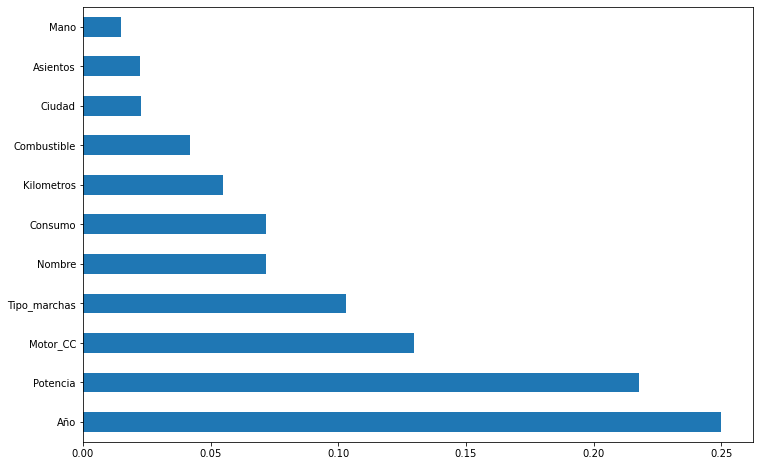

In [63]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(best_rfc_1.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig("./figures/feature_importances_rfc_1.png")
plt.show()

### SVC

In [48]:
best_svc_1 = best_svc(X_train_standard, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] kernel=poly, gamma=auto, C=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... kernel=poly, gamma=auto, C=100, total=   2.2s
[CV] kernel=poly, gamma=auto, C=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ................... kernel=poly, gamma=auto, C=100, total=   2.3s
[CV] kernel=poly, gamma=auto, C=100 ..................................
[CV] ................... kernel=poly, gamma=auto, C=100, total=   1.8s
[CV] kernel=poly, gamma=auto, C=100 ..................................
[CV] ................... kernel=poly, gamma=auto, C=100, total=   1.9s
[CV] kernel=poly, gamma=auto, C=100 ..................................
[CV] ................... kernel=poly, gamma=auto, C=100, total=   2.1s
[CV] kernel=sigmoid, gamma=auto, C=1 .................................
[CV] .................. kernel=sigmoid, gamma=auto, C=1, total=   1.1s
[CV] kernel=sigmoid, gamma=auto, C=1 .................................
[CV] .................. kernel=sigmoid, gamma=auto, C=1, total=   1.1s
[CV] kernel=sigmoid, gamma=auto, C=1 .................................
[CV] .................. kernel=sigmoid, gamma=auto, C=1, total=   1.0s
[CV] kernel=sigmoid, gamma=auto, C=1 .................................
[CV] .

[CV] ................. kernel=linear, gamma=scale, C=10, total=   2.8s
[CV] kernel=poly, gamma=auto, C=0.1 ..................................
[CV] ................... kernel=poly, gamma=auto, C=0.1, total=   0.9s
[CV] kernel=poly, gamma=auto, C=0.1 ..................................
[CV] ................... kernel=poly, gamma=auto, C=0.1, total=   0.9s
[CV] kernel=poly, gamma=auto, C=0.1 ..................................
[CV] ................... kernel=poly, gamma=auto, C=0.1, total=   0.9s
[CV] kernel=poly, gamma=auto, C=0.1 ..................................
[CV] ................... kernel=poly, gamma=auto, C=0.1, total=   0.9s
[CV] kernel=poly, gamma=auto, C=0.1 ..................................
[CV] ................... kernel=poly, gamma=auto, C=0.1, total=   0.9s
[CV] kernel=poly, gamma=auto, C=1 ....................................
[CV] ..................... kernel=poly, gamma=auto, C=1, total=   0.6s
[CV] kernel=poly, gamma=auto, C=1 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.7min finished


In [49]:
best_svc_1.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 100}

In [50]:
best_svc_1 = SVC(C = 100, gamma = 'auto', kernel = 'rbf', random_state = 42)

In [51]:
model_report(best_svc_1, X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score precision_micro 0.8801448526534152 0.006846962237509027
cross_val_score f1 macro  0.879100459027252 0.006970313460163581
cross_val_score f1 micro  0.8801448526534152 0.006846962237509027
cross_val_score precision macro  0.8795878360202822 0.00722522112042182
cross_val_score precision micro 0.8801448526534152 0.006846962237509027
cross_val_score recall macro  0.8802784306462176 0.006857187698473143
cross_val_score recall macro  0.8801448526534152 0.006846962237509027

Accuracy on Training set:  0.9381501582994121
Accuracy on Testing set:  0.8923563998190864

ERROR TABLE
accuracy_score        :  0.8923563998190864
f1_score macro        :  0.8910552858748396
f1_score micro        :  0.8923563998190864
precision_score macro :  0.8914190270110319
precision_score micro :  0.8923563998190864
recall_score macro.   :  0.8919516011691698
recall_score micro.   :  0.8923563998190864


### Best Extra tree

In [ ]:
best_extra_tree_1 = best_tree(X_train, y_train)

In [ ]:
best_extra_tree_1.best_params_

In [ ]:
best_extra_tree_1 = ExtraTreesClassifier(n_estimators = 400, min_samples_split = 15,
                                        min_samples_leaf = 1, max_features = 'auto', max_depth = 9)

In [ ]:
model_report(best_extra_tree_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [ ]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(best_extra_tree_1.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Cat boost

In [64]:
catboost_1 = best_catboost(X_train, y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8547201809
bestIteration = 1187

0:	loss: 0.8547202	best: 0.8547202 (0)	total: 4.57s	remaining: 1m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8609383833
bestIteration = 256

1:	loss: 0.8609384	best: 0.8609384 (1)	total: 6.07s	remaining: 39.5s

bestTest = 0.8631995478
bestIteration = 994

2:	loss: 0.8631995	best: 0.8631995 (2)	total: 10.6s	remaining: 42.3s

bestTest = 0.8637648389
bestIteration = 760

3:	loss: 0.8637648	best: 0.8637648 (3)	total: 14.9s	remaining: 40.9s

bestTest = 0.9067269644
bestIteration = 949

4:	loss: 0.9067270	best: 0.9067270 (4)	total: 20.4s	remaining: 40.8s

bestTest = 0.8812888638
bestIteration = 799

5:	loss: 0.8812889	best: 0.9067270 (4)	total: 30.1s	remaining: 45.2s

bestTest = 0.9248162804
bestIteration = 799

6:	loss: 0.9248163	best: 0.9248163 (6)	total: 39.7s	remaining: 45.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.895986433
bestIteration = 293

7:	loss: 0.8959864	best: 0.9248163 (6)	to

In [65]:
catboost_1['params']

{'depth': 10,
 'one_hot_max_size': 2,
 'iterations': 800,
 'random_strength': 0.03,
 'learning_rate': 0.1,
 'od_type': 'IncToDec'}

In [66]:
catboost_1 = CatBoostClassifier(
    depth = 10,
    one_hot_max_size = 2,
    iterations = 800,
    random_strength = 0.03,
    learning_rate = 0.1,
    od_type = 'IncToDec',
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    verbose=0)

In [67]:
model_report(catboost_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9375855290587773 0.006904543699665436
cross_val_score f1 macro  0.9367489536033593 0.00694610128384085
cross_val_score f1 micro  0.9375855290587773 0.006904543699665436
cross_val_score precision macro  0.9377413811482052 0.007320082311217532
cross_val_score precision micro 0.9375855290587773 0.006904543699665436
cross_val_score recall macro  0.9377327550284009 0.006917735883580865
cross_val_score recall macro  0.9375855290587773 0.006904543699665436

Accuracy on Training set:  0.9995477159656264
Accuracy on Testing set:  0.9570330167345092

ERROR TABLE
accuracy_score        :  0.9570330167345092
f1_score macro        :  0.9561233981459573
f1_score micro        :  0.9570330167345092
precision_score macro :  0.9581111785875072
precision_score micro :  0.9570330167345092
recall_score macro.   :  0.9564012256940471
recall_score micro.   :  0.9570330167345092


In [68]:
catboost_1 = CatBoostClassifier(
    depth = 7,
    iterations = 1000,
    random_strength = 0.1,
    learning_rate = 0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    verbose=0)

In [69]:
model_report(catboost_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9383771924215178 0.0050844647265631026
cross_val_score f1 macro  0.9376061647058596 0.0051198990870518725
cross_val_score f1 micro  0.9383771924215178 0.0050844647265631026
cross_val_score precision macro  0.9385332063725855 0.0054001054248209845
cross_val_score precision micro 0.9383771924215178 0.0050844647265631026
cross_val_score recall macro  0.9385125693998795 0.005097715821431599
cross_val_score recall macro  0.9383771924215178 0.0050844647265631026

Accuracy on Training set:  0.9946856625961104
Accuracy on Testing set:  0.9552238805970149

ERROR TABLE
accuracy_score        :  0.9552238805970149
f1_score macro        :  0.9544793061890153
f1_score micro        :  0.9552238805970149
precision_score macro :  0.9557153311313332
precision_score micro :  0.9552238805970149
recall_score macro.   :  0.9547449371240981
recall_score micro.   :  0.9552238805970149


### XGBoost

In [87]:
best_xgboost_1 = best_xgboost(X_train, X_test, y_train, y_test)

{'n_estimators': [100, 181, 263, 345, 427, 509, 590, 672, 754, 836, 918, 1000], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5], 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [3, 4, 5, 6, 7, 8], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [1, 5, 15, 20, 50]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.9, n_estimators=427, min_child_weight=1, max_depth=5, learning_rate=0.1, colsample_bytree=1.0 
[0]	validation_0-mlogloss:1.47990
[1]	validation_0-mlogloss:1.37304
[2]	validation_0-mlogloss:1.28594
[3]	validation_0-mlogloss:1.21029


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[4]	validation_0-mlogloss:1.14515
[5]	validation_0-mlogloss:1.08767
[6]	validation_0-mlogloss:1.03631
[7]	validation_0-mlogloss:0.99052
[8]	validation_0-mlogloss:0.95022
[9]	validation_0-mlogloss:0.91261
[10]	validation_0-mlogloss:0.87960
[11]	validation_0-mlogloss:0.85023
[12]	validation_0-mlogloss:0.82306
[13]	validation_0-mlogloss:0.79818
[14]	validation_0-mlogloss:0.77624
[15]	validation_0-mlogloss:0.75491
[16]	validation_0-mlogloss:0.73371
[17]	validation_0-mlogloss:0.71589
[18]	validation_0-mlogloss:0.69837
[19]	validation_0-mlogloss:0.68318
[20]	validation_0-mlogloss:0.66922
[21]	validation_0-mlogloss:0.65648
[22]	validation_0-mlogloss:0.64445
[23]	validation_0-mlogloss:0.63171
[24]	validation_0-mlogloss:0.62107
[25]	validation_0-mlogloss:0.61111
[26]	validation_0-mlogloss:0.60074
[27]	validation_0-mlogloss:0.59164
[28]	validation_0-mlogloss:0.58207
[29]	validation_0-mlogloss:0.57460
[30]	validation_0-mlogloss:0.56664
[31]	validation_0-mlogloss:0.55876
[32]	validation_0-mlogloss

[235]	validation_0-mlogloss:0.19533
[236]	validation_0-mlogloss:0.19486
[237]	validation_0-mlogloss:0.19448
[238]	validation_0-mlogloss:0.19417
[239]	validation_0-mlogloss:0.19368
[240]	validation_0-mlogloss:0.19314
[241]	validation_0-mlogloss:0.19276
[242]	validation_0-mlogloss:0.19242
[243]	validation_0-mlogloss:0.19196
[244]	validation_0-mlogloss:0.19157
[245]	validation_0-mlogloss:0.19142
[246]	validation_0-mlogloss:0.19090
[247]	validation_0-mlogloss:0.19055
[248]	validation_0-mlogloss:0.19016
[249]	validation_0-mlogloss:0.18979
[250]	validation_0-mlogloss:0.18933
[251]	validation_0-mlogloss:0.18882
[252]	validation_0-mlogloss:0.18830
[253]	validation_0-mlogloss:0.18789
[254]	validation_0-mlogloss:0.18747
[255]	validation_0-mlogloss:0.18692
[256]	validation_0-mlogloss:0.18667
[257]	validation_0-mlogloss:0.18625
[258]	validation_0-mlogloss:0.18605
[259]	validation_0-mlogloss:0.18568
[260]	validation_0-mlogloss:0.18543
[261]	validation_0-mlogloss:0.18500
[262]	validation_0-mlogloss:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[5]	validation_0-mlogloss:1.08615
[6]	validation_0-mlogloss:1.03508
[7]	validation_0-mlogloss:0.98770
[8]	validation_0-mlogloss:0.94717
[9]	validation_0-mlogloss:0.91061
[10]	validation_0-mlogloss:0.87818
[11]	validation_0-mlogloss:0.84690
[12]	validation_0-mlogloss:0.81907
[13]	validation_0-mlogloss:0.79417
[14]	validation_0-mlogloss:0.77123
[15]	validation_0-mlogloss:0.74984
[16]	validation_0-mlogloss:0.72970
[17]	validation_0-mlogloss:0.71259
[18]	validation_0-mlogloss:0.69496
[19]	validation_0-mlogloss:0.67970
[20]	validation_0-mlogloss:0.66504
[21]	validation_0-mlogloss:0.65196
[22]	validation_0-mlogloss:0.63852
[23]	validation_0-mlogloss:0.62575
[24]	validation_0-mlogloss:0.61519
[25]	validation_0-mlogloss:0.60328
[26]	validation_0-mlogloss:0.59364
[27]	validation_0-mlogloss:0.58440
[28]	validation_0-mlogloss:0.57555
[29]	validation_0-mlogloss:0.56707
[30]	validation_0-mlogloss:0.55897
[31]	validation_0-mlogloss:0.55149
[32]	validation_0-mlogloss:0.54482
[33]	validation_0-mloglos

[236]	validation_0-mlogloss:0.20059
[237]	validation_0-mlogloss:0.20010
[238]	validation_0-mlogloss:0.19977
[239]	validation_0-mlogloss:0.19938
[240]	validation_0-mlogloss:0.19912
[241]	validation_0-mlogloss:0.19889
[242]	validation_0-mlogloss:0.19832
[243]	validation_0-mlogloss:0.19806
[244]	validation_0-mlogloss:0.19755
[245]	validation_0-mlogloss:0.19709
[246]	validation_0-mlogloss:0.19664
[247]	validation_0-mlogloss:0.19629
[248]	validation_0-mlogloss:0.19606
[249]	validation_0-mlogloss:0.19577
[250]	validation_0-mlogloss:0.19541
[251]	validation_0-mlogloss:0.19516
[252]	validation_0-mlogloss:0.19483
[253]	validation_0-mlogloss:0.19440
[254]	validation_0-mlogloss:0.19415
[255]	validation_0-mlogloss:0.19366
[256]	validation_0-mlogloss:0.19326
[257]	validation_0-mlogloss:0.19291
[258]	validation_0-mlogloss:0.19262
[259]	validation_0-mlogloss:0.19223
[260]	validation_0-mlogloss:0.19161
[261]	validation_0-mlogloss:0.19122
[262]	validation_0-mlogloss:0.19078
[263]	validation_0-mlogloss:

[32]	validation_0-mlogloss:0.55334
[33]	validation_0-mlogloss:0.54675
[34]	validation_0-mlogloss:0.53999
[35]	validation_0-mlogloss:0.53405
[36]	validation_0-mlogloss:0.52847
[37]	validation_0-mlogloss:0.52223
[38]	validation_0-mlogloss:0.51713
[39]	validation_0-mlogloss:0.51162
[40]	validation_0-mlogloss:0.50642
[41]	validation_0-mlogloss:0.50004
[42]	validation_0-mlogloss:0.49386
[43]	validation_0-mlogloss:0.48970
[44]	validation_0-mlogloss:0.48497
[45]	validation_0-mlogloss:0.48049
[46]	validation_0-mlogloss:0.47553
[47]	validation_0-mlogloss:0.47130
[48]	validation_0-mlogloss:0.46758
[49]	validation_0-mlogloss:0.46194
[50]	validation_0-mlogloss:0.45701
[51]	validation_0-mlogloss:0.45239
[52]	validation_0-mlogloss:0.44872
[53]	validation_0-mlogloss:0.44557
[54]	validation_0-mlogloss:0.44206
[55]	validation_0-mlogloss:0.43770
[56]	validation_0-mlogloss:0.43480
[57]	validation_0-mlogloss:0.43228
[58]	validation_0-mlogloss:0.42830
[59]	validation_0-mlogloss:0.42584
[60]	validation_0-ml

[262]	validation_0-mlogloss:0.19341
[263]	validation_0-mlogloss:0.19293
[264]	validation_0-mlogloss:0.19267
[265]	validation_0-mlogloss:0.19239
[266]	validation_0-mlogloss:0.19216
[267]	validation_0-mlogloss:0.19196
[268]	validation_0-mlogloss:0.19170
[269]	validation_0-mlogloss:0.19160
[270]	validation_0-mlogloss:0.19097
[271]	validation_0-mlogloss:0.19085
[272]	validation_0-mlogloss:0.19075
[273]	validation_0-mlogloss:0.19025
[274]	validation_0-mlogloss:0.18988
[275]	validation_0-mlogloss:0.18955
[276]	validation_0-mlogloss:0.18909
[277]	validation_0-mlogloss:0.18877
[278]	validation_0-mlogloss:0.18843
[279]	validation_0-mlogloss:0.18837
[280]	validation_0-mlogloss:0.18788
[281]	validation_0-mlogloss:0.18774
[282]	validation_0-mlogloss:0.18762
[283]	validation_0-mlogloss:0.18741
[284]	validation_0-mlogloss:0.18688
[285]	validation_0-mlogloss:0.18662
[286]	validation_0-mlogloss:0.18642
[287]	validation_0-mlogloss:0.18610
[288]	validation_0-mlogloss:0.18579
[289]	validation_0-mlogloss:

[58]	validation_0-mlogloss:0.42158
[59]	validation_0-mlogloss:0.41829
[60]	validation_0-mlogloss:0.41553
[61]	validation_0-mlogloss:0.41139
[62]	validation_0-mlogloss:0.40780
[63]	validation_0-mlogloss:0.40420
[64]	validation_0-mlogloss:0.40189
[65]	validation_0-mlogloss:0.39919
[66]	validation_0-mlogloss:0.39639
[67]	validation_0-mlogloss:0.39384
[68]	validation_0-mlogloss:0.39112
[69]	validation_0-mlogloss:0.38869
[70]	validation_0-mlogloss:0.38628
[71]	validation_0-mlogloss:0.38385
[72]	validation_0-mlogloss:0.38031
[73]	validation_0-mlogloss:0.37805
[74]	validation_0-mlogloss:0.37540
[75]	validation_0-mlogloss:0.37381
[76]	validation_0-mlogloss:0.37095
[77]	validation_0-mlogloss:0.36903
[78]	validation_0-mlogloss:0.36614
[79]	validation_0-mlogloss:0.36314
[80]	validation_0-mlogloss:0.36112
[81]	validation_0-mlogloss:0.35800
[82]	validation_0-mlogloss:0.35580
[83]	validation_0-mlogloss:0.35348
[84]	validation_0-mlogloss:0.35232
[85]	validation_0-mlogloss:0.35003
[86]	validation_0-ml

[287]	validation_0-mlogloss:0.18353
[288]	validation_0-mlogloss:0.18329
[289]	validation_0-mlogloss:0.18316
[290]	validation_0-mlogloss:0.18298
[291]	validation_0-mlogloss:0.18272
[292]	validation_0-mlogloss:0.18274
[293]	validation_0-mlogloss:0.18250
[294]	validation_0-mlogloss:0.18230
[295]	validation_0-mlogloss:0.18216
[296]	validation_0-mlogloss:0.18197
[297]	validation_0-mlogloss:0.18202
[298]	validation_0-mlogloss:0.18182
[299]	validation_0-mlogloss:0.18161
[300]	validation_0-mlogloss:0.18141
[301]	validation_0-mlogloss:0.18107
[302]	validation_0-mlogloss:0.18077
[303]	validation_0-mlogloss:0.18060
[304]	validation_0-mlogloss:0.18031
[305]	validation_0-mlogloss:0.17996
[306]	validation_0-mlogloss:0.17974
[307]	validation_0-mlogloss:0.17952
[308]	validation_0-mlogloss:0.17921
[309]	validation_0-mlogloss:0.17902
[310]	validation_0-mlogloss:0.17874
[311]	validation_0-mlogloss:0.17875
[312]	validation_0-mlogloss:0.17855
[313]	validation_0-mlogloss:0.17819
[314]	validation_0-mlogloss:

[84]	validation_0-mlogloss:0.35882
[85]	validation_0-mlogloss:0.35706
[86]	validation_0-mlogloss:0.35456
[87]	validation_0-mlogloss:0.35211
[88]	validation_0-mlogloss:0.34958
[89]	validation_0-mlogloss:0.34714
[90]	validation_0-mlogloss:0.34521
[91]	validation_0-mlogloss:0.34357
[92]	validation_0-mlogloss:0.34166
[93]	validation_0-mlogloss:0.33960
[94]	validation_0-mlogloss:0.33785
[95]	validation_0-mlogloss:0.33577
[96]	validation_0-mlogloss:0.33293
[97]	validation_0-mlogloss:0.33130
[98]	validation_0-mlogloss:0.32976
[99]	validation_0-mlogloss:0.32838
[100]	validation_0-mlogloss:0.32709
[101]	validation_0-mlogloss:0.32571
[102]	validation_0-mlogloss:0.32348
[103]	validation_0-mlogloss:0.32156
[104]	validation_0-mlogloss:0.31909
[105]	validation_0-mlogloss:0.31776
[106]	validation_0-mlogloss:0.31555
[107]	validation_0-mlogloss:0.31348
[108]	validation_0-mlogloss:0.31213
[109]	validation_0-mlogloss:0.31067
[110]	validation_0-mlogloss:0.30891
[111]	validation_0-mlogloss:0.30731
[112]	va

[313]	validation_0-mlogloss:0.17230
[314]	validation_0-mlogloss:0.17196
[315]	validation_0-mlogloss:0.17182
[316]	validation_0-mlogloss:0.17175
[317]	validation_0-mlogloss:0.17143
[318]	validation_0-mlogloss:0.17106
[319]	validation_0-mlogloss:0.17103
[320]	validation_0-mlogloss:0.17084
[321]	validation_0-mlogloss:0.17060
[322]	validation_0-mlogloss:0.17030
[323]	validation_0-mlogloss:0.17002
[324]	validation_0-mlogloss:0.16983
[325]	validation_0-mlogloss:0.16954
[326]	validation_0-mlogloss:0.16942
[327]	validation_0-mlogloss:0.16916
[328]	validation_0-mlogloss:0.16873
[329]	validation_0-mlogloss:0.16843
[330]	validation_0-mlogloss:0.16829
[331]	validation_0-mlogloss:0.16804
[332]	validation_0-mlogloss:0.16800
[333]	validation_0-mlogloss:0.16763
[334]	validation_0-mlogloss:0.16742
[335]	validation_0-mlogloss:0.16705
[336]	validation_0-mlogloss:0.16679
[337]	validation_0-mlogloss:0.16655
[338]	validation_0-mlogloss:0.16633
[339]	validation_0-mlogloss:0.16593
[340]	validation_0-mlogloss:

[110]	validation_0-mlogloss:0.34317
[111]	validation_0-mlogloss:0.34319
[112]	validation_0-mlogloss:0.34231
[113]	validation_0-mlogloss:0.34143
[114]	validation_0-mlogloss:0.34127
[115]	validation_0-mlogloss:0.33968
[116]	validation_0-mlogloss:0.33894
[117]	validation_0-mlogloss:0.33761
[118]	validation_0-mlogloss:0.33759
[119]	validation_0-mlogloss:0.33713
[120]	validation_0-mlogloss:0.33659
[121]	validation_0-mlogloss:0.33583
[122]	validation_0-mlogloss:0.33479
[123]	validation_0-mlogloss:0.33405
[124]	validation_0-mlogloss:0.33383
[125]	validation_0-mlogloss:0.33247
[126]	validation_0-mlogloss:0.33162
[127]	validation_0-mlogloss:0.33133
[128]	validation_0-mlogloss:0.33095
[129]	validation_0-mlogloss:0.32972
[130]	validation_0-mlogloss:0.32935
[131]	validation_0-mlogloss:0.32893
[132]	validation_0-mlogloss:0.32859
[133]	validation_0-mlogloss:0.32774
[134]	validation_0-mlogloss:0.32751
[135]	validation_0-mlogloss:0.32649
[136]	validation_0-mlogloss:0.32587
[137]	validation_0-mlogloss:

[338]	validation_0-mlogloss:0.26181
[339]	validation_0-mlogloss:0.26166
[340]	validation_0-mlogloss:0.26184
[341]	validation_0-mlogloss:0.26186
[342]	validation_0-mlogloss:0.26188
[343]	validation_0-mlogloss:0.26195
[344]	validation_0-mlogloss:0.26173
[CV]  subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0, total=  10.8s
[CV] subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0 
[0]	validation_0-mlogloss:1.30820
[1]	validation_0-mlogloss:1.12483
[2]	validation_0-mlogloss:1.00303
[3]	validation_0-mlogloss:0.91033
[4]	validation_0-mlogloss:0.84508
[5]	validation_0-mlogloss:0.79157
[6]	validation_0-mlogloss:0.74730
[7]	validation_0-mlogloss:0.71198
[8]	validation_0-mlogloss:0.68251
[9]	validation_0-mlogloss:0.65614
[10]	validation_0-mlogloss:0.63600
[11]	validation_0-mlogloss:0.61677
[12]	validation_0-mlogloss:0.60055
[13]	validation_0-mlogloss:0.58459
[14]	validation_0-mlogloss:

[217]	validation_0-mlogloss:0.29272
[218]	validation_0-mlogloss:0.29268
[219]	validation_0-mlogloss:0.29248
[220]	validation_0-mlogloss:0.29243
[221]	validation_0-mlogloss:0.29193
[222]	validation_0-mlogloss:0.29184
[223]	validation_0-mlogloss:0.29189
[224]	validation_0-mlogloss:0.29126
[225]	validation_0-mlogloss:0.29109
[226]	validation_0-mlogloss:0.29091
[227]	validation_0-mlogloss:0.29069
[228]	validation_0-mlogloss:0.29014
[229]	validation_0-mlogloss:0.28980
[230]	validation_0-mlogloss:0.28936
[231]	validation_0-mlogloss:0.28952
[232]	validation_0-mlogloss:0.28907
[233]	validation_0-mlogloss:0.28927
[234]	validation_0-mlogloss:0.28890
[235]	validation_0-mlogloss:0.28858
[236]	validation_0-mlogloss:0.28818
[237]	validation_0-mlogloss:0.28726
[238]	validation_0-mlogloss:0.28720
[239]	validation_0-mlogloss:0.28728
[240]	validation_0-mlogloss:0.28726
[241]	validation_0-mlogloss:0.28631
[242]	validation_0-mlogloss:0.28652
[243]	validation_0-mlogloss:0.28591
[244]	validation_0-mlogloss:

[96]	validation_0-mlogloss:0.35240
[97]	validation_0-mlogloss:0.35206
[98]	validation_0-mlogloss:0.35098
[99]	validation_0-mlogloss:0.35037
[100]	validation_0-mlogloss:0.34992
[101]	validation_0-mlogloss:0.34879
[102]	validation_0-mlogloss:0.34818
[103]	validation_0-mlogloss:0.34816
[104]	validation_0-mlogloss:0.34730
[105]	validation_0-mlogloss:0.34674
[106]	validation_0-mlogloss:0.34642
[107]	validation_0-mlogloss:0.34555
[108]	validation_0-mlogloss:0.34447
[109]	validation_0-mlogloss:0.34386
[110]	validation_0-mlogloss:0.34314
[111]	validation_0-mlogloss:0.34323
[112]	validation_0-mlogloss:0.34312
[113]	validation_0-mlogloss:0.34212
[114]	validation_0-mlogloss:0.34133
[115]	validation_0-mlogloss:0.33989
[116]	validation_0-mlogloss:0.33936
[117]	validation_0-mlogloss:0.33912
[118]	validation_0-mlogloss:0.33898
[119]	validation_0-mlogloss:0.33803
[120]	validation_0-mlogloss:0.33751
[121]	validation_0-mlogloss:0.33708
[122]	validation_0-mlogloss:0.33709
[123]	validation_0-mlogloss:0.33

[324]	validation_0-mlogloss:0.27303
[325]	validation_0-mlogloss:0.27258
[326]	validation_0-mlogloss:0.27219
[327]	validation_0-mlogloss:0.27197
[328]	validation_0-mlogloss:0.27198
[329]	validation_0-mlogloss:0.27153
[330]	validation_0-mlogloss:0.27124
[331]	validation_0-mlogloss:0.27125
[332]	validation_0-mlogloss:0.27108
[333]	validation_0-mlogloss:0.27114
[334]	validation_0-mlogloss:0.27099
[335]	validation_0-mlogloss:0.27014
[336]	validation_0-mlogloss:0.26961
[337]	validation_0-mlogloss:0.26967
[338]	validation_0-mlogloss:0.26908
[339]	validation_0-mlogloss:0.26918
[340]	validation_0-mlogloss:0.26945
[341]	validation_0-mlogloss:0.26930
[342]	validation_0-mlogloss:0.26968
[343]	validation_0-mlogloss:0.26961
[344]	validation_0-mlogloss:0.26924
[CV]  subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0, total=  12.2s
[CV] subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0 
[0]

[203]	validation_0-mlogloss:0.29966
[204]	validation_0-mlogloss:0.29952
[205]	validation_0-mlogloss:0.29937
[206]	validation_0-mlogloss:0.29921
[207]	validation_0-mlogloss:0.29894
[208]	validation_0-mlogloss:0.29858
[209]	validation_0-mlogloss:0.29843
[210]	validation_0-mlogloss:0.29816
[211]	validation_0-mlogloss:0.29753
[212]	validation_0-mlogloss:0.29719
[213]	validation_0-mlogloss:0.29680
[214]	validation_0-mlogloss:0.29573
[215]	validation_0-mlogloss:0.29529
[216]	validation_0-mlogloss:0.29458
[217]	validation_0-mlogloss:0.29464
[218]	validation_0-mlogloss:0.29435
[219]	validation_0-mlogloss:0.29428
[220]	validation_0-mlogloss:0.29384
[221]	validation_0-mlogloss:0.29315
[222]	validation_0-mlogloss:0.29310
[223]	validation_0-mlogloss:0.29320
[224]	validation_0-mlogloss:0.29298
[225]	validation_0-mlogloss:0.29266
[226]	validation_0-mlogloss:0.29194
[227]	validation_0-mlogloss:0.29223
[228]	validation_0-mlogloss:0.29210
[229]	validation_0-mlogloss:0.29141
[230]	validation_0-mlogloss:

[82]	validation_0-mlogloss:0.36922
[83]	validation_0-mlogloss:0.36853
[84]	validation_0-mlogloss:0.36751
[85]	validation_0-mlogloss:0.36691
[86]	validation_0-mlogloss:0.36637
[87]	validation_0-mlogloss:0.36459
[88]	validation_0-mlogloss:0.36360
[89]	validation_0-mlogloss:0.36228
[90]	validation_0-mlogloss:0.36169
[91]	validation_0-mlogloss:0.35966
[92]	validation_0-mlogloss:0.35921
[93]	validation_0-mlogloss:0.35932
[94]	validation_0-mlogloss:0.35835
[95]	validation_0-mlogloss:0.35708
[96]	validation_0-mlogloss:0.35633
[97]	validation_0-mlogloss:0.35584
[98]	validation_0-mlogloss:0.35492
[99]	validation_0-mlogloss:0.35391
[100]	validation_0-mlogloss:0.35321
[101]	validation_0-mlogloss:0.35283
[102]	validation_0-mlogloss:0.35193
[103]	validation_0-mlogloss:0.35142
[104]	validation_0-mlogloss:0.35053
[105]	validation_0-mlogloss:0.34976
[106]	validation_0-mlogloss:0.34887
[107]	validation_0-mlogloss:0.34800
[108]	validation_0-mlogloss:0.34712
[109]	validation_0-mlogloss:0.34636
[110]	vali

[311]	validation_0-mlogloss:0.27438
[312]	validation_0-mlogloss:0.27422
[313]	validation_0-mlogloss:0.27409
[314]	validation_0-mlogloss:0.27414
[315]	validation_0-mlogloss:0.27389
[316]	validation_0-mlogloss:0.27393
[317]	validation_0-mlogloss:0.27385
[318]	validation_0-mlogloss:0.27394
[319]	validation_0-mlogloss:0.27395
[320]	validation_0-mlogloss:0.27331
[321]	validation_0-mlogloss:0.27322
[322]	validation_0-mlogloss:0.27319
[323]	validation_0-mlogloss:0.27289
[324]	validation_0-mlogloss:0.27287
[325]	validation_0-mlogloss:0.27309
[326]	validation_0-mlogloss:0.27283
[327]	validation_0-mlogloss:0.27234
[328]	validation_0-mlogloss:0.27246
[329]	validation_0-mlogloss:0.27222
[330]	validation_0-mlogloss:0.27191
[331]	validation_0-mlogloss:0.27180
[332]	validation_0-mlogloss:0.27155
[333]	validation_0-mlogloss:0.27149
[334]	validation_0-mlogloss:0.27132
[335]	validation_0-mlogloss:0.27139
[336]	validation_0-mlogloss:0.27105
[337]	validation_0-mlogloss:0.27082
[338]	validation_0-mlogloss:

[3]	validation_0-mlogloss:1.12112
[4]	validation_0-mlogloss:1.05184
[5]	validation_0-mlogloss:0.99750
[6]	validation_0-mlogloss:0.95247
[7]	validation_0-mlogloss:0.91337
[8]	validation_0-mlogloss:0.87990
[9]	validation_0-mlogloss:0.84722
[10]	validation_0-mlogloss:0.82135
[11]	validation_0-mlogloss:0.79846
[12]	validation_0-mlogloss:0.77899
[13]	validation_0-mlogloss:0.76137
[14]	validation_0-mlogloss:0.74563
[15]	validation_0-mlogloss:0.73072
[16]	validation_0-mlogloss:0.71483
[17]	validation_0-mlogloss:0.70379
[18]	validation_0-mlogloss:0.69173
[19]	validation_0-mlogloss:0.68179
[20]	validation_0-mlogloss:0.67204
[21]	validation_0-mlogloss:0.66129
[22]	validation_0-mlogloss:0.65013
[23]	validation_0-mlogloss:0.64080
[24]	validation_0-mlogloss:0.63259
[25]	validation_0-mlogloss:0.62473
[26]	validation_0-mlogloss:0.61712
[27]	validation_0-mlogloss:0.60954
[28]	validation_0-mlogloss:0.60327
[29]	validation_0-mlogloss:0.59676
[30]	validation_0-mlogloss:0.59187
[31]	validation_0-mlogloss:

[48]	validation_0-mlogloss:0.52225
[49]	validation_0-mlogloss:0.51814
[50]	validation_0-mlogloss:0.51499
[51]	validation_0-mlogloss:0.51029
[52]	validation_0-mlogloss:0.50651
[53]	validation_0-mlogloss:0.50323
[54]	validation_0-mlogloss:0.50048
[55]	validation_0-mlogloss:0.49809
[56]	validation_0-mlogloss:0.49571
[57]	validation_0-mlogloss:0.49351
[58]	validation_0-mlogloss:0.48952
[59]	validation_0-mlogloss:0.48671
[60]	validation_0-mlogloss:0.48426
[61]	validation_0-mlogloss:0.48168
[62]	validation_0-mlogloss:0.47912
[63]	validation_0-mlogloss:0.47690
[64]	validation_0-mlogloss:0.47394
[65]	validation_0-mlogloss:0.47164
[66]	validation_0-mlogloss:0.46962
[67]	validation_0-mlogloss:0.46734
[68]	validation_0-mlogloss:0.46529
[69]	validation_0-mlogloss:0.46194
[70]	validation_0-mlogloss:0.46055
[71]	validation_0-mlogloss:0.45881
[72]	validation_0-mlogloss:0.45604
[73]	validation_0-mlogloss:0.45416
[74]	validation_0-mlogloss:0.45288
[75]	validation_0-mlogloss:0.44996
[76]	validation_0-ml

[93]	validation_0-mlogloss:0.40870
[94]	validation_0-mlogloss:0.40711
[95]	validation_0-mlogloss:0.40522
[96]	validation_0-mlogloss:0.40402
[97]	validation_0-mlogloss:0.40205
[98]	validation_0-mlogloss:0.40009
[99]	validation_0-mlogloss:0.39831
[100]	validation_0-mlogloss:0.39648
[101]	validation_0-mlogloss:0.39429
[102]	validation_0-mlogloss:0.39310
[103]	validation_0-mlogloss:0.39206
[104]	validation_0-mlogloss:0.39097
[105]	validation_0-mlogloss:0.38946
[106]	validation_0-mlogloss:0.38853
[107]	validation_0-mlogloss:0.38758
[108]	validation_0-mlogloss:0.38622
[109]	validation_0-mlogloss:0.38456
[110]	validation_0-mlogloss:0.38359
[111]	validation_0-mlogloss:0.38227
[112]	validation_0-mlogloss:0.38067
[113]	validation_0-mlogloss:0.38004
[114]	validation_0-mlogloss:0.37825
[115]	validation_0-mlogloss:0.37739
[116]	validation_0-mlogloss:0.37550
[117]	validation_0-mlogloss:0.37353
[118]	validation_0-mlogloss:0.37186
[119]	validation_0-mlogloss:0.37052
[120]	validation_0-mlogloss:0.36931

[137]	validation_0-mlogloss:0.34577
[138]	validation_0-mlogloss:0.34474
[139]	validation_0-mlogloss:0.34385
[140]	validation_0-mlogloss:0.34262
[141]	validation_0-mlogloss:0.34144
[142]	validation_0-mlogloss:0.34061
[143]	validation_0-mlogloss:0.33953
[144]	validation_0-mlogloss:0.33826
[145]	validation_0-mlogloss:0.33703
[146]	validation_0-mlogloss:0.33589
[147]	validation_0-mlogloss:0.33505
[148]	validation_0-mlogloss:0.33407
[149]	validation_0-mlogloss:0.33320
[150]	validation_0-mlogloss:0.33257
[151]	validation_0-mlogloss:0.33114
[152]	validation_0-mlogloss:0.33032
[153]	validation_0-mlogloss:0.32935
[154]	validation_0-mlogloss:0.32837
[155]	validation_0-mlogloss:0.32732
[156]	validation_0-mlogloss:0.32646
[157]	validation_0-mlogloss:0.32571
[158]	validation_0-mlogloss:0.32523
[159]	validation_0-mlogloss:0.32380
[160]	validation_0-mlogloss:0.32303
[161]	validation_0-mlogloss:0.32245
[162]	validation_0-mlogloss:0.32133
[163]	validation_0-mlogloss:0.32041
[164]	validation_0-mlogloss:

[180]	validation_0-mlogloss:0.36455
[181]	validation_0-mlogloss:0.36392
[182]	validation_0-mlogloss:0.36320
[183]	validation_0-mlogloss:0.36240
[184]	validation_0-mlogloss:0.36177
[185]	validation_0-mlogloss:0.36109
[186]	validation_0-mlogloss:0.36015
[187]	validation_0-mlogloss:0.35957
[188]	validation_0-mlogloss:0.35899
[189]	validation_0-mlogloss:0.35785
[190]	validation_0-mlogloss:0.35725
[191]	validation_0-mlogloss:0.35637
[192]	validation_0-mlogloss:0.35535
[193]	validation_0-mlogloss:0.35478
[194]	validation_0-mlogloss:0.35408
[195]	validation_0-mlogloss:0.35333
[196]	validation_0-mlogloss:0.35274
[197]	validation_0-mlogloss:0.35198
[198]	validation_0-mlogloss:0.35142
[199]	validation_0-mlogloss:0.35060
[200]	validation_0-mlogloss:0.34975
[201]	validation_0-mlogloss:0.34909
[202]	validation_0-mlogloss:0.34844
[203]	validation_0-mlogloss:0.34787
[204]	validation_0-mlogloss:0.34722
[205]	validation_0-mlogloss:0.34647
[206]	validation_0-mlogloss:0.34560
[207]	validation_0-mlogloss:

[408]	validation_0-mlogloss:0.26967
[409]	validation_0-mlogloss:0.26947
[410]	validation_0-mlogloss:0.26927
[411]	validation_0-mlogloss:0.26914
[412]	validation_0-mlogloss:0.26878
[413]	validation_0-mlogloss:0.26860
[414]	validation_0-mlogloss:0.26842
[415]	validation_0-mlogloss:0.26819
[416]	validation_0-mlogloss:0.26800
[417]	validation_0-mlogloss:0.26767
[418]	validation_0-mlogloss:0.26747
[419]	validation_0-mlogloss:0.26719
[420]	validation_0-mlogloss:0.26702
[421]	validation_0-mlogloss:0.26680
[422]	validation_0-mlogloss:0.26659
[423]	validation_0-mlogloss:0.26640
[424]	validation_0-mlogloss:0.26622
[425]	validation_0-mlogloss:0.26599
[426]	validation_0-mlogloss:0.26581
[427]	validation_0-mlogloss:0.26550
[428]	validation_0-mlogloss:0.26524
[429]	validation_0-mlogloss:0.26489
[430]	validation_0-mlogloss:0.26461
[431]	validation_0-mlogloss:0.26434
[432]	validation_0-mlogloss:0.26412
[433]	validation_0-mlogloss:0.26386
[434]	validation_0-mlogloss:0.26366
[435]	validation_0-mlogloss:

[636]	validation_0-mlogloss:0.23125
[637]	validation_0-mlogloss:0.23112
[638]	validation_0-mlogloss:0.23100
[639]	validation_0-mlogloss:0.23089
[640]	validation_0-mlogloss:0.23077
[641]	validation_0-mlogloss:0.23068
[642]	validation_0-mlogloss:0.23051
[643]	validation_0-mlogloss:0.23039
[644]	validation_0-mlogloss:0.23036
[645]	validation_0-mlogloss:0.23023
[646]	validation_0-mlogloss:0.23019
[647]	validation_0-mlogloss:0.23011
[648]	validation_0-mlogloss:0.23000
[649]	validation_0-mlogloss:0.22987
[650]	validation_0-mlogloss:0.22978
[651]	validation_0-mlogloss:0.22963
[652]	validation_0-mlogloss:0.22954
[653]	validation_0-mlogloss:0.22945
[654]	validation_0-mlogloss:0.22936
[655]	validation_0-mlogloss:0.22926
[656]	validation_0-mlogloss:0.22917
[657]	validation_0-mlogloss:0.22906
[658]	validation_0-mlogloss:0.22895
[659]	validation_0-mlogloss:0.22879
[660]	validation_0-mlogloss:0.22869
[661]	validation_0-mlogloss:0.22863
[662]	validation_0-mlogloss:0.22851
[663]	validation_0-mlogloss:

[106]	validation_0-mlogloss:0.45795
[107]	validation_0-mlogloss:0.45616
[108]	validation_0-mlogloss:0.45434
[109]	validation_0-mlogloss:0.45249
[110]	validation_0-mlogloss:0.45076
[111]	validation_0-mlogloss:0.44927
[112]	validation_0-mlogloss:0.44775
[113]	validation_0-mlogloss:0.44612
[114]	validation_0-mlogloss:0.44435
[115]	validation_0-mlogloss:0.44254
[116]	validation_0-mlogloss:0.44085
[117]	validation_0-mlogloss:0.43911
[118]	validation_0-mlogloss:0.43780
[119]	validation_0-mlogloss:0.43657
[120]	validation_0-mlogloss:0.43516
[121]	validation_0-mlogloss:0.43321
[122]	validation_0-mlogloss:0.43217
[123]	validation_0-mlogloss:0.43083
[124]	validation_0-mlogloss:0.42945
[125]	validation_0-mlogloss:0.42825
[126]	validation_0-mlogloss:0.42664
[127]	validation_0-mlogloss:0.42527
[128]	validation_0-mlogloss:0.42400
[129]	validation_0-mlogloss:0.42256
[130]	validation_0-mlogloss:0.42090
[131]	validation_0-mlogloss:0.41984
[132]	validation_0-mlogloss:0.41811
[133]	validation_0-mlogloss:

[334]	validation_0-mlogloss:0.29526
[335]	validation_0-mlogloss:0.29501
[336]	validation_0-mlogloss:0.29476
[337]	validation_0-mlogloss:0.29461
[338]	validation_0-mlogloss:0.29430
[339]	validation_0-mlogloss:0.29389
[340]	validation_0-mlogloss:0.29363
[341]	validation_0-mlogloss:0.29336
[342]	validation_0-mlogloss:0.29305
[343]	validation_0-mlogloss:0.29272
[344]	validation_0-mlogloss:0.29238
[345]	validation_0-mlogloss:0.29208
[346]	validation_0-mlogloss:0.29187
[347]	validation_0-mlogloss:0.29156
[348]	validation_0-mlogloss:0.29128
[349]	validation_0-mlogloss:0.29097
[350]	validation_0-mlogloss:0.29065
[351]	validation_0-mlogloss:0.29043
[352]	validation_0-mlogloss:0.29020
[353]	validation_0-mlogloss:0.28990
[354]	validation_0-mlogloss:0.28958
[355]	validation_0-mlogloss:0.28917
[356]	validation_0-mlogloss:0.28890
[357]	validation_0-mlogloss:0.28868
[358]	validation_0-mlogloss:0.28829
[359]	validation_0-mlogloss:0.28807
[360]	validation_0-mlogloss:0.28781
[361]	validation_0-mlogloss:

[562]	validation_0-mlogloss:0.24655
[563]	validation_0-mlogloss:0.24629
[564]	validation_0-mlogloss:0.24605
[565]	validation_0-mlogloss:0.24599
[566]	validation_0-mlogloss:0.24581
[567]	validation_0-mlogloss:0.24562
[568]	validation_0-mlogloss:0.24546
[569]	validation_0-mlogloss:0.24535
[570]	validation_0-mlogloss:0.24520
[571]	validation_0-mlogloss:0.24513
[572]	validation_0-mlogloss:0.24494
[573]	validation_0-mlogloss:0.24483
[574]	validation_0-mlogloss:0.24467
[575]	validation_0-mlogloss:0.24449
[576]	validation_0-mlogloss:0.24440
[577]	validation_0-mlogloss:0.24427
[578]	validation_0-mlogloss:0.24411
[579]	validation_0-mlogloss:0.24402
[580]	validation_0-mlogloss:0.24383
[581]	validation_0-mlogloss:0.24369
[582]	validation_0-mlogloss:0.24355
[583]	validation_0-mlogloss:0.24346
[584]	validation_0-mlogloss:0.24334
[585]	validation_0-mlogloss:0.24323
[586]	validation_0-mlogloss:0.24304
[587]	validation_0-mlogloss:0.24291
[588]	validation_0-mlogloss:0.24283
[589]	validation_0-mlogloss:

[30]	validation_0-mlogloss:0.76532
[31]	validation_0-mlogloss:0.75502
[32]	validation_0-mlogloss:0.74536
[33]	validation_0-mlogloss:0.73585
[34]	validation_0-mlogloss:0.72670
[35]	validation_0-mlogloss:0.71772
[36]	validation_0-mlogloss:0.70916
[37]	validation_0-mlogloss:0.70119
[38]	validation_0-mlogloss:0.69305
[39]	validation_0-mlogloss:0.68572
[40]	validation_0-mlogloss:0.67866
[41]	validation_0-mlogloss:0.67191
[42]	validation_0-mlogloss:0.66538
[43]	validation_0-mlogloss:0.65899
[44]	validation_0-mlogloss:0.65307
[45]	validation_0-mlogloss:0.64693
[46]	validation_0-mlogloss:0.64150
[47]	validation_0-mlogloss:0.63609
[48]	validation_0-mlogloss:0.63100
[49]	validation_0-mlogloss:0.62562
[50]	validation_0-mlogloss:0.62084
[51]	validation_0-mlogloss:0.61629
[52]	validation_0-mlogloss:0.61203
[53]	validation_0-mlogloss:0.60700
[54]	validation_0-mlogloss:0.60261
[55]	validation_0-mlogloss:0.59818
[56]	validation_0-mlogloss:0.59398
[57]	validation_0-mlogloss:0.58975
[58]	validation_0-ml

[260]	validation_0-mlogloss:0.32620
[261]	validation_0-mlogloss:0.32576
[262]	validation_0-mlogloss:0.32542
[263]	validation_0-mlogloss:0.32497
[264]	validation_0-mlogloss:0.32451
[265]	validation_0-mlogloss:0.32411
[266]	validation_0-mlogloss:0.32374
[267]	validation_0-mlogloss:0.32325
[268]	validation_0-mlogloss:0.32273
[269]	validation_0-mlogloss:0.32218
[270]	validation_0-mlogloss:0.32183
[271]	validation_0-mlogloss:0.32146
[272]	validation_0-mlogloss:0.32110
[273]	validation_0-mlogloss:0.32065
[274]	validation_0-mlogloss:0.32021
[275]	validation_0-mlogloss:0.31993
[276]	validation_0-mlogloss:0.31960
[277]	validation_0-mlogloss:0.31924
[278]	validation_0-mlogloss:0.31894
[279]	validation_0-mlogloss:0.31847
[280]	validation_0-mlogloss:0.31790
[281]	validation_0-mlogloss:0.31755
[282]	validation_0-mlogloss:0.31709
[283]	validation_0-mlogloss:0.31668
[284]	validation_0-mlogloss:0.31644
[285]	validation_0-mlogloss:0.31574
[286]	validation_0-mlogloss:0.31533
[287]	validation_0-mlogloss:

[488]	validation_0-mlogloss:0.26036
[489]	validation_0-mlogloss:0.26017
[490]	validation_0-mlogloss:0.26007
[491]	validation_0-mlogloss:0.25991
[492]	validation_0-mlogloss:0.25965
[493]	validation_0-mlogloss:0.25943
[494]	validation_0-mlogloss:0.25923
[495]	validation_0-mlogloss:0.25907
[496]	validation_0-mlogloss:0.25897
[497]	validation_0-mlogloss:0.25883
[498]	validation_0-mlogloss:0.25869
[499]	validation_0-mlogloss:0.25852
[500]	validation_0-mlogloss:0.25841
[501]	validation_0-mlogloss:0.25822
[502]	validation_0-mlogloss:0.25801
[503]	validation_0-mlogloss:0.25791
[504]	validation_0-mlogloss:0.25776
[505]	validation_0-mlogloss:0.25756
[506]	validation_0-mlogloss:0.25732
[507]	validation_0-mlogloss:0.25715
[508]	validation_0-mlogloss:0.25701
[509]	validation_0-mlogloss:0.25688
[510]	validation_0-mlogloss:0.25666
[511]	validation_0-mlogloss:0.25653
[512]	validation_0-mlogloss:0.25627
[513]	validation_0-mlogloss:0.25617
[514]	validation_0-mlogloss:0.25603
[515]	validation_0-mlogloss:

[716]	validation_0-mlogloss:0.23089
[717]	validation_0-mlogloss:0.23090
[718]	validation_0-mlogloss:0.23089
[719]	validation_0-mlogloss:0.23078
[720]	validation_0-mlogloss:0.23062
[721]	validation_0-mlogloss:0.23053
[722]	validation_0-mlogloss:0.23038
[723]	validation_0-mlogloss:0.23028
[724]	validation_0-mlogloss:0.23018
[725]	validation_0-mlogloss:0.23008
[726]	validation_0-mlogloss:0.22996
[727]	validation_0-mlogloss:0.22988
[728]	validation_0-mlogloss:0.22973
[729]	validation_0-mlogloss:0.22966
[730]	validation_0-mlogloss:0.22951
[731]	validation_0-mlogloss:0.22948
[732]	validation_0-mlogloss:0.22940
[733]	validation_0-mlogloss:0.22933
[734]	validation_0-mlogloss:0.22918
[735]	validation_0-mlogloss:0.22912
[736]	validation_0-mlogloss:0.22902
[737]	validation_0-mlogloss:0.22887
[738]	validation_0-mlogloss:0.22872
[739]	validation_0-mlogloss:0.22861
[740]	validation_0-mlogloss:0.22853
[741]	validation_0-mlogloss:0.22844
[742]	validation_0-mlogloss:0.22839
[743]	validation_0-mlogloss:

[186]	validation_0-mlogloss:0.35995
[187]	validation_0-mlogloss:0.35938
[188]	validation_0-mlogloss:0.35863
[189]	validation_0-mlogloss:0.35801
[190]	validation_0-mlogloss:0.35737
[191]	validation_0-mlogloss:0.35694
[192]	validation_0-mlogloss:0.35607
[193]	validation_0-mlogloss:0.35507
[194]	validation_0-mlogloss:0.35441
[195]	validation_0-mlogloss:0.35376
[196]	validation_0-mlogloss:0.35298
[197]	validation_0-mlogloss:0.35214
[198]	validation_0-mlogloss:0.35141
[199]	validation_0-mlogloss:0.35085
[200]	validation_0-mlogloss:0.34977
[201]	validation_0-mlogloss:0.34918
[202]	validation_0-mlogloss:0.34836
[203]	validation_0-mlogloss:0.34769
[204]	validation_0-mlogloss:0.34688
[205]	validation_0-mlogloss:0.34613
[206]	validation_0-mlogloss:0.34520
[207]	validation_0-mlogloss:0.34470
[208]	validation_0-mlogloss:0.34385
[209]	validation_0-mlogloss:0.34319
[210]	validation_0-mlogloss:0.34252
[211]	validation_0-mlogloss:0.34179
[212]	validation_0-mlogloss:0.34098
[213]	validation_0-mlogloss:

[414]	validation_0-mlogloss:0.26888
[415]	validation_0-mlogloss:0.26876
[416]	validation_0-mlogloss:0.26850
[417]	validation_0-mlogloss:0.26829
[418]	validation_0-mlogloss:0.26800
[419]	validation_0-mlogloss:0.26782
[420]	validation_0-mlogloss:0.26764
[421]	validation_0-mlogloss:0.26741
[422]	validation_0-mlogloss:0.26715
[423]	validation_0-mlogloss:0.26698
[424]	validation_0-mlogloss:0.26687
[425]	validation_0-mlogloss:0.26660
[426]	validation_0-mlogloss:0.26634
[427]	validation_0-mlogloss:0.26613
[428]	validation_0-mlogloss:0.26594
[429]	validation_0-mlogloss:0.26571
[430]	validation_0-mlogloss:0.26550
[431]	validation_0-mlogloss:0.26536
[432]	validation_0-mlogloss:0.26524
[433]	validation_0-mlogloss:0.26509
[434]	validation_0-mlogloss:0.26499
[435]	validation_0-mlogloss:0.26479
[436]	validation_0-mlogloss:0.26460
[437]	validation_0-mlogloss:0.26437
[438]	validation_0-mlogloss:0.26427
[439]	validation_0-mlogloss:0.26402
[440]	validation_0-mlogloss:0.26376
[441]	validation_0-mlogloss:

[642]	validation_0-mlogloss:0.23557
[643]	validation_0-mlogloss:0.23544
[644]	validation_0-mlogloss:0.23534
[645]	validation_0-mlogloss:0.23520
[646]	validation_0-mlogloss:0.23500
[647]	validation_0-mlogloss:0.23485
[648]	validation_0-mlogloss:0.23475
[649]	validation_0-mlogloss:0.23469
[650]	validation_0-mlogloss:0.23453
[651]	validation_0-mlogloss:0.23447
[652]	validation_0-mlogloss:0.23436
[653]	validation_0-mlogloss:0.23426
[654]	validation_0-mlogloss:0.23413
[655]	validation_0-mlogloss:0.23404
[656]	validation_0-mlogloss:0.23392
[657]	validation_0-mlogloss:0.23388
[658]	validation_0-mlogloss:0.23375
[659]	validation_0-mlogloss:0.23364
[660]	validation_0-mlogloss:0.23354
[661]	validation_0-mlogloss:0.23348
[662]	validation_0-mlogloss:0.23339
[663]	validation_0-mlogloss:0.23326
[664]	validation_0-mlogloss:0.23319
[665]	validation_0-mlogloss:0.23307
[666]	validation_0-mlogloss:0.23291
[667]	validation_0-mlogloss:0.23281
[668]	validation_0-mlogloss:0.23271
[669]	validation_0-mlogloss:

[112]	validation_0-mlogloss:0.44572
[113]	validation_0-mlogloss:0.44430
[114]	validation_0-mlogloss:0.44240
[115]	validation_0-mlogloss:0.44076
[116]	validation_0-mlogloss:0.43892
[117]	validation_0-mlogloss:0.43725
[118]	validation_0-mlogloss:0.43538
[119]	validation_0-mlogloss:0.43358
[120]	validation_0-mlogloss:0.43230
[121]	validation_0-mlogloss:0.43104
[122]	validation_0-mlogloss:0.42899
[123]	validation_0-mlogloss:0.42770
[124]	validation_0-mlogloss:0.42617
[125]	validation_0-mlogloss:0.42439
[126]	validation_0-mlogloss:0.42273
[127]	validation_0-mlogloss:0.42174
[128]	validation_0-mlogloss:0.42026
[129]	validation_0-mlogloss:0.41882
[130]	validation_0-mlogloss:0.41743
[131]	validation_0-mlogloss:0.41550
[132]	validation_0-mlogloss:0.41361
[133]	validation_0-mlogloss:0.41230
[134]	validation_0-mlogloss:0.41060
[135]	validation_0-mlogloss:0.40924
[136]	validation_0-mlogloss:0.40791
[137]	validation_0-mlogloss:0.40632
[138]	validation_0-mlogloss:0.40540
[139]	validation_0-mlogloss:

[340]	validation_0-mlogloss:0.29371
[341]	validation_0-mlogloss:0.29348
[342]	validation_0-mlogloss:0.29329
[343]	validation_0-mlogloss:0.29286
[344]	validation_0-mlogloss:0.29255
[345]	validation_0-mlogloss:0.29231
[346]	validation_0-mlogloss:0.29189
[347]	validation_0-mlogloss:0.29169
[348]	validation_0-mlogloss:0.29133
[349]	validation_0-mlogloss:0.29107
[350]	validation_0-mlogloss:0.29089
[351]	validation_0-mlogloss:0.29056
[352]	validation_0-mlogloss:0.29017
[353]	validation_0-mlogloss:0.28990
[354]	validation_0-mlogloss:0.28968
[355]	validation_0-mlogloss:0.28926
[356]	validation_0-mlogloss:0.28893
[357]	validation_0-mlogloss:0.28867
[358]	validation_0-mlogloss:0.28844
[359]	validation_0-mlogloss:0.28828
[360]	validation_0-mlogloss:0.28789
[361]	validation_0-mlogloss:0.28751
[362]	validation_0-mlogloss:0.28719
[363]	validation_0-mlogloss:0.28699
[364]	validation_0-mlogloss:0.28658
[365]	validation_0-mlogloss:0.28639
[366]	validation_0-mlogloss:0.28604
[367]	validation_0-mlogloss:

[568]	validation_0-mlogloss:0.24568
[569]	validation_0-mlogloss:0.24555
[570]	validation_0-mlogloss:0.24547
[571]	validation_0-mlogloss:0.24537
[572]	validation_0-mlogloss:0.24520
[573]	validation_0-mlogloss:0.24501
[574]	validation_0-mlogloss:0.24488
[575]	validation_0-mlogloss:0.24472
[576]	validation_0-mlogloss:0.24456
[577]	validation_0-mlogloss:0.24447
[578]	validation_0-mlogloss:0.24427
[579]	validation_0-mlogloss:0.24415
[580]	validation_0-mlogloss:0.24396
[581]	validation_0-mlogloss:0.24384
[582]	validation_0-mlogloss:0.24370
[583]	validation_0-mlogloss:0.24357
[584]	validation_0-mlogloss:0.24343
[585]	validation_0-mlogloss:0.24326
[586]	validation_0-mlogloss:0.24309
[587]	validation_0-mlogloss:0.24294
[588]	validation_0-mlogloss:0.24288
[589]	validation_0-mlogloss:0.24275
[590]	validation_0-mlogloss:0.24263
[591]	validation_0-mlogloss:0.24247
[592]	validation_0-mlogloss:0.24237
[593]	validation_0-mlogloss:0.24231
[594]	validation_0-mlogloss:0.24222
[595]	validation_0-mlogloss:

[37]	validation_0-mlogloss:0.40187
[38]	validation_0-mlogloss:0.39886
[39]	validation_0-mlogloss:0.39503
[40]	validation_0-mlogloss:0.39021
[41]	validation_0-mlogloss:0.38612
[42]	validation_0-mlogloss:0.38193
[43]	validation_0-mlogloss:0.37796
[44]	validation_0-mlogloss:0.37560
[45]	validation_0-mlogloss:0.37393
[46]	validation_0-mlogloss:0.37215
[47]	validation_0-mlogloss:0.36930
[48]	validation_0-mlogloss:0.36743
[49]	validation_0-mlogloss:0.36440
[50]	validation_0-mlogloss:0.36141
[51]	validation_0-mlogloss:0.35943
[52]	validation_0-mlogloss:0.35729
[53]	validation_0-mlogloss:0.35612
[54]	validation_0-mlogloss:0.35336
[55]	validation_0-mlogloss:0.35058
[56]	validation_0-mlogloss:0.34728
[57]	validation_0-mlogloss:0.34529
[58]	validation_0-mlogloss:0.34389
[59]	validation_0-mlogloss:0.34181
[60]	validation_0-mlogloss:0.33993
[61]	validation_0-mlogloss:0.33844
[62]	validation_0-mlogloss:0.33726
[63]	validation_0-mlogloss:0.33418
[64]	validation_0-mlogloss:0.33248
[65]	validation_0-ml

[267]	validation_0-mlogloss:0.21027
[268]	validation_0-mlogloss:0.20933
[269]	validation_0-mlogloss:0.20968
[270]	validation_0-mlogloss:0.20950
[271]	validation_0-mlogloss:0.20945
[272]	validation_0-mlogloss:0.20858
[273]	validation_0-mlogloss:0.20779
[274]	validation_0-mlogloss:0.20839
[275]	validation_0-mlogloss:0.20845
[276]	validation_0-mlogloss:0.20884
[277]	validation_0-mlogloss:0.20895
[278]	validation_0-mlogloss:0.20902
[279]	validation_0-mlogloss:0.20870
[280]	validation_0-mlogloss:0.20797
[281]	validation_0-mlogloss:0.20815
[282]	validation_0-mlogloss:0.20789
[283]	validation_0-mlogloss:0.20792
[284]	validation_0-mlogloss:0.20760
[285]	validation_0-mlogloss:0.20728
[286]	validation_0-mlogloss:0.20719
[287]	validation_0-mlogloss:0.20733
[288]	validation_0-mlogloss:0.20734
[289]	validation_0-mlogloss:0.20607
[290]	validation_0-mlogloss:0.20596
[291]	validation_0-mlogloss:0.20578
[292]	validation_0-mlogloss:0.20560
[293]	validation_0-mlogloss:0.20485
[294]	validation_0-mlogloss:

[495]	validation_0-mlogloss:0.18313
[496]	validation_0-mlogloss:0.18288
[497]	validation_0-mlogloss:0.18302
[498]	validation_0-mlogloss:0.18282
[499]	validation_0-mlogloss:0.18277
[500]	validation_0-mlogloss:0.18256
[501]	validation_0-mlogloss:0.18248
[502]	validation_0-mlogloss:0.18284
[503]	validation_0-mlogloss:0.18270
[504]	validation_0-mlogloss:0.18314
[505]	validation_0-mlogloss:0.18273
[506]	validation_0-mlogloss:0.18287
[507]	validation_0-mlogloss:0.18292
[508]	validation_0-mlogloss:0.18275
[509]	validation_0-mlogloss:0.18269
[510]	validation_0-mlogloss:0.18323
[511]	validation_0-mlogloss:0.18323
[512]	validation_0-mlogloss:0.18337
[513]	validation_0-mlogloss:0.18343
[514]	validation_0-mlogloss:0.18351
[515]	validation_0-mlogloss:0.18292
[516]	validation_0-mlogloss:0.18252
[517]	validation_0-mlogloss:0.18266
[518]	validation_0-mlogloss:0.18275
[519]	validation_0-mlogloss:0.18248
[520]	validation_0-mlogloss:0.18302
[521]	validation_0-mlogloss:0.18330
[522]	validation_0-mlogloss:

[46]	validation_0-mlogloss:0.36565
[47]	validation_0-mlogloss:0.36280
[48]	validation_0-mlogloss:0.35996
[49]	validation_0-mlogloss:0.35740
[50]	validation_0-mlogloss:0.35490
[51]	validation_0-mlogloss:0.35222
[52]	validation_0-mlogloss:0.35076
[53]	validation_0-mlogloss:0.34857
[54]	validation_0-mlogloss:0.34548
[55]	validation_0-mlogloss:0.34233
[56]	validation_0-mlogloss:0.33893
[57]	validation_0-mlogloss:0.33585
[58]	validation_0-mlogloss:0.33419
[59]	validation_0-mlogloss:0.33279
[60]	validation_0-mlogloss:0.33163
[61]	validation_0-mlogloss:0.33052
[62]	validation_0-mlogloss:0.32882
[63]	validation_0-mlogloss:0.32598
[64]	validation_0-mlogloss:0.32486
[65]	validation_0-mlogloss:0.32388
[66]	validation_0-mlogloss:0.32246
[67]	validation_0-mlogloss:0.32050
[68]	validation_0-mlogloss:0.31928
[69]	validation_0-mlogloss:0.31840
[70]	validation_0-mlogloss:0.31705
[71]	validation_0-mlogloss:0.31512
[72]	validation_0-mlogloss:0.31320
[73]	validation_0-mlogloss:0.31180
[74]	validation_0-ml

[276]	validation_0-mlogloss:0.21083
[277]	validation_0-mlogloss:0.21051
[278]	validation_0-mlogloss:0.21099
[279]	validation_0-mlogloss:0.21099
[280]	validation_0-mlogloss:0.21075
[281]	validation_0-mlogloss:0.21080
[282]	validation_0-mlogloss:0.21050
[283]	validation_0-mlogloss:0.21057
[284]	validation_0-mlogloss:0.20963
[285]	validation_0-mlogloss:0.20959
[286]	validation_0-mlogloss:0.20929
[287]	validation_0-mlogloss:0.20911
[288]	validation_0-mlogloss:0.20954
[289]	validation_0-mlogloss:0.20880
[290]	validation_0-mlogloss:0.20886
[291]	validation_0-mlogloss:0.20826
[292]	validation_0-mlogloss:0.20831
[293]	validation_0-mlogloss:0.20800
[294]	validation_0-mlogloss:0.20767
[295]	validation_0-mlogloss:0.20772
[296]	validation_0-mlogloss:0.20742
[297]	validation_0-mlogloss:0.20713
[298]	validation_0-mlogloss:0.20720
[299]	validation_0-mlogloss:0.20723
[300]	validation_0-mlogloss:0.20720
[301]	validation_0-mlogloss:0.20714
[302]	validation_0-mlogloss:0.20639
[303]	validation_0-mlogloss:

[504]	validation_0-mlogloss:0.19441
[505]	validation_0-mlogloss:0.19437
[506]	validation_0-mlogloss:0.19411
[507]	validation_0-mlogloss:0.19428
[508]	validation_0-mlogloss:0.19450
[509]	validation_0-mlogloss:0.19442
[510]	validation_0-mlogloss:0.19470
[511]	validation_0-mlogloss:0.19465
[512]	validation_0-mlogloss:0.19462
[513]	validation_0-mlogloss:0.19473
[514]	validation_0-mlogloss:0.19471
[515]	validation_0-mlogloss:0.19447
[516]	validation_0-mlogloss:0.19408
[517]	validation_0-mlogloss:0.19414
[518]	validation_0-mlogloss:0.19411
[519]	validation_0-mlogloss:0.19357
[520]	validation_0-mlogloss:0.19393
[521]	validation_0-mlogloss:0.19382
[522]	validation_0-mlogloss:0.19373
[523]	validation_0-mlogloss:0.19369
[524]	validation_0-mlogloss:0.19370
[525]	validation_0-mlogloss:0.19392
[526]	validation_0-mlogloss:0.19347
[527]	validation_0-mlogloss:0.19322
[528]	validation_0-mlogloss:0.19321
[529]	validation_0-mlogloss:0.19321
[530]	validation_0-mlogloss:0.19313
[531]	validation_0-mlogloss:

[55]	validation_0-mlogloss:0.35198
[56]	validation_0-mlogloss:0.34974
[57]	validation_0-mlogloss:0.34792
[58]	validation_0-mlogloss:0.34579
[59]	validation_0-mlogloss:0.34417
[60]	validation_0-mlogloss:0.34183
[61]	validation_0-mlogloss:0.34011
[62]	validation_0-mlogloss:0.33868
[63]	validation_0-mlogloss:0.33583
[64]	validation_0-mlogloss:0.33435
[65]	validation_0-mlogloss:0.33144
[66]	validation_0-mlogloss:0.33010
[67]	validation_0-mlogloss:0.32843
[68]	validation_0-mlogloss:0.32838
[69]	validation_0-mlogloss:0.32640
[70]	validation_0-mlogloss:0.32419
[71]	validation_0-mlogloss:0.32258
[72]	validation_0-mlogloss:0.32071
[73]	validation_0-mlogloss:0.31948
[74]	validation_0-mlogloss:0.31850
[75]	validation_0-mlogloss:0.31632
[76]	validation_0-mlogloss:0.31416
[77]	validation_0-mlogloss:0.31330
[78]	validation_0-mlogloss:0.31176
[79]	validation_0-mlogloss:0.30935
[80]	validation_0-mlogloss:0.30770
[81]	validation_0-mlogloss:0.30674
[82]	validation_0-mlogloss:0.30476
[83]	validation_0-ml

[284]	validation_0-mlogloss:0.20861
[285]	validation_0-mlogloss:0.20902
[286]	validation_0-mlogloss:0.20955
[287]	validation_0-mlogloss:0.20924
[288]	validation_0-mlogloss:0.20933
[289]	validation_0-mlogloss:0.20825
[290]	validation_0-mlogloss:0.20869
[291]	validation_0-mlogloss:0.20880
[292]	validation_0-mlogloss:0.20883
[293]	validation_0-mlogloss:0.20885
[294]	validation_0-mlogloss:0.20838
[295]	validation_0-mlogloss:0.20835
[296]	validation_0-mlogloss:0.20819
[297]	validation_0-mlogloss:0.20811
[298]	validation_0-mlogloss:0.20796
[299]	validation_0-mlogloss:0.20761
[300]	validation_0-mlogloss:0.20779
[301]	validation_0-mlogloss:0.20791
[302]	validation_0-mlogloss:0.20810
[303]	validation_0-mlogloss:0.20745
[304]	validation_0-mlogloss:0.20747
[305]	validation_0-mlogloss:0.20638
[306]	validation_0-mlogloss:0.20658
[307]	validation_0-mlogloss:0.20647
[308]	validation_0-mlogloss:0.20611
[309]	validation_0-mlogloss:0.20648
[310]	validation_0-mlogloss:0.20616
[311]	validation_0-mlogloss:

[512]	validation_0-mlogloss:0.18974
[513]	validation_0-mlogloss:0.18943
[514]	validation_0-mlogloss:0.18958
[515]	validation_0-mlogloss:0.18943
[516]	validation_0-mlogloss:0.18932
[517]	validation_0-mlogloss:0.18891
[518]	validation_0-mlogloss:0.18949
[519]	validation_0-mlogloss:0.18927
[520]	validation_0-mlogloss:0.18906
[521]	validation_0-mlogloss:0.18882
[522]	validation_0-mlogloss:0.18864
[523]	validation_0-mlogloss:0.18875
[524]	validation_0-mlogloss:0.18877
[525]	validation_0-mlogloss:0.18918
[526]	validation_0-mlogloss:0.18902
[527]	validation_0-mlogloss:0.18852
[528]	validation_0-mlogloss:0.18849
[529]	validation_0-mlogloss:0.18833
[530]	validation_0-mlogloss:0.18860
[531]	validation_0-mlogloss:0.18866
[532]	validation_0-mlogloss:0.18863
[533]	validation_0-mlogloss:0.18805
[534]	validation_0-mlogloss:0.18770
[535]	validation_0-mlogloss:0.18768
[536]	validation_0-mlogloss:0.18750
[537]	validation_0-mlogloss:0.18737
[538]	validation_0-mlogloss:0.18754
[539]	validation_0-mlogloss:

[63]	validation_0-mlogloss:0.32802
[64]	validation_0-mlogloss:0.32746
[65]	validation_0-mlogloss:0.32487
[66]	validation_0-mlogloss:0.32269
[67]	validation_0-mlogloss:0.32080
[68]	validation_0-mlogloss:0.31949
[69]	validation_0-mlogloss:0.31766
[70]	validation_0-mlogloss:0.31675
[71]	validation_0-mlogloss:0.31545
[72]	validation_0-mlogloss:0.31433
[73]	validation_0-mlogloss:0.31289
[74]	validation_0-mlogloss:0.31161
[75]	validation_0-mlogloss:0.30980
[76]	validation_0-mlogloss:0.30864
[77]	validation_0-mlogloss:0.30702
[78]	validation_0-mlogloss:0.30607
[79]	validation_0-mlogloss:0.30410
[80]	validation_0-mlogloss:0.30367
[81]	validation_0-mlogloss:0.30323
[82]	validation_0-mlogloss:0.30180
[83]	validation_0-mlogloss:0.30022
[84]	validation_0-mlogloss:0.29941
[85]	validation_0-mlogloss:0.29886
[86]	validation_0-mlogloss:0.29709
[87]	validation_0-mlogloss:0.29557
[88]	validation_0-mlogloss:0.29378
[89]	validation_0-mlogloss:0.29236
[90]	validation_0-mlogloss:0.29089
[91]	validation_0-ml

[292]	validation_0-mlogloss:0.20943
[293]	validation_0-mlogloss:0.20918
[294]	validation_0-mlogloss:0.20938
[295]	validation_0-mlogloss:0.20938
[296]	validation_0-mlogloss:0.20924
[297]	validation_0-mlogloss:0.20952
[298]	validation_0-mlogloss:0.20910
[299]	validation_0-mlogloss:0.20922
[300]	validation_0-mlogloss:0.20869
[301]	validation_0-mlogloss:0.20829
[302]	validation_0-mlogloss:0.20867
[303]	validation_0-mlogloss:0.20824
[304]	validation_0-mlogloss:0.20785
[305]	validation_0-mlogloss:0.20693
[306]	validation_0-mlogloss:0.20653
[307]	validation_0-mlogloss:0.20608
[308]	validation_0-mlogloss:0.20576
[309]	validation_0-mlogloss:0.20556
[310]	validation_0-mlogloss:0.20550
[311]	validation_0-mlogloss:0.20536
[312]	validation_0-mlogloss:0.20485
[313]	validation_0-mlogloss:0.20481
[314]	validation_0-mlogloss:0.20474
[315]	validation_0-mlogloss:0.20499
[316]	validation_0-mlogloss:0.20479
[317]	validation_0-mlogloss:0.20475
[318]	validation_0-mlogloss:0.20472
[319]	validation_0-mlogloss:

[520]	validation_0-mlogloss:0.18977
[521]	validation_0-mlogloss:0.18956
[522]	validation_0-mlogloss:0.18946
[523]	validation_0-mlogloss:0.18914
[524]	validation_0-mlogloss:0.18892
[525]	validation_0-mlogloss:0.18895
[526]	validation_0-mlogloss:0.18918
[527]	validation_0-mlogloss:0.18907
[528]	validation_0-mlogloss:0.18872
[529]	validation_0-mlogloss:0.18862
[530]	validation_0-mlogloss:0.18878
[531]	validation_0-mlogloss:0.18852
[532]	validation_0-mlogloss:0.18842
[533]	validation_0-mlogloss:0.18850
[534]	validation_0-mlogloss:0.18822
[535]	validation_0-mlogloss:0.18837
[536]	validation_0-mlogloss:0.18872
[537]	validation_0-mlogloss:0.18889
[538]	validation_0-mlogloss:0.18937
[539]	validation_0-mlogloss:0.18914
[540]	validation_0-mlogloss:0.18924
[541]	validation_0-mlogloss:0.18968
[542]	validation_0-mlogloss:0.18956
[543]	validation_0-mlogloss:0.18915
[544]	validation_0-mlogloss:0.18896
[545]	validation_0-mlogloss:0.18928
[546]	validation_0-mlogloss:0.18902
[547]	validation_0-mlogloss:

[72]	validation_0-mlogloss:0.32332
[73]	validation_0-mlogloss:0.32243
[74]	validation_0-mlogloss:0.32138
[75]	validation_0-mlogloss:0.31923
[76]	validation_0-mlogloss:0.31813
[77]	validation_0-mlogloss:0.31479
[78]	validation_0-mlogloss:0.31312
[79]	validation_0-mlogloss:0.31237
[80]	validation_0-mlogloss:0.31175
[81]	validation_0-mlogloss:0.30894
[82]	validation_0-mlogloss:0.30715
[83]	validation_0-mlogloss:0.30639
[84]	validation_0-mlogloss:0.30538
[85]	validation_0-mlogloss:0.30346
[86]	validation_0-mlogloss:0.30177
[87]	validation_0-mlogloss:0.30043
[88]	validation_0-mlogloss:0.29893
[89]	validation_0-mlogloss:0.29724
[90]	validation_0-mlogloss:0.29546
[91]	validation_0-mlogloss:0.29432
[92]	validation_0-mlogloss:0.29267
[93]	validation_0-mlogloss:0.29252
[94]	validation_0-mlogloss:0.29136
[95]	validation_0-mlogloss:0.29013
[96]	validation_0-mlogloss:0.28847
[97]	validation_0-mlogloss:0.28768
[98]	validation_0-mlogloss:0.28669
[99]	validation_0-mlogloss:0.28577
[100]	validation_0-m

[301]	validation_0-mlogloss:0.20563
[302]	validation_0-mlogloss:0.20534
[303]	validation_0-mlogloss:0.20511
[304]	validation_0-mlogloss:0.20536
[305]	validation_0-mlogloss:0.20500
[306]	validation_0-mlogloss:0.20470
[307]	validation_0-mlogloss:0.20465
[308]	validation_0-mlogloss:0.20442
[309]	validation_0-mlogloss:0.20414
[310]	validation_0-mlogloss:0.20358
[311]	validation_0-mlogloss:0.20333
[312]	validation_0-mlogloss:0.20383
[313]	validation_0-mlogloss:0.20335
[314]	validation_0-mlogloss:0.20284
[315]	validation_0-mlogloss:0.20285
[316]	validation_0-mlogloss:0.20290
[317]	validation_0-mlogloss:0.20296
[318]	validation_0-mlogloss:0.20280
[319]	validation_0-mlogloss:0.20257
[320]	validation_0-mlogloss:0.20276
[321]	validation_0-mlogloss:0.20263
[322]	validation_0-mlogloss:0.20273
[323]	validation_0-mlogloss:0.20264
[324]	validation_0-mlogloss:0.20314
[325]	validation_0-mlogloss:0.20306
[326]	validation_0-mlogloss:0.20311
[327]	validation_0-mlogloss:0.20216
[328]	validation_0-mlogloss:

[529]	validation_0-mlogloss:0.18339
[530]	validation_0-mlogloss:0.18374
[531]	validation_0-mlogloss:0.18389
[532]	validation_0-mlogloss:0.18334
[533]	validation_0-mlogloss:0.18313
[534]	validation_0-mlogloss:0.18341
[535]	validation_0-mlogloss:0.18340
[536]	validation_0-mlogloss:0.18376
[537]	validation_0-mlogloss:0.18385
[538]	validation_0-mlogloss:0.18402
[539]	validation_0-mlogloss:0.18399
[540]	validation_0-mlogloss:0.18424
[541]	validation_0-mlogloss:0.18405
[542]	validation_0-mlogloss:0.18343
[543]	validation_0-mlogloss:0.18317
[544]	validation_0-mlogloss:0.18298
[545]	validation_0-mlogloss:0.18304
[546]	validation_0-mlogloss:0.18299
[547]	validation_0-mlogloss:0.18312
[548]	validation_0-mlogloss:0.18310
[549]	validation_0-mlogloss:0.18387
[550]	validation_0-mlogloss:0.18405
[551]	validation_0-mlogloss:0.18386
[552]	validation_0-mlogloss:0.18393
[553]	validation_0-mlogloss:0.18358
[554]	validation_0-mlogloss:0.18375
[555]	validation_0-mlogloss:0.18375
[556]	validation_0-mlogloss:

[81]	validation_0-mlogloss:0.48811
[82]	validation_0-mlogloss:0.48675
[83]	validation_0-mlogloss:0.48445
[84]	validation_0-mlogloss:0.48265
[85]	validation_0-mlogloss:0.48050
[86]	validation_0-mlogloss:0.47835
[87]	validation_0-mlogloss:0.47687
[88]	validation_0-mlogloss:0.47454
[89]	validation_0-mlogloss:0.47284
[90]	validation_0-mlogloss:0.47140
[91]	validation_0-mlogloss:0.46949
[92]	validation_0-mlogloss:0.46784
[93]	validation_0-mlogloss:0.46595
[94]	validation_0-mlogloss:0.46474
[95]	validation_0-mlogloss:0.46296
[96]	validation_0-mlogloss:0.46142
[97]	validation_0-mlogloss:0.45954
[98]	validation_0-mlogloss:0.45836
[99]	validation_0-mlogloss:0.45692
[100]	validation_0-mlogloss:0.45523
[101]	validation_0-mlogloss:0.45347
[102]	validation_0-mlogloss:0.45234
[103]	validation_0-mlogloss:0.45130
[104]	validation_0-mlogloss:0.45003
[105]	validation_0-mlogloss:0.44799
[106]	validation_0-mlogloss:0.44702
[107]	validation_0-mlogloss:0.44594
[108]	validation_0-mlogloss:0.44445
[109]	valid

[310]	validation_0-mlogloss:0.28558
[311]	validation_0-mlogloss:0.28519
[312]	validation_0-mlogloss:0.28485
[313]	validation_0-mlogloss:0.28436
[314]	validation_0-mlogloss:0.28412
[315]	validation_0-mlogloss:0.28361
[316]	validation_0-mlogloss:0.28328
[317]	validation_0-mlogloss:0.28308
[318]	validation_0-mlogloss:0.28279
[319]	validation_0-mlogloss:0.28257
[320]	validation_0-mlogloss:0.28225
[321]	validation_0-mlogloss:0.28154
[322]	validation_0-mlogloss:0.28065
[323]	validation_0-mlogloss:0.28023
[324]	validation_0-mlogloss:0.27982
[325]	validation_0-mlogloss:0.27951
[326]	validation_0-mlogloss:0.27897
[327]	validation_0-mlogloss:0.27847
[328]	validation_0-mlogloss:0.27807
[329]	validation_0-mlogloss:0.27757
[330]	validation_0-mlogloss:0.27718
[331]	validation_0-mlogloss:0.27709
[332]	validation_0-mlogloss:0.27646
[333]	validation_0-mlogloss:0.27637
[334]	validation_0-mlogloss:0.27611
[335]	validation_0-mlogloss:0.27550
[336]	validation_0-mlogloss:0.27505
[337]	validation_0-mlogloss:

[538]	validation_0-mlogloss:0.21915
[539]	validation_0-mlogloss:0.21897
[540]	validation_0-mlogloss:0.21871
[541]	validation_0-mlogloss:0.21840
[542]	validation_0-mlogloss:0.21818
[543]	validation_0-mlogloss:0.21824
[544]	validation_0-mlogloss:0.21806
[545]	validation_0-mlogloss:0.21792
[546]	validation_0-mlogloss:0.21753
[547]	validation_0-mlogloss:0.21724
[548]	validation_0-mlogloss:0.21703
[549]	validation_0-mlogloss:0.21677
[550]	validation_0-mlogloss:0.21661
[551]	validation_0-mlogloss:0.21639
[552]	validation_0-mlogloss:0.21636
[553]	validation_0-mlogloss:0.21626
[554]	validation_0-mlogloss:0.21605
[555]	validation_0-mlogloss:0.21594
[556]	validation_0-mlogloss:0.21579
[557]	validation_0-mlogloss:0.21584
[558]	validation_0-mlogloss:0.21563
[559]	validation_0-mlogloss:0.21546
[560]	validation_0-mlogloss:0.21516
[561]	validation_0-mlogloss:0.21506
[562]	validation_0-mlogloss:0.21496
[563]	validation_0-mlogloss:0.21494
[564]	validation_0-mlogloss:0.21481
[565]	validation_0-mlogloss:

[6]	validation_0-mlogloss:1.05948
[7]	validation_0-mlogloss:1.01697
[8]	validation_0-mlogloss:0.98378
[9]	validation_0-mlogloss:0.95168
[10]	validation_0-mlogloss:0.92361
[11]	validation_0-mlogloss:0.89948
[12]	validation_0-mlogloss:0.88013
[13]	validation_0-mlogloss:0.85929
[14]	validation_0-mlogloss:0.84158
[15]	validation_0-mlogloss:0.81902
[16]	validation_0-mlogloss:0.80114
[17]	validation_0-mlogloss:0.78366
[18]	validation_0-mlogloss:0.77019
[19]	validation_0-mlogloss:0.75637
[20]	validation_0-mlogloss:0.74478
[21]	validation_0-mlogloss:0.73281
[22]	validation_0-mlogloss:0.72062
[23]	validation_0-mlogloss:0.71287
[24]	validation_0-mlogloss:0.70335
[25]	validation_0-mlogloss:0.69404
[26]	validation_0-mlogloss:0.68588
[27]	validation_0-mlogloss:0.67694
[28]	validation_0-mlogloss:0.66951
[29]	validation_0-mlogloss:0.66411
[30]	validation_0-mlogloss:0.65707
[31]	validation_0-mlogloss:0.65096
[32]	validation_0-mlogloss:0.64528
[33]	validation_0-mlogloss:0.63921
[34]	validation_0-mloglo

[237]	validation_0-mlogloss:0.32454
[238]	validation_0-mlogloss:0.32361
[239]	validation_0-mlogloss:0.32345
[240]	validation_0-mlogloss:0.32301
[241]	validation_0-mlogloss:0.32235
[242]	validation_0-mlogloss:0.32174
[243]	validation_0-mlogloss:0.32118
[244]	validation_0-mlogloss:0.32069
[245]	validation_0-mlogloss:0.32017
[246]	validation_0-mlogloss:0.31949
[247]	validation_0-mlogloss:0.31888
[248]	validation_0-mlogloss:0.31835
[249]	validation_0-mlogloss:0.31803
[250]	validation_0-mlogloss:0.31763
[251]	validation_0-mlogloss:0.31721
[252]	validation_0-mlogloss:0.31634
[253]	validation_0-mlogloss:0.31569
[254]	validation_0-mlogloss:0.31512
[255]	validation_0-mlogloss:0.31436
[256]	validation_0-mlogloss:0.31393
[257]	validation_0-mlogloss:0.31337
[258]	validation_0-mlogloss:0.31302
[259]	validation_0-mlogloss:0.31255
[260]	validation_0-mlogloss:0.31207
[261]	validation_0-mlogloss:0.31134
[262]	validation_0-mlogloss:0.31064
[263]	validation_0-mlogloss:0.31043
[264]	validation_0-mlogloss:

[465]	validation_0-mlogloss:0.23875
[466]	validation_0-mlogloss:0.23855
[467]	validation_0-mlogloss:0.23806
[468]	validation_0-mlogloss:0.23773
[469]	validation_0-mlogloss:0.23735
[470]	validation_0-mlogloss:0.23710
[471]	validation_0-mlogloss:0.23671
[472]	validation_0-mlogloss:0.23684
[473]	validation_0-mlogloss:0.23668
[474]	validation_0-mlogloss:0.23666
[475]	validation_0-mlogloss:0.23665
[476]	validation_0-mlogloss:0.23638
[477]	validation_0-mlogloss:0.23595
[478]	validation_0-mlogloss:0.23588
[479]	validation_0-mlogloss:0.23566
[480]	validation_0-mlogloss:0.23525
[481]	validation_0-mlogloss:0.23503
[482]	validation_0-mlogloss:0.23476
[483]	validation_0-mlogloss:0.23455
[484]	validation_0-mlogloss:0.23440
[485]	validation_0-mlogloss:0.23439
[486]	validation_0-mlogloss:0.23417
[487]	validation_0-mlogloss:0.23392
[488]	validation_0-mlogloss:0.23390
[489]	validation_0-mlogloss:0.23356
[490]	validation_0-mlogloss:0.23358
[491]	validation_0-mlogloss:0.23354
[492]	validation_0-mlogloss:

[693]	validation_0-mlogloss:0.20361
[694]	validation_0-mlogloss:0.20330
[695]	validation_0-mlogloss:0.20316
[696]	validation_0-mlogloss:0.20305
[697]	validation_0-mlogloss:0.20317
[698]	validation_0-mlogloss:0.20318
[699]	validation_0-mlogloss:0.20298
[700]	validation_0-mlogloss:0.20298
[701]	validation_0-mlogloss:0.20293
[702]	validation_0-mlogloss:0.20283
[703]	validation_0-mlogloss:0.20274
[704]	validation_0-mlogloss:0.20261
[705]	validation_0-mlogloss:0.20252
[706]	validation_0-mlogloss:0.20240
[707]	validation_0-mlogloss:0.20232
[708]	validation_0-mlogloss:0.20210
[709]	validation_0-mlogloss:0.20191
[710]	validation_0-mlogloss:0.20190
[711]	validation_0-mlogloss:0.20188
[712]	validation_0-mlogloss:0.20184
[713]	validation_0-mlogloss:0.20170
[714]	validation_0-mlogloss:0.20146
[715]	validation_0-mlogloss:0.20139
[716]	validation_0-mlogloss:0.20145
[717]	validation_0-mlogloss:0.20147
[718]	validation_0-mlogloss:0.20112
[719]	validation_0-mlogloss:0.20094
[720]	validation_0-mlogloss:

[163]	validation_0-mlogloss:0.38172
[164]	validation_0-mlogloss:0.38035
[165]	validation_0-mlogloss:0.37959
[166]	validation_0-mlogloss:0.37811
[167]	validation_0-mlogloss:0.37717
[168]	validation_0-mlogloss:0.37605
[169]	validation_0-mlogloss:0.37504
[170]	validation_0-mlogloss:0.37434
[171]	validation_0-mlogloss:0.37363
[172]	validation_0-mlogloss:0.37251
[173]	validation_0-mlogloss:0.37166
[174]	validation_0-mlogloss:0.37079
[175]	validation_0-mlogloss:0.37005
[176]	validation_0-mlogloss:0.36913
[177]	validation_0-mlogloss:0.36794
[178]	validation_0-mlogloss:0.36703
[179]	validation_0-mlogloss:0.36629
[180]	validation_0-mlogloss:0.36539
[181]	validation_0-mlogloss:0.36412
[182]	validation_0-mlogloss:0.36350
[183]	validation_0-mlogloss:0.36253
[184]	validation_0-mlogloss:0.36146
[185]	validation_0-mlogloss:0.36089
[186]	validation_0-mlogloss:0.36036
[187]	validation_0-mlogloss:0.35967
[188]	validation_0-mlogloss:0.35877
[189]	validation_0-mlogloss:0.35749
[190]	validation_0-mlogloss:

[391]	validation_0-mlogloss:0.25748
[392]	validation_0-mlogloss:0.25714
[393]	validation_0-mlogloss:0.25674
[394]	validation_0-mlogloss:0.25652
[395]	validation_0-mlogloss:0.25598
[396]	validation_0-mlogloss:0.25550
[397]	validation_0-mlogloss:0.25471
[398]	validation_0-mlogloss:0.25445
[399]	validation_0-mlogloss:0.25424
[400]	validation_0-mlogloss:0.25385
[401]	validation_0-mlogloss:0.25330
[402]	validation_0-mlogloss:0.25314
[403]	validation_0-mlogloss:0.25283
[404]	validation_0-mlogloss:0.25235
[405]	validation_0-mlogloss:0.25227
[406]	validation_0-mlogloss:0.25206
[407]	validation_0-mlogloss:0.25190
[408]	validation_0-mlogloss:0.25174
[409]	validation_0-mlogloss:0.25098
[410]	validation_0-mlogloss:0.25085
[411]	validation_0-mlogloss:0.25063
[412]	validation_0-mlogloss:0.25031
[413]	validation_0-mlogloss:0.24988
[414]	validation_0-mlogloss:0.24964
[415]	validation_0-mlogloss:0.24953
[416]	validation_0-mlogloss:0.24950
[417]	validation_0-mlogloss:0.24935
[418]	validation_0-mlogloss:

[619]	validation_0-mlogloss:0.20981
[620]	validation_0-mlogloss:0.20963
[621]	validation_0-mlogloss:0.20953
[622]	validation_0-mlogloss:0.20929
[623]	validation_0-mlogloss:0.20912
[624]	validation_0-mlogloss:0.20912
[625]	validation_0-mlogloss:0.20912
[626]	validation_0-mlogloss:0.20891
[627]	validation_0-mlogloss:0.20880
[628]	validation_0-mlogloss:0.20856
[629]	validation_0-mlogloss:0.20842
[630]	validation_0-mlogloss:0.20843
[631]	validation_0-mlogloss:0.20833
[632]	validation_0-mlogloss:0.20823
[633]	validation_0-mlogloss:0.20816
[634]	validation_0-mlogloss:0.20806
[635]	validation_0-mlogloss:0.20801
[636]	validation_0-mlogloss:0.20791
[637]	validation_0-mlogloss:0.20793
[638]	validation_0-mlogloss:0.20769
[639]	validation_0-mlogloss:0.20772
[640]	validation_0-mlogloss:0.20747
[641]	validation_0-mlogloss:0.20735
[642]	validation_0-mlogloss:0.20716
[643]	validation_0-mlogloss:0.20714
[644]	validation_0-mlogloss:0.20708
[645]	validation_0-mlogloss:0.20681
[646]	validation_0-mlogloss:

[89]	validation_0-mlogloss:0.47542
[90]	validation_0-mlogloss:0.47361
[91]	validation_0-mlogloss:0.47197
[92]	validation_0-mlogloss:0.46971
[93]	validation_0-mlogloss:0.46803
[94]	validation_0-mlogloss:0.46686
[95]	validation_0-mlogloss:0.46536
[96]	validation_0-mlogloss:0.46296
[97]	validation_0-mlogloss:0.46160
[98]	validation_0-mlogloss:0.45984
[99]	validation_0-mlogloss:0.45795
[100]	validation_0-mlogloss:0.45668
[101]	validation_0-mlogloss:0.45490
[102]	validation_0-mlogloss:0.45357
[103]	validation_0-mlogloss:0.45154
[104]	validation_0-mlogloss:0.44985
[105]	validation_0-mlogloss:0.44889
[106]	validation_0-mlogloss:0.44796
[107]	validation_0-mlogloss:0.44649
[108]	validation_0-mlogloss:0.44503
[109]	validation_0-mlogloss:0.44307
[110]	validation_0-mlogloss:0.44131
[111]	validation_0-mlogloss:0.44008
[112]	validation_0-mlogloss:0.43818
[113]	validation_0-mlogloss:0.43701
[114]	validation_0-mlogloss:0.43550
[115]	validation_0-mlogloss:0.43374
[116]	validation_0-mlogloss:0.43266
[11

[317]	validation_0-mlogloss:0.28266
[318]	validation_0-mlogloss:0.28241
[319]	validation_0-mlogloss:0.28192
[320]	validation_0-mlogloss:0.28159
[321]	validation_0-mlogloss:0.28097
[322]	validation_0-mlogloss:0.28064
[323]	validation_0-mlogloss:0.28018
[324]	validation_0-mlogloss:0.27990
[325]	validation_0-mlogloss:0.27950
[326]	validation_0-mlogloss:0.27919
[327]	validation_0-mlogloss:0.27892
[328]	validation_0-mlogloss:0.27826
[329]	validation_0-mlogloss:0.27776
[330]	validation_0-mlogloss:0.27712
[331]	validation_0-mlogloss:0.27670
[332]	validation_0-mlogloss:0.27626
[333]	validation_0-mlogloss:0.27577
[334]	validation_0-mlogloss:0.27526
[335]	validation_0-mlogloss:0.27496
[336]	validation_0-mlogloss:0.27474
[337]	validation_0-mlogloss:0.27437
[338]	validation_0-mlogloss:0.27374
[339]	validation_0-mlogloss:0.27321
[340]	validation_0-mlogloss:0.27306
[341]	validation_0-mlogloss:0.27290
[342]	validation_0-mlogloss:0.27229
[343]	validation_0-mlogloss:0.27171
[344]	validation_0-mlogloss:

[545]	validation_0-mlogloss:0.22069
[546]	validation_0-mlogloss:0.22041
[547]	validation_0-mlogloss:0.22016
[548]	validation_0-mlogloss:0.21991
[549]	validation_0-mlogloss:0.21976
[550]	validation_0-mlogloss:0.21980
[551]	validation_0-mlogloss:0.21985
[552]	validation_0-mlogloss:0.21959
[553]	validation_0-mlogloss:0.21944
[554]	validation_0-mlogloss:0.21937
[555]	validation_0-mlogloss:0.21938
[556]	validation_0-mlogloss:0.21927
[557]	validation_0-mlogloss:0.21917
[558]	validation_0-mlogloss:0.21896
[559]	validation_0-mlogloss:0.21872
[560]	validation_0-mlogloss:0.21852
[561]	validation_0-mlogloss:0.21833
[562]	validation_0-mlogloss:0.21815
[563]	validation_0-mlogloss:0.21788
[564]	validation_0-mlogloss:0.21779
[565]	validation_0-mlogloss:0.21772
[566]	validation_0-mlogloss:0.21773
[567]	validation_0-mlogloss:0.21769
[568]	validation_0-mlogloss:0.21766
[569]	validation_0-mlogloss:0.21742
[570]	validation_0-mlogloss:0.21730
[571]	validation_0-mlogloss:0.21736
[572]	validation_0-mlogloss:

[13]	validation_0-mlogloss:0.85526
[14]	validation_0-mlogloss:0.84017
[15]	validation_0-mlogloss:0.82205
[16]	validation_0-mlogloss:0.80770
[17]	validation_0-mlogloss:0.79220
[18]	validation_0-mlogloss:0.77755
[19]	validation_0-mlogloss:0.76535
[20]	validation_0-mlogloss:0.75209
[21]	validation_0-mlogloss:0.74167
[22]	validation_0-mlogloss:0.73406
[23]	validation_0-mlogloss:0.72577
[24]	validation_0-mlogloss:0.71741
[25]	validation_0-mlogloss:0.70801
[26]	validation_0-mlogloss:0.70013
[27]	validation_0-mlogloss:0.69195
[28]	validation_0-mlogloss:0.68262
[29]	validation_0-mlogloss:0.67591
[30]	validation_0-mlogloss:0.67000
[31]	validation_0-mlogloss:0.66288
[32]	validation_0-mlogloss:0.65749
[33]	validation_0-mlogloss:0.65163
[34]	validation_0-mlogloss:0.64376
[35]	validation_0-mlogloss:0.63859
[36]	validation_0-mlogloss:0.63170
[37]	validation_0-mlogloss:0.62715
[38]	validation_0-mlogloss:0.62251
[39]	validation_0-mlogloss:0.61774
[40]	validation_0-mlogloss:0.61309
[41]	validation_0-ml

[243]	validation_0-mlogloss:0.32327
[244]	validation_0-mlogloss:0.32284
[245]	validation_0-mlogloss:0.32226
[246]	validation_0-mlogloss:0.32188
[247]	validation_0-mlogloss:0.32149
[248]	validation_0-mlogloss:0.32041
[249]	validation_0-mlogloss:0.31953
[250]	validation_0-mlogloss:0.31891
[251]	validation_0-mlogloss:0.31801
[252]	validation_0-mlogloss:0.31743
[253]	validation_0-mlogloss:0.31655
[254]	validation_0-mlogloss:0.31597
[255]	validation_0-mlogloss:0.31512
[256]	validation_0-mlogloss:0.31449
[257]	validation_0-mlogloss:0.31361
[258]	validation_0-mlogloss:0.31313
[259]	validation_0-mlogloss:0.31275
[260]	validation_0-mlogloss:0.31205
[261]	validation_0-mlogloss:0.31144
[262]	validation_0-mlogloss:0.31078
[263]	validation_0-mlogloss:0.31052
[264]	validation_0-mlogloss:0.30984
[265]	validation_0-mlogloss:0.30939
[266]	validation_0-mlogloss:0.30911
[267]	validation_0-mlogloss:0.30859
[268]	validation_0-mlogloss:0.30798
[269]	validation_0-mlogloss:0.30762
[270]	validation_0-mlogloss:

[471]	validation_0-mlogloss:0.23547
[472]	validation_0-mlogloss:0.23517
[473]	validation_0-mlogloss:0.23497
[474]	validation_0-mlogloss:0.23493
[475]	validation_0-mlogloss:0.23475
[476]	validation_0-mlogloss:0.23472
[477]	validation_0-mlogloss:0.23474
[478]	validation_0-mlogloss:0.23444
[479]	validation_0-mlogloss:0.23416
[480]	validation_0-mlogloss:0.23403
[481]	validation_0-mlogloss:0.23373
[482]	validation_0-mlogloss:0.23325
[483]	validation_0-mlogloss:0.23292
[484]	validation_0-mlogloss:0.23255
[485]	validation_0-mlogloss:0.23232
[486]	validation_0-mlogloss:0.23222
[487]	validation_0-mlogloss:0.23192
[488]	validation_0-mlogloss:0.23173
[489]	validation_0-mlogloss:0.23157
[490]	validation_0-mlogloss:0.23124
[491]	validation_0-mlogloss:0.23101
[492]	validation_0-mlogloss:0.23105
[493]	validation_0-mlogloss:0.23077
[494]	validation_0-mlogloss:0.23049
[495]	validation_0-mlogloss:0.23025
[496]	validation_0-mlogloss:0.22991
[497]	validation_0-mlogloss:0.22941
[498]	validation_0-mlogloss:

[699]	validation_0-mlogloss:0.19676
[700]	validation_0-mlogloss:0.19665
[701]	validation_0-mlogloss:0.19650
[702]	validation_0-mlogloss:0.19638
[703]	validation_0-mlogloss:0.19619
[704]	validation_0-mlogloss:0.19629
[705]	validation_0-mlogloss:0.19620
[706]	validation_0-mlogloss:0.19617
[707]	validation_0-mlogloss:0.19598
[708]	validation_0-mlogloss:0.19591
[709]	validation_0-mlogloss:0.19565
[710]	validation_0-mlogloss:0.19563
[711]	validation_0-mlogloss:0.19565
[712]	validation_0-mlogloss:0.19557
[713]	validation_0-mlogloss:0.19542
[714]	validation_0-mlogloss:0.19534
[715]	validation_0-mlogloss:0.19524
[716]	validation_0-mlogloss:0.19515
[717]	validation_0-mlogloss:0.19500
[718]	validation_0-mlogloss:0.19482
[719]	validation_0-mlogloss:0.19472
[720]	validation_0-mlogloss:0.19454
[721]	validation_0-mlogloss:0.19451
[722]	validation_0-mlogloss:0.19445
[723]	validation_0-mlogloss:0.19432
[724]	validation_0-mlogloss:0.19413
[725]	validation_0-mlogloss:0.19410
[726]	validation_0-mlogloss:

[169]	validation_0-mlogloss:0.15996
[170]	validation_0-mlogloss:0.15971
[171]	validation_0-mlogloss:0.15991
[172]	validation_0-mlogloss:0.15971
[173]	validation_0-mlogloss:0.15958
[174]	validation_0-mlogloss:0.15863
[175]	validation_0-mlogloss:0.15897
[176]	validation_0-mlogloss:0.15894
[177]	validation_0-mlogloss:0.15958
[178]	validation_0-mlogloss:0.15972
[179]	validation_0-mlogloss:0.15909
[180]	validation_0-mlogloss:0.15914
[181]	validation_0-mlogloss:0.15916
[182]	validation_0-mlogloss:0.16003
[183]	validation_0-mlogloss:0.16063
[184]	validation_0-mlogloss:0.16063
[185]	validation_0-mlogloss:0.16064
[186]	validation_0-mlogloss:0.15984
[187]	validation_0-mlogloss:0.16010
[188]	validation_0-mlogloss:0.15961
[189]	validation_0-mlogloss:0.16009
[190]	validation_0-mlogloss:0.16092
[191]	validation_0-mlogloss:0.16118
[192]	validation_0-mlogloss:0.16070
[193]	validation_0-mlogloss:0.16088
[194]	validation_0-mlogloss:0.16116
[195]	validation_0-mlogloss:0.16191
[196]	validation_0-mlogloss:

[397]	validation_0-mlogloss:0.16902
[398]	validation_0-mlogloss:0.16864
[399]	validation_0-mlogloss:0.16831
[400]	validation_0-mlogloss:0.16817
[401]	validation_0-mlogloss:0.16817
[402]	validation_0-mlogloss:0.16891
[403]	validation_0-mlogloss:0.16889
[404]	validation_0-mlogloss:0.16937
[405]	validation_0-mlogloss:0.16907
[406]	validation_0-mlogloss:0.16928
[407]	validation_0-mlogloss:0.16917
[408]	validation_0-mlogloss:0.16951
[409]	validation_0-mlogloss:0.16955
[410]	validation_0-mlogloss:0.16939
[411]	validation_0-mlogloss:0.16957
[412]	validation_0-mlogloss:0.16955
[413]	validation_0-mlogloss:0.16980
[414]	validation_0-mlogloss:0.16958
[415]	validation_0-mlogloss:0.16949
[416]	validation_0-mlogloss:0.16875
[417]	validation_0-mlogloss:0.16914
[418]	validation_0-mlogloss:0.16925
[419]	validation_0-mlogloss:0.16943
[420]	validation_0-mlogloss:0.16925
[421]	validation_0-mlogloss:0.16846
[422]	validation_0-mlogloss:0.16919
[423]	validation_0-mlogloss:0.16867
[424]	validation_0-mlogloss:

[625]	validation_0-mlogloss:0.17677
[626]	validation_0-mlogloss:0.17708
[627]	validation_0-mlogloss:0.17686
[628]	validation_0-mlogloss:0.17711
[629]	validation_0-mlogloss:0.17766
[630]	validation_0-mlogloss:0.17770
[631]	validation_0-mlogloss:0.17758
[632]	validation_0-mlogloss:0.17716
[633]	validation_0-mlogloss:0.17700
[634]	validation_0-mlogloss:0.17722
[635]	validation_0-mlogloss:0.17729
[636]	validation_0-mlogloss:0.17755
[637]	validation_0-mlogloss:0.17763
[638]	validation_0-mlogloss:0.17767
[639]	validation_0-mlogloss:0.17798
[640]	validation_0-mlogloss:0.17726
[641]	validation_0-mlogloss:0.17745
[642]	validation_0-mlogloss:0.17697
[643]	validation_0-mlogloss:0.17710
[644]	validation_0-mlogloss:0.17695
[645]	validation_0-mlogloss:0.17614
[646]	validation_0-mlogloss:0.17652
[647]	validation_0-mlogloss:0.17684
[648]	validation_0-mlogloss:0.17724
[649]	validation_0-mlogloss:0.17751
[650]	validation_0-mlogloss:0.17736
[651]	validation_0-mlogloss:0.17717
[652]	validation_0-mlogloss:

[177]	validation_0-mlogloss:0.17020
[178]	validation_0-mlogloss:0.17050
[179]	validation_0-mlogloss:0.16968
[180]	validation_0-mlogloss:0.16974
[181]	validation_0-mlogloss:0.17010
[182]	validation_0-mlogloss:0.17000
[183]	validation_0-mlogloss:0.17023
[184]	validation_0-mlogloss:0.17050
[185]	validation_0-mlogloss:0.17153
[186]	validation_0-mlogloss:0.17124
[187]	validation_0-mlogloss:0.17181
[188]	validation_0-mlogloss:0.17150
[189]	validation_0-mlogloss:0.17140
[190]	validation_0-mlogloss:0.17193
[191]	validation_0-mlogloss:0.17177
[192]	validation_0-mlogloss:0.17179
[193]	validation_0-mlogloss:0.17122
[194]	validation_0-mlogloss:0.17097
[195]	validation_0-mlogloss:0.17099
[196]	validation_0-mlogloss:0.17117
[197]	validation_0-mlogloss:0.17073
[198]	validation_0-mlogloss:0.17031
[199]	validation_0-mlogloss:0.17050
[200]	validation_0-mlogloss:0.17063
[201]	validation_0-mlogloss:0.17089
[202]	validation_0-mlogloss:0.17086
[203]	validation_0-mlogloss:0.17071
[204]	validation_0-mlogloss:

[405]	validation_0-mlogloss:0.18100
[406]	validation_0-mlogloss:0.18144
[407]	validation_0-mlogloss:0.18085
[408]	validation_0-mlogloss:0.18074
[409]	validation_0-mlogloss:0.18091
[410]	validation_0-mlogloss:0.18110
[411]	validation_0-mlogloss:0.18081
[412]	validation_0-mlogloss:0.18147
[413]	validation_0-mlogloss:0.18163
[414]	validation_0-mlogloss:0.18150
[415]	validation_0-mlogloss:0.18151
[416]	validation_0-mlogloss:0.18154
[417]	validation_0-mlogloss:0.18158
[418]	validation_0-mlogloss:0.18146
[419]	validation_0-mlogloss:0.18256
[420]	validation_0-mlogloss:0.18251
[421]	validation_0-mlogloss:0.18214
[422]	validation_0-mlogloss:0.18219
[423]	validation_0-mlogloss:0.18213
[424]	validation_0-mlogloss:0.18258
[425]	validation_0-mlogloss:0.18247
[426]	validation_0-mlogloss:0.18290
[427]	validation_0-mlogloss:0.18240
[428]	validation_0-mlogloss:0.18253
[429]	validation_0-mlogloss:0.18252
[430]	validation_0-mlogloss:0.18159
[431]	validation_0-mlogloss:0.18157
[432]	validation_0-mlogloss:

[633]	validation_0-mlogloss:0.18569
[634]	validation_0-mlogloss:0.18622
[635]	validation_0-mlogloss:0.18643
[636]	validation_0-mlogloss:0.18652
[637]	validation_0-mlogloss:0.18635
[638]	validation_0-mlogloss:0.18638
[639]	validation_0-mlogloss:0.18712
[640]	validation_0-mlogloss:0.18704
[641]	validation_0-mlogloss:0.18754
[642]	validation_0-mlogloss:0.18754
[643]	validation_0-mlogloss:0.18729
[644]	validation_0-mlogloss:0.18754
[645]	validation_0-mlogloss:0.18668
[646]	validation_0-mlogloss:0.18659
[647]	validation_0-mlogloss:0.18671
[648]	validation_0-mlogloss:0.18712
[649]	validation_0-mlogloss:0.18726
[650]	validation_0-mlogloss:0.18690
[651]	validation_0-mlogloss:0.18676
[652]	validation_0-mlogloss:0.18742
[653]	validation_0-mlogloss:0.18771
[654]	validation_0-mlogloss:0.18780
[655]	validation_0-mlogloss:0.18816
[656]	validation_0-mlogloss:0.18850
[657]	validation_0-mlogloss:0.18806
[658]	validation_0-mlogloss:0.18754
[659]	validation_0-mlogloss:0.18737
[660]	validation_0-mlogloss:

[185]	validation_0-mlogloss:0.17832
[186]	validation_0-mlogloss:0.17889
[187]	validation_0-mlogloss:0.17900
[188]	validation_0-mlogloss:0.17884
[189]	validation_0-mlogloss:0.17869
[190]	validation_0-mlogloss:0.17880
[191]	validation_0-mlogloss:0.17918
[192]	validation_0-mlogloss:0.17879
[193]	validation_0-mlogloss:0.17788
[194]	validation_0-mlogloss:0.17772
[195]	validation_0-mlogloss:0.17864
[196]	validation_0-mlogloss:0.17841
[197]	validation_0-mlogloss:0.17877
[198]	validation_0-mlogloss:0.17918
[199]	validation_0-mlogloss:0.17869
[200]	validation_0-mlogloss:0.17849
[201]	validation_0-mlogloss:0.17890
[202]	validation_0-mlogloss:0.17821
[203]	validation_0-mlogloss:0.17765
[204]	validation_0-mlogloss:0.17772
[205]	validation_0-mlogloss:0.17782
[206]	validation_0-mlogloss:0.17732
[207]	validation_0-mlogloss:0.17754
[208]	validation_0-mlogloss:0.17845
[209]	validation_0-mlogloss:0.17850
[210]	validation_0-mlogloss:0.17899
[211]	validation_0-mlogloss:0.17857
[212]	validation_0-mlogloss:

[413]	validation_0-mlogloss:0.18593
[414]	validation_0-mlogloss:0.18622
[415]	validation_0-mlogloss:0.18621
[416]	validation_0-mlogloss:0.18594
[417]	validation_0-mlogloss:0.18630
[418]	validation_0-mlogloss:0.18633
[419]	validation_0-mlogloss:0.18678
[420]	validation_0-mlogloss:0.18750
[421]	validation_0-mlogloss:0.18691
[422]	validation_0-mlogloss:0.18748
[423]	validation_0-mlogloss:0.18720
[424]	validation_0-mlogloss:0.18719
[425]	validation_0-mlogloss:0.18710
[426]	validation_0-mlogloss:0.18748
[427]	validation_0-mlogloss:0.18707
[428]	validation_0-mlogloss:0.18767
[429]	validation_0-mlogloss:0.18769
[430]	validation_0-mlogloss:0.18774
[431]	validation_0-mlogloss:0.18767
[432]	validation_0-mlogloss:0.18713
[433]	validation_0-mlogloss:0.18733
[434]	validation_0-mlogloss:0.18750
[435]	validation_0-mlogloss:0.18770
[436]	validation_0-mlogloss:0.18702
[437]	validation_0-mlogloss:0.18734
[438]	validation_0-mlogloss:0.18717
[439]	validation_0-mlogloss:0.18663
[440]	validation_0-mlogloss:

[641]	validation_0-mlogloss:0.19384
[642]	validation_0-mlogloss:0.19401
[643]	validation_0-mlogloss:0.19387
[644]	validation_0-mlogloss:0.19406
[645]	validation_0-mlogloss:0.19336
[646]	validation_0-mlogloss:0.19339
[647]	validation_0-mlogloss:0.19439
[648]	validation_0-mlogloss:0.19486
[649]	validation_0-mlogloss:0.19520
[650]	validation_0-mlogloss:0.19478
[651]	validation_0-mlogloss:0.19441
[652]	validation_0-mlogloss:0.19426
[653]	validation_0-mlogloss:0.19457
[654]	validation_0-mlogloss:0.19467
[655]	validation_0-mlogloss:0.19420
[656]	validation_0-mlogloss:0.19398
[657]	validation_0-mlogloss:0.19364
[658]	validation_0-mlogloss:0.19357
[659]	validation_0-mlogloss:0.19365
[660]	validation_0-mlogloss:0.19297
[661]	validation_0-mlogloss:0.19299
[662]	validation_0-mlogloss:0.19329
[663]	validation_0-mlogloss:0.19410
[664]	validation_0-mlogloss:0.19441
[665]	validation_0-mlogloss:0.19432
[666]	validation_0-mlogloss:0.19470
[667]	validation_0-mlogloss:0.19411
[668]	validation_0-mlogloss:

[193]	validation_0-mlogloss:0.17600
[194]	validation_0-mlogloss:0.17603
[195]	validation_0-mlogloss:0.17689
[196]	validation_0-mlogloss:0.17658
[197]	validation_0-mlogloss:0.17649
[198]	validation_0-mlogloss:0.17678
[199]	validation_0-mlogloss:0.17703
[200]	validation_0-mlogloss:0.17652
[201]	validation_0-mlogloss:0.17679
[202]	validation_0-mlogloss:0.17662
[203]	validation_0-mlogloss:0.17715
[204]	validation_0-mlogloss:0.17745
[205]	validation_0-mlogloss:0.17750
[206]	validation_0-mlogloss:0.17762
[207]	validation_0-mlogloss:0.17829
[208]	validation_0-mlogloss:0.17894
[209]	validation_0-mlogloss:0.17895
[210]	validation_0-mlogloss:0.17900
[211]	validation_0-mlogloss:0.17863
[212]	validation_0-mlogloss:0.17887
[213]	validation_0-mlogloss:0.17896
[214]	validation_0-mlogloss:0.17942
[215]	validation_0-mlogloss:0.17931
[216]	validation_0-mlogloss:0.17948
[217]	validation_0-mlogloss:0.17911
[218]	validation_0-mlogloss:0.17862
[219]	validation_0-mlogloss:0.17889
[220]	validation_0-mlogloss:

[421]	validation_0-mlogloss:0.18202
[422]	validation_0-mlogloss:0.18250
[423]	validation_0-mlogloss:0.18241
[424]	validation_0-mlogloss:0.18285
[425]	validation_0-mlogloss:0.18276
[426]	validation_0-mlogloss:0.18334
[427]	validation_0-mlogloss:0.18379
[428]	validation_0-mlogloss:0.18408
[429]	validation_0-mlogloss:0.18382
[430]	validation_0-mlogloss:0.18349
[431]	validation_0-mlogloss:0.18308
[432]	validation_0-mlogloss:0.18332
[433]	validation_0-mlogloss:0.18329
[434]	validation_0-mlogloss:0.18344
[435]	validation_0-mlogloss:0.18375
[436]	validation_0-mlogloss:0.18339
[437]	validation_0-mlogloss:0.18387
[438]	validation_0-mlogloss:0.18393
[439]	validation_0-mlogloss:0.18406
[440]	validation_0-mlogloss:0.18405
[441]	validation_0-mlogloss:0.18452
[442]	validation_0-mlogloss:0.18505
[443]	validation_0-mlogloss:0.18576
[444]	validation_0-mlogloss:0.18574
[445]	validation_0-mlogloss:0.18569
[446]	validation_0-mlogloss:0.18601
[447]	validation_0-mlogloss:0.18612
[448]	validation_0-mlogloss:

[649]	validation_0-mlogloss:0.19199
[650]	validation_0-mlogloss:0.19210
[651]	validation_0-mlogloss:0.19233
[652]	validation_0-mlogloss:0.19234
[653]	validation_0-mlogloss:0.19323
[654]	validation_0-mlogloss:0.19305
[655]	validation_0-mlogloss:0.19341
[656]	validation_0-mlogloss:0.19321
[657]	validation_0-mlogloss:0.19335
[658]	validation_0-mlogloss:0.19346
[659]	validation_0-mlogloss:0.19320
[660]	validation_0-mlogloss:0.19313
[661]	validation_0-mlogloss:0.19373
[662]	validation_0-mlogloss:0.19372
[663]	validation_0-mlogloss:0.19446
[664]	validation_0-mlogloss:0.19442
[665]	validation_0-mlogloss:0.19472
[666]	validation_0-mlogloss:0.19452
[667]	validation_0-mlogloss:0.19419
[668]	validation_0-mlogloss:0.19375
[669]	validation_0-mlogloss:0.19369
[670]	validation_0-mlogloss:0.19431
[671]	validation_0-mlogloss:0.19384
[CV]  subsample=0.4, n_estimators=672, min_child_weight=1, max_depth=7, learning_rate=0.5, colsample_bytree=1.0, total=   8.3s
[CV] subsample=0.4, n_estimators=672, min_chi

[201]	validation_0-mlogloss:0.17145
[202]	validation_0-mlogloss:0.17177
[203]	validation_0-mlogloss:0.17110
[204]	validation_0-mlogloss:0.17130
[205]	validation_0-mlogloss:0.17083
[206]	validation_0-mlogloss:0.17084
[207]	validation_0-mlogloss:0.17138
[208]	validation_0-mlogloss:0.17191
[209]	validation_0-mlogloss:0.17205
[210]	validation_0-mlogloss:0.17194
[211]	validation_0-mlogloss:0.17229
[212]	validation_0-mlogloss:0.17358
[213]	validation_0-mlogloss:0.17320
[214]	validation_0-mlogloss:0.17305
[215]	validation_0-mlogloss:0.17360
[216]	validation_0-mlogloss:0.17373
[217]	validation_0-mlogloss:0.17351
[218]	validation_0-mlogloss:0.17337
[219]	validation_0-mlogloss:0.17295
[220]	validation_0-mlogloss:0.17270
[221]	validation_0-mlogloss:0.17324
[222]	validation_0-mlogloss:0.17344
[223]	validation_0-mlogloss:0.17350
[224]	validation_0-mlogloss:0.17370
[225]	validation_0-mlogloss:0.17348
[226]	validation_0-mlogloss:0.17334
[227]	validation_0-mlogloss:0.17207
[228]	validation_0-mlogloss:

[429]	validation_0-mlogloss:0.17621
[430]	validation_0-mlogloss:0.17613
[431]	validation_0-mlogloss:0.17575
[432]	validation_0-mlogloss:0.17595
[433]	validation_0-mlogloss:0.17621
[434]	validation_0-mlogloss:0.17617
[435]	validation_0-mlogloss:0.17682
[436]	validation_0-mlogloss:0.17686
[437]	validation_0-mlogloss:0.17688
[438]	validation_0-mlogloss:0.17733
[439]	validation_0-mlogloss:0.17721
[440]	validation_0-mlogloss:0.17747
[441]	validation_0-mlogloss:0.17680
[442]	validation_0-mlogloss:0.17696
[443]	validation_0-mlogloss:0.17664
[444]	validation_0-mlogloss:0.17674
[445]	validation_0-mlogloss:0.17699
[446]	validation_0-mlogloss:0.17699
[447]	validation_0-mlogloss:0.17779
[448]	validation_0-mlogloss:0.17730
[449]	validation_0-mlogloss:0.17777
[450]	validation_0-mlogloss:0.17828
[451]	validation_0-mlogloss:0.17786
[452]	validation_0-mlogloss:0.17807
[453]	validation_0-mlogloss:0.17804
[454]	validation_0-mlogloss:0.17804
[455]	validation_0-mlogloss:0.17752
[456]	validation_0-mlogloss:

[657]	validation_0-mlogloss:0.17799
[658]	validation_0-mlogloss:0.17824
[659]	validation_0-mlogloss:0.17753
[660]	validation_0-mlogloss:0.17802
[661]	validation_0-mlogloss:0.17778
[662]	validation_0-mlogloss:0.17780
[663]	validation_0-mlogloss:0.17768
[664]	validation_0-mlogloss:0.17790
[665]	validation_0-mlogloss:0.17825
[666]	validation_0-mlogloss:0.17856
[667]	validation_0-mlogloss:0.17849
[668]	validation_0-mlogloss:0.17814
[669]	validation_0-mlogloss:0.17863
[670]	validation_0-mlogloss:0.17872
[671]	validation_0-mlogloss:0.17919
[CV]  subsample=0.4, n_estimators=672, min_child_weight=1, max_depth=7, learning_rate=0.5, colsample_bytree=1.0, total=   9.1s
[CV] subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8 
[0]	validation_0-mlogloss:1.21692
[1]	validation_0-mlogloss:1.00195
[2]	validation_0-mlogloss:0.87162
[3]	validation_0-mlogloss:0.78201
[4]	validation_0-mlogloss:0.71944
[5]	validation_0-mlogloss:0.66885
[6]	validation_0-

[209]	validation_0-mlogloss:0.17188
[210]	validation_0-mlogloss:0.17128
[211]	validation_0-mlogloss:0.17109
[212]	validation_0-mlogloss:0.17111
[213]	validation_0-mlogloss:0.17094
[214]	validation_0-mlogloss:0.17012
[215]	validation_0-mlogloss:0.16965
[216]	validation_0-mlogloss:0.16946
[217]	validation_0-mlogloss:0.17022
[218]	validation_0-mlogloss:0.16908
[219]	validation_0-mlogloss:0.16883
[220]	validation_0-mlogloss:0.16949
[221]	validation_0-mlogloss:0.16968
[222]	validation_0-mlogloss:0.16992
[223]	validation_0-mlogloss:0.17000
[224]	validation_0-mlogloss:0.16965
[225]	validation_0-mlogloss:0.16998
[226]	validation_0-mlogloss:0.17020
[227]	validation_0-mlogloss:0.17083
[228]	validation_0-mlogloss:0.17009
[229]	validation_0-mlogloss:0.16981
[230]	validation_0-mlogloss:0.16925
[231]	validation_0-mlogloss:0.16859
[232]	validation_0-mlogloss:0.16879
[233]	validation_0-mlogloss:0.16898
[234]	validation_0-mlogloss:0.16889
[235]	validation_0-mlogloss:0.16806
[236]	validation_0-mlogloss:

[437]	validation_0-mlogloss:0.16202
[438]	validation_0-mlogloss:0.16258
[439]	validation_0-mlogloss:0.16315
[440]	validation_0-mlogloss:0.16289
[441]	validation_0-mlogloss:0.16254
[442]	validation_0-mlogloss:0.16249
[443]	validation_0-mlogloss:0.16214
[444]	validation_0-mlogloss:0.16204
[445]	validation_0-mlogloss:0.16169
[446]	validation_0-mlogloss:0.16139
[447]	validation_0-mlogloss:0.16107
[448]	validation_0-mlogloss:0.16147
[449]	validation_0-mlogloss:0.16154
[450]	validation_0-mlogloss:0.16192
[451]	validation_0-mlogloss:0.16190
[452]	validation_0-mlogloss:0.16253
[453]	validation_0-mlogloss:0.16320
[454]	validation_0-mlogloss:0.16332
[455]	validation_0-mlogloss:0.16339
[456]	validation_0-mlogloss:0.16315
[457]	validation_0-mlogloss:0.16298
[458]	validation_0-mlogloss:0.16271
[459]	validation_0-mlogloss:0.16246
[460]	validation_0-mlogloss:0.16252
[461]	validation_0-mlogloss:0.16222
[462]	validation_0-mlogloss:0.16184
[463]	validation_0-mlogloss:0.16168
[464]	validation_0-mlogloss:

[152]	validation_0-mlogloss:0.18520
[153]	validation_0-mlogloss:0.18479
[154]	validation_0-mlogloss:0.18465
[155]	validation_0-mlogloss:0.18472
[156]	validation_0-mlogloss:0.18465
[157]	validation_0-mlogloss:0.18417
[158]	validation_0-mlogloss:0.18357
[159]	validation_0-mlogloss:0.18345
[160]	validation_0-mlogloss:0.18319
[161]	validation_0-mlogloss:0.18354
[162]	validation_0-mlogloss:0.18337
[163]	validation_0-mlogloss:0.18388
[164]	validation_0-mlogloss:0.18379
[165]	validation_0-mlogloss:0.18378
[166]	validation_0-mlogloss:0.18340
[167]	validation_0-mlogloss:0.18307
[168]	validation_0-mlogloss:0.18294
[169]	validation_0-mlogloss:0.18348
[170]	validation_0-mlogloss:0.18284
[171]	validation_0-mlogloss:0.18258
[172]	validation_0-mlogloss:0.18240
[173]	validation_0-mlogloss:0.18238
[174]	validation_0-mlogloss:0.18268
[175]	validation_0-mlogloss:0.18251
[176]	validation_0-mlogloss:0.18228
[177]	validation_0-mlogloss:0.18270
[178]	validation_0-mlogloss:0.18188
[179]	validation_0-mlogloss:

[380]	validation_0-mlogloss:0.17373
[381]	validation_0-mlogloss:0.17399
[382]	validation_0-mlogloss:0.17384
[383]	validation_0-mlogloss:0.17344
[384]	validation_0-mlogloss:0.17353
[385]	validation_0-mlogloss:0.17412
[386]	validation_0-mlogloss:0.17400
[387]	validation_0-mlogloss:0.17403
[388]	validation_0-mlogloss:0.17423
[389]	validation_0-mlogloss:0.17402
[390]	validation_0-mlogloss:0.17442
[391]	validation_0-mlogloss:0.17469
[392]	validation_0-mlogloss:0.17544
[393]	validation_0-mlogloss:0.17584
[394]	validation_0-mlogloss:0.17609
[395]	validation_0-mlogloss:0.17558
[396]	validation_0-mlogloss:0.17578
[397]	validation_0-mlogloss:0.17611
[398]	validation_0-mlogloss:0.17602
[399]	validation_0-mlogloss:0.17583
[400]	validation_0-mlogloss:0.17501
[401]	validation_0-mlogloss:0.17502
[402]	validation_0-mlogloss:0.17497
[403]	validation_0-mlogloss:0.17528
[404]	validation_0-mlogloss:0.17514
[405]	validation_0-mlogloss:0.17511
[406]	validation_0-mlogloss:0.17527
[407]	validation_0-mlogloss:

[95]	validation_0-mlogloss:0.22071
[96]	validation_0-mlogloss:0.21966
[97]	validation_0-mlogloss:0.21844
[98]	validation_0-mlogloss:0.21771
[99]	validation_0-mlogloss:0.21594
[100]	validation_0-mlogloss:0.21475
[101]	validation_0-mlogloss:0.21502
[102]	validation_0-mlogloss:0.21413
[103]	validation_0-mlogloss:0.21341
[104]	validation_0-mlogloss:0.21354
[105]	validation_0-mlogloss:0.21246
[106]	validation_0-mlogloss:0.21186
[107]	validation_0-mlogloss:0.21013
[108]	validation_0-mlogloss:0.20973
[109]	validation_0-mlogloss:0.20909
[110]	validation_0-mlogloss:0.20907
[111]	validation_0-mlogloss:0.20738
[112]	validation_0-mlogloss:0.20690
[113]	validation_0-mlogloss:0.20609
[114]	validation_0-mlogloss:0.20521
[115]	validation_0-mlogloss:0.20442
[116]	validation_0-mlogloss:0.20453
[117]	validation_0-mlogloss:0.20341
[118]	validation_0-mlogloss:0.20302
[119]	validation_0-mlogloss:0.20328
[120]	validation_0-mlogloss:0.20379
[121]	validation_0-mlogloss:0.20274
[122]	validation_0-mlogloss:0.202

[323]	validation_0-mlogloss:0.17435
[324]	validation_0-mlogloss:0.17425
[325]	validation_0-mlogloss:0.17427
[326]	validation_0-mlogloss:0.17444
[327]	validation_0-mlogloss:0.17412
[328]	validation_0-mlogloss:0.17404
[329]	validation_0-mlogloss:0.17456
[330]	validation_0-mlogloss:0.17453
[331]	validation_0-mlogloss:0.17528
[332]	validation_0-mlogloss:0.17475
[333]	validation_0-mlogloss:0.17380
[334]	validation_0-mlogloss:0.17301
[335]	validation_0-mlogloss:0.17259
[336]	validation_0-mlogloss:0.17273
[337]	validation_0-mlogloss:0.17257
[338]	validation_0-mlogloss:0.17217
[339]	validation_0-mlogloss:0.17233
[340]	validation_0-mlogloss:0.17254
[341]	validation_0-mlogloss:0.17222
[342]	validation_0-mlogloss:0.17211
[343]	validation_0-mlogloss:0.17192
[344]	validation_0-mlogloss:0.17228
[345]	validation_0-mlogloss:0.17212
[346]	validation_0-mlogloss:0.17223
[347]	validation_0-mlogloss:0.17228
[348]	validation_0-mlogloss:0.17224
[349]	validation_0-mlogloss:0.17221
[350]	validation_0-mlogloss:

[37]	validation_0-mlogloss:0.30501
[38]	validation_0-mlogloss:0.30163
[39]	validation_0-mlogloss:0.29875
[40]	validation_0-mlogloss:0.29556
[41]	validation_0-mlogloss:0.29029
[42]	validation_0-mlogloss:0.28635
[43]	validation_0-mlogloss:0.28469
[44]	validation_0-mlogloss:0.28447
[45]	validation_0-mlogloss:0.28087
[46]	validation_0-mlogloss:0.27999
[47]	validation_0-mlogloss:0.27955
[48]	validation_0-mlogloss:0.27793
[49]	validation_0-mlogloss:0.27579
[50]	validation_0-mlogloss:0.27292
[51]	validation_0-mlogloss:0.26920
[52]	validation_0-mlogloss:0.26689
[53]	validation_0-mlogloss:0.26427
[54]	validation_0-mlogloss:0.26166
[55]	validation_0-mlogloss:0.25964
[56]	validation_0-mlogloss:0.25851
[57]	validation_0-mlogloss:0.25646
[58]	validation_0-mlogloss:0.25511
[59]	validation_0-mlogloss:0.25369
[60]	validation_0-mlogloss:0.25330
[61]	validation_0-mlogloss:0.25093
[62]	validation_0-mlogloss:0.24916
[63]	validation_0-mlogloss:0.24799
[64]	validation_0-mlogloss:0.24720
[65]	validation_0-ml

[267]	validation_0-mlogloss:0.17963
[268]	validation_0-mlogloss:0.17949
[269]	validation_0-mlogloss:0.17949
[270]	validation_0-mlogloss:0.17944
[271]	validation_0-mlogloss:0.17972
[272]	validation_0-mlogloss:0.17949
[273]	validation_0-mlogloss:0.17953
[274]	validation_0-mlogloss:0.17980
[275]	validation_0-mlogloss:0.17971
[276]	validation_0-mlogloss:0.17965
[277]	validation_0-mlogloss:0.17952
[278]	validation_0-mlogloss:0.17944
[279]	validation_0-mlogloss:0.17952
[280]	validation_0-mlogloss:0.17952
[281]	validation_0-mlogloss:0.17991
[282]	validation_0-mlogloss:0.18036
[283]	validation_0-mlogloss:0.17991
[284]	validation_0-mlogloss:0.17927
[285]	validation_0-mlogloss:0.17925
[286]	validation_0-mlogloss:0.17940
[287]	validation_0-mlogloss:0.17901
[288]	validation_0-mlogloss:0.17913
[289]	validation_0-mlogloss:0.17847
[290]	validation_0-mlogloss:0.17913
[291]	validation_0-mlogloss:0.17904
[292]	validation_0-mlogloss:0.17895
[293]	validation_0-mlogloss:0.17855
[294]	validation_0-mlogloss:

[495]	validation_0-mlogloss:0.18156
[496]	validation_0-mlogloss:0.18115
[497]	validation_0-mlogloss:0.18107
[498]	validation_0-mlogloss:0.18102
[499]	validation_0-mlogloss:0.18076
[500]	validation_0-mlogloss:0.18083
[501]	validation_0-mlogloss:0.18163
[502]	validation_0-mlogloss:0.18220
[503]	validation_0-mlogloss:0.18246
[504]	validation_0-mlogloss:0.18320
[505]	validation_0-mlogloss:0.18324
[506]	validation_0-mlogloss:0.18331
[507]	validation_0-mlogloss:0.18346
[508]	validation_0-mlogloss:0.18374
[CV]  subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8, total=  15.4s
[CV] subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8 
[0]	validation_0-mlogloss:1.18272
[1]	validation_0-mlogloss:0.98054
[2]	validation_0-mlogloss:0.84945
[3]	validation_0-mlogloss:0.75938
[4]	validation_0-mlogloss:0.69957
[5]	validation_0-mlogloss:0.65476
[6]	validation_0-mlogloss:0.61499
[7]	validation_0-ml

[210]	validation_0-mlogloss:0.17494
[211]	validation_0-mlogloss:0.17458
[212]	validation_0-mlogloss:0.17418
[213]	validation_0-mlogloss:0.17386
[214]	validation_0-mlogloss:0.17360
[215]	validation_0-mlogloss:0.17366
[216]	validation_0-mlogloss:0.17390
[217]	validation_0-mlogloss:0.17397
[218]	validation_0-mlogloss:0.17397
[219]	validation_0-mlogloss:0.17408
[220]	validation_0-mlogloss:0.17425
[221]	validation_0-mlogloss:0.17381
[222]	validation_0-mlogloss:0.17435
[223]	validation_0-mlogloss:0.17383
[224]	validation_0-mlogloss:0.17380
[225]	validation_0-mlogloss:0.17363
[226]	validation_0-mlogloss:0.17369
[227]	validation_0-mlogloss:0.17368
[228]	validation_0-mlogloss:0.17446
[229]	validation_0-mlogloss:0.17423
[230]	validation_0-mlogloss:0.17393
[231]	validation_0-mlogloss:0.17286
[232]	validation_0-mlogloss:0.17325
[233]	validation_0-mlogloss:0.17330
[234]	validation_0-mlogloss:0.17306
[235]	validation_0-mlogloss:0.17249
[236]	validation_0-mlogloss:0.17200
[237]	validation_0-mlogloss:

[438]	validation_0-mlogloss:0.16672
[439]	validation_0-mlogloss:0.16647
[440]	validation_0-mlogloss:0.16662
[441]	validation_0-mlogloss:0.16658
[442]	validation_0-mlogloss:0.16689
[443]	validation_0-mlogloss:0.16642
[444]	validation_0-mlogloss:0.16622
[445]	validation_0-mlogloss:0.16612
[446]	validation_0-mlogloss:0.16586
[447]	validation_0-mlogloss:0.16627
[448]	validation_0-mlogloss:0.16610
[449]	validation_0-mlogloss:0.16595
[450]	validation_0-mlogloss:0.16633
[451]	validation_0-mlogloss:0.16580
[452]	validation_0-mlogloss:0.16686
[453]	validation_0-mlogloss:0.16658
[454]	validation_0-mlogloss:0.16635
[455]	validation_0-mlogloss:0.16619
[456]	validation_0-mlogloss:0.16599
[457]	validation_0-mlogloss:0.16572
[458]	validation_0-mlogloss:0.16537
[459]	validation_0-mlogloss:0.16540
[460]	validation_0-mlogloss:0.16534
[461]	validation_0-mlogloss:0.16600
[462]	validation_0-mlogloss:0.16618
[463]	validation_0-mlogloss:0.16640
[464]	validation_0-mlogloss:0.16673
[465]	validation_0-mlogloss:

[153]	validation_0-mlogloss:0.31210
[154]	validation_0-mlogloss:0.31095
[155]	validation_0-mlogloss:0.31044
[156]	validation_0-mlogloss:0.31056
[157]	validation_0-mlogloss:0.31016
[158]	validation_0-mlogloss:0.30956
[159]	validation_0-mlogloss:0.30826
[160]	validation_0-mlogloss:0.30759
[161]	validation_0-mlogloss:0.30716
[162]	validation_0-mlogloss:0.30588
[163]	validation_0-mlogloss:0.30552
[164]	validation_0-mlogloss:0.30526
[165]	validation_0-mlogloss:0.30521
[166]	validation_0-mlogloss:0.30482
[167]	validation_0-mlogloss:0.30470
[168]	validation_0-mlogloss:0.30436
[169]	validation_0-mlogloss:0.30355
[170]	validation_0-mlogloss:0.30328
[171]	validation_0-mlogloss:0.30281
[172]	validation_0-mlogloss:0.30231
[173]	validation_0-mlogloss:0.30205
[174]	validation_0-mlogloss:0.30201
[175]	validation_0-mlogloss:0.30140
[176]	validation_0-mlogloss:0.30074
[177]	validation_0-mlogloss:0.30045
[178]	validation_0-mlogloss:0.30014
[179]	validation_0-mlogloss:0.29959
[180]	validation_0-mlogloss:

[114]	validation_0-mlogloss:0.33790
[115]	validation_0-mlogloss:0.33697
[116]	validation_0-mlogloss:0.33569
[117]	validation_0-mlogloss:0.33499
[118]	validation_0-mlogloss:0.33444
[119]	validation_0-mlogloss:0.33337
[120]	validation_0-mlogloss:0.33335
[121]	validation_0-mlogloss:0.33251
[122]	validation_0-mlogloss:0.33161
[123]	validation_0-mlogloss:0.33097
[124]	validation_0-mlogloss:0.33058
[125]	validation_0-mlogloss:0.32981
[126]	validation_0-mlogloss:0.32942
[127]	validation_0-mlogloss:0.32857
[128]	validation_0-mlogloss:0.32830
[129]	validation_0-mlogloss:0.32799
[130]	validation_0-mlogloss:0.32712
[131]	validation_0-mlogloss:0.32599
[132]	validation_0-mlogloss:0.32561
[133]	validation_0-mlogloss:0.32469
[134]	validation_0-mlogloss:0.32452
[135]	validation_0-mlogloss:0.32369
[136]	validation_0-mlogloss:0.32285
[137]	validation_0-mlogloss:0.32224
[138]	validation_0-mlogloss:0.32178
[139]	validation_0-mlogloss:0.32136
[140]	validation_0-mlogloss:0.32075
[141]	validation_0-mlogloss:

[75]	validation_0-mlogloss:0.38333
[76]	validation_0-mlogloss:0.38167
[77]	validation_0-mlogloss:0.38029
[78]	validation_0-mlogloss:0.37847
[79]	validation_0-mlogloss:0.37717
[80]	validation_0-mlogloss:0.37597
[81]	validation_0-mlogloss:0.37475
[82]	validation_0-mlogloss:0.37366
[83]	validation_0-mlogloss:0.37164
[84]	validation_0-mlogloss:0.37068
[85]	validation_0-mlogloss:0.36930
[86]	validation_0-mlogloss:0.36742
[87]	validation_0-mlogloss:0.36711
[88]	validation_0-mlogloss:0.36713
[89]	validation_0-mlogloss:0.36679
[90]	validation_0-mlogloss:0.36556
[91]	validation_0-mlogloss:0.36372
[92]	validation_0-mlogloss:0.36207
[93]	validation_0-mlogloss:0.36099
[94]	validation_0-mlogloss:0.35942
[95]	validation_0-mlogloss:0.35835
[96]	validation_0-mlogloss:0.35755
[97]	validation_0-mlogloss:0.35690
[98]	validation_0-mlogloss:0.35574
[99]	validation_0-mlogloss:0.35449
[100]	validation_0-mlogloss:0.35358
[101]	validation_0-mlogloss:0.35173
[102]	validation_0-mlogloss:0.35088
[103]	validation_

[35]	validation_0-mlogloss:0.47177
[36]	validation_0-mlogloss:0.46943
[37]	validation_0-mlogloss:0.46493
[38]	validation_0-mlogloss:0.46242
[39]	validation_0-mlogloss:0.45948
[40]	validation_0-mlogloss:0.45645
[41]	validation_0-mlogloss:0.45462
[42]	validation_0-mlogloss:0.45139
[43]	validation_0-mlogloss:0.44943
[44]	validation_0-mlogloss:0.44670
[45]	validation_0-mlogloss:0.44139
[46]	validation_0-mlogloss:0.43799
[47]	validation_0-mlogloss:0.43461
[48]	validation_0-mlogloss:0.43267
[49]	validation_0-mlogloss:0.43024
[50]	validation_0-mlogloss:0.42669
[51]	validation_0-mlogloss:0.42387
[52]	validation_0-mlogloss:0.42110
[53]	validation_0-mlogloss:0.42043
[54]	validation_0-mlogloss:0.41854
[55]	validation_0-mlogloss:0.41553
[56]	validation_0-mlogloss:0.41313
[57]	validation_0-mlogloss:0.41220
[58]	validation_0-mlogloss:0.41024
[59]	validation_0-mlogloss:0.40877
[60]	validation_0-mlogloss:0.40676
[61]	validation_0-mlogloss:0.40396
[62]	validation_0-mlogloss:0.40302
[63]	validation_0-ml

[CV] subsample=1.0, n_estimators=263, min_child_weight=50, max_depth=3, learning_rate=0.5, colsample_bytree=0.9 
[0]	validation_0-mlogloss:1.18670
[1]	validation_0-mlogloss:1.01880
[2]	validation_0-mlogloss:0.90920
[3]	validation_0-mlogloss:0.84292
[4]	validation_0-mlogloss:0.79611
[5]	validation_0-mlogloss:0.76008
[6]	validation_0-mlogloss:0.72182
[7]	validation_0-mlogloss:0.69919
[8]	validation_0-mlogloss:0.67417
[9]	validation_0-mlogloss:0.64924
[10]	validation_0-mlogloss:0.63290
[11]	validation_0-mlogloss:0.62227
[12]	validation_0-mlogloss:0.61367
[13]	validation_0-mlogloss:0.59907
[14]	validation_0-mlogloss:0.59160
[15]	validation_0-mlogloss:0.58037
[16]	validation_0-mlogloss:0.57097
[17]	validation_0-mlogloss:0.56113
[18]	validation_0-mlogloss:0.55423
[19]	validation_0-mlogloss:0.54736
[20]	validation_0-mlogloss:0.54222
[21]	validation_0-mlogloss:0.53536
[22]	validation_0-mlogloss:0.52946
[23]	validation_0-mlogloss:0.52467
[24]	validation_0-mlogloss:0.51998
[25]	validation_0-mlog

[228]	validation_0-mlogloss:0.28607
[229]	validation_0-mlogloss:0.28489
[230]	validation_0-mlogloss:0.28450
[231]	validation_0-mlogloss:0.28354
[232]	validation_0-mlogloss:0.28342
[233]	validation_0-mlogloss:0.28319
[234]	validation_0-mlogloss:0.28323
[235]	validation_0-mlogloss:0.28345
[236]	validation_0-mlogloss:0.28315
[237]	validation_0-mlogloss:0.28273
[238]	validation_0-mlogloss:0.28215
[239]	validation_0-mlogloss:0.28169
[240]	validation_0-mlogloss:0.28093
[241]	validation_0-mlogloss:0.28067
[242]	validation_0-mlogloss:0.28066
[243]	validation_0-mlogloss:0.28047
[244]	validation_0-mlogloss:0.28016
[245]	validation_0-mlogloss:0.28047
[246]	validation_0-mlogloss:0.28021
[247]	validation_0-mlogloss:0.28015
[248]	validation_0-mlogloss:0.27981
[249]	validation_0-mlogloss:0.27942
[250]	validation_0-mlogloss:0.27932
[251]	validation_0-mlogloss:0.27896
[252]	validation_0-mlogloss:0.27804
[253]	validation_0-mlogloss:0.27758
[254]	validation_0-mlogloss:0.27727
[255]	validation_0-mlogloss:

[189]	validation_0-mlogloss:0.14102
[190]	validation_0-mlogloss:0.14094
[191]	validation_0-mlogloss:0.14110
[192]	validation_0-mlogloss:0.14111
[193]	validation_0-mlogloss:0.14104
[194]	validation_0-mlogloss:0.14103
[195]	validation_0-mlogloss:0.14113
[196]	validation_0-mlogloss:0.14109
[197]	validation_0-mlogloss:0.14116
[198]	validation_0-mlogloss:0.14123
[199]	validation_0-mlogloss:0.14102
[200]	validation_0-mlogloss:0.14082
[201]	validation_0-mlogloss:0.14065
[202]	validation_0-mlogloss:0.14068
[203]	validation_0-mlogloss:0.14045
[204]	validation_0-mlogloss:0.14047
[205]	validation_0-mlogloss:0.14049
[206]	validation_0-mlogloss:0.14072
[207]	validation_0-mlogloss:0.14048
[208]	validation_0-mlogloss:0.14050
[209]	validation_0-mlogloss:0.14054
[210]	validation_0-mlogloss:0.14049
[211]	validation_0-mlogloss:0.14044
[212]	validation_0-mlogloss:0.14034
[213]	validation_0-mlogloss:0.14027
[214]	validation_0-mlogloss:0.14044
[215]	validation_0-mlogloss:0.14035
[216]	validation_0-mlogloss:

[417]	validation_0-mlogloss:0.14542
[418]	validation_0-mlogloss:0.14563
[419]	validation_0-mlogloss:0.14554
[420]	validation_0-mlogloss:0.14557
[421]	validation_0-mlogloss:0.14558
[422]	validation_0-mlogloss:0.14549
[423]	validation_0-mlogloss:0.14562
[424]	validation_0-mlogloss:0.14582
[425]	validation_0-mlogloss:0.14588
[426]	validation_0-mlogloss:0.14581
[427]	validation_0-mlogloss:0.14583
[428]	validation_0-mlogloss:0.14593
[429]	validation_0-mlogloss:0.14587
[430]	validation_0-mlogloss:0.14587
[431]	validation_0-mlogloss:0.14597
[432]	validation_0-mlogloss:0.14608
[433]	validation_0-mlogloss:0.14634
[434]	validation_0-mlogloss:0.14632
[435]	validation_0-mlogloss:0.14639
[436]	validation_0-mlogloss:0.14640
[437]	validation_0-mlogloss:0.14650
[438]	validation_0-mlogloss:0.14640
[439]	validation_0-mlogloss:0.14640
[440]	validation_0-mlogloss:0.14646
[441]	validation_0-mlogloss:0.14653
[442]	validation_0-mlogloss:0.14666
[443]	validation_0-mlogloss:0.14659
[444]	validation_0-mlogloss:

[645]	validation_0-mlogloss:0.15102
[646]	validation_0-mlogloss:0.15109
[647]	validation_0-mlogloss:0.15113
[648]	validation_0-mlogloss:0.15118
[649]	validation_0-mlogloss:0.15121
[650]	validation_0-mlogloss:0.15119
[651]	validation_0-mlogloss:0.15119
[652]	validation_0-mlogloss:0.15123
[653]	validation_0-mlogloss:0.15119
[654]	validation_0-mlogloss:0.15120
[655]	validation_0-mlogloss:0.15127
[656]	validation_0-mlogloss:0.15129
[657]	validation_0-mlogloss:0.15125
[658]	validation_0-mlogloss:0.15127
[659]	validation_0-mlogloss:0.15131
[660]	validation_0-mlogloss:0.15138
[661]	validation_0-mlogloss:0.15138
[662]	validation_0-mlogloss:0.15126
[663]	validation_0-mlogloss:0.15124
[664]	validation_0-mlogloss:0.15129
[665]	validation_0-mlogloss:0.15133
[666]	validation_0-mlogloss:0.15130
[667]	validation_0-mlogloss:0.15128
[668]	validation_0-mlogloss:0.15126
[669]	validation_0-mlogloss:0.15121
[670]	validation_0-mlogloss:0.15117
[671]	validation_0-mlogloss:0.15126
[672]	validation_0-mlogloss:

[873]	validation_0-mlogloss:0.15344
[874]	validation_0-mlogloss:0.15349
[875]	validation_0-mlogloss:0.15348
[876]	validation_0-mlogloss:0.15332
[877]	validation_0-mlogloss:0.15344
[878]	validation_0-mlogloss:0.15354
[879]	validation_0-mlogloss:0.15360
[880]	validation_0-mlogloss:0.15360
[881]	validation_0-mlogloss:0.15362
[882]	validation_0-mlogloss:0.15361
[883]	validation_0-mlogloss:0.15354
[884]	validation_0-mlogloss:0.15360
[885]	validation_0-mlogloss:0.15358
[886]	validation_0-mlogloss:0.15359
[887]	validation_0-mlogloss:0.15368
[888]	validation_0-mlogloss:0.15375
[889]	validation_0-mlogloss:0.15375
[890]	validation_0-mlogloss:0.15376
[891]	validation_0-mlogloss:0.15378
[892]	validation_0-mlogloss:0.15387
[893]	validation_0-mlogloss:0.15391
[894]	validation_0-mlogloss:0.15388
[895]	validation_0-mlogloss:0.15392
[896]	validation_0-mlogloss:0.15395
[897]	validation_0-mlogloss:0.15400
[898]	validation_0-mlogloss:0.15406
[899]	validation_0-mlogloss:0.15406
[900]	validation_0-mlogloss:

[179]	validation_0-mlogloss:0.15390
[180]	validation_0-mlogloss:0.15380
[181]	validation_0-mlogloss:0.15382
[182]	validation_0-mlogloss:0.15384
[183]	validation_0-mlogloss:0.15394
[184]	validation_0-mlogloss:0.15378
[185]	validation_0-mlogloss:0.15379
[186]	validation_0-mlogloss:0.15381
[187]	validation_0-mlogloss:0.15381
[188]	validation_0-mlogloss:0.15385
[189]	validation_0-mlogloss:0.15378
[190]	validation_0-mlogloss:0.15377
[191]	validation_0-mlogloss:0.15384
[192]	validation_0-mlogloss:0.15389
[193]	validation_0-mlogloss:0.15383
[194]	validation_0-mlogloss:0.15380
[195]	validation_0-mlogloss:0.15379
[196]	validation_0-mlogloss:0.15401
[197]	validation_0-mlogloss:0.15402
[198]	validation_0-mlogloss:0.15421
[199]	validation_0-mlogloss:0.15408
[200]	validation_0-mlogloss:0.15385
[201]	validation_0-mlogloss:0.15401
[202]	validation_0-mlogloss:0.15407
[203]	validation_0-mlogloss:0.15394
[204]	validation_0-mlogloss:0.15391
[205]	validation_0-mlogloss:0.15399
[206]	validation_0-mlogloss:

[407]	validation_0-mlogloss:0.15966
[408]	validation_0-mlogloss:0.15973
[409]	validation_0-mlogloss:0.15985
[410]	validation_0-mlogloss:0.15992
[411]	validation_0-mlogloss:0.15983
[412]	validation_0-mlogloss:0.15990
[413]	validation_0-mlogloss:0.15993
[414]	validation_0-mlogloss:0.16001
[415]	validation_0-mlogloss:0.15995
[416]	validation_0-mlogloss:0.15993
[417]	validation_0-mlogloss:0.15995
[418]	validation_0-mlogloss:0.15988
[419]	validation_0-mlogloss:0.15986
[420]	validation_0-mlogloss:0.15988
[421]	validation_0-mlogloss:0.15999
[422]	validation_0-mlogloss:0.16011
[423]	validation_0-mlogloss:0.16005
[424]	validation_0-mlogloss:0.16033
[425]	validation_0-mlogloss:0.16023
[426]	validation_0-mlogloss:0.16032
[427]	validation_0-mlogloss:0.16021
[428]	validation_0-mlogloss:0.16011
[429]	validation_0-mlogloss:0.16006
[430]	validation_0-mlogloss:0.16003
[431]	validation_0-mlogloss:0.16013
[432]	validation_0-mlogloss:0.16022
[433]	validation_0-mlogloss:0.16040
[434]	validation_0-mlogloss:

[635]	validation_0-mlogloss:0.16610
[636]	validation_0-mlogloss:0.16609
[637]	validation_0-mlogloss:0.16605
[638]	validation_0-mlogloss:0.16609
[639]	validation_0-mlogloss:0.16607
[640]	validation_0-mlogloss:0.16606
[641]	validation_0-mlogloss:0.16611
[642]	validation_0-mlogloss:0.16616
[643]	validation_0-mlogloss:0.16615
[644]	validation_0-mlogloss:0.16621
[645]	validation_0-mlogloss:0.16623
[646]	validation_0-mlogloss:0.16628
[647]	validation_0-mlogloss:0.16640
[648]	validation_0-mlogloss:0.16637
[649]	validation_0-mlogloss:0.16645
[650]	validation_0-mlogloss:0.16640
[651]	validation_0-mlogloss:0.16633
[652]	validation_0-mlogloss:0.16626
[653]	validation_0-mlogloss:0.16629
[654]	validation_0-mlogloss:0.16639
[655]	validation_0-mlogloss:0.16652
[656]	validation_0-mlogloss:0.16658
[657]	validation_0-mlogloss:0.16648
[658]	validation_0-mlogloss:0.16641
[659]	validation_0-mlogloss:0.16640
[660]	validation_0-mlogloss:0.16647
[661]	validation_0-mlogloss:0.16653
[662]	validation_0-mlogloss:

[863]	validation_0-mlogloss:0.17017
[864]	validation_0-mlogloss:0.17022
[865]	validation_0-mlogloss:0.17015
[866]	validation_0-mlogloss:0.17011
[867]	validation_0-mlogloss:0.17013
[868]	validation_0-mlogloss:0.17017
[869]	validation_0-mlogloss:0.17022
[870]	validation_0-mlogloss:0.17022
[871]	validation_0-mlogloss:0.17015
[872]	validation_0-mlogloss:0.17015
[873]	validation_0-mlogloss:0.17017
[874]	validation_0-mlogloss:0.17022
[875]	validation_0-mlogloss:0.17015
[876]	validation_0-mlogloss:0.17010
[877]	validation_0-mlogloss:0.17013
[878]	validation_0-mlogloss:0.17022
[879]	validation_0-mlogloss:0.17025
[880]	validation_0-mlogloss:0.17017
[881]	validation_0-mlogloss:0.17021
[882]	validation_0-mlogloss:0.17015
[883]	validation_0-mlogloss:0.17022
[884]	validation_0-mlogloss:0.17028
[885]	validation_0-mlogloss:0.17027
[886]	validation_0-mlogloss:0.17024
[887]	validation_0-mlogloss:0.17020
[888]	validation_0-mlogloss:0.17027
[889]	validation_0-mlogloss:0.17018
[890]	validation_0-mlogloss:

[169]	validation_0-mlogloss:0.15538
[170]	validation_0-mlogloss:0.15541
[171]	validation_0-mlogloss:0.15535
[172]	validation_0-mlogloss:0.15528
[173]	validation_0-mlogloss:0.15523
[174]	validation_0-mlogloss:0.15529
[175]	validation_0-mlogloss:0.15491
[176]	validation_0-mlogloss:0.15490
[177]	validation_0-mlogloss:0.15510
[178]	validation_0-mlogloss:0.15508
[179]	validation_0-mlogloss:0.15501
[180]	validation_0-mlogloss:0.15500
[181]	validation_0-mlogloss:0.15493
[182]	validation_0-mlogloss:0.15510
[183]	validation_0-mlogloss:0.15518
[184]	validation_0-mlogloss:0.15535
[185]	validation_0-mlogloss:0.15543
[186]	validation_0-mlogloss:0.15537
[187]	validation_0-mlogloss:0.15514
[188]	validation_0-mlogloss:0.15541
[189]	validation_0-mlogloss:0.15545
[190]	validation_0-mlogloss:0.15553
[191]	validation_0-mlogloss:0.15580
[192]	validation_0-mlogloss:0.15585
[193]	validation_0-mlogloss:0.15611
[194]	validation_0-mlogloss:0.15604
[195]	validation_0-mlogloss:0.15618
[196]	validation_0-mlogloss:

[397]	validation_0-mlogloss:0.16431
[398]	validation_0-mlogloss:0.16424
[399]	validation_0-mlogloss:0.16441
[400]	validation_0-mlogloss:0.16444
[401]	validation_0-mlogloss:0.16454
[402]	validation_0-mlogloss:0.16442
[403]	validation_0-mlogloss:0.16453
[404]	validation_0-mlogloss:0.16445
[405]	validation_0-mlogloss:0.16447
[406]	validation_0-mlogloss:0.16443
[407]	validation_0-mlogloss:0.16445
[408]	validation_0-mlogloss:0.16454
[409]	validation_0-mlogloss:0.16447
[410]	validation_0-mlogloss:0.16440
[411]	validation_0-mlogloss:0.16438
[412]	validation_0-mlogloss:0.16426
[413]	validation_0-mlogloss:0.16426
[414]	validation_0-mlogloss:0.16432
[415]	validation_0-mlogloss:0.16437
[416]	validation_0-mlogloss:0.16435
[417]	validation_0-mlogloss:0.16431
[418]	validation_0-mlogloss:0.16442
[419]	validation_0-mlogloss:0.16447
[420]	validation_0-mlogloss:0.16448
[421]	validation_0-mlogloss:0.16453
[422]	validation_0-mlogloss:0.16446
[423]	validation_0-mlogloss:0.16460
[424]	validation_0-mlogloss:

[625]	validation_0-mlogloss:0.16953
[626]	validation_0-mlogloss:0.16958
[627]	validation_0-mlogloss:0.16954
[628]	validation_0-mlogloss:0.16968
[629]	validation_0-mlogloss:0.16966
[630]	validation_0-mlogloss:0.16977
[631]	validation_0-mlogloss:0.16975
[632]	validation_0-mlogloss:0.16987
[633]	validation_0-mlogloss:0.16997
[634]	validation_0-mlogloss:0.16995
[635]	validation_0-mlogloss:0.16986
[636]	validation_0-mlogloss:0.16994
[637]	validation_0-mlogloss:0.16998
[638]	validation_0-mlogloss:0.17002
[639]	validation_0-mlogloss:0.17009
[640]	validation_0-mlogloss:0.17025
[641]	validation_0-mlogloss:0.17031
[642]	validation_0-mlogloss:0.17035
[643]	validation_0-mlogloss:0.17035
[644]	validation_0-mlogloss:0.17046
[645]	validation_0-mlogloss:0.17041
[646]	validation_0-mlogloss:0.17038
[647]	validation_0-mlogloss:0.17049
[648]	validation_0-mlogloss:0.17045
[649]	validation_0-mlogloss:0.17032
[650]	validation_0-mlogloss:0.17041
[651]	validation_0-mlogloss:0.17026
[652]	validation_0-mlogloss:

[853]	validation_0-mlogloss:0.17365
[854]	validation_0-mlogloss:0.17359
[855]	validation_0-mlogloss:0.17364
[856]	validation_0-mlogloss:0.17364
[857]	validation_0-mlogloss:0.17381
[858]	validation_0-mlogloss:0.17375
[859]	validation_0-mlogloss:0.17370
[860]	validation_0-mlogloss:0.17380
[861]	validation_0-mlogloss:0.17392
[862]	validation_0-mlogloss:0.17385
[863]	validation_0-mlogloss:0.17382
[864]	validation_0-mlogloss:0.17394
[865]	validation_0-mlogloss:0.17382
[866]	validation_0-mlogloss:0.17380
[867]	validation_0-mlogloss:0.17380
[868]	validation_0-mlogloss:0.17379
[869]	validation_0-mlogloss:0.17375
[870]	validation_0-mlogloss:0.17381
[871]	validation_0-mlogloss:0.17378
[872]	validation_0-mlogloss:0.17385
[873]	validation_0-mlogloss:0.17382
[874]	validation_0-mlogloss:0.17392
[875]	validation_0-mlogloss:0.17400
[876]	validation_0-mlogloss:0.17410
[877]	validation_0-mlogloss:0.17399
[878]	validation_0-mlogloss:0.17410
[879]	validation_0-mlogloss:0.17408
[880]	validation_0-mlogloss:

[159]	validation_0-mlogloss:0.16515
[160]	validation_0-mlogloss:0.16529
[161]	validation_0-mlogloss:0.16543
[162]	validation_0-mlogloss:0.16552
[163]	validation_0-mlogloss:0.16555
[164]	validation_0-mlogloss:0.16561
[165]	validation_0-mlogloss:0.16595
[166]	validation_0-mlogloss:0.16624
[167]	validation_0-mlogloss:0.16649
[168]	validation_0-mlogloss:0.16653
[169]	validation_0-mlogloss:0.16642
[170]	validation_0-mlogloss:0.16626
[171]	validation_0-mlogloss:0.16611
[172]	validation_0-mlogloss:0.16603
[173]	validation_0-mlogloss:0.16612
[174]	validation_0-mlogloss:0.16631
[175]	validation_0-mlogloss:0.16605
[176]	validation_0-mlogloss:0.16617
[177]	validation_0-mlogloss:0.16609
[178]	validation_0-mlogloss:0.16577
[179]	validation_0-mlogloss:0.16580
[180]	validation_0-mlogloss:0.16588
[181]	validation_0-mlogloss:0.16584
[182]	validation_0-mlogloss:0.16609
[183]	validation_0-mlogloss:0.16615
[184]	validation_0-mlogloss:0.16601
[185]	validation_0-mlogloss:0.16645
[186]	validation_0-mlogloss:

[387]	validation_0-mlogloss:0.17337
[388]	validation_0-mlogloss:0.17334
[389]	validation_0-mlogloss:0.17339
[390]	validation_0-mlogloss:0.17333
[391]	validation_0-mlogloss:0.17335
[392]	validation_0-mlogloss:0.17344
[393]	validation_0-mlogloss:0.17344
[394]	validation_0-mlogloss:0.17354
[395]	validation_0-mlogloss:0.17361
[396]	validation_0-mlogloss:0.17372
[397]	validation_0-mlogloss:0.17380
[398]	validation_0-mlogloss:0.17382
[399]	validation_0-mlogloss:0.17376
[400]	validation_0-mlogloss:0.17386
[401]	validation_0-mlogloss:0.17402
[402]	validation_0-mlogloss:0.17412
[403]	validation_0-mlogloss:0.17426
[404]	validation_0-mlogloss:0.17428
[405]	validation_0-mlogloss:0.17421
[406]	validation_0-mlogloss:0.17425
[407]	validation_0-mlogloss:0.17432
[408]	validation_0-mlogloss:0.17429
[409]	validation_0-mlogloss:0.17434
[410]	validation_0-mlogloss:0.17443
[411]	validation_0-mlogloss:0.17453
[412]	validation_0-mlogloss:0.17449
[413]	validation_0-mlogloss:0.17439
[414]	validation_0-mlogloss:

[615]	validation_0-mlogloss:0.17929
[616]	validation_0-mlogloss:0.17923
[617]	validation_0-mlogloss:0.17935
[618]	validation_0-mlogloss:0.17948
[619]	validation_0-mlogloss:0.17954
[620]	validation_0-mlogloss:0.17955
[621]	validation_0-mlogloss:0.17952
[622]	validation_0-mlogloss:0.17960
[623]	validation_0-mlogloss:0.17945
[624]	validation_0-mlogloss:0.17924
[625]	validation_0-mlogloss:0.17929
[626]	validation_0-mlogloss:0.17940
[627]	validation_0-mlogloss:0.17948
[628]	validation_0-mlogloss:0.17944
[629]	validation_0-mlogloss:0.17946
[630]	validation_0-mlogloss:0.17944
[631]	validation_0-mlogloss:0.17951
[632]	validation_0-mlogloss:0.17959
[633]	validation_0-mlogloss:0.17963
[634]	validation_0-mlogloss:0.17962
[635]	validation_0-mlogloss:0.17967
[636]	validation_0-mlogloss:0.17961
[637]	validation_0-mlogloss:0.17979
[638]	validation_0-mlogloss:0.17981
[639]	validation_0-mlogloss:0.17986
[640]	validation_0-mlogloss:0.17985
[641]	validation_0-mlogloss:0.17987
[642]	validation_0-mlogloss:

[843]	validation_0-mlogloss:0.18282
[844]	validation_0-mlogloss:0.18279
[845]	validation_0-mlogloss:0.18282
[846]	validation_0-mlogloss:0.18299
[847]	validation_0-mlogloss:0.18306
[848]	validation_0-mlogloss:0.18317
[849]	validation_0-mlogloss:0.18310
[850]	validation_0-mlogloss:0.18310
[851]	validation_0-mlogloss:0.18302
[852]	validation_0-mlogloss:0.18308
[853]	validation_0-mlogloss:0.18305
[854]	validation_0-mlogloss:0.18293
[855]	validation_0-mlogloss:0.18297
[856]	validation_0-mlogloss:0.18301
[857]	validation_0-mlogloss:0.18312
[858]	validation_0-mlogloss:0.18308
[859]	validation_0-mlogloss:0.18319
[860]	validation_0-mlogloss:0.18336
[861]	validation_0-mlogloss:0.18341
[862]	validation_0-mlogloss:0.18342
[863]	validation_0-mlogloss:0.18356
[864]	validation_0-mlogloss:0.18362
[865]	validation_0-mlogloss:0.18366
[866]	validation_0-mlogloss:0.18365
[867]	validation_0-mlogloss:0.18369
[868]	validation_0-mlogloss:0.18368
[869]	validation_0-mlogloss:0.18359
[870]	validation_0-mlogloss:

[149]	validation_0-mlogloss:0.14847
[150]	validation_0-mlogloss:0.14858
[151]	validation_0-mlogloss:0.14854
[152]	validation_0-mlogloss:0.14874
[153]	validation_0-mlogloss:0.14899
[154]	validation_0-mlogloss:0.14918
[155]	validation_0-mlogloss:0.14905
[156]	validation_0-mlogloss:0.14907
[157]	validation_0-mlogloss:0.14888
[158]	validation_0-mlogloss:0.14888
[159]	validation_0-mlogloss:0.14903
[160]	validation_0-mlogloss:0.14891
[161]	validation_0-mlogloss:0.14861
[162]	validation_0-mlogloss:0.14846
[163]	validation_0-mlogloss:0.14808
[164]	validation_0-mlogloss:0.14776
[165]	validation_0-mlogloss:0.14785
[166]	validation_0-mlogloss:0.14775
[167]	validation_0-mlogloss:0.14790
[168]	validation_0-mlogloss:0.14770
[169]	validation_0-mlogloss:0.14784
[170]	validation_0-mlogloss:0.14779
[171]	validation_0-mlogloss:0.14790
[172]	validation_0-mlogloss:0.14772
[173]	validation_0-mlogloss:0.14773
[174]	validation_0-mlogloss:0.14778
[175]	validation_0-mlogloss:0.14760
[176]	validation_0-mlogloss:

[377]	validation_0-mlogloss:0.15366
[378]	validation_0-mlogloss:0.15378
[379]	validation_0-mlogloss:0.15376
[380]	validation_0-mlogloss:0.15385
[381]	validation_0-mlogloss:0.15385
[382]	validation_0-mlogloss:0.15393
[383]	validation_0-mlogloss:0.15396
[384]	validation_0-mlogloss:0.15385
[385]	validation_0-mlogloss:0.15390
[386]	validation_0-mlogloss:0.15391
[387]	validation_0-mlogloss:0.15385
[388]	validation_0-mlogloss:0.15394
[389]	validation_0-mlogloss:0.15405
[390]	validation_0-mlogloss:0.15403
[391]	validation_0-mlogloss:0.15395
[392]	validation_0-mlogloss:0.15407
[393]	validation_0-mlogloss:0.15401
[394]	validation_0-mlogloss:0.15401
[395]	validation_0-mlogloss:0.15408
[396]	validation_0-mlogloss:0.15405
[397]	validation_0-mlogloss:0.15410
[398]	validation_0-mlogloss:0.15411
[399]	validation_0-mlogloss:0.15418
[400]	validation_0-mlogloss:0.15419
[401]	validation_0-mlogloss:0.15404
[402]	validation_0-mlogloss:0.15408
[403]	validation_0-mlogloss:0.15409
[404]	validation_0-mlogloss:

[605]	validation_0-mlogloss:0.16013
[606]	validation_0-mlogloss:0.16020
[607]	validation_0-mlogloss:0.16019
[608]	validation_0-mlogloss:0.16025
[609]	validation_0-mlogloss:0.16019
[610]	validation_0-mlogloss:0.16027
[611]	validation_0-mlogloss:0.16027
[612]	validation_0-mlogloss:0.16031
[613]	validation_0-mlogloss:0.16042
[614]	validation_0-mlogloss:0.16053
[615]	validation_0-mlogloss:0.16055
[616]	validation_0-mlogloss:0.16055
[617]	validation_0-mlogloss:0.16057
[618]	validation_0-mlogloss:0.16047
[619]	validation_0-mlogloss:0.16048
[620]	validation_0-mlogloss:0.16045
[621]	validation_0-mlogloss:0.16054
[622]	validation_0-mlogloss:0.16060
[623]	validation_0-mlogloss:0.16046
[624]	validation_0-mlogloss:0.16055
[625]	validation_0-mlogloss:0.16057
[626]	validation_0-mlogloss:0.16050
[627]	validation_0-mlogloss:0.16056
[628]	validation_0-mlogloss:0.16063
[629]	validation_0-mlogloss:0.16061
[630]	validation_0-mlogloss:0.16059
[631]	validation_0-mlogloss:0.16074
[632]	validation_0-mlogloss:

[833]	validation_0-mlogloss:0.16312
[834]	validation_0-mlogloss:0.16311
[835]	validation_0-mlogloss:0.16313
[836]	validation_0-mlogloss:0.16304
[837]	validation_0-mlogloss:0.16307
[838]	validation_0-mlogloss:0.16308
[839]	validation_0-mlogloss:0.16317
[840]	validation_0-mlogloss:0.16322
[841]	validation_0-mlogloss:0.16318
[842]	validation_0-mlogloss:0.16310
[843]	validation_0-mlogloss:0.16323
[844]	validation_0-mlogloss:0.16328
[845]	validation_0-mlogloss:0.16333
[846]	validation_0-mlogloss:0.16332
[847]	validation_0-mlogloss:0.16331
[848]	validation_0-mlogloss:0.16340
[849]	validation_0-mlogloss:0.16351
[850]	validation_0-mlogloss:0.16354
[851]	validation_0-mlogloss:0.16361
[852]	validation_0-mlogloss:0.16376
[853]	validation_0-mlogloss:0.16385
[854]	validation_0-mlogloss:0.16387
[855]	validation_0-mlogloss:0.16391
[856]	validation_0-mlogloss:0.16393
[857]	validation_0-mlogloss:0.16395
[858]	validation_0-mlogloss:0.16397
[859]	validation_0-mlogloss:0.16396
[860]	validation_0-mlogloss:

[139]	validation_0-mlogloss:0.16339
[140]	validation_0-mlogloss:0.16298
[141]	validation_0-mlogloss:0.16294
[142]	validation_0-mlogloss:0.16240
[143]	validation_0-mlogloss:0.16242
[144]	validation_0-mlogloss:0.16246
[145]	validation_0-mlogloss:0.16176
[146]	validation_0-mlogloss:0.16116
[147]	validation_0-mlogloss:0.16080
[148]	validation_0-mlogloss:0.16056
[149]	validation_0-mlogloss:0.16049
[150]	validation_0-mlogloss:0.16033
[151]	validation_0-mlogloss:0.16010
[152]	validation_0-mlogloss:0.16023
[153]	validation_0-mlogloss:0.15985
[154]	validation_0-mlogloss:0.15981
[155]	validation_0-mlogloss:0.15940
[156]	validation_0-mlogloss:0.15877
[157]	validation_0-mlogloss:0.15856
[158]	validation_0-mlogloss:0.15835
[159]	validation_0-mlogloss:0.15807
[160]	validation_0-mlogloss:0.15797
[161]	validation_0-mlogloss:0.15798
[162]	validation_0-mlogloss:0.15787
[163]	validation_0-mlogloss:0.15774
[164]	validation_0-mlogloss:0.15754
[165]	validation_0-mlogloss:0.15749
[166]	validation_0-mlogloss:

[367]	validation_0-mlogloss:0.14837
[368]	validation_0-mlogloss:0.14841
[369]	validation_0-mlogloss:0.14843
[370]	validation_0-mlogloss:0.14827
[371]	validation_0-mlogloss:0.14812
[372]	validation_0-mlogloss:0.14815
[373]	validation_0-mlogloss:0.14822
[374]	validation_0-mlogloss:0.14817
[375]	validation_0-mlogloss:0.14827
[376]	validation_0-mlogloss:0.14823
[377]	validation_0-mlogloss:0.14803
[378]	validation_0-mlogloss:0.14811
[379]	validation_0-mlogloss:0.14825
[380]	validation_0-mlogloss:0.14821
[381]	validation_0-mlogloss:0.14841
[382]	validation_0-mlogloss:0.14824
[383]	validation_0-mlogloss:0.14832
[384]	validation_0-mlogloss:0.14826
[385]	validation_0-mlogloss:0.14819
[386]	validation_0-mlogloss:0.14806
[387]	validation_0-mlogloss:0.14782
[388]	validation_0-mlogloss:0.14784
[389]	validation_0-mlogloss:0.14790
[390]	validation_0-mlogloss:0.14773
[391]	validation_0-mlogloss:0.14776
[392]	validation_0-mlogloss:0.14758
[393]	validation_0-mlogloss:0.14753
[394]	validation_0-mlogloss:

[595]	validation_0-mlogloss:0.15059
[596]	validation_0-mlogloss:0.15055
[597]	validation_0-mlogloss:0.15054
[598]	validation_0-mlogloss:0.15047
[599]	validation_0-mlogloss:0.15048
[600]	validation_0-mlogloss:0.15044
[601]	validation_0-mlogloss:0.15054
[602]	validation_0-mlogloss:0.15049
[603]	validation_0-mlogloss:0.15048
[604]	validation_0-mlogloss:0.15046
[605]	validation_0-mlogloss:0.15050
[606]	validation_0-mlogloss:0.15062
[607]	validation_0-mlogloss:0.15069
[608]	validation_0-mlogloss:0.15070
[609]	validation_0-mlogloss:0.15069
[610]	validation_0-mlogloss:0.15066
[611]	validation_0-mlogloss:0.15064
[612]	validation_0-mlogloss:0.15064
[613]	validation_0-mlogloss:0.15067
[614]	validation_0-mlogloss:0.15060
[615]	validation_0-mlogloss:0.15077
[616]	validation_0-mlogloss:0.15064
[617]	validation_0-mlogloss:0.15073
[618]	validation_0-mlogloss:0.15081
[619]	validation_0-mlogloss:0.15100
[620]	validation_0-mlogloss:0.15110
[621]	validation_0-mlogloss:0.15110
[622]	validation_0-mlogloss:

[823]	validation_0-mlogloss:0.15595
[824]	validation_0-mlogloss:0.15598
[825]	validation_0-mlogloss:0.15609
[826]	validation_0-mlogloss:0.15605
[827]	validation_0-mlogloss:0.15608
[828]	validation_0-mlogloss:0.15609
[829]	validation_0-mlogloss:0.15633
[830]	validation_0-mlogloss:0.15626
[831]	validation_0-mlogloss:0.15628
[832]	validation_0-mlogloss:0.15623
[833]	validation_0-mlogloss:0.15634
[834]	validation_0-mlogloss:0.15638
[835]	validation_0-mlogloss:0.15636
[836]	validation_0-mlogloss:0.15645
[837]	validation_0-mlogloss:0.15648
[838]	validation_0-mlogloss:0.15640
[839]	validation_0-mlogloss:0.15632
[840]	validation_0-mlogloss:0.15633
[841]	validation_0-mlogloss:0.15641
[842]	validation_0-mlogloss:0.15641
[843]	validation_0-mlogloss:0.15641
[844]	validation_0-mlogloss:0.15638
[845]	validation_0-mlogloss:0.15632
[846]	validation_0-mlogloss:0.15626
[847]	validation_0-mlogloss:0.15630
[848]	validation_0-mlogloss:0.15625
[849]	validation_0-mlogloss:0.15626
[850]	validation_0-mlogloss:

[129]	validation_0-mlogloss:0.17411
[130]	validation_0-mlogloss:0.17359
[131]	validation_0-mlogloss:0.17325
[132]	validation_0-mlogloss:0.17291
[133]	validation_0-mlogloss:0.17239
[134]	validation_0-mlogloss:0.17214
[135]	validation_0-mlogloss:0.17161
[136]	validation_0-mlogloss:0.17155
[137]	validation_0-mlogloss:0.17117
[138]	validation_0-mlogloss:0.17089
[139]	validation_0-mlogloss:0.17046
[140]	validation_0-mlogloss:0.17009
[141]	validation_0-mlogloss:0.16979
[142]	validation_0-mlogloss:0.16981
[143]	validation_0-mlogloss:0.16959
[144]	validation_0-mlogloss:0.16945
[145]	validation_0-mlogloss:0.16927
[146]	validation_0-mlogloss:0.16844
[147]	validation_0-mlogloss:0.16824
[148]	validation_0-mlogloss:0.16792
[149]	validation_0-mlogloss:0.16744
[150]	validation_0-mlogloss:0.16734
[151]	validation_0-mlogloss:0.16691
[152]	validation_0-mlogloss:0.16654
[153]	validation_0-mlogloss:0.16645
[154]	validation_0-mlogloss:0.16634
[155]	validation_0-mlogloss:0.16613
[156]	validation_0-mlogloss:

[357]	validation_0-mlogloss:0.15873
[358]	validation_0-mlogloss:0.15859
[359]	validation_0-mlogloss:0.15878
[360]	validation_0-mlogloss:0.15870
[361]	validation_0-mlogloss:0.15872
[362]	validation_0-mlogloss:0.15877
[363]	validation_0-mlogloss:0.15864
[364]	validation_0-mlogloss:0.15874
[365]	validation_0-mlogloss:0.15875
[366]	validation_0-mlogloss:0.15881
[367]	validation_0-mlogloss:0.15862
[368]	validation_0-mlogloss:0.15862
[369]	validation_0-mlogloss:0.15856
[370]	validation_0-mlogloss:0.15850
[371]	validation_0-mlogloss:0.15852
[372]	validation_0-mlogloss:0.15851
[373]	validation_0-mlogloss:0.15841
[374]	validation_0-mlogloss:0.15832
[375]	validation_0-mlogloss:0.15842
[376]	validation_0-mlogloss:0.15839
[377]	validation_0-mlogloss:0.15827
[378]	validation_0-mlogloss:0.15837
[379]	validation_0-mlogloss:0.15844
[380]	validation_0-mlogloss:0.15849
[381]	validation_0-mlogloss:0.15847
[382]	validation_0-mlogloss:0.15850
[383]	validation_0-mlogloss:0.15862
[384]	validation_0-mlogloss:

[585]	validation_0-mlogloss:0.16392
[586]	validation_0-mlogloss:0.16379
[587]	validation_0-mlogloss:0.16376
[588]	validation_0-mlogloss:0.16365
[589]	validation_0-mlogloss:0.16376
[590]	validation_0-mlogloss:0.16385
[591]	validation_0-mlogloss:0.16390
[592]	validation_0-mlogloss:0.16397
[593]	validation_0-mlogloss:0.16393
[594]	validation_0-mlogloss:0.16372
[595]	validation_0-mlogloss:0.16370
[596]	validation_0-mlogloss:0.16375
[597]	validation_0-mlogloss:0.16379
[598]	validation_0-mlogloss:0.16374
[599]	validation_0-mlogloss:0.16374
[600]	validation_0-mlogloss:0.16377
[601]	validation_0-mlogloss:0.16386
[602]	validation_0-mlogloss:0.16399
[603]	validation_0-mlogloss:0.16400
[604]	validation_0-mlogloss:0.16392
[605]	validation_0-mlogloss:0.16396
[606]	validation_0-mlogloss:0.16423
[607]	validation_0-mlogloss:0.16425
[608]	validation_0-mlogloss:0.16422
[609]	validation_0-mlogloss:0.16416
[610]	validation_0-mlogloss:0.16427
[611]	validation_0-mlogloss:0.16433
[612]	validation_0-mlogloss:

[813]	validation_0-mlogloss:0.16938
[814]	validation_0-mlogloss:0.16947
[815]	validation_0-mlogloss:0.16945
[816]	validation_0-mlogloss:0.16957
[817]	validation_0-mlogloss:0.16954
[818]	validation_0-mlogloss:0.16954
[819]	validation_0-mlogloss:0.16961
[820]	validation_0-mlogloss:0.16966
[821]	validation_0-mlogloss:0.16973
[822]	validation_0-mlogloss:0.16986
[823]	validation_0-mlogloss:0.16997
[824]	validation_0-mlogloss:0.16993
[825]	validation_0-mlogloss:0.16991
[826]	validation_0-mlogloss:0.16995
[827]	validation_0-mlogloss:0.16985
[828]	validation_0-mlogloss:0.16990
[829]	validation_0-mlogloss:0.17003
[830]	validation_0-mlogloss:0.17011
[831]	validation_0-mlogloss:0.17011
[832]	validation_0-mlogloss:0.17010
[833]	validation_0-mlogloss:0.17011
[834]	validation_0-mlogloss:0.17019
[835]	validation_0-mlogloss:0.17024
[836]	validation_0-mlogloss:0.17015
[837]	validation_0-mlogloss:0.17016
[838]	validation_0-mlogloss:0.17009
[839]	validation_0-mlogloss:0.17013
[840]	validation_0-mlogloss:

[119]	validation_0-mlogloss:0.18442
[120]	validation_0-mlogloss:0.18433
[121]	validation_0-mlogloss:0.18380
[122]	validation_0-mlogloss:0.18318
[123]	validation_0-mlogloss:0.18305
[124]	validation_0-mlogloss:0.18270
[125]	validation_0-mlogloss:0.18224
[126]	validation_0-mlogloss:0.18160
[127]	validation_0-mlogloss:0.18065
[128]	validation_0-mlogloss:0.18075
[129]	validation_0-mlogloss:0.18030
[130]	validation_0-mlogloss:0.17960
[131]	validation_0-mlogloss:0.17967
[132]	validation_0-mlogloss:0.17900
[133]	validation_0-mlogloss:0.17850
[134]	validation_0-mlogloss:0.17861
[135]	validation_0-mlogloss:0.17839
[136]	validation_0-mlogloss:0.17807
[137]	validation_0-mlogloss:0.17788
[138]	validation_0-mlogloss:0.17784
[139]	validation_0-mlogloss:0.17731
[140]	validation_0-mlogloss:0.17714
[141]	validation_0-mlogloss:0.17696
[142]	validation_0-mlogloss:0.17675
[143]	validation_0-mlogloss:0.17646
[144]	validation_0-mlogloss:0.17616
[145]	validation_0-mlogloss:0.17581
[146]	validation_0-mlogloss:

[347]	validation_0-mlogloss:0.16639
[348]	validation_0-mlogloss:0.16630
[349]	validation_0-mlogloss:0.16613
[350]	validation_0-mlogloss:0.16607
[351]	validation_0-mlogloss:0.16625
[352]	validation_0-mlogloss:0.16619
[353]	validation_0-mlogloss:0.16603
[354]	validation_0-mlogloss:0.16603
[355]	validation_0-mlogloss:0.16603
[356]	validation_0-mlogloss:0.16590
[357]	validation_0-mlogloss:0.16583
[358]	validation_0-mlogloss:0.16578
[359]	validation_0-mlogloss:0.16595
[360]	validation_0-mlogloss:0.16612
[361]	validation_0-mlogloss:0.16623
[362]	validation_0-mlogloss:0.16607
[363]	validation_0-mlogloss:0.16599
[364]	validation_0-mlogloss:0.16605
[365]	validation_0-mlogloss:0.16617
[366]	validation_0-mlogloss:0.16613
[367]	validation_0-mlogloss:0.16625
[368]	validation_0-mlogloss:0.16631
[369]	validation_0-mlogloss:0.16631
[370]	validation_0-mlogloss:0.16638
[371]	validation_0-mlogloss:0.16625
[372]	validation_0-mlogloss:0.16612
[373]	validation_0-mlogloss:0.16618
[374]	validation_0-mlogloss:

[575]	validation_0-mlogloss:0.17044
[576]	validation_0-mlogloss:0.17035
[577]	validation_0-mlogloss:0.17033
[578]	validation_0-mlogloss:0.17031
[579]	validation_0-mlogloss:0.17039
[580]	validation_0-mlogloss:0.17045
[581]	validation_0-mlogloss:0.17037
[582]	validation_0-mlogloss:0.17038
[583]	validation_0-mlogloss:0.17041
[584]	validation_0-mlogloss:0.17042
[585]	validation_0-mlogloss:0.17052
[586]	validation_0-mlogloss:0.17055
[587]	validation_0-mlogloss:0.17066
[588]	validation_0-mlogloss:0.17065
[589]	validation_0-mlogloss:0.17066
[590]	validation_0-mlogloss:0.17070
[591]	validation_0-mlogloss:0.17070
[592]	validation_0-mlogloss:0.17072
[593]	validation_0-mlogloss:0.17083
[594]	validation_0-mlogloss:0.17068
[595]	validation_0-mlogloss:0.17088
[596]	validation_0-mlogloss:0.17091
[597]	validation_0-mlogloss:0.17101
[598]	validation_0-mlogloss:0.17106
[599]	validation_0-mlogloss:0.17121
[600]	validation_0-mlogloss:0.17123
[601]	validation_0-mlogloss:0.17119
[602]	validation_0-mlogloss:

[803]	validation_0-mlogloss:0.17508
[804]	validation_0-mlogloss:0.17515
[805]	validation_0-mlogloss:0.17522
[806]	validation_0-mlogloss:0.17519
[807]	validation_0-mlogloss:0.17522
[808]	validation_0-mlogloss:0.17524
[809]	validation_0-mlogloss:0.17521
[810]	validation_0-mlogloss:0.17520
[811]	validation_0-mlogloss:0.17522
[812]	validation_0-mlogloss:0.17532
[813]	validation_0-mlogloss:0.17532
[814]	validation_0-mlogloss:0.17539
[815]	validation_0-mlogloss:0.17549
[816]	validation_0-mlogloss:0.17546
[817]	validation_0-mlogloss:0.17541
[818]	validation_0-mlogloss:0.17539
[819]	validation_0-mlogloss:0.17544
[820]	validation_0-mlogloss:0.17542
[821]	validation_0-mlogloss:0.17530
[822]	validation_0-mlogloss:0.17543
[823]	validation_0-mlogloss:0.17549
[824]	validation_0-mlogloss:0.17544
[825]	validation_0-mlogloss:0.17545
[826]	validation_0-mlogloss:0.17546
[827]	validation_0-mlogloss:0.17546
[828]	validation_0-mlogloss:0.17541
[829]	validation_0-mlogloss:0.17552
[830]	validation_0-mlogloss:

[109]	validation_0-mlogloss:0.18475
[110]	validation_0-mlogloss:0.18396
[111]	validation_0-mlogloss:0.18357
[112]	validation_0-mlogloss:0.18333
[113]	validation_0-mlogloss:0.18305
[114]	validation_0-mlogloss:0.18228
[115]	validation_0-mlogloss:0.18168
[116]	validation_0-mlogloss:0.18146
[117]	validation_0-mlogloss:0.18141
[118]	validation_0-mlogloss:0.18138
[119]	validation_0-mlogloss:0.18114
[120]	validation_0-mlogloss:0.18067
[121]	validation_0-mlogloss:0.18052
[122]	validation_0-mlogloss:0.18030
[123]	validation_0-mlogloss:0.18006
[124]	validation_0-mlogloss:0.18006
[125]	validation_0-mlogloss:0.17983
[126]	validation_0-mlogloss:0.17976
[127]	validation_0-mlogloss:0.17937
[128]	validation_0-mlogloss:0.17911
[129]	validation_0-mlogloss:0.17883
[130]	validation_0-mlogloss:0.17831
[131]	validation_0-mlogloss:0.17785
[132]	validation_0-mlogloss:0.17810
[133]	validation_0-mlogloss:0.17758
[134]	validation_0-mlogloss:0.17765
[135]	validation_0-mlogloss:0.17765
[136]	validation_0-mlogloss:

[337]	validation_0-mlogloss:0.16704
[338]	validation_0-mlogloss:0.16697
[339]	validation_0-mlogloss:0.16707
[340]	validation_0-mlogloss:0.16708
[341]	validation_0-mlogloss:0.16704
[342]	validation_0-mlogloss:0.16683
[343]	validation_0-mlogloss:0.16686
[344]	validation_0-mlogloss:0.16684
[345]	validation_0-mlogloss:0.16684
[346]	validation_0-mlogloss:0.16681
[347]	validation_0-mlogloss:0.16691
[348]	validation_0-mlogloss:0.16703
[349]	validation_0-mlogloss:0.16700
[350]	validation_0-mlogloss:0.16706
[351]	validation_0-mlogloss:0.16702
[352]	validation_0-mlogloss:0.16711
[353]	validation_0-mlogloss:0.16703
[354]	validation_0-mlogloss:0.16704
[355]	validation_0-mlogloss:0.16690
[356]	validation_0-mlogloss:0.16692
[357]	validation_0-mlogloss:0.16679
[358]	validation_0-mlogloss:0.16672
[359]	validation_0-mlogloss:0.16675
[360]	validation_0-mlogloss:0.16684
[361]	validation_0-mlogloss:0.16705
[362]	validation_0-mlogloss:0.16696
[363]	validation_0-mlogloss:0.16702
[364]	validation_0-mlogloss:

[565]	validation_0-mlogloss:0.17097
[566]	validation_0-mlogloss:0.17094
[567]	validation_0-mlogloss:0.17100
[568]	validation_0-mlogloss:0.17108
[569]	validation_0-mlogloss:0.17107
[570]	validation_0-mlogloss:0.17103
[571]	validation_0-mlogloss:0.17105
[572]	validation_0-mlogloss:0.17109
[573]	validation_0-mlogloss:0.17115
[574]	validation_0-mlogloss:0.17123
[575]	validation_0-mlogloss:0.17123
[576]	validation_0-mlogloss:0.17115
[577]	validation_0-mlogloss:0.17119
[578]	validation_0-mlogloss:0.17116
[579]	validation_0-mlogloss:0.17128
[580]	validation_0-mlogloss:0.17129
[581]	validation_0-mlogloss:0.17141
[582]	validation_0-mlogloss:0.17136
[583]	validation_0-mlogloss:0.17134
[584]	validation_0-mlogloss:0.17142
[585]	validation_0-mlogloss:0.17150
[586]	validation_0-mlogloss:0.17156
[587]	validation_0-mlogloss:0.17166
[588]	validation_0-mlogloss:0.17169
[589]	validation_0-mlogloss:0.17164
[590]	validation_0-mlogloss:0.17168
[591]	validation_0-mlogloss:0.17162
[592]	validation_0-mlogloss:

[793]	validation_0-mlogloss:0.17559
[794]	validation_0-mlogloss:0.17566
[795]	validation_0-mlogloss:0.17583
[796]	validation_0-mlogloss:0.17587
[797]	validation_0-mlogloss:0.17586
[798]	validation_0-mlogloss:0.17583
[799]	validation_0-mlogloss:0.17582
[800]	validation_0-mlogloss:0.17583
[801]	validation_0-mlogloss:0.17584
[802]	validation_0-mlogloss:0.17582
[803]	validation_0-mlogloss:0.17581
[804]	validation_0-mlogloss:0.17587
[805]	validation_0-mlogloss:0.17589
[806]	validation_0-mlogloss:0.17591
[807]	validation_0-mlogloss:0.17596
[808]	validation_0-mlogloss:0.17598
[809]	validation_0-mlogloss:0.17593
[810]	validation_0-mlogloss:0.17594
[811]	validation_0-mlogloss:0.17587
[812]	validation_0-mlogloss:0.17588
[813]	validation_0-mlogloss:0.17586
[814]	validation_0-mlogloss:0.17583
[815]	validation_0-mlogloss:0.17586
[816]	validation_0-mlogloss:0.17587
[817]	validation_0-mlogloss:0.17591
[818]	validation_0-mlogloss:0.17592
[819]	validation_0-mlogloss:0.17598
[820]	validation_0-mlogloss:

[99]	validation_0-mlogloss:0.18047
[100]	validation_0-mlogloss:0.17964
[101]	validation_0-mlogloss:0.17967
[102]	validation_0-mlogloss:0.17958
[103]	validation_0-mlogloss:0.17931
[104]	validation_0-mlogloss:0.17887
[105]	validation_0-mlogloss:0.17813
[106]	validation_0-mlogloss:0.17734
[107]	validation_0-mlogloss:0.17678
[108]	validation_0-mlogloss:0.17644
[109]	validation_0-mlogloss:0.17596
[110]	validation_0-mlogloss:0.17494
[111]	validation_0-mlogloss:0.17429
[112]	validation_0-mlogloss:0.17385
[113]	validation_0-mlogloss:0.17361
[114]	validation_0-mlogloss:0.17313
[115]	validation_0-mlogloss:0.17288
[116]	validation_0-mlogloss:0.17220
[117]	validation_0-mlogloss:0.17155
[118]	validation_0-mlogloss:0.17139
[119]	validation_0-mlogloss:0.17100
[120]	validation_0-mlogloss:0.17087
[121]	validation_0-mlogloss:0.17071
[122]	validation_0-mlogloss:0.16982
[123]	validation_0-mlogloss:0.16974
[124]	validation_0-mlogloss:0.16917
[125]	validation_0-mlogloss:0.16853
[126]	validation_0-mlogloss:0

[327]	validation_0-mlogloss:0.14957
[328]	validation_0-mlogloss:0.14951
[329]	validation_0-mlogloss:0.14962
[330]	validation_0-mlogloss:0.14960
[331]	validation_0-mlogloss:0.14950
[332]	validation_0-mlogloss:0.14956
[333]	validation_0-mlogloss:0.14966
[334]	validation_0-mlogloss:0.14980
[335]	validation_0-mlogloss:0.14988
[336]	validation_0-mlogloss:0.14994
[337]	validation_0-mlogloss:0.14999
[338]	validation_0-mlogloss:0.14994
[339]	validation_0-mlogloss:0.14996
[340]	validation_0-mlogloss:0.15019
[341]	validation_0-mlogloss:0.15019
[342]	validation_0-mlogloss:0.15003
[343]	validation_0-mlogloss:0.15004
[344]	validation_0-mlogloss:0.15010
[345]	validation_0-mlogloss:0.14984
[346]	validation_0-mlogloss:0.14977
[347]	validation_0-mlogloss:0.14977
[348]	validation_0-mlogloss:0.14961
[349]	validation_0-mlogloss:0.14958
[350]	validation_0-mlogloss:0.14972
[351]	validation_0-mlogloss:0.14999
[352]	validation_0-mlogloss:0.15004
[353]	validation_0-mlogloss:0.14998
[354]	validation_0-mlogloss:

[555]	validation_0-mlogloss:0.15311
[556]	validation_0-mlogloss:0.15314
[557]	validation_0-mlogloss:0.15326
[558]	validation_0-mlogloss:0.15331
[559]	validation_0-mlogloss:0.15332
[560]	validation_0-mlogloss:0.15330
[561]	validation_0-mlogloss:0.15328
[562]	validation_0-mlogloss:0.15341
[563]	validation_0-mlogloss:0.15327
[564]	validation_0-mlogloss:0.15329
[565]	validation_0-mlogloss:0.15333
[566]	validation_0-mlogloss:0.15316
[567]	validation_0-mlogloss:0.15322
[568]	validation_0-mlogloss:0.15322
[569]	validation_0-mlogloss:0.15309
[570]	validation_0-mlogloss:0.15325
[571]	validation_0-mlogloss:0.15331
[572]	validation_0-mlogloss:0.15335
[573]	validation_0-mlogloss:0.15333
[574]	validation_0-mlogloss:0.15343
[575]	validation_0-mlogloss:0.15335
[576]	validation_0-mlogloss:0.15363
[577]	validation_0-mlogloss:0.15368
[578]	validation_0-mlogloss:0.15375
[579]	validation_0-mlogloss:0.15387
[580]	validation_0-mlogloss:0.15387
[581]	validation_0-mlogloss:0.15388
[582]	validation_0-mlogloss:

[783]	validation_0-mlogloss:0.15758
[784]	validation_0-mlogloss:0.15767
[785]	validation_0-mlogloss:0.15768
[786]	validation_0-mlogloss:0.15777
[787]	validation_0-mlogloss:0.15768
[788]	validation_0-mlogloss:0.15768
[789]	validation_0-mlogloss:0.15768
[790]	validation_0-mlogloss:0.15768
[791]	validation_0-mlogloss:0.15777
[792]	validation_0-mlogloss:0.15767
[793]	validation_0-mlogloss:0.15772
[794]	validation_0-mlogloss:0.15778
[795]	validation_0-mlogloss:0.15786
[796]	validation_0-mlogloss:0.15787
[797]	validation_0-mlogloss:0.15800
[798]	validation_0-mlogloss:0.15798
[799]	validation_0-mlogloss:0.15818
[800]	validation_0-mlogloss:0.15813
[801]	validation_0-mlogloss:0.15827
[802]	validation_0-mlogloss:0.15835
[803]	validation_0-mlogloss:0.15828
[804]	validation_0-mlogloss:0.15825
[805]	validation_0-mlogloss:0.15831
[806]	validation_0-mlogloss:0.15834
[807]	validation_0-mlogloss:0.15828
[808]	validation_0-mlogloss:0.15830
[809]	validation_0-mlogloss:0.15833
[810]	validation_0-mlogloss:

[89]	validation_0-mlogloss:0.32907
[90]	validation_0-mlogloss:0.32827
[91]	validation_0-mlogloss:0.32785
[92]	validation_0-mlogloss:0.32695
[93]	validation_0-mlogloss:0.32456
[94]	validation_0-mlogloss:0.32336
[95]	validation_0-mlogloss:0.32166
[96]	validation_0-mlogloss:0.32042
[97]	validation_0-mlogloss:0.31963
[98]	validation_0-mlogloss:0.31830
[99]	validation_0-mlogloss:0.31746
[CV]  subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.4, colsample_bytree=0.6, total=   2.5s
[CV] subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.4, colsample_bytree=0.6 
[0]	validation_0-mlogloss:1.28493
[1]	validation_0-mlogloss:1.07973
[2]	validation_0-mlogloss:0.95884
[3]	validation_0-mlogloss:0.88036
[4]	validation_0-mlogloss:0.82400
[5]	validation_0-mlogloss:0.76915
[6]	validation_0-mlogloss:0.72370
[7]	validation_0-mlogloss:0.69584
[8]	validation_0-mlogloss:0.67173
[9]	validation_0-mlogloss:0.64736
[10]	validation_0-mlogloss:0.62943

[4]	validation_0-mlogloss:0.81646
[5]	validation_0-mlogloss:0.76487
[6]	validation_0-mlogloss:0.72007
[7]	validation_0-mlogloss:0.69030
[8]	validation_0-mlogloss:0.66751
[9]	validation_0-mlogloss:0.64675
[10]	validation_0-mlogloss:0.62658
[11]	validation_0-mlogloss:0.60811
[12]	validation_0-mlogloss:0.59743
[13]	validation_0-mlogloss:0.58359
[14]	validation_0-mlogloss:0.57496
[15]	validation_0-mlogloss:0.56244
[16]	validation_0-mlogloss:0.55245
[17]	validation_0-mlogloss:0.54329
[18]	validation_0-mlogloss:0.53454
[19]	validation_0-mlogloss:0.52594
[20]	validation_0-mlogloss:0.51661
[21]	validation_0-mlogloss:0.50757
[22]	validation_0-mlogloss:0.49950
[23]	validation_0-mlogloss:0.49325
[24]	validation_0-mlogloss:0.48622
[25]	validation_0-mlogloss:0.48219
[26]	validation_0-mlogloss:0.47864
[27]	validation_0-mlogloss:0.47305
[28]	validation_0-mlogloss:0.46763
[29]	validation_0-mlogloss:0.46141
[30]	validation_0-mlogloss:0.45629
[31]	validation_0-mlogloss:0.45105
[32]	validation_0-mlogloss

[26]	validation_0-mlogloss:0.29385
[27]	validation_0-mlogloss:0.28878
[28]	validation_0-mlogloss:0.28443
[29]	validation_0-mlogloss:0.27633
[30]	validation_0-mlogloss:0.27055
[31]	validation_0-mlogloss:0.26393
[32]	validation_0-mlogloss:0.26046
[33]	validation_0-mlogloss:0.25525
[34]	validation_0-mlogloss:0.25077
[35]	validation_0-mlogloss:0.24573
[36]	validation_0-mlogloss:0.24165
[37]	validation_0-mlogloss:0.23785
[38]	validation_0-mlogloss:0.23315
[39]	validation_0-mlogloss:0.22905
[40]	validation_0-mlogloss:0.22517
[41]	validation_0-mlogloss:0.22269
[42]	validation_0-mlogloss:0.21951
[43]	validation_0-mlogloss:0.21560
[44]	validation_0-mlogloss:0.21277
[45]	validation_0-mlogloss:0.21071
[46]	validation_0-mlogloss:0.20944
[47]	validation_0-mlogloss:0.20569
[48]	validation_0-mlogloss:0.20458
[49]	validation_0-mlogloss:0.20351
[50]	validation_0-mlogloss:0.20148
[51]	validation_0-mlogloss:0.20035
[52]	validation_0-mlogloss:0.19850
[53]	validation_0-mlogloss:0.19642
[54]	validation_0-ml

[256]	validation_0-mlogloss:0.14791
[257]	validation_0-mlogloss:0.14819
[258]	validation_0-mlogloss:0.14854
[259]	validation_0-mlogloss:0.14813
[260]	validation_0-mlogloss:0.14847
[261]	validation_0-mlogloss:0.14844
[262]	validation_0-mlogloss:0.14869
[CV]  subsample=0.8, n_estimators=263, min_child_weight=1, max_depth=5, learning_rate=0.5, colsample_bytree=0.7, total=   8.8s
[CV] subsample=0.8, n_estimators=263, min_child_weight=1, max_depth=5, learning_rate=0.5, colsample_bytree=0.7 
[0]	validation_0-mlogloss:1.11929
[1]	validation_0-mlogloss:0.91043
[2]	validation_0-mlogloss:0.78010
[3]	validation_0-mlogloss:0.69567
[4]	validation_0-mlogloss:0.63315
[5]	validation_0-mlogloss:0.58623
[6]	validation_0-mlogloss:0.54458
[7]	validation_0-mlogloss:0.51087
[8]	validation_0-mlogloss:0.49135
[9]	validation_0-mlogloss:0.46671
[10]	validation_0-mlogloss:0.44875
[11]	validation_0-mlogloss:0.43178
[12]	validation_0-mlogloss:0.41396
[13]	validation_0-mlogloss:0.39728
[14]	validation_0-mlogloss:0.

[217]	validation_0-mlogloss:0.16594
[218]	validation_0-mlogloss:0.16650
[219]	validation_0-mlogloss:0.16675
[220]	validation_0-mlogloss:0.16707
[221]	validation_0-mlogloss:0.16729
[222]	validation_0-mlogloss:0.16737
[223]	validation_0-mlogloss:0.16717
[224]	validation_0-mlogloss:0.16757
[225]	validation_0-mlogloss:0.16741
[226]	validation_0-mlogloss:0.16756
[227]	validation_0-mlogloss:0.16810
[228]	validation_0-mlogloss:0.16818
[229]	validation_0-mlogloss:0.16839
[230]	validation_0-mlogloss:0.16809
[231]	validation_0-mlogloss:0.16818
[232]	validation_0-mlogloss:0.16873
[233]	validation_0-mlogloss:0.16850
[234]	validation_0-mlogloss:0.16883
[235]	validation_0-mlogloss:0.16862
[236]	validation_0-mlogloss:0.16883
[237]	validation_0-mlogloss:0.16883
[238]	validation_0-mlogloss:0.16889
[239]	validation_0-mlogloss:0.16949
[240]	validation_0-mlogloss:0.16922
[241]	validation_0-mlogloss:0.16979
[242]	validation_0-mlogloss:0.16968
[243]	validation_0-mlogloss:0.16928
[244]	validation_0-mlogloss:

[178]	validation_0-mlogloss:0.15951
[179]	validation_0-mlogloss:0.15986
[180]	validation_0-mlogloss:0.16025
[181]	validation_0-mlogloss:0.15997
[182]	validation_0-mlogloss:0.16023
[183]	validation_0-mlogloss:0.16039
[184]	validation_0-mlogloss:0.16044
[185]	validation_0-mlogloss:0.16030
[186]	validation_0-mlogloss:0.16057
[187]	validation_0-mlogloss:0.16076
[188]	validation_0-mlogloss:0.16089
[189]	validation_0-mlogloss:0.16065
[190]	validation_0-mlogloss:0.16124
[191]	validation_0-mlogloss:0.16154
[192]	validation_0-mlogloss:0.16196
[193]	validation_0-mlogloss:0.16221
[194]	validation_0-mlogloss:0.16204
[195]	validation_0-mlogloss:0.16179
[196]	validation_0-mlogloss:0.16185
[197]	validation_0-mlogloss:0.16163
[198]	validation_0-mlogloss:0.16199
[199]	validation_0-mlogloss:0.16198
[200]	validation_0-mlogloss:0.16240
[201]	validation_0-mlogloss:0.16254
[202]	validation_0-mlogloss:0.16235
[203]	validation_0-mlogloss:0.16215
[204]	validation_0-mlogloss:0.16263
[205]	validation_0-mlogloss:

[139]	validation_0-mlogloss:0.17142
[140]	validation_0-mlogloss:0.17127
[141]	validation_0-mlogloss:0.17152
[142]	validation_0-mlogloss:0.17119
[143]	validation_0-mlogloss:0.17109
[144]	validation_0-mlogloss:0.17073
[145]	validation_0-mlogloss:0.17059
[146]	validation_0-mlogloss:0.17108
[147]	validation_0-mlogloss:0.17157
[148]	validation_0-mlogloss:0.17153
[149]	validation_0-mlogloss:0.17157
[150]	validation_0-mlogloss:0.17142
[151]	validation_0-mlogloss:0.17112
[152]	validation_0-mlogloss:0.17155
[153]	validation_0-mlogloss:0.17134
[154]	validation_0-mlogloss:0.17127
[155]	validation_0-mlogloss:0.17159
[156]	validation_0-mlogloss:0.17233
[157]	validation_0-mlogloss:0.17198
[158]	validation_0-mlogloss:0.17175
[159]	validation_0-mlogloss:0.17192
[160]	validation_0-mlogloss:0.17223
[161]	validation_0-mlogloss:0.17203
[162]	validation_0-mlogloss:0.17220
[163]	validation_0-mlogloss:0.17284
[164]	validation_0-mlogloss:0.17339
[165]	validation_0-mlogloss:0.17381
[166]	validation_0-mlogloss:

[100]	validation_0-mlogloss:0.14846
[101]	validation_0-mlogloss:0.14802
[102]	validation_0-mlogloss:0.14739
[103]	validation_0-mlogloss:0.14671
[104]	validation_0-mlogloss:0.14667
[105]	validation_0-mlogloss:0.14652
[106]	validation_0-mlogloss:0.14665
[107]	validation_0-mlogloss:0.14641
[108]	validation_0-mlogloss:0.14630
[109]	validation_0-mlogloss:0.14563
[110]	validation_0-mlogloss:0.14536
[111]	validation_0-mlogloss:0.14458
[112]	validation_0-mlogloss:0.14371
[113]	validation_0-mlogloss:0.14417
[114]	validation_0-mlogloss:0.14411
[115]	validation_0-mlogloss:0.14372
[116]	validation_0-mlogloss:0.14440
[117]	validation_0-mlogloss:0.14441
[118]	validation_0-mlogloss:0.14404
[119]	validation_0-mlogloss:0.14395
[120]	validation_0-mlogloss:0.14421
[121]	validation_0-mlogloss:0.14428
[122]	validation_0-mlogloss:0.14469
[123]	validation_0-mlogloss:0.14412
[124]	validation_0-mlogloss:0.14412
[125]	validation_0-mlogloss:0.14366
[126]	validation_0-mlogloss:0.14330
[127]	validation_0-mlogloss:

[60]	validation_0-mlogloss:0.17202
[61]	validation_0-mlogloss:0.17032
[62]	validation_0-mlogloss:0.16950
[63]	validation_0-mlogloss:0.16790
[64]	validation_0-mlogloss:0.16757
[65]	validation_0-mlogloss:0.16708
[66]	validation_0-mlogloss:0.16553
[67]	validation_0-mlogloss:0.16461
[68]	validation_0-mlogloss:0.16431
[69]	validation_0-mlogloss:0.16333
[70]	validation_0-mlogloss:0.16304
[71]	validation_0-mlogloss:0.16296
[72]	validation_0-mlogloss:0.16244
[73]	validation_0-mlogloss:0.16109
[74]	validation_0-mlogloss:0.16079
[75]	validation_0-mlogloss:0.16059
[76]	validation_0-mlogloss:0.16003
[77]	validation_0-mlogloss:0.15923
[78]	validation_0-mlogloss:0.15927
[79]	validation_0-mlogloss:0.15869
[80]	validation_0-mlogloss:0.15837
[81]	validation_0-mlogloss:0.15815
[82]	validation_0-mlogloss:0.15777
[83]	validation_0-mlogloss:0.15763
[84]	validation_0-mlogloss:0.15714
[85]	validation_0-mlogloss:0.15694
[86]	validation_0-mlogloss:0.15607
[87]	validation_0-mlogloss:0.15549
[88]	validation_0-ml

[20]	validation_0-mlogloss:0.29866
[21]	validation_0-mlogloss:0.29024
[22]	validation_0-mlogloss:0.28259
[23]	validation_0-mlogloss:0.27674
[24]	validation_0-mlogloss:0.26875
[25]	validation_0-mlogloss:0.26489
[26]	validation_0-mlogloss:0.25916
[27]	validation_0-mlogloss:0.25284
[28]	validation_0-mlogloss:0.24752
[29]	validation_0-mlogloss:0.24007
[30]	validation_0-mlogloss:0.23536
[31]	validation_0-mlogloss:0.23193
[32]	validation_0-mlogloss:0.22885
[33]	validation_0-mlogloss:0.22453
[34]	validation_0-mlogloss:0.22181
[35]	validation_0-mlogloss:0.21905
[36]	validation_0-mlogloss:0.21567
[37]	validation_0-mlogloss:0.21291
[38]	validation_0-mlogloss:0.20986
[39]	validation_0-mlogloss:0.20731
[40]	validation_0-mlogloss:0.20312
[41]	validation_0-mlogloss:0.20068
[42]	validation_0-mlogloss:0.19829
[43]	validation_0-mlogloss:0.19665
[44]	validation_0-mlogloss:0.19414
[45]	validation_0-mlogloss:0.19279
[46]	validation_0-mlogloss:0.19117
[47]	validation_0-mlogloss:0.18882
[48]	validation_0-ml

[250]	validation_0-mlogloss:0.15740
[251]	validation_0-mlogloss:0.15793
[252]	validation_0-mlogloss:0.15822
[253]	validation_0-mlogloss:0.15843
[254]	validation_0-mlogloss:0.15843
[255]	validation_0-mlogloss:0.15875
[256]	validation_0-mlogloss:0.15864
[257]	validation_0-mlogloss:0.15862
[258]	validation_0-mlogloss:0.15847
[259]	validation_0-mlogloss:0.15832
[260]	validation_0-mlogloss:0.15867
[261]	validation_0-mlogloss:0.15846
[262]	validation_0-mlogloss:0.15858
[CV]  subsample=0.7, n_estimators=263, min_child_weight=1, max_depth=6, learning_rate=0.4, colsample_bytree=0.7, total=   9.5s
[CV] subsample=0.7, n_estimators=263, min_child_weight=1, max_depth=6, learning_rate=0.4, colsample_bytree=0.7 
[0]	validation_0-mlogloss:1.17229
[1]	validation_0-mlogloss:0.94392
[2]	validation_0-mlogloss:0.80734
[3]	validation_0-mlogloss:0.71035
[4]	validation_0-mlogloss:0.63922
[5]	validation_0-mlogloss:0.58591
[6]	validation_0-mlogloss:0.53943
[7]	validation_0-mlogloss:0.50350
[8]	validation_0-mlog

[211]	validation_0-mlogloss:0.15561
[212]	validation_0-mlogloss:0.15577
[213]	validation_0-mlogloss:0.15580
[214]	validation_0-mlogloss:0.15586
[215]	validation_0-mlogloss:0.15568
[216]	validation_0-mlogloss:0.15598
[217]	validation_0-mlogloss:0.15606
[218]	validation_0-mlogloss:0.15617
[219]	validation_0-mlogloss:0.15653
[220]	validation_0-mlogloss:0.15602
[221]	validation_0-mlogloss:0.15612
[222]	validation_0-mlogloss:0.15637
[223]	validation_0-mlogloss:0.15651
[224]	validation_0-mlogloss:0.15688
[225]	validation_0-mlogloss:0.15659
[226]	validation_0-mlogloss:0.15620
[227]	validation_0-mlogloss:0.15626
[228]	validation_0-mlogloss:0.15659
[229]	validation_0-mlogloss:0.15699
[230]	validation_0-mlogloss:0.15707
[231]	validation_0-mlogloss:0.15651
[232]	validation_0-mlogloss:0.15690
[233]	validation_0-mlogloss:0.15725
[234]	validation_0-mlogloss:0.15786
[235]	validation_0-mlogloss:0.15814
[236]	validation_0-mlogloss:0.15854
[237]	validation_0-mlogloss:0.15836
[238]	validation_0-mlogloss:

[172]	validation_0-mlogloss:0.16759
[173]	validation_0-mlogloss:0.16779
[174]	validation_0-mlogloss:0.16828
[175]	validation_0-mlogloss:0.16817
[176]	validation_0-mlogloss:0.16850
[177]	validation_0-mlogloss:0.16901
[178]	validation_0-mlogloss:0.16947
[179]	validation_0-mlogloss:0.17001
[180]	validation_0-mlogloss:0.16966
[181]	validation_0-mlogloss:0.16986
[182]	validation_0-mlogloss:0.17002
[183]	validation_0-mlogloss:0.17022
[184]	validation_0-mlogloss:0.16984
[185]	validation_0-mlogloss:0.16994
[186]	validation_0-mlogloss:0.17022
[187]	validation_0-mlogloss:0.17032
[188]	validation_0-mlogloss:0.17055
[189]	validation_0-mlogloss:0.17058
[190]	validation_0-mlogloss:0.17046
[191]	validation_0-mlogloss:0.17040
[192]	validation_0-mlogloss:0.17065
[193]	validation_0-mlogloss:0.17129
[194]	validation_0-mlogloss:0.17125
[195]	validation_0-mlogloss:0.17151
[196]	validation_0-mlogloss:0.17149
[197]	validation_0-mlogloss:0.17191
[198]	validation_0-mlogloss:0.17191
[199]	validation_0-mlogloss:

[133]	validation_0-mlogloss:0.14520
[134]	validation_0-mlogloss:0.14531
[135]	validation_0-mlogloss:0.14516
[136]	validation_0-mlogloss:0.14493
[137]	validation_0-mlogloss:0.14558
[138]	validation_0-mlogloss:0.14542
[139]	validation_0-mlogloss:0.14487
[140]	validation_0-mlogloss:0.14517
[141]	validation_0-mlogloss:0.14499
[142]	validation_0-mlogloss:0.14470
[143]	validation_0-mlogloss:0.14481
[144]	validation_0-mlogloss:0.14496
[145]	validation_0-mlogloss:0.14515
[146]	validation_0-mlogloss:0.14543
[147]	validation_0-mlogloss:0.14520
[148]	validation_0-mlogloss:0.14505
[149]	validation_0-mlogloss:0.14530
[150]	validation_0-mlogloss:0.14550
[151]	validation_0-mlogloss:0.14568
[152]	validation_0-mlogloss:0.14659
[153]	validation_0-mlogloss:0.14579
[154]	validation_0-mlogloss:0.14600
[155]	validation_0-mlogloss:0.14629
[156]	validation_0-mlogloss:0.14647
[157]	validation_0-mlogloss:0.14599
[158]	validation_0-mlogloss:0.14598
[159]	validation_0-mlogloss:0.14631
[160]	validation_0-mlogloss:

[94]	validation_0-mlogloss:1.11317
[95]	validation_0-mlogloss:1.10984
[96]	validation_0-mlogloss:1.10686
[97]	validation_0-mlogloss:1.10319
[98]	validation_0-mlogloss:1.09985
[99]	validation_0-mlogloss:1.09639
[CV]  subsample=0.4, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.01, colsample_bytree=0.5, total=   2.4s
[CV] subsample=0.4, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.01, colsample_bytree=0.5 
[0]	validation_0-mlogloss:1.60264
[1]	validation_0-mlogloss:1.59256
[2]	validation_0-mlogloss:1.58474
[3]	validation_0-mlogloss:1.57803
[4]	validation_0-mlogloss:1.56932
[5]	validation_0-mlogloss:1.56005
[6]	validation_0-mlogloss:1.55358
[7]	validation_0-mlogloss:1.54558
[8]	validation_0-mlogloss:1.53792
[9]	validation_0-mlogloss:1.52902
[10]	validation_0-mlogloss:1.52160
[11]	validation_0-mlogloss:1.51511
[12]	validation_0-mlogloss:1.50929
[13]	validation_0-mlogloss:1.50273
[14]	validation_0-mlogloss:1.49643
[15]	validation_0-mlogloss:1.489

[9]	validation_0-mlogloss:1.52765
[10]	validation_0-mlogloss:1.52033
[11]	validation_0-mlogloss:1.51377
[12]	validation_0-mlogloss:1.50805
[13]	validation_0-mlogloss:1.50161
[14]	validation_0-mlogloss:1.49525
[15]	validation_0-mlogloss:1.48862
[16]	validation_0-mlogloss:1.48157
[17]	validation_0-mlogloss:1.47530
[18]	validation_0-mlogloss:1.46760
[19]	validation_0-mlogloss:1.46163
[20]	validation_0-mlogloss:1.45416
[21]	validation_0-mlogloss:1.44871
[22]	validation_0-mlogloss:1.44089
[23]	validation_0-mlogloss:1.43534
[24]	validation_0-mlogloss:1.42928
[25]	validation_0-mlogloss:1.42271
[26]	validation_0-mlogloss:1.41570
[27]	validation_0-mlogloss:1.41018
[28]	validation_0-mlogloss:1.40314
[29]	validation_0-mlogloss:1.39749
[30]	validation_0-mlogloss:1.39091
[31]	validation_0-mlogloss:1.38491
[32]	validation_0-mlogloss:1.38014
[33]	validation_0-mlogloss:1.37428
[34]	validation_0-mlogloss:1.36817
[35]	validation_0-mlogloss:1.36227
[36]	validation_0-mlogloss:1.35671
[37]	validation_0-mlo

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 15.8min finished


[3]	validation_0-mlogloss:0.97413
[4]	validation_0-mlogloss:0.88457
[5]	validation_0-mlogloss:0.80934
[6]	validation_0-mlogloss:0.74585
[7]	validation_0-mlogloss:0.69010
[8]	validation_0-mlogloss:0.64212
[9]	validation_0-mlogloss:0.59910
[10]	validation_0-mlogloss:0.56327
[11]	validation_0-mlogloss:0.53198
[12]	validation_0-mlogloss:0.50256
[13]	validation_0-mlogloss:0.47756
[14]	validation_0-mlogloss:0.45635
[15]	validation_0-mlogloss:0.43599
[16]	validation_0-mlogloss:0.41706
[17]	validation_0-mlogloss:0.40081
[18]	validation_0-mlogloss:0.38649
[19]	validation_0-mlogloss:0.37332
[20]	validation_0-mlogloss:0.36114
[21]	validation_0-mlogloss:0.34872
[22]	validation_0-mlogloss:0.33801
[23]	validation_0-mlogloss:0.32793
[24]	validation_0-mlogloss:0.31861
[25]	validation_0-mlogloss:0.31040
[26]	validation_0-mlogloss:0.30328
[27]	validation_0-mlogloss:0.29526
[28]	validation_0-mlogloss:0.28561
[29]	validation_0-mlogloss:0.27839
[30]	validation_0-mlogloss:0.27088
[31]	validation_0-mlogloss:

[234]	validation_0-mlogloss:0.11640
[235]	validation_0-mlogloss:0.11670
[236]	validation_0-mlogloss:0.11673
[237]	validation_0-mlogloss:0.11675
[238]	validation_0-mlogloss:0.11674
[239]	validation_0-mlogloss:0.11687
[240]	validation_0-mlogloss:0.11686
[241]	validation_0-mlogloss:0.11676
[242]	validation_0-mlogloss:0.11696
[243]	validation_0-mlogloss:0.11712
[244]	validation_0-mlogloss:0.11709
[245]	validation_0-mlogloss:0.11725
[246]	validation_0-mlogloss:0.11744
[247]	validation_0-mlogloss:0.11734
[248]	validation_0-mlogloss:0.11750
[249]	validation_0-mlogloss:0.11745
[250]	validation_0-mlogloss:0.11741
[251]	validation_0-mlogloss:0.11736
[252]	validation_0-mlogloss:0.11734
[253]	validation_0-mlogloss:0.11719
[254]	validation_0-mlogloss:0.11717
[255]	validation_0-mlogloss:0.11733
[256]	validation_0-mlogloss:0.11719
[257]	validation_0-mlogloss:0.11741
[258]	validation_0-mlogloss:0.11745
[259]	validation_0-mlogloss:0.11748
[260]	validation_0-mlogloss:0.11758
[261]	validation_0-mlogloss:

[462]	validation_0-mlogloss:0.12018
[463]	validation_0-mlogloss:0.12017
[464]	validation_0-mlogloss:0.12015
[465]	validation_0-mlogloss:0.12013
[466]	validation_0-mlogloss:0.12012
[467]	validation_0-mlogloss:0.12021
[468]	validation_0-mlogloss:0.12009
[469]	validation_0-mlogloss:0.12016
[470]	validation_0-mlogloss:0.12019
[471]	validation_0-mlogloss:0.12019
[472]	validation_0-mlogloss:0.12022
[473]	validation_0-mlogloss:0.12021
[474]	validation_0-mlogloss:0.12026
[475]	validation_0-mlogloss:0.12031
[476]	validation_0-mlogloss:0.12029
[477]	validation_0-mlogloss:0.12026
[478]	validation_0-mlogloss:0.12021
[479]	validation_0-mlogloss:0.12027
[480]	validation_0-mlogloss:0.12020
[481]	validation_0-mlogloss:0.12025
[482]	validation_0-mlogloss:0.12033
[483]	validation_0-mlogloss:0.12036
[484]	validation_0-mlogloss:0.12034
[485]	validation_0-mlogloss:0.12057
[486]	validation_0-mlogloss:0.12064
[487]	validation_0-mlogloss:0.12069
[488]	validation_0-mlogloss:0.12073
[489]	validation_0-mlogloss:

[690]	validation_0-mlogloss:0.12429
[691]	validation_0-mlogloss:0.12425
[692]	validation_0-mlogloss:0.12426
[693]	validation_0-mlogloss:0.12430
[694]	validation_0-mlogloss:0.12428
[695]	validation_0-mlogloss:0.12436
[696]	validation_0-mlogloss:0.12435
[697]	validation_0-mlogloss:0.12435
[698]	validation_0-mlogloss:0.12431
[699]	validation_0-mlogloss:0.12431
[700]	validation_0-mlogloss:0.12436
[701]	validation_0-mlogloss:0.12443
[702]	validation_0-mlogloss:0.12444
[703]	validation_0-mlogloss:0.12454
[704]	validation_0-mlogloss:0.12461
[705]	validation_0-mlogloss:0.12469
[706]	validation_0-mlogloss:0.12467
[707]	validation_0-mlogloss:0.12471
[708]	validation_0-mlogloss:0.12478
[709]	validation_0-mlogloss:0.12478
[710]	validation_0-mlogloss:0.12481
[711]	validation_0-mlogloss:0.12489
[712]	validation_0-mlogloss:0.12486
[713]	validation_0-mlogloss:0.12490
[714]	validation_0-mlogloss:0.12496
[715]	validation_0-mlogloss:0.12495
[716]	validation_0-mlogloss:0.12487
[717]	validation_0-mlogloss:

In [88]:
best_xgboost_1.best_params_

{'subsample': 0.7,
 'n_estimators': 918,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.15,
 'colsample_bytree': 1.0}

In [90]:
best_xgboost_1 = XGBClassifier(subsample = 0.7, n_estimators = 918, min_child_weight = 1, max_depth = 8,
                               learning_rate = 0.15, colsample_bytree = 1.0)

Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

In [91]:
model_report(best_xgboost_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9459527329651694 0.0036124059528443164
cross_val_score f1 macro  0.9454812418760546 0.0035763745879354844
cross_val_score f1 micro  0.9459527329651694 0.0036124059528443164
cross_val_score precision macro  0.9459461376953344 0.0037724546877555367
cross_val_score precision micro 0.9459527329651694 0.0036124059528443164
cross_val_score recall macro  0.9460524490306866 0.0036370146967781235
cross_val_score recall macro  0.9459527329651694 0.0036124059528443164
[0]	validation_0-mlogloss:1.38179
[1]	validation_0-mlogloss:1.21246
[2]	validation_0-mlogloss:1.07892
[3]	validation_0-mlogloss:0.97413
[4]	validation_0-mlogloss:0.88457
[5]	validation_0-mlogloss:0.80934
[6]	validation_0-mlogloss:0.74585
[7]	validation_0-mlogloss:0.69010
[8]	validation_0-mlogloss:0.64212
[9]	validation_0-mlogloss:0.59910
[10]	validation_0-mlogloss:0.56327
[11]	validation_0-mlogloss:0.53198
[12]	validation_0-mlogloss:0.50256
[13]	validation_0-mlogloss:0.47756
[14]	

[217]	validation_0-mlogloss:0.11706
[218]	validation_0-mlogloss:0.11679
[219]	validation_0-mlogloss:0.11682
[220]	validation_0-mlogloss:0.11694
[221]	validation_0-mlogloss:0.11687
[222]	validation_0-mlogloss:0.11678
[223]	validation_0-mlogloss:0.11664
[224]	validation_0-mlogloss:0.11654
[225]	validation_0-mlogloss:0.11649
[226]	validation_0-mlogloss:0.11654
[227]	validation_0-mlogloss:0.11662
[228]	validation_0-mlogloss:0.11657
[229]	validation_0-mlogloss:0.11649
[230]	validation_0-mlogloss:0.11641
[231]	validation_0-mlogloss:0.11638
[232]	validation_0-mlogloss:0.11638
[233]	validation_0-mlogloss:0.11640
[234]	validation_0-mlogloss:0.11640
[235]	validation_0-mlogloss:0.11670
[236]	validation_0-mlogloss:0.11673
[237]	validation_0-mlogloss:0.11675
[238]	validation_0-mlogloss:0.11674
[239]	validation_0-mlogloss:0.11687
[240]	validation_0-mlogloss:0.11686
[241]	validation_0-mlogloss:0.11676
[242]	validation_0-mlogloss:0.11696
[243]	validation_0-mlogloss:0.11712
[244]	validation_0-mlogloss:

[445]	validation_0-mlogloss:0.11996
[446]	validation_0-mlogloss:0.11988
[447]	validation_0-mlogloss:0.11986
[448]	validation_0-mlogloss:0.11981
[449]	validation_0-mlogloss:0.11977
[450]	validation_0-mlogloss:0.11974
[451]	validation_0-mlogloss:0.11974
[452]	validation_0-mlogloss:0.11988
[453]	validation_0-mlogloss:0.11989
[454]	validation_0-mlogloss:0.11998
[455]	validation_0-mlogloss:0.11987
[456]	validation_0-mlogloss:0.11989
[457]	validation_0-mlogloss:0.12000
[458]	validation_0-mlogloss:0.12006
[459]	validation_0-mlogloss:0.12003
[460]	validation_0-mlogloss:0.12005
[461]	validation_0-mlogloss:0.12014
[462]	validation_0-mlogloss:0.12018
[463]	validation_0-mlogloss:0.12017
[464]	validation_0-mlogloss:0.12015
[465]	validation_0-mlogloss:0.12013
[466]	validation_0-mlogloss:0.12012
[467]	validation_0-mlogloss:0.12021
[468]	validation_0-mlogloss:0.12009
[469]	validation_0-mlogloss:0.12016
[470]	validation_0-mlogloss:0.12019
[471]	validation_0-mlogloss:0.12019
[472]	validation_0-mlogloss:

[673]	validation_0-mlogloss:0.12382
[674]	validation_0-mlogloss:0.12382
[675]	validation_0-mlogloss:0.12387
[676]	validation_0-mlogloss:0.12391
[677]	validation_0-mlogloss:0.12390
[678]	validation_0-mlogloss:0.12392
[679]	validation_0-mlogloss:0.12398
[680]	validation_0-mlogloss:0.12400
[681]	validation_0-mlogloss:0.12414
[682]	validation_0-mlogloss:0.12420
[683]	validation_0-mlogloss:0.12421
[684]	validation_0-mlogloss:0.12424
[685]	validation_0-mlogloss:0.12424
[686]	validation_0-mlogloss:0.12442
[687]	validation_0-mlogloss:0.12437
[688]	validation_0-mlogloss:0.12431
[689]	validation_0-mlogloss:0.12431
[690]	validation_0-mlogloss:0.12429
[691]	validation_0-mlogloss:0.12425
[692]	validation_0-mlogloss:0.12426
[693]	validation_0-mlogloss:0.12430
[694]	validation_0-mlogloss:0.12428
[695]	validation_0-mlogloss:0.12436
[696]	validation_0-mlogloss:0.12435
[697]	validation_0-mlogloss:0.12435
[698]	validation_0-mlogloss:0.12431
[699]	validation_0-mlogloss:0.12431
[700]	validation_0-mlogloss:

[901]	validation_0-mlogloss:0.12782
[902]	validation_0-mlogloss:0.12785
[903]	validation_0-mlogloss:0.12782
[904]	validation_0-mlogloss:0.12793
[905]	validation_0-mlogloss:0.12780
[906]	validation_0-mlogloss:0.12783
[907]	validation_0-mlogloss:0.12790
[908]	validation_0-mlogloss:0.12789
[909]	validation_0-mlogloss:0.12792
[910]	validation_0-mlogloss:0.12805
[911]	validation_0-mlogloss:0.12801
[912]	validation_0-mlogloss:0.12800
[913]	validation_0-mlogloss:0.12797
[914]	validation_0-mlogloss:0.12803
[915]	validation_0-mlogloss:0.12802
[916]	validation_0-mlogloss:0.12798
[917]	validation_0-mlogloss:0.12807

Accuracy on Training set:  1.0
Accuracy on Testing set:  0.9638172772501131

ERROR TABLE
accuracy_score        :  0.9638172772501131
f1_score macro        :  0.9633034930347234
f1_score micro        :  0.9638172772501131
precision_score macro :  0.9639075154697325
precision_score micro :  0.9638172772501131
recall_score macro.   :  0.9634723726462926
recall_score micro.   :  0.9638172

### LGBM 

In [ ]:
best_lgbm_1 = best_lgbm(X_train, y_train)

In [ ]:
best_lgbm_1.best_params_

In [ ]:
best_lgbm_1 = LGBMClassifier(num_leaves = 754, n_estimators = 509, min_data_in_leaf = 509, max_depth = 5,
                             learning_rate = 0.4, verbosity = 4)

In [ ]:
model_report(best_lgbm_1, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [ ]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(best_lgbm_1.feature_importances_, index = X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Generate file Version 1

In [87]:
tests_ids_1 = car_test_1['id']
del car_test_1['id']

NameError: name 'car_test_1' is not defined

In [93]:
predict_1 = best_xgboost_1.predict(car_test_1)
# Generamos 
df_result = pd.DataFrame({'id': tests_ids_1, 'Precio_cat': predict_1 })
df_result.to_csv("mis_resultados_xgboost_1.csv", index=False)

In [94]:
print(predict_1)

[5 1 2 ... 4 5 5]


In [95]:
predict_1 = best_rfc_1.predict(car_test_1)
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_1
submit.to_csv('mis_resultados_rfc_1.csv', index=False)

In [96]:
print(predict_1)

[5 2 2 ... 5 5 5]


In [97]:
predict_1 = catboost_1.predict(car_test_1)

In [98]:
print(predict_1.ravel())

[5 1 2 ... 4 5 5]


In [99]:
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_1.ravel()
submit.to_csv('mis_resultados_catboost_1.csv', index=False)

In [100]:
scaled_test_1 = sc.transform(car_test_1)

In [101]:
predict_1 = best_svc_1.predict(scaled_test_1)

In [102]:
print(predict_1)

[5 2 1 ... 5 5 5]


In [103]:
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_1
submit.to_csv('mis_resultados_svc_1.csv', index=False)

<a id="section-2"></a>
# Versión con preprocesado y más técnicas
Hacemos EDA, trabajamos con outliers, skewed data, imbalanced dataset, distintos tipos de encoding (label encoding y one hot encoding)

In [96]:
car_train_2 = car_train.copy()
car_test_2 = car_test.copy()

In [97]:
#since the discount column is missing in both train and test set lets remove that column
car_train_2=car_train_2.drop(['Descuento'],axis=1)

### Fill missing values with the mode of the company brand

In [ ]:
car_train_2 = car_train_2[car_train_2['Nombre'].notna()]
car_train_2 = car_train_2.reset_index(drop=True)

In [ ]:
part = car_train_2['Nombre'].astype(str).str.partition()
car_train_2['Company'] = part[0].str.title()
#car_train_2['Car_name'] = part[2]

In [ ]:
for col in list(car_train_2.columns):
    if car_train_2[col].isnull().any():
         for brand in list(car_train_2.Company.unique()):
                fill_na_with_mode(car_train_2, brand, col)

In [ ]:
car_train_2.drop(['Company'], axis = 1, inplace = True)

In [ ]:
car_train_2.head()

### or fill mising values with mode or mean

In [98]:
for i in car_train_2.columns:
    if car_train_2[i].isnull().values.any():
        if car_train_2[i].dtype == "O":
            car_train_2[i]= car_train_2[i].fillna((car_train_2[i].mode()[0]))
        else:
            car_train_2[i]= car_train_2[i].fillna((car_train_2[i].mean()))

### or drop all

In [ ]:
car_train_2 = car_train_2.dropna()

### Preprocessing

In [99]:
car_train_2['Consumo']=car_train_2.Consumo.astype(str).str.partition()[0].astype('float')
car_train_2['Motor_CC']=car_train_2.Motor_CC.astype(str).str.partition()[0].astype('float')
car_train_2['Potencia']=car_train_2.Potencia.astype(str).str.partition()[0].astype('float')

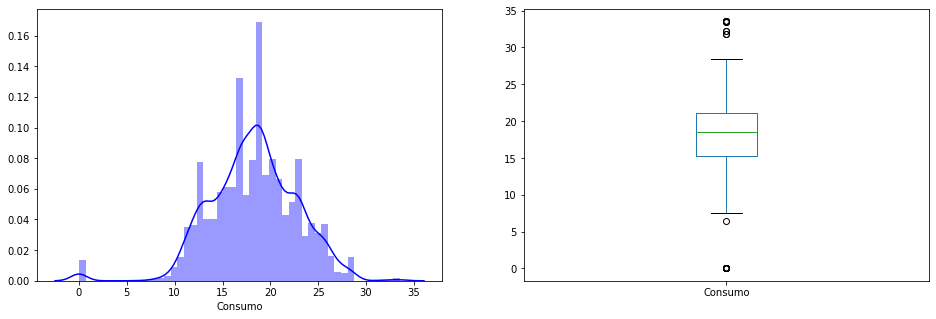

In [33]:
# Consumo
plt.subplot(121)
sns.distplot(car_train_2['Consumo'],color="b");

plt.subplot(122)
car_train_2['Consumo'].plot.box(figsize=(16,5))

plt.savefig("./figures/consumo_dis.png")
plt.show()

In [ ]:
# Motor CC
plt.subplot(121)
sns.distplot(car_train_2['Motor_CC'],color="g");

plt.subplot(122)
car_train_2['Motor_CC'].plot.box(figsize=(16,5))

plt.savefig("./figures/motor_dis.png")
plt.show() 

In [ ]:
# Potencia
plt.subplot(121)
sns.distplot(car_train_2['Potencia'],color="m");

plt.subplot(122)
car_train_2['Potencia'].plot.box(figsize=(16,5))

plt.savefig("./figures/potencia_dis.png")
plt.show() 

### Outliers

In [100]:
features_outliers=['Kilometros', 'Potencia','Consumo','Motor_CC']

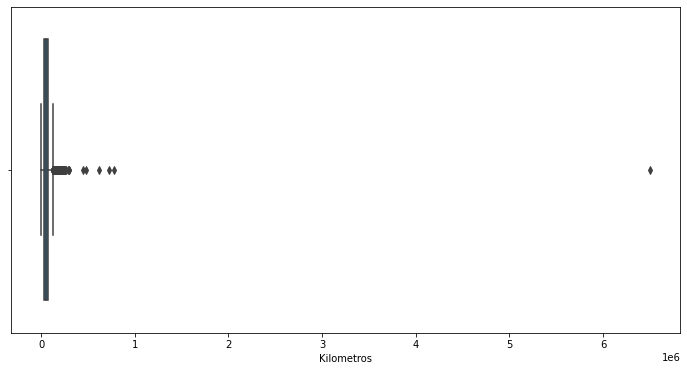

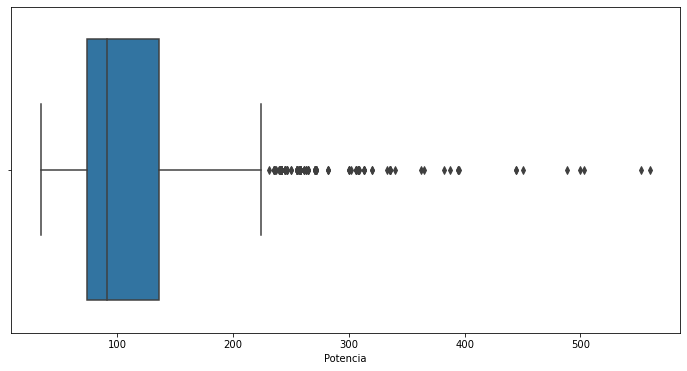

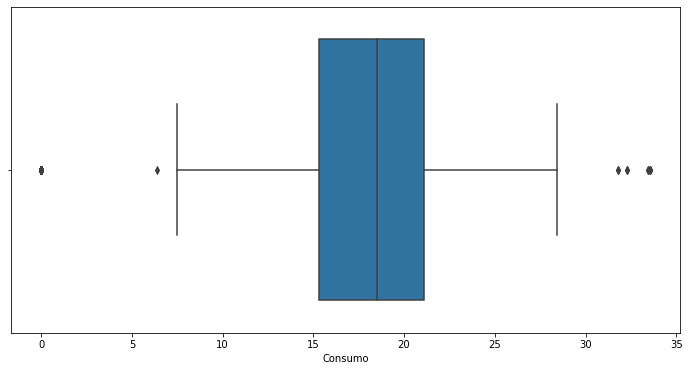

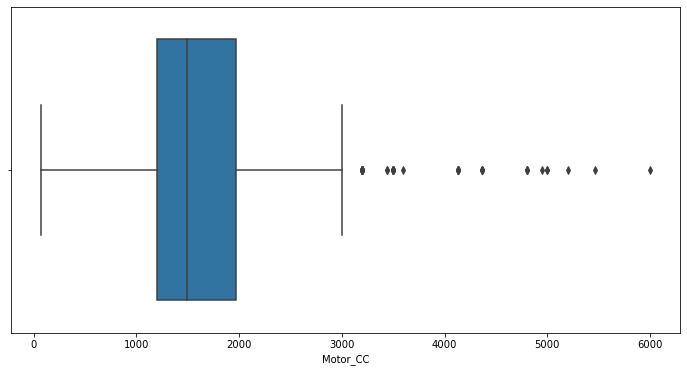

In [101]:
for i in features_outliers:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    #plt.xlim(-10,10)
    sns_plot = sns.boxplot(x=i,data=car_train_2,ax=ax)
    fig = sns_plot.get_figure()
    fig.savefig("./figures/outlier_" + i + ".png")  

In [36]:
for feature in features_outliers:
    print(feature)
    print('max threshold :',car_train_2[feature].quantile(0.999))
    print('min threshold :',car_train_2[feature].quantile(0.001))

Kilometros
max threshold : 451370.00000002445
min threshold : 1000.0
Potencia
max threshold : 456.93420000002664
min threshold : 34.2
Consumo
max threshold : 33.44
min threshold : 0.0
Motor_CC
max threshold : 4959.918000000034
min threshold : 624.0


In [102]:
class RemoveOutliers(BaseEstimator,TransformerMixin):
    """This class removes outliers from data.
    Note: Outlier values are hard coded
    """

    def fit (self,X,y=None):
        return self
    
    
    def transform(self,X,y=None):
        X=X[X['Kilometros'] < 262000] 
            
        X=X[X['Consumo'] > 0.0]
        
        X=X[X['Potencia'] <= 530]
        
        X=X[X['Motor_CC'] <= 5900 ]
        
        return X

In [103]:
car_train_2 = RemoveOutliers().fit_transform(car_train_2)

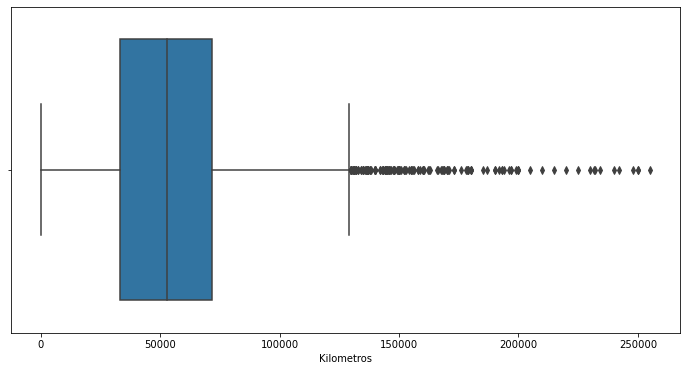

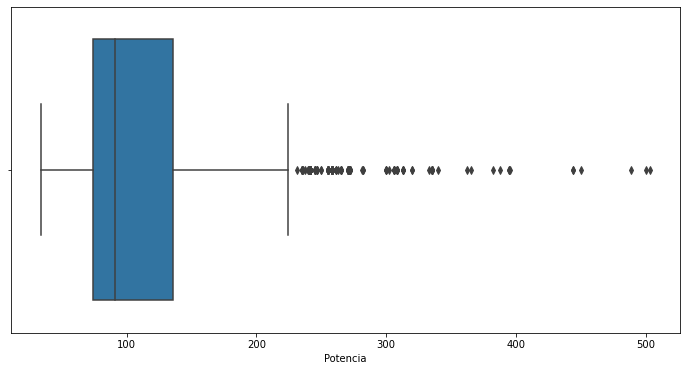

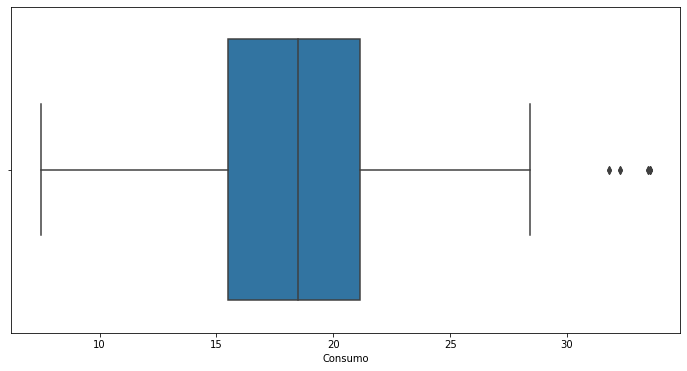

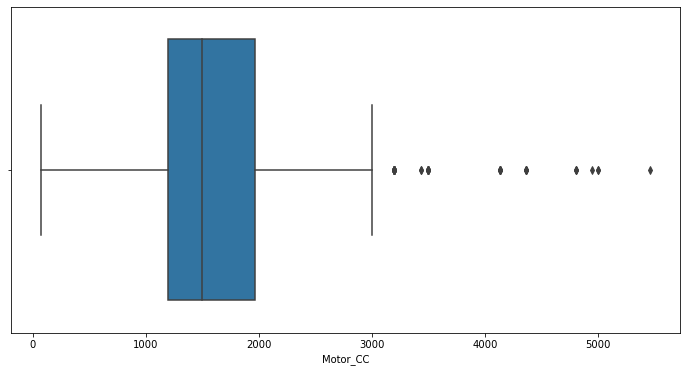

In [104]:
for i in features_outliers:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    #plt.xlim(-10,10)
    sns_plot = sns.boxplot(x=i,data=car_train_2,ax=ax)
    fig = sns_plot.get_figure()
    fig.savefig("./figures/no_outlier_" + i + ".png")  

### Skewed data

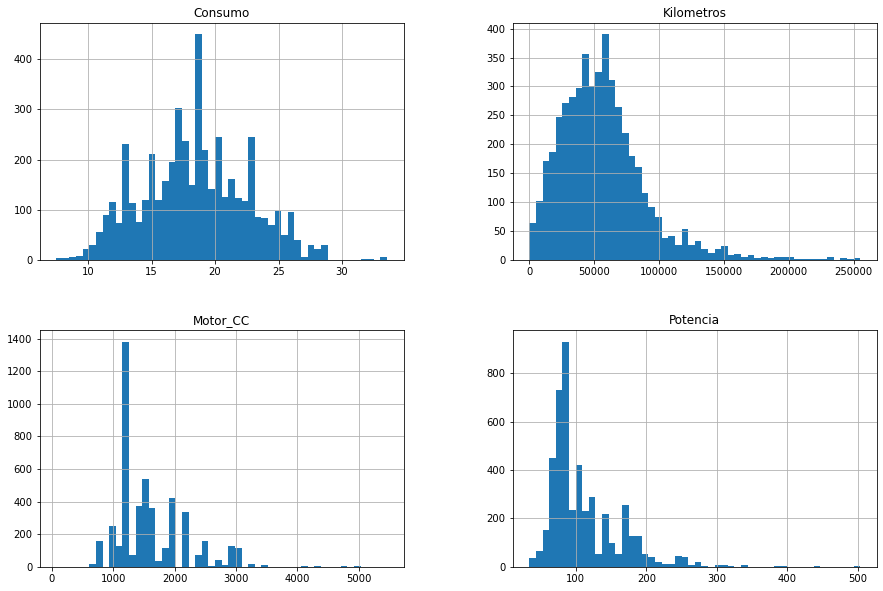

In [105]:
car_train_2[features_outliers].hist(bins=50,figsize=(15,10))

plt.savefig("./figures/skewed_data.png")

In [106]:
skewness=[]
for i in features_outliers:
    skewness.append(car_train_2[i].skew())
pd.DataFrame(data=skewness,index=features_outliers,columns=['skewness']).sort_values(by='skewness',ascending=False)

skewness
Potencia    1.851863
Motor_CC    1.397533
Kilometros  1.369657
Consumo     0.177833

In [42]:
pd.DataFrame(data=skewness,index=features_outliers,columns=['skewness']).sort_values(by='skewness',ascending=False).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  skewness \\\\\n\\midrule\nPotencia   &  1.851863 \\\\\nMotor\\_CC   &  1.397533 \\\\\nKilometros &  1.369657 \\\\\nConsumo    &  0.177833 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [107]:
class FeaturesTransformer(BaseEstimator,TransformerMixin):
    """This class trnsforms numberical featuress in the dataset.
    Note: Transformations are hard coded.
    """
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        from scipy.special import boxcox1p        
        X['Kilometros']=X['Kilometros'].apply(lambda x: boxcox1p(x,0.33))
        
        X['Potencia']=X['Potencia'].apply(lambda x:np.log(x) )
        
        X['Motor_CC']=X['Motor_CC'].apply(lambda x: np.log(x))
        
        X['Consumo']=X['Consumo'].apply(lambda x: np.log1p(x)**4)
        
        return X

In [108]:
car_train_2 = FeaturesTransformer().fit_transform(car_train_2)

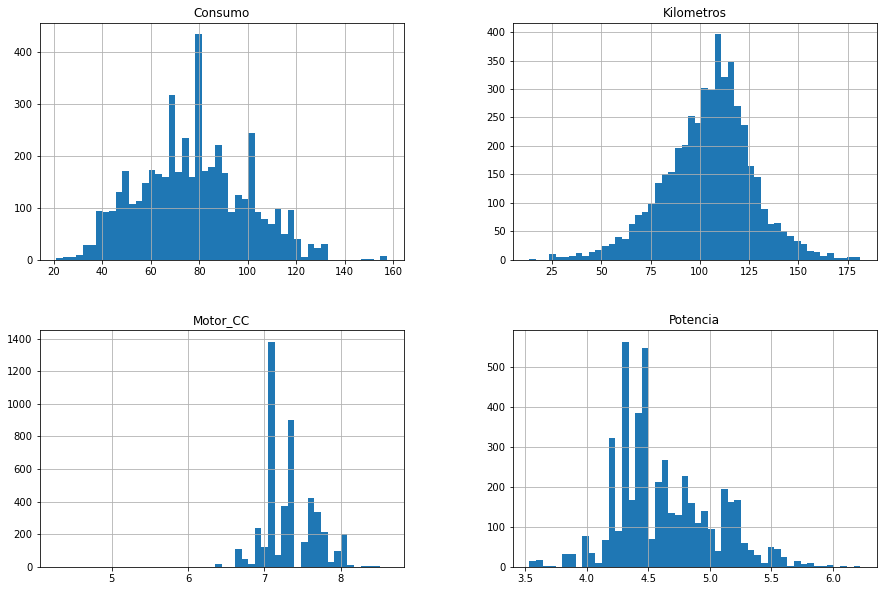

In [109]:
car_train_2[features_outliers].hist(bins=50,figsize=(15,10))
plt.savefig("./figures/no_skewed_data.png")

In [110]:
skewness=[]
for i in features_outliers:
    skewness.append(car_train_2[i].skew())
pd.DataFrame(data=skewness,index=features_outliers,columns=['skewness']).sort_values(by='skewness',ascending=False)

skewness
Potencia    0.540517
Motor_CC    0.303247
Consumo     0.186635
Kilometros -0.275876

In [111]:
pd.DataFrame(data=skewness,index=features_outliers,columns=['skewness']).sort_values(by='skewness',ascending=False).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  skewness \\\\\n\\midrule\nPotencia   &  0.540517 \\\\\nMotor\\_CC   &  0.303247 \\\\\nConsumo    &  0.186635 \\\\\nKilometros & -0.275876 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Ordinal categorical data

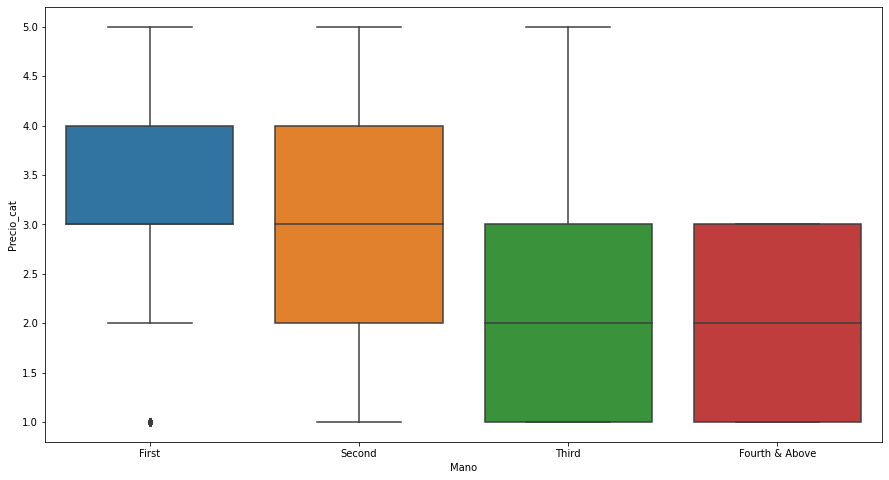

In [46]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize = fig_dims)
sns.boxplot(y = "Precio_cat", x = "Mano", data = car_train_2 )

In [112]:
car_train_2.replace({'First':1,'Second':2,'Third':3,'Fourth & Above':4},inplace = True)

In [113]:
car_train_2_orig = car_train_2.copy()
car_test_2_orig = car_test_2.copy()

In [49]:
car_train_2.dtypes

id              float64
Nombre           object
Ciudad           object
Año             float64
Kilometros      float64
Combustible      object
Tipo_marchas     object
Mano              int64
Consumo         float64
Motor_CC        float64
Potencia        float64
Asientos        float64
Precio_cat        int64
dtype: object

## Dummy variables

In [114]:
tipo_marchas = car_train_2[['Tipo_marchas']]
tipo_marchas = pd.get_dummies(tipo_marchas, drop_first=True)

In [115]:
ciudad = car_train_2[['Ciudad']]
ciudad = pd.get_dummies(ciudad, drop_first=True)

In [116]:
combustible = car_train_2[['Combustible']]
combustible = pd.get_dummies(combustible, drop_first=True)

In [117]:
car_train_2 = pd.concat([car_train_2, ciudad , tipo_marchas, combustible], axis = 1)

In [118]:
car_train_2_orig = car_train_2.copy()
car_test_2_orig = car_test_2.copy()

In [119]:
label = LabelEncoder().fit(pd.read_csv('../data/nombre.csv').Nombre)
car_train_2.Nombre = label.transform(car_train_2_orig.Nombre)
car_test_2.Nombre = label.transform(car_test_2_orig.Nombre)

In [120]:
car_train_2.drop(['Ciudad', 'Combustible', 'Tipo_marchas'], axis = 1, inplace = True)

In [121]:
car_train_2.head()

id  Nombre     Año  Kilometros  Mano     Consumo  Motor_CC  Potencia  \
0  1.0    1143  2012.0  124.256552     1  104.149401  7.129298  4.304065   
1  2.0    1204  2016.0   46.666165     1   88.657334  6.905753  4.205289   
2  3.0     846  2016.0   83.752321     1  114.384147  7.088409  4.343805   
3  4.0     714  2013.0  108.840130     1   77.851719  7.087574  4.382027   
4  5.0     472  2017.0   98.617241     1   78.927010  7.089243  4.485260   

   Asientos  Precio_cat  ...  Ciudad_H  Ciudad_I  Ciudad_J  Ciudad_K  \
0       5.0           3  ...         0         0         0         0   
1       5.0           3  ...         0         1         0         0   
2       6.0           3  ...         0         0         0         0   
3       5.0           3  ...         0         0         0         0   
4       5.0           3  ...         1         0         0         0   

   Ciudad_L  Tipo_marchas_Manual  Combustible_Diesel  Combustible_Electric  \
0         0                    1                   1                     0   
1         0                    1                   0                     0   
2         0                    1                   1                     0   
3         0                    1                   0                     0   
4         0                    1                   0                     0   

   Combustible_LPG  Combustible_Petrol  
0                0                   0  
1                0                   1  
2                0                   0  
3                0                   1  
4                0                   1  

[5 rows x 25 columns]

## Test data

In [122]:
car_test_2 = car_test_2.drop('Descuento',axis=1)

In [123]:
car_test_2['Consumo']=car_test_2.Consumo.astype(str).str.partition()[0].astype('float')
car_test_2['Motor_CC']=car_test_2.Motor_CC.astype(str).str.partition()[0].astype('float')
car_test_2['Potencia']=car_test_2.Potencia.astype(str).str.partition()[0].astype('float')

In [124]:
car_test_2.replace({'First':1,'Second':2,'Third':3,'Fourth & Above':4},inplace = True)

In [125]:
# Tipo_marchas
tipo_marchas = car_test_2[["Tipo_marchas"]]
tipo_marchas = pd.get_dummies(tipo_marchas,drop_first=True)

# ciudad
ciudad = car_test_2[["Ciudad"]]
ciudad = pd.get_dummies(ciudad,drop_first=True)

# Company
#company = car_test_2[["Company"]]
#company = pd.get_dummies(company ,drop_first=True)

# Combustible
combustible = car_test_2[["Combustible"]]
combustible = pd.get_dummies(combustible,drop_first=True)

In [126]:
car_test_2 = pd.concat([car_test_2, ciudad, tipo_marchas, combustible ], axis = 1)

In [127]:
car_test_2.drop(['Tipo_marchas', 'Ciudad', 'Combustible'], axis = 1, inplace = True)

In [64]:
car_test_2.shape

(1159, 23)

In [128]:
# Get missing columns in the training test
missing_cols = set( car_train_2.columns ) - set( car_test_2.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    car_test_2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
car_test_2 = car_test_2[car_train_2.columns]

In [129]:
car_test_2 = car_test_2.drop('Precio_cat', axis=1)

In [130]:
car_train_2 = car_train_2.drop('id', axis=1)

In [131]:
car_test_2.head()

id  Nombre   Año  Kilometros  Mano  Consumo  Motor_CC  Potencia  \
0  4820    1318  2015       77771     1    19.27    2143.0    170.00   
1  4821     695  2011       62000     1    19.81    1086.0     68.05   
2  4822     326  2010      129986     2    20.00    1399.0     68.00   
3  4823    1139  2015       49900     1    20.85    1197.0     83.14   
4  4824    1093  2010       75319     2    21.10    1197.0     85.80   

   Asientos  Ciudad_C  ...  Ciudad_H  Ciudad_I  Ciudad_J  Ciudad_K  Ciudad_L  \
0       5.0         0  ...         1         0         0         0         0   
1       5.0         0  ...         0         0         1         0         0   
2       5.0         1  ...         0         0         0         0         0   
3       5.0         0  ...         0         0         0         0         0   
4       5.0         0  ...         0         0         1         0         0   

   Tipo_marchas_Manual  Combustible_Diesel  Combustible_Electric  \
0                    0                   1                     0   
1                    1                   0                     0   
2                    1                   1                     0   
3                    1                   0                     0   
4                    1                   0                     0   

   Combustible_LPG  Combustible_Petrol  
0                0                   0  
1                0                   1  
2                0                   0  
3                0                   1  
4                0                   1  

[5 rows x 24 columns]

## Construimos modelo

In [132]:
scoring = "accuracy"
N_SPLITS = 5

In [133]:
y = car_train_2['Precio_cat']
X = car_train_2.drop('Precio_cat', axis=1)

In [71]:
Counter(y)

Counter({3: 2201, 2: 592, 4: 977, 5: 742, 1: 250})

In [72]:
Xo, yo = SMOTE(random_state = 42).fit_resample(X, y)
print(Counter(yo))
X_train, X_test, y_train, y_test = train_test_split(Xo, yo, random_state= 42, test_size=0.2)

Counter({3: 2201, 2: 2201, 4: 2201, 5: 2201, 1: 2201})


In [134]:
Xo, yo = RandomOverSampler(random_state = 42).fit_resample(X, y)
print(Counter(yo))
X_train, X_test, y_train, y_test = train_test_split(Xo, yo, random_state= 42, test_size=0.2)

Counter({3: 2201, 2: 2201, 4: 2201, 5: 2201, 1: 2201})


In [135]:
classifier_models(X_train, X_test, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score accuracy 0.7992951448040886 0.010306899036019408
cross_val_score f1 macro  0.7939173489059514 0.010244565868671542
cross_val_score f1 micro  0.7992951448040886 0.010306899036019454
cross_val_score precision macro  0.7942058628657765 0.010628787491706655
cross_val_score precision micro 0.7992951448040886 0.010306899036019408
cross_val_score recall macro  0.798235772123022 0.010303247611530718
cross_val_score recall macro  0.7992951448040886 0.010306899036019408

Accuracy on Training set:  0.892548841435711
Accuracy on Testing set:  0.8241708314402544

ERROR TABLE
accuracy_score        :  0.8241708314402544
f1_score macro        :  0.8211576328131986
f1_score micro        :  0.8241708314402544
precision_score macro :  0.8212398712884875
precision_score micro :  0.8241708314402544
recall_score macro.   :  0.8280949557388997
recall_score micro.   :  0.8241708314402544

DecisionTreeClassifier


CROSS VALIDATION SCORES

cross_va

In [136]:
# StandardScaler
sc = StandardScaler()
X_train_standard = sc.fit_transform(X_train)
X_test_standard = sc.transform(X_test)

In [137]:
classifier_models(X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)

KNeighborsClassifier


CROSS VALIDATION SCORES

cross_val_score accuracy 0.80895113829952 0.007971799184273324
cross_val_score f1 macro  0.8047179902687797 0.007956947373880937
cross_val_score f1 micro  0.8089511382995198 0.007971799184273338
cross_val_score precision macro  0.8049822253651818 0.007140408927444566
cross_val_score precision micro 0.80895113829952 0.007971799184273324
cross_val_score recall macro  0.8079331518554754 0.008004873720073784
cross_val_score recall macro  0.80895113829952 0.007971799184273324

Accuracy on Training set:  0.8997046796910495
Accuracy on Testing set:  0.8346206269877329

ERROR TABLE
accuracy_score        :  0.8346206269877329
f1_score macro        :  0.8339390554227993
f1_score micro        :  0.8346206269877329
precision_score macro :  0.8332127205830924
precision_score micro :  0.8346206269877329
recall_score macro.   :  0.8381826735133023
recall_score micro.   :  0.8346206269877329

DecisionTreeClassifier


CROSS VALIDATION SCORES

cross_val_sc

In [138]:
svm_models(X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)


SVM


linear


CROSS VALIDATION SCORES

cross_val_score accuracy 0.7646525089050643 0.003754635768147845
cross_val_score f1 macro  0.7652541933406368 0.003869319037499727
cross_val_score f1 micro  0.7646525089050642 0.003754635768147804
cross_val_score precision macro  0.7668516250397452 0.003928133751035592
cross_val_score precision micro 0.7646525089050643 0.003754635768147845
cross_val_score recall macro  0.7644941779753802 0.0038015855439629356
cross_val_score recall macro  0.7646525089050643 0.003754635768147845

Accuracy on Training set:  0.7688550658791459
Accuracy on Testing set:  0.7755565651976375

ERROR TABLE
accuracy_score        :  0.7755565651976375
f1_score macro        :  0.7763328068257451
f1_score micro        :  0.7755565651976375
precision_score macro :  0.7764313564657346
precision_score micro :  0.7755565651976375
recall_score macro.   :  0.7762841990099378
recall_score micro.   :  0.7755565651976375

poly


CROSS VALIDATION SCORES

cross_val_score accuracy 0.796

Profundizamos sobre los que han conseguido mejores puntuaciones

### Best Random Forest Classifier

In [139]:
best_rfc_2 = best_tree(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   2.5s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   2.5s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   2.8s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   2.6s
[CV] n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=700, min_samples_split=100, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=4 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=4, total=   3.4s
[CV] n_estimators=900, min_samples_split=5, min

[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.6s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.8s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.6s
[CV] n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3 
[CV]  n_estimators=1100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=3, total=   2.8s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5 
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, total=   1.0s
[CV] n_estimators=300, min_samples_spl

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.9min finished


In [140]:
best_rfc_2.best_params_

{'n_estimators': 400,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9}

In [141]:
best_rfc_2 = RandomForestClassifier(n_estimators = 400, min_samples_split = 15, 
                                  min_samples_leaf = 1, max_features = 'auto', max_depth = 9)

In [142]:
model_report(best_rfc_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.8559751045377112 0.003739439384813975
cross_val_score f1 macro  0.8530634843773747 0.004126639039882841
cross_val_score f1 micro  0.8540441252387589 0.0034797525602779746
cross_val_score precision macro  0.8514855537553954 0.002623431030004517
cross_val_score precision micro 0.8537030225594963 0.004560325538651797
cross_val_score recall macro  0.8529938665114436 0.004946200541830919
cross_val_score recall macro  0.8560879020184812 0.002128804313240798

Accuracy on Training set:  0.8883462062698774
Accuracy on Testing set:  0.8618809631985461

ERROR TABLE
accuracy_score        :  0.8618809631985461
f1_score macro        :  0.8630435968040994
f1_score micro        :  0.861880963198546
precision_score macro :  0.8634492495145001
precision_score micro :  0.8618809631985461
recall_score macro.   :  0.8634417018645589
recall_score micro.   :  0.8618809631985461


### Best SVC

In [ ]:
best_svc_2 = best_svc(X_train_standard, y_train)

In [ ]:
best_svc_2.best_params_

In [ ]:
best_svc_2 = SVC(kernel = 'rbf', gamma = 'auto', C = 100)

In [ ]:
model_report(best_svc_2, X_train_standard, X_test_standard, y_train, y_test, scoring, N_SPLITS)

### Best Extra tree

In [ ]:
best_extra_tree_2 = best_tree(X_train, y_train)

In [ ]:
best_extra_tree_2.best_params_

In [ ]:
best_extra_tree_2 = ExtraTreesClassifier(n_estimators = 400, min_samples_split = 15, min_samples_leaf = 1,
                                         max_features ='auto', max_depth = 9)

In [ ]:
model_report(best_extra_tree_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [ ]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(best_extra_tree_2.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Catboost 

In [143]:
catboost_2 = best_catboost(X_train, y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8546280522
bestIteration = 1191

0:	loss: 0.8546281	best: 0.8546281 (0)	total: 4.68s	remaining: 1m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8620102215
bestIteration = 274

1:	loss: 0.8620102	best: 0.8620102 (1)	total: 6.27s	remaining: 40.8s

bestTest = 0.8642816581
bestIteration = 994

2:	loss: 0.8642817	best: 0.8642817 (2)	total: 10.3s	remaining: 41.3s

bestTest = 0.8801817149
bestIteration = 792

3:	loss: 0.8801817	best: 0.8801817 (3)	total: 14.8s	remaining: 40.6s

bestTest = 0.9176604202
bestIteration = 994

4:	loss: 0.9176604	best: 0.9176604 (4)	total: 20.2s	remaining: 40.4s

bestTest = 0.8972174901
bestIteration = 796

5:	loss: 0.8972175	best: 0.9176604 (4)	total: 31.3s	remaining: 46.9s

bestTest = 0.9386712095
bestIteration = 758

6:	loss: 0.9386712	best: 0.9386712 (6)	total: 41.1s	remaining: 46.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8983532084
bestIteration = 239

7:	loss: 0.8983532	best: 0.9386712 (6)	t

In [145]:
catboost_2['params']

{'depth': 9,
 'one_hot_max_size': 4,
 'iterations': 800,
 'random_strength': 0.1,
 'learning_rate': 0.1,
 'od_type': 'IncToDec'}

In [154]:
catboost_2 = CatBoostClassifier(
    iterations=800,
    learning_rate=0.1,
    one_hot_max_size = 4,
    random_strength=0.1,
    depth=9,
    od_type = 'IncToDec',
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    verbose = 0)

In [155]:
model_report(catboost_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9465010840947808 0.0058778596578264765
cross_val_score f1 macro  0.9456411853272921 0.006010439308183758
cross_val_score f1 micro  0.9465010840947808 0.005877859657826439
cross_val_score precision macro  0.946130308047574 0.005909674859233401
cross_val_score precision micro 0.9465010840947808 0.0058778596578264765
cross_val_score recall macro  0.9460805342529277 0.005890238145525641
cross_val_score recall macro  0.9465010840947808 0.0058778596578264765

Accuracy on Training set:  0.9981826442526125
Accuracy on Testing set:  0.9563834620626988

ERROR TABLE
accuracy_score        :  0.9563834620626988
f1_score macro        :  0.9567045666713405
f1_score micro        :  0.9563834620626988
precision_score macro :  0.9572667259253327
precision_score micro :  0.9563834620626988
recall_score macro.   :  0.9578095072264737
recall_score micro.   :  0.9563834620626988


In [148]:
catboost_2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=7,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    verbose = 0)

In [149]:
model_report(catboost_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9450245857209231 0.007641993868145311
cross_val_score f1 macro  0.9441464027260527 0.007764448623346371
cross_val_score f1 micro  0.9450245857209231 0.007641993868145262
cross_val_score precision macro  0.9447151477919615 0.007798527161485461
cross_val_score precision micro 0.9450245857209231 0.007641993868145311
cross_val_score recall macro  0.9445995733295154 0.007666456314193456
cross_val_score recall macro  0.9450245857209231 0.007641993868145311

Accuracy on Training set:  0.9943207632894139
Accuracy on Testing set:  0.9541117673784644

ERROR TABLE
accuracy_score        :  0.9541117673784644
f1_score macro        :  0.9545329509576457
f1_score micro        :  0.9541117673784644
precision_score macro :  0.9548331349416417
precision_score micro :  0.9541117673784644
recall_score macro.   :  0.9555496494372043
recall_score micro.   :  0.9541117673784644


### XGboost

In [150]:
best_xgboost_2 = best_xgboost(X_train, X_test, y_train, y_test)

{'n_estimators': [100, 181, 263, 345, 427, 509, 590, 672, 754, 836, 918, 1000], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5], 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [3, 4, 5, 6, 7, 8], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [1, 5, 15, 20, 50]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.9, n_estimators=427, min_child_weight=1, max_depth=5, learning_rate=0.1, colsample_bytree=1.0 
[0]	validation_0-mlogloss:1.48042
[1]	validation_0-mlogloss:1.37645
[2]	validation_0-mlogloss:1.28659
[3]	validation_0-mlogloss:1.20976
[4]	validation_0-mlogloss:1.14451
[5]	validation_0-mlogloss:1.08540
[6]	validation_0-mlogloss:1.03248


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[7]	validation_0-mlogloss:0.98727
[8]	validation_0-mlogloss:0.94583
[9]	validation_0-mlogloss:0.90836
[10]	validation_0-mlogloss:0.87471
[11]	validation_0-mlogloss:0.84571
[12]	validation_0-mlogloss:0.81880
[13]	validation_0-mlogloss:0.79381
[14]	validation_0-mlogloss:0.77041
[15]	validation_0-mlogloss:0.74902
[16]	validation_0-mlogloss:0.72768
[17]	validation_0-mlogloss:0.70929
[18]	validation_0-mlogloss:0.69225
[19]	validation_0-mlogloss:0.67539
[20]	validation_0-mlogloss:0.66005
[21]	validation_0-mlogloss:0.64510
[22]	validation_0-mlogloss:0.63198
[23]	validation_0-mlogloss:0.62026
[24]	validation_0-mlogloss:0.60799
[25]	validation_0-mlogloss:0.59725
[26]	validation_0-mlogloss:0.58620
[27]	validation_0-mlogloss:0.57622
[28]	validation_0-mlogloss:0.56731
[29]	validation_0-mlogloss:0.55779
[30]	validation_0-mlogloss:0.54916
[31]	validation_0-mlogloss:0.54103
[32]	validation_0-mlogloss:0.53340
[33]	validation_0-mlogloss:0.52557
[34]	validation_0-mlogloss:0.51864
[35]	validation_0-mlogl

[238]	validation_0-mlogloss:0.20257
[239]	validation_0-mlogloss:0.20216
[240]	validation_0-mlogloss:0.20197
[241]	validation_0-mlogloss:0.20179
[242]	validation_0-mlogloss:0.20137
[243]	validation_0-mlogloss:0.20095
[244]	validation_0-mlogloss:0.20070
[245]	validation_0-mlogloss:0.20044
[246]	validation_0-mlogloss:0.20008
[247]	validation_0-mlogloss:0.19951
[248]	validation_0-mlogloss:0.19935
[249]	validation_0-mlogloss:0.19915
[250]	validation_0-mlogloss:0.19875
[251]	validation_0-mlogloss:0.19845
[252]	validation_0-mlogloss:0.19800
[253]	validation_0-mlogloss:0.19753
[254]	validation_0-mlogloss:0.19730
[255]	validation_0-mlogloss:0.19699
[256]	validation_0-mlogloss:0.19652
[257]	validation_0-mlogloss:0.19620
[258]	validation_0-mlogloss:0.19593
[259]	validation_0-mlogloss:0.19551
[260]	validation_0-mlogloss:0.19543
[261]	validation_0-mlogloss:0.19483
[262]	validation_0-mlogloss:0.19439
[263]	validation_0-mlogloss:0.19420
[264]	validation_0-mlogloss:0.19403
[265]	validation_0-mlogloss:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[7]	validation_0-mlogloss:0.98831
[8]	validation_0-mlogloss:0.94490
[9]	validation_0-mlogloss:0.90760
[10]	validation_0-mlogloss:0.87433
[11]	validation_0-mlogloss:0.84451
[12]	validation_0-mlogloss:0.81753
[13]	validation_0-mlogloss:0.79416
[14]	validation_0-mlogloss:0.77105
[15]	validation_0-mlogloss:0.75000
[16]	validation_0-mlogloss:0.72912
[17]	validation_0-mlogloss:0.71100
[18]	validation_0-mlogloss:0.69485
[19]	validation_0-mlogloss:0.67858
[20]	validation_0-mlogloss:0.66422
[21]	validation_0-mlogloss:0.64968
[22]	validation_0-mlogloss:0.63637
[23]	validation_0-mlogloss:0.62429
[24]	validation_0-mlogloss:0.61262
[25]	validation_0-mlogloss:0.60124
[26]	validation_0-mlogloss:0.59029
[27]	validation_0-mlogloss:0.57963
[28]	validation_0-mlogloss:0.57094
[29]	validation_0-mlogloss:0.56223
[30]	validation_0-mlogloss:0.55355
[31]	validation_0-mlogloss:0.54518
[32]	validation_0-mlogloss:0.53716
[33]	validation_0-mlogloss:0.52962
[34]	validation_0-mlogloss:0.52287
[35]	validation_0-mlogl

[238]	validation_0-mlogloss:0.20306
[239]	validation_0-mlogloss:0.20264
[240]	validation_0-mlogloss:0.20233
[241]	validation_0-mlogloss:0.20198
[242]	validation_0-mlogloss:0.20143
[243]	validation_0-mlogloss:0.20109
[244]	validation_0-mlogloss:0.20092
[245]	validation_0-mlogloss:0.20069
[246]	validation_0-mlogloss:0.20030
[247]	validation_0-mlogloss:0.20001
[248]	validation_0-mlogloss:0.19987
[249]	validation_0-mlogloss:0.19934
[250]	validation_0-mlogloss:0.19925
[251]	validation_0-mlogloss:0.19891
[252]	validation_0-mlogloss:0.19874
[253]	validation_0-mlogloss:0.19861
[254]	validation_0-mlogloss:0.19836
[255]	validation_0-mlogloss:0.19813
[256]	validation_0-mlogloss:0.19795
[257]	validation_0-mlogloss:0.19734
[258]	validation_0-mlogloss:0.19695
[259]	validation_0-mlogloss:0.19653
[260]	validation_0-mlogloss:0.19648
[261]	validation_0-mlogloss:0.19592
[262]	validation_0-mlogloss:0.19564
[263]	validation_0-mlogloss:0.19532
[264]	validation_0-mlogloss:0.19497
[265]	validation_0-mlogloss:

[34]	validation_0-mlogloss:0.51610
[35]	validation_0-mlogloss:0.50910
[36]	validation_0-mlogloss:0.50191
[37]	validation_0-mlogloss:0.49564
[38]	validation_0-mlogloss:0.49001
[39]	validation_0-mlogloss:0.48415
[40]	validation_0-mlogloss:0.47923
[41]	validation_0-mlogloss:0.47299
[42]	validation_0-mlogloss:0.46767
[43]	validation_0-mlogloss:0.46293
[44]	validation_0-mlogloss:0.45748
[45]	validation_0-mlogloss:0.45344
[46]	validation_0-mlogloss:0.44902
[47]	validation_0-mlogloss:0.44500
[48]	validation_0-mlogloss:0.43986
[49]	validation_0-mlogloss:0.43626
[50]	validation_0-mlogloss:0.43182
[51]	validation_0-mlogloss:0.42810
[52]	validation_0-mlogloss:0.42425
[53]	validation_0-mlogloss:0.42110
[54]	validation_0-mlogloss:0.41715
[55]	validation_0-mlogloss:0.41446
[56]	validation_0-mlogloss:0.41063
[57]	validation_0-mlogloss:0.40730
[58]	validation_0-mlogloss:0.40484
[59]	validation_0-mlogloss:0.40135
[60]	validation_0-mlogloss:0.39768
[61]	validation_0-mlogloss:0.39476
[62]	validation_0-ml

[264]	validation_0-mlogloss:0.19519
[265]	validation_0-mlogloss:0.19511
[266]	validation_0-mlogloss:0.19484
[267]	validation_0-mlogloss:0.19476
[268]	validation_0-mlogloss:0.19454
[269]	validation_0-mlogloss:0.19461
[270]	validation_0-mlogloss:0.19434
[271]	validation_0-mlogloss:0.19420
[272]	validation_0-mlogloss:0.19405
[273]	validation_0-mlogloss:0.19370
[274]	validation_0-mlogloss:0.19368
[275]	validation_0-mlogloss:0.19357
[276]	validation_0-mlogloss:0.19330
[277]	validation_0-mlogloss:0.19290
[278]	validation_0-mlogloss:0.19260
[279]	validation_0-mlogloss:0.19243
[280]	validation_0-mlogloss:0.19238
[281]	validation_0-mlogloss:0.19210
[282]	validation_0-mlogloss:0.19190
[283]	validation_0-mlogloss:0.19167
[284]	validation_0-mlogloss:0.19145
[285]	validation_0-mlogloss:0.19118
[286]	validation_0-mlogloss:0.19099
[287]	validation_0-mlogloss:0.19091
[288]	validation_0-mlogloss:0.19070
[289]	validation_0-mlogloss:0.19041
[290]	validation_0-mlogloss:0.19021
[291]	validation_0-mlogloss:

[60]	validation_0-mlogloss:0.39871
[61]	validation_0-mlogloss:0.39573
[62]	validation_0-mlogloss:0.39276
[63]	validation_0-mlogloss:0.38923
[64]	validation_0-mlogloss:0.38631
[65]	validation_0-mlogloss:0.38338
[66]	validation_0-mlogloss:0.38008
[67]	validation_0-mlogloss:0.37782
[68]	validation_0-mlogloss:0.37504
[69]	validation_0-mlogloss:0.37287
[70]	validation_0-mlogloss:0.37055
[71]	validation_0-mlogloss:0.36809
[72]	validation_0-mlogloss:0.36537
[73]	validation_0-mlogloss:0.36300
[74]	validation_0-mlogloss:0.36027
[75]	validation_0-mlogloss:0.35832
[76]	validation_0-mlogloss:0.35563
[77]	validation_0-mlogloss:0.35372
[78]	validation_0-mlogloss:0.35165
[79]	validation_0-mlogloss:0.34971
[80]	validation_0-mlogloss:0.34752
[81]	validation_0-mlogloss:0.34587
[82]	validation_0-mlogloss:0.34342
[83]	validation_0-mlogloss:0.34151
[84]	validation_0-mlogloss:0.33906
[85]	validation_0-mlogloss:0.33710
[86]	validation_0-mlogloss:0.33569
[87]	validation_0-mlogloss:0.33383
[88]	validation_0-ml

[289]	validation_0-mlogloss:0.18326
[290]	validation_0-mlogloss:0.18321
[291]	validation_0-mlogloss:0.18292
[292]	validation_0-mlogloss:0.18270
[293]	validation_0-mlogloss:0.18241
[294]	validation_0-mlogloss:0.18221
[295]	validation_0-mlogloss:0.18221
[296]	validation_0-mlogloss:0.18203
[297]	validation_0-mlogloss:0.18185
[298]	validation_0-mlogloss:0.18145
[299]	validation_0-mlogloss:0.18137
[300]	validation_0-mlogloss:0.18124
[301]	validation_0-mlogloss:0.18105
[302]	validation_0-mlogloss:0.18083
[303]	validation_0-mlogloss:0.18072
[304]	validation_0-mlogloss:0.18067
[305]	validation_0-mlogloss:0.18038
[306]	validation_0-mlogloss:0.18003
[307]	validation_0-mlogloss:0.17987
[308]	validation_0-mlogloss:0.17990
[309]	validation_0-mlogloss:0.17982
[310]	validation_0-mlogloss:0.17959
[311]	validation_0-mlogloss:0.17922
[312]	validation_0-mlogloss:0.17896
[313]	validation_0-mlogloss:0.17880
[314]	validation_0-mlogloss:0.17876
[315]	validation_0-mlogloss:0.17866
[316]	validation_0-mlogloss:

[86]	validation_0-mlogloss:0.32849
[87]	validation_0-mlogloss:0.32608
[88]	validation_0-mlogloss:0.32456
[89]	validation_0-mlogloss:0.32242
[90]	validation_0-mlogloss:0.32041
[91]	validation_0-mlogloss:0.31866
[92]	validation_0-mlogloss:0.31653
[93]	validation_0-mlogloss:0.31490
[94]	validation_0-mlogloss:0.31361
[95]	validation_0-mlogloss:0.31168
[96]	validation_0-mlogloss:0.30994
[97]	validation_0-mlogloss:0.30795
[98]	validation_0-mlogloss:0.30660
[99]	validation_0-mlogloss:0.30444
[100]	validation_0-mlogloss:0.30268
[101]	validation_0-mlogloss:0.30125
[102]	validation_0-mlogloss:0.29973
[103]	validation_0-mlogloss:0.29865
[104]	validation_0-mlogloss:0.29689
[105]	validation_0-mlogloss:0.29550
[106]	validation_0-mlogloss:0.29339
[107]	validation_0-mlogloss:0.29173
[108]	validation_0-mlogloss:0.29082
[109]	validation_0-mlogloss:0.28925
[110]	validation_0-mlogloss:0.28759
[111]	validation_0-mlogloss:0.28619
[112]	validation_0-mlogloss:0.28476
[113]	validation_0-mlogloss:0.28345
[114]	

[314]	validation_0-mlogloss:0.17622
[315]	validation_0-mlogloss:0.17587
[316]	validation_0-mlogloss:0.17581
[317]	validation_0-mlogloss:0.17579
[318]	validation_0-mlogloss:0.17556
[319]	validation_0-mlogloss:0.17547
[320]	validation_0-mlogloss:0.17524
[321]	validation_0-mlogloss:0.17508
[322]	validation_0-mlogloss:0.17486
[323]	validation_0-mlogloss:0.17463
[324]	validation_0-mlogloss:0.17442
[325]	validation_0-mlogloss:0.17430
[326]	validation_0-mlogloss:0.17410
[327]	validation_0-mlogloss:0.17401
[328]	validation_0-mlogloss:0.17386
[329]	validation_0-mlogloss:0.17365
[330]	validation_0-mlogloss:0.17358
[331]	validation_0-mlogloss:0.17342
[332]	validation_0-mlogloss:0.17326
[333]	validation_0-mlogloss:0.17302
[334]	validation_0-mlogloss:0.17298
[335]	validation_0-mlogloss:0.17285
[336]	validation_0-mlogloss:0.17258
[337]	validation_0-mlogloss:0.17254
[338]	validation_0-mlogloss:0.17255
[339]	validation_0-mlogloss:0.17255
[340]	validation_0-mlogloss:0.17238
[341]	validation_0-mlogloss:

[111]	validation_0-mlogloss:0.33887
[112]	validation_0-mlogloss:0.33815
[113]	validation_0-mlogloss:0.33827
[114]	validation_0-mlogloss:0.33744
[115]	validation_0-mlogloss:0.33738
[116]	validation_0-mlogloss:0.33655
[117]	validation_0-mlogloss:0.33618
[118]	validation_0-mlogloss:0.33593
[119]	validation_0-mlogloss:0.33517
[120]	validation_0-mlogloss:0.33466
[121]	validation_0-mlogloss:0.33356
[122]	validation_0-mlogloss:0.33294
[123]	validation_0-mlogloss:0.33231
[124]	validation_0-mlogloss:0.33187
[125]	validation_0-mlogloss:0.33181
[126]	validation_0-mlogloss:0.33138
[127]	validation_0-mlogloss:0.33100
[128]	validation_0-mlogloss:0.33012
[129]	validation_0-mlogloss:0.32967
[130]	validation_0-mlogloss:0.32912
[131]	validation_0-mlogloss:0.32814
[132]	validation_0-mlogloss:0.32798
[133]	validation_0-mlogloss:0.32736
[134]	validation_0-mlogloss:0.32686
[135]	validation_0-mlogloss:0.32668
[136]	validation_0-mlogloss:0.32628
[137]	validation_0-mlogloss:0.32605
[138]	validation_0-mlogloss:

[339]	validation_0-mlogloss:0.27334
[340]	validation_0-mlogloss:0.27305
[341]	validation_0-mlogloss:0.27313
[342]	validation_0-mlogloss:0.27340
[343]	validation_0-mlogloss:0.27348
[344]	validation_0-mlogloss:0.27300
[CV]  subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0, total=   7.2s
[CV] subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0 
[0]	validation_0-mlogloss:1.28517
[1]	validation_0-mlogloss:1.10311
[2]	validation_0-mlogloss:0.97896
[3]	validation_0-mlogloss:0.89312
[4]	validation_0-mlogloss:0.82381
[5]	validation_0-mlogloss:0.76845
[6]	validation_0-mlogloss:0.72702
[7]	validation_0-mlogloss:0.69129
[8]	validation_0-mlogloss:0.66164
[9]	validation_0-mlogloss:0.63514
[10]	validation_0-mlogloss:0.61671
[11]	validation_0-mlogloss:0.59788
[12]	validation_0-mlogloss:0.57963
[13]	validation_0-mlogloss:0.56357
[14]	validation_0-mlogloss:0.54831
[15]	validation_0-mlogloss:0

[218]	validation_0-mlogloss:0.29756
[219]	validation_0-mlogloss:0.29711
[220]	validation_0-mlogloss:0.29717
[221]	validation_0-mlogloss:0.29666
[222]	validation_0-mlogloss:0.29594
[223]	validation_0-mlogloss:0.29563
[224]	validation_0-mlogloss:0.29549
[225]	validation_0-mlogloss:0.29528
[226]	validation_0-mlogloss:0.29474
[227]	validation_0-mlogloss:0.29460
[228]	validation_0-mlogloss:0.29470
[229]	validation_0-mlogloss:0.29395
[230]	validation_0-mlogloss:0.29359
[231]	validation_0-mlogloss:0.29378
[232]	validation_0-mlogloss:0.29387
[233]	validation_0-mlogloss:0.29390
[234]	validation_0-mlogloss:0.29333
[235]	validation_0-mlogloss:0.29298
[236]	validation_0-mlogloss:0.29312
[237]	validation_0-mlogloss:0.29288
[238]	validation_0-mlogloss:0.29238
[239]	validation_0-mlogloss:0.29219
[240]	validation_0-mlogloss:0.29191
[241]	validation_0-mlogloss:0.29128
[242]	validation_0-mlogloss:0.29132
[243]	validation_0-mlogloss:0.29138
[244]	validation_0-mlogloss:0.29099
[245]	validation_0-mlogloss:

[97]	validation_0-mlogloss:0.34795
[98]	validation_0-mlogloss:0.34787
[99]	validation_0-mlogloss:0.34712
[100]	validation_0-mlogloss:0.34612
[101]	validation_0-mlogloss:0.34484
[102]	validation_0-mlogloss:0.34464
[103]	validation_0-mlogloss:0.34358
[104]	validation_0-mlogloss:0.34276
[105]	validation_0-mlogloss:0.34200
[106]	validation_0-mlogloss:0.34197
[107]	validation_0-mlogloss:0.34074
[108]	validation_0-mlogloss:0.33968
[109]	validation_0-mlogloss:0.33859
[110]	validation_0-mlogloss:0.33857
[111]	validation_0-mlogloss:0.33812
[112]	validation_0-mlogloss:0.33741
[113]	validation_0-mlogloss:0.33680
[114]	validation_0-mlogloss:0.33618
[115]	validation_0-mlogloss:0.33500
[116]	validation_0-mlogloss:0.33462
[117]	validation_0-mlogloss:0.33397
[118]	validation_0-mlogloss:0.33330
[119]	validation_0-mlogloss:0.33299
[120]	validation_0-mlogloss:0.33290
[121]	validation_0-mlogloss:0.33203
[122]	validation_0-mlogloss:0.33093
[123]	validation_0-mlogloss:0.32990
[124]	validation_0-mlogloss:0.3

[325]	validation_0-mlogloss:0.27565
[326]	validation_0-mlogloss:0.27529
[327]	validation_0-mlogloss:0.27520
[328]	validation_0-mlogloss:0.27520
[329]	validation_0-mlogloss:0.27547
[330]	validation_0-mlogloss:0.27497
[331]	validation_0-mlogloss:0.27451
[332]	validation_0-mlogloss:0.27398
[333]	validation_0-mlogloss:0.27408
[334]	validation_0-mlogloss:0.27324
[335]	validation_0-mlogloss:0.27348
[336]	validation_0-mlogloss:0.27331
[337]	validation_0-mlogloss:0.27348
[338]	validation_0-mlogloss:0.27374
[339]	validation_0-mlogloss:0.27354
[340]	validation_0-mlogloss:0.27310
[341]	validation_0-mlogloss:0.27310
[342]	validation_0-mlogloss:0.27289
[343]	validation_0-mlogloss:0.27270
[344]	validation_0-mlogloss:0.27207
[CV]  subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0, total=   7.0s
[CV] subsample=0.7, n_estimators=345, min_child_weight=50, max_depth=7, learning_rate=0.3, colsample_bytree=1.0 
[0]	validation_0-mlogloss:1.28612
[1]	v

[204]	validation_0-mlogloss:0.29827
[205]	validation_0-mlogloss:0.29824
[206]	validation_0-mlogloss:0.29788
[207]	validation_0-mlogloss:0.29772
[208]	validation_0-mlogloss:0.29697
[209]	validation_0-mlogloss:0.29649
[210]	validation_0-mlogloss:0.29657
[211]	validation_0-mlogloss:0.29652
[212]	validation_0-mlogloss:0.29652
[213]	validation_0-mlogloss:0.29677
[214]	validation_0-mlogloss:0.29643
[215]	validation_0-mlogloss:0.29678
[216]	validation_0-mlogloss:0.29640
[217]	validation_0-mlogloss:0.29629
[218]	validation_0-mlogloss:0.29626
[219]	validation_0-mlogloss:0.29617
[220]	validation_0-mlogloss:0.29595
[221]	validation_0-mlogloss:0.29606
[222]	validation_0-mlogloss:0.29517
[223]	validation_0-mlogloss:0.29484
[224]	validation_0-mlogloss:0.29459
[225]	validation_0-mlogloss:0.29448
[226]	validation_0-mlogloss:0.29426
[227]	validation_0-mlogloss:0.29387
[228]	validation_0-mlogloss:0.29372
[229]	validation_0-mlogloss:0.29326
[230]	validation_0-mlogloss:0.29273
[231]	validation_0-mlogloss:

[83]	validation_0-mlogloss:0.35700
[84]	validation_0-mlogloss:0.35602
[85]	validation_0-mlogloss:0.35430
[86]	validation_0-mlogloss:0.35354
[87]	validation_0-mlogloss:0.35256
[88]	validation_0-mlogloss:0.35144
[89]	validation_0-mlogloss:0.35074
[90]	validation_0-mlogloss:0.34904
[91]	validation_0-mlogloss:0.34872
[92]	validation_0-mlogloss:0.34808
[93]	validation_0-mlogloss:0.34734
[94]	validation_0-mlogloss:0.34635
[95]	validation_0-mlogloss:0.34555
[96]	validation_0-mlogloss:0.34556
[97]	validation_0-mlogloss:0.34434
[98]	validation_0-mlogloss:0.34318
[99]	validation_0-mlogloss:0.34172
[100]	validation_0-mlogloss:0.34101
[101]	validation_0-mlogloss:0.34014
[102]	validation_0-mlogloss:0.33946
[103]	validation_0-mlogloss:0.33867
[104]	validation_0-mlogloss:0.33826
[105]	validation_0-mlogloss:0.33819
[106]	validation_0-mlogloss:0.33777
[107]	validation_0-mlogloss:0.33684
[108]	validation_0-mlogloss:0.33606
[109]	validation_0-mlogloss:0.33503
[110]	validation_0-mlogloss:0.33345
[111]	val

[312]	validation_0-mlogloss:0.27177
[313]	validation_0-mlogloss:0.27178
[314]	validation_0-mlogloss:0.27193
[315]	validation_0-mlogloss:0.27153
[316]	validation_0-mlogloss:0.27149
[317]	validation_0-mlogloss:0.27127
[318]	validation_0-mlogloss:0.27078
[319]	validation_0-mlogloss:0.27088
[320]	validation_0-mlogloss:0.27074
[321]	validation_0-mlogloss:0.27029
[322]	validation_0-mlogloss:0.27048
[323]	validation_0-mlogloss:0.26989
[324]	validation_0-mlogloss:0.26944
[325]	validation_0-mlogloss:0.26969
[326]	validation_0-mlogloss:0.26934
[327]	validation_0-mlogloss:0.26904
[328]	validation_0-mlogloss:0.26911
[329]	validation_0-mlogloss:0.26898
[330]	validation_0-mlogloss:0.26907
[331]	validation_0-mlogloss:0.26906
[332]	validation_0-mlogloss:0.26888
[333]	validation_0-mlogloss:0.26888
[334]	validation_0-mlogloss:0.26914
[335]	validation_0-mlogloss:0.26878
[336]	validation_0-mlogloss:0.26838
[337]	validation_0-mlogloss:0.26820
[338]	validation_0-mlogloss:0.26848
[339]	validation_0-mlogloss:

[4]	validation_0-mlogloss:1.02758
[5]	validation_0-mlogloss:0.96988
[6]	validation_0-mlogloss:0.91958
[7]	validation_0-mlogloss:0.88658
[8]	validation_0-mlogloss:0.85056
[9]	validation_0-mlogloss:0.81755
[10]	validation_0-mlogloss:0.79148
[11]	validation_0-mlogloss:0.77017
[12]	validation_0-mlogloss:0.75025
[13]	validation_0-mlogloss:0.73060
[14]	validation_0-mlogloss:0.71312
[15]	validation_0-mlogloss:0.69622
[16]	validation_0-mlogloss:0.68244
[17]	validation_0-mlogloss:0.66837
[18]	validation_0-mlogloss:0.65481
[19]	validation_0-mlogloss:0.64444
[20]	validation_0-mlogloss:0.63498
[21]	validation_0-mlogloss:0.62431
[22]	validation_0-mlogloss:0.61527
[23]	validation_0-mlogloss:0.60827
[24]	validation_0-mlogloss:0.59876
[25]	validation_0-mlogloss:0.59209
[26]	validation_0-mlogloss:0.58505
[27]	validation_0-mlogloss:0.57864
[28]	validation_0-mlogloss:0.57355
[29]	validation_0-mlogloss:0.56695
[30]	validation_0-mlogloss:0.56066
[31]	validation_0-mlogloss:0.55650
[32]	validation_0-mlogloss

[49]	validation_0-mlogloss:0.47853
[50]	validation_0-mlogloss:0.47480
[51]	validation_0-mlogloss:0.47205
[52]	validation_0-mlogloss:0.46905
[53]	validation_0-mlogloss:0.46649
[54]	validation_0-mlogloss:0.46357
[55]	validation_0-mlogloss:0.46044
[56]	validation_0-mlogloss:0.45803
[57]	validation_0-mlogloss:0.45531
[58]	validation_0-mlogloss:0.45295
[59]	validation_0-mlogloss:0.45045
[60]	validation_0-mlogloss:0.44817
[61]	validation_0-mlogloss:0.44618
[62]	validation_0-mlogloss:0.44372
[63]	validation_0-mlogloss:0.44103
[64]	validation_0-mlogloss:0.43868
[65]	validation_0-mlogloss:0.43676
[66]	validation_0-mlogloss:0.43447
[67]	validation_0-mlogloss:0.43189
[68]	validation_0-mlogloss:0.42823
[69]	validation_0-mlogloss:0.42651
[70]	validation_0-mlogloss:0.42516
[71]	validation_0-mlogloss:0.42294
[72]	validation_0-mlogloss:0.42056
[73]	validation_0-mlogloss:0.41876
[74]	validation_0-mlogloss:0.41639
[75]	validation_0-mlogloss:0.41440
[76]	validation_0-mlogloss:0.41248
[77]	validation_0-ml

[94]	validation_0-mlogloss:0.37402
[95]	validation_0-mlogloss:0.37189
[96]	validation_0-mlogloss:0.37070
[97]	validation_0-mlogloss:0.36903
[98]	validation_0-mlogloss:0.36752
[99]	validation_0-mlogloss:0.36626
[100]	validation_0-mlogloss:0.36425
[101]	validation_0-mlogloss:0.36264
[102]	validation_0-mlogloss:0.36100
[103]	validation_0-mlogloss:0.35937
[104]	validation_0-mlogloss:0.35837
[105]	validation_0-mlogloss:0.35704
[106]	validation_0-mlogloss:0.35595
[107]	validation_0-mlogloss:0.35447
[108]	validation_0-mlogloss:0.35408
[109]	validation_0-mlogloss:0.35279
[110]	validation_0-mlogloss:0.35157
[111]	validation_0-mlogloss:0.35016
[112]	validation_0-mlogloss:0.34859
[113]	validation_0-mlogloss:0.34781
[114]	validation_0-mlogloss:0.34648
[115]	validation_0-mlogloss:0.34502
[116]	validation_0-mlogloss:0.34351
[117]	validation_0-mlogloss:0.34238
[118]	validation_0-mlogloss:0.34115
[119]	validation_0-mlogloss:0.34027
[120]	validation_0-mlogloss:0.33894
[121]	validation_0-mlogloss:0.3376

[138]	validation_0-mlogloss:0.31888
[139]	validation_0-mlogloss:0.31790
[140]	validation_0-mlogloss:0.31696
[141]	validation_0-mlogloss:0.31585
[142]	validation_0-mlogloss:0.31492
[143]	validation_0-mlogloss:0.31361
[144]	validation_0-mlogloss:0.31298
[145]	validation_0-mlogloss:0.31230
[146]	validation_0-mlogloss:0.31164
[147]	validation_0-mlogloss:0.31082
[148]	validation_0-mlogloss:0.30969
[149]	validation_0-mlogloss:0.30926
[150]	validation_0-mlogloss:0.30813
[151]	validation_0-mlogloss:0.30736
[152]	validation_0-mlogloss:0.30685
[153]	validation_0-mlogloss:0.30614
[154]	validation_0-mlogloss:0.30471
[155]	validation_0-mlogloss:0.30365
[156]	validation_0-mlogloss:0.30261
[157]	validation_0-mlogloss:0.30188
[158]	validation_0-mlogloss:0.30094
[159]	validation_0-mlogloss:0.30054
[160]	validation_0-mlogloss:0.29972
[161]	validation_0-mlogloss:0.29858
[162]	validation_0-mlogloss:0.29815
[163]	validation_0-mlogloss:0.29732
[164]	validation_0-mlogloss:0.29658
[165]	validation_0-mlogloss:

[181]	validation_0-mlogloss:0.36872
[182]	validation_0-mlogloss:0.36798
[183]	validation_0-mlogloss:0.36715
[184]	validation_0-mlogloss:0.36652
[185]	validation_0-mlogloss:0.36554
[186]	validation_0-mlogloss:0.36494
[187]	validation_0-mlogloss:0.36408
[188]	validation_0-mlogloss:0.36323
[189]	validation_0-mlogloss:0.36231
[190]	validation_0-mlogloss:0.36172
[191]	validation_0-mlogloss:0.36118
[192]	validation_0-mlogloss:0.36042
[193]	validation_0-mlogloss:0.35995
[194]	validation_0-mlogloss:0.35922
[195]	validation_0-mlogloss:0.35884
[196]	validation_0-mlogloss:0.35802
[197]	validation_0-mlogloss:0.35740
[198]	validation_0-mlogloss:0.35662
[199]	validation_0-mlogloss:0.35599
[200]	validation_0-mlogloss:0.35548
[201]	validation_0-mlogloss:0.35474
[202]	validation_0-mlogloss:0.35428
[203]	validation_0-mlogloss:0.35344
[204]	validation_0-mlogloss:0.35248
[205]	validation_0-mlogloss:0.35195
[206]	validation_0-mlogloss:0.35116
[207]	validation_0-mlogloss:0.35054
[208]	validation_0-mlogloss:

[409]	validation_0-mlogloss:0.27664
[410]	validation_0-mlogloss:0.27634
[411]	validation_0-mlogloss:0.27614
[412]	validation_0-mlogloss:0.27607
[413]	validation_0-mlogloss:0.27583
[414]	validation_0-mlogloss:0.27569
[415]	validation_0-mlogloss:0.27543
[416]	validation_0-mlogloss:0.27519
[417]	validation_0-mlogloss:0.27501
[418]	validation_0-mlogloss:0.27483
[419]	validation_0-mlogloss:0.27460
[420]	validation_0-mlogloss:0.27437
[421]	validation_0-mlogloss:0.27420
[422]	validation_0-mlogloss:0.27392
[423]	validation_0-mlogloss:0.27374
[424]	validation_0-mlogloss:0.27354
[425]	validation_0-mlogloss:0.27338
[426]	validation_0-mlogloss:0.27314
[427]	validation_0-mlogloss:0.27306
[428]	validation_0-mlogloss:0.27283
[429]	validation_0-mlogloss:0.27254
[430]	validation_0-mlogloss:0.27234
[431]	validation_0-mlogloss:0.27219
[432]	validation_0-mlogloss:0.27210
[433]	validation_0-mlogloss:0.27186
[434]	validation_0-mlogloss:0.27169
[435]	validation_0-mlogloss:0.27153
[436]	validation_0-mlogloss:

[637]	validation_0-mlogloss:0.24412
[638]	validation_0-mlogloss:0.24398
[639]	validation_0-mlogloss:0.24399
[640]	validation_0-mlogloss:0.24386
[641]	validation_0-mlogloss:0.24378
[642]	validation_0-mlogloss:0.24368
[643]	validation_0-mlogloss:0.24352
[644]	validation_0-mlogloss:0.24347
[645]	validation_0-mlogloss:0.24346
[646]	validation_0-mlogloss:0.24338
[647]	validation_0-mlogloss:0.24334
[648]	validation_0-mlogloss:0.24329
[649]	validation_0-mlogloss:0.24320
[650]	validation_0-mlogloss:0.24317
[651]	validation_0-mlogloss:0.24315
[652]	validation_0-mlogloss:0.24307
[653]	validation_0-mlogloss:0.24303
[654]	validation_0-mlogloss:0.24295
[655]	validation_0-mlogloss:0.24283
[656]	validation_0-mlogloss:0.24281
[657]	validation_0-mlogloss:0.24271
[658]	validation_0-mlogloss:0.24268
[659]	validation_0-mlogloss:0.24262
[660]	validation_0-mlogloss:0.24250
[661]	validation_0-mlogloss:0.24239
[662]	validation_0-mlogloss:0.24227
[663]	validation_0-mlogloss:0.24218
[664]	validation_0-mlogloss:

[107]	validation_0-mlogloss:0.43728
[108]	validation_0-mlogloss:0.43591
[109]	validation_0-mlogloss:0.43423
[110]	validation_0-mlogloss:0.43313
[111]	validation_0-mlogloss:0.43151
[112]	validation_0-mlogloss:0.43002
[113]	validation_0-mlogloss:0.42849
[114]	validation_0-mlogloss:0.42664
[115]	validation_0-mlogloss:0.42529
[116]	validation_0-mlogloss:0.42390
[117]	validation_0-mlogloss:0.42240
[118]	validation_0-mlogloss:0.42110
[119]	validation_0-mlogloss:0.41972
[120]	validation_0-mlogloss:0.41854
[121]	validation_0-mlogloss:0.41725
[122]	validation_0-mlogloss:0.41582
[123]	validation_0-mlogloss:0.41432
[124]	validation_0-mlogloss:0.41293
[125]	validation_0-mlogloss:0.41160
[126]	validation_0-mlogloss:0.40999
[127]	validation_0-mlogloss:0.40874
[128]	validation_0-mlogloss:0.40736
[129]	validation_0-mlogloss:0.40610
[130]	validation_0-mlogloss:0.40487
[131]	validation_0-mlogloss:0.40366
[132]	validation_0-mlogloss:0.40262
[133]	validation_0-mlogloss:0.40137
[134]	validation_0-mlogloss:

[335]	validation_0-mlogloss:0.29076
[336]	validation_0-mlogloss:0.29048
[337]	validation_0-mlogloss:0.29011
[338]	validation_0-mlogloss:0.28974
[339]	validation_0-mlogloss:0.28948
[340]	validation_0-mlogloss:0.28922
[341]	validation_0-mlogloss:0.28905
[342]	validation_0-mlogloss:0.28879
[343]	validation_0-mlogloss:0.28849
[344]	validation_0-mlogloss:0.28831
[345]	validation_0-mlogloss:0.28810
[346]	validation_0-mlogloss:0.28782
[347]	validation_0-mlogloss:0.28750
[348]	validation_0-mlogloss:0.28726
[349]	validation_0-mlogloss:0.28714
[350]	validation_0-mlogloss:0.28686
[351]	validation_0-mlogloss:0.28660
[352]	validation_0-mlogloss:0.28637
[353]	validation_0-mlogloss:0.28619
[354]	validation_0-mlogloss:0.28593
[355]	validation_0-mlogloss:0.28575
[356]	validation_0-mlogloss:0.28553
[357]	validation_0-mlogloss:0.28528
[358]	validation_0-mlogloss:0.28508
[359]	validation_0-mlogloss:0.28467
[360]	validation_0-mlogloss:0.28447
[361]	validation_0-mlogloss:0.28421
[362]	validation_0-mlogloss:

[563]	validation_0-mlogloss:0.25055
[564]	validation_0-mlogloss:0.25041
[565]	validation_0-mlogloss:0.25026
[566]	validation_0-mlogloss:0.25006
[567]	validation_0-mlogloss:0.24996
[568]	validation_0-mlogloss:0.24977
[569]	validation_0-mlogloss:0.24973
[570]	validation_0-mlogloss:0.24961
[571]	validation_0-mlogloss:0.24949
[572]	validation_0-mlogloss:0.24942
[573]	validation_0-mlogloss:0.24934
[574]	validation_0-mlogloss:0.24924
[575]	validation_0-mlogloss:0.24910
[576]	validation_0-mlogloss:0.24907
[577]	validation_0-mlogloss:0.24900
[578]	validation_0-mlogloss:0.24889
[579]	validation_0-mlogloss:0.24882
[580]	validation_0-mlogloss:0.24865
[581]	validation_0-mlogloss:0.24852
[582]	validation_0-mlogloss:0.24841
[583]	validation_0-mlogloss:0.24831
[584]	validation_0-mlogloss:0.24820
[585]	validation_0-mlogloss:0.24812
[586]	validation_0-mlogloss:0.24801
[587]	validation_0-mlogloss:0.24788
[588]	validation_0-mlogloss:0.24782
[589]	validation_0-mlogloss:0.24773
[590]	validation_0-mlogloss:

[31]	validation_0-mlogloss:0.75183
[32]	validation_0-mlogloss:0.74253
[33]	validation_0-mlogloss:0.73283
[34]	validation_0-mlogloss:0.72337
[35]	validation_0-mlogloss:0.71417
[36]	validation_0-mlogloss:0.70508
[37]	validation_0-mlogloss:0.69654
[38]	validation_0-mlogloss:0.68837
[39]	validation_0-mlogloss:0.68037
[40]	validation_0-mlogloss:0.67270
[41]	validation_0-mlogloss:0.66570
[42]	validation_0-mlogloss:0.65867
[43]	validation_0-mlogloss:0.65203
[44]	validation_0-mlogloss:0.64601
[45]	validation_0-mlogloss:0.64000
[46]	validation_0-mlogloss:0.63363
[47]	validation_0-mlogloss:0.62793
[48]	validation_0-mlogloss:0.62216
[49]	validation_0-mlogloss:0.61670
[50]	validation_0-mlogloss:0.61116
[51]	validation_0-mlogloss:0.60614
[52]	validation_0-mlogloss:0.60125
[53]	validation_0-mlogloss:0.59602
[54]	validation_0-mlogloss:0.59086
[55]	validation_0-mlogloss:0.58619
[56]	validation_0-mlogloss:0.58135
[57]	validation_0-mlogloss:0.57662
[58]	validation_0-mlogloss:0.57241
[59]	validation_0-ml

[261]	validation_0-mlogloss:0.31348
[262]	validation_0-mlogloss:0.31316
[263]	validation_0-mlogloss:0.31266
[264]	validation_0-mlogloss:0.31211
[265]	validation_0-mlogloss:0.31187
[266]	validation_0-mlogloss:0.31144
[267]	validation_0-mlogloss:0.31113
[268]	validation_0-mlogloss:0.31069
[269]	validation_0-mlogloss:0.31033
[270]	validation_0-mlogloss:0.30991
[271]	validation_0-mlogloss:0.30951
[272]	validation_0-mlogloss:0.30912
[273]	validation_0-mlogloss:0.30867
[274]	validation_0-mlogloss:0.30820
[275]	validation_0-mlogloss:0.30779
[276]	validation_0-mlogloss:0.30741
[277]	validation_0-mlogloss:0.30704
[278]	validation_0-mlogloss:0.30670
[279]	validation_0-mlogloss:0.30633
[280]	validation_0-mlogloss:0.30595
[281]	validation_0-mlogloss:0.30551
[282]	validation_0-mlogloss:0.30519
[283]	validation_0-mlogloss:0.30458
[284]	validation_0-mlogloss:0.30402
[285]	validation_0-mlogloss:0.30384
[286]	validation_0-mlogloss:0.30344
[287]	validation_0-mlogloss:0.30320
[288]	validation_0-mlogloss:

[489]	validation_0-mlogloss:0.25964
[490]	validation_0-mlogloss:0.25955
[491]	validation_0-mlogloss:0.25942
[492]	validation_0-mlogloss:0.25934
[493]	validation_0-mlogloss:0.25922
[494]	validation_0-mlogloss:0.25904
[495]	validation_0-mlogloss:0.25890
[496]	validation_0-mlogloss:0.25890
[497]	validation_0-mlogloss:0.25868
[498]	validation_0-mlogloss:0.25860
[499]	validation_0-mlogloss:0.25849
[500]	validation_0-mlogloss:0.25835
[501]	validation_0-mlogloss:0.25824
[502]	validation_0-mlogloss:0.25815
[503]	validation_0-mlogloss:0.25806
[504]	validation_0-mlogloss:0.25798
[505]	validation_0-mlogloss:0.25792
[506]	validation_0-mlogloss:0.25787
[507]	validation_0-mlogloss:0.25771
[508]	validation_0-mlogloss:0.25761
[509]	validation_0-mlogloss:0.25754
[510]	validation_0-mlogloss:0.25738
[511]	validation_0-mlogloss:0.25719
[512]	validation_0-mlogloss:0.25712
[513]	validation_0-mlogloss:0.25697
[514]	validation_0-mlogloss:0.25683
[515]	validation_0-mlogloss:0.25669
[516]	validation_0-mlogloss:

[717]	validation_0-mlogloss:0.23718
[718]	validation_0-mlogloss:0.23702
[719]	validation_0-mlogloss:0.23696
[720]	validation_0-mlogloss:0.23689
[721]	validation_0-mlogloss:0.23680
[722]	validation_0-mlogloss:0.23664
[723]	validation_0-mlogloss:0.23657
[724]	validation_0-mlogloss:0.23650
[725]	validation_0-mlogloss:0.23642
[726]	validation_0-mlogloss:0.23627
[727]	validation_0-mlogloss:0.23623
[728]	validation_0-mlogloss:0.23620
[729]	validation_0-mlogloss:0.23613
[730]	validation_0-mlogloss:0.23603
[731]	validation_0-mlogloss:0.23599
[732]	validation_0-mlogloss:0.23590
[733]	validation_0-mlogloss:0.23589
[734]	validation_0-mlogloss:0.23575
[735]	validation_0-mlogloss:0.23567
[736]	validation_0-mlogloss:0.23568
[737]	validation_0-mlogloss:0.23563
[738]	validation_0-mlogloss:0.23555
[739]	validation_0-mlogloss:0.23548
[740]	validation_0-mlogloss:0.23541
[741]	validation_0-mlogloss:0.23533
[742]	validation_0-mlogloss:0.23520
[743]	validation_0-mlogloss:0.23510
[744]	validation_0-mlogloss:

[187]	validation_0-mlogloss:0.35795
[188]	validation_0-mlogloss:0.35741
[189]	validation_0-mlogloss:0.35670
[190]	validation_0-mlogloss:0.35613
[191]	validation_0-mlogloss:0.35524
[192]	validation_0-mlogloss:0.35452
[193]	validation_0-mlogloss:0.35392
[194]	validation_0-mlogloss:0.35333
[195]	validation_0-mlogloss:0.35262
[196]	validation_0-mlogloss:0.35191
[197]	validation_0-mlogloss:0.35144
[198]	validation_0-mlogloss:0.35065
[199]	validation_0-mlogloss:0.35026
[200]	validation_0-mlogloss:0.34980
[201]	validation_0-mlogloss:0.34915
[202]	validation_0-mlogloss:0.34855
[203]	validation_0-mlogloss:0.34803
[204]	validation_0-mlogloss:0.34728
[205]	validation_0-mlogloss:0.34683
[206]	validation_0-mlogloss:0.34618
[207]	validation_0-mlogloss:0.34567
[208]	validation_0-mlogloss:0.34482
[209]	validation_0-mlogloss:0.34435
[210]	validation_0-mlogloss:0.34380
[211]	validation_0-mlogloss:0.34313
[212]	validation_0-mlogloss:0.34271
[213]	validation_0-mlogloss:0.34219
[214]	validation_0-mlogloss:

[415]	validation_0-mlogloss:0.27287
[416]	validation_0-mlogloss:0.27271
[417]	validation_0-mlogloss:0.27236
[418]	validation_0-mlogloss:0.27208
[419]	validation_0-mlogloss:0.27185
[420]	validation_0-mlogloss:0.27158
[421]	validation_0-mlogloss:0.27132
[422]	validation_0-mlogloss:0.27104
[423]	validation_0-mlogloss:0.27074
[424]	validation_0-mlogloss:0.27052
[425]	validation_0-mlogloss:0.27033
[426]	validation_0-mlogloss:0.27009
[427]	validation_0-mlogloss:0.26991
[428]	validation_0-mlogloss:0.26972
[429]	validation_0-mlogloss:0.26947
[430]	validation_0-mlogloss:0.26925
[431]	validation_0-mlogloss:0.26914
[432]	validation_0-mlogloss:0.26891
[433]	validation_0-mlogloss:0.26872
[434]	validation_0-mlogloss:0.26855
[435]	validation_0-mlogloss:0.26829
[436]	validation_0-mlogloss:0.26815
[437]	validation_0-mlogloss:0.26795
[438]	validation_0-mlogloss:0.26765
[439]	validation_0-mlogloss:0.26746
[440]	validation_0-mlogloss:0.26719
[441]	validation_0-mlogloss:0.26697
[442]	validation_0-mlogloss:

[643]	validation_0-mlogloss:0.23731
[644]	validation_0-mlogloss:0.23721
[645]	validation_0-mlogloss:0.23720
[646]	validation_0-mlogloss:0.23716
[647]	validation_0-mlogloss:0.23714
[648]	validation_0-mlogloss:0.23703
[649]	validation_0-mlogloss:0.23695
[650]	validation_0-mlogloss:0.23680
[651]	validation_0-mlogloss:0.23673
[652]	validation_0-mlogloss:0.23665
[653]	validation_0-mlogloss:0.23657
[654]	validation_0-mlogloss:0.23647
[655]	validation_0-mlogloss:0.23634
[656]	validation_0-mlogloss:0.23628
[657]	validation_0-mlogloss:0.23623
[658]	validation_0-mlogloss:0.23621
[659]	validation_0-mlogloss:0.23619
[660]	validation_0-mlogloss:0.23610
[661]	validation_0-mlogloss:0.23604
[662]	validation_0-mlogloss:0.23595
[663]	validation_0-mlogloss:0.23584
[664]	validation_0-mlogloss:0.23573
[665]	validation_0-mlogloss:0.23567
[666]	validation_0-mlogloss:0.23561
[667]	validation_0-mlogloss:0.23554
[668]	validation_0-mlogloss:0.23540
[669]	validation_0-mlogloss:0.23528
[670]	validation_0-mlogloss:

[113]	validation_0-mlogloss:0.43262
[114]	validation_0-mlogloss:0.43057
[115]	validation_0-mlogloss:0.42890
[116]	validation_0-mlogloss:0.42766
[117]	validation_0-mlogloss:0.42584
[118]	validation_0-mlogloss:0.42442
[119]	validation_0-mlogloss:0.42312
[120]	validation_0-mlogloss:0.42186
[121]	validation_0-mlogloss:0.42037
[122]	validation_0-mlogloss:0.41889
[123]	validation_0-mlogloss:0.41778
[124]	validation_0-mlogloss:0.41627
[125]	validation_0-mlogloss:0.41527
[126]	validation_0-mlogloss:0.41389
[127]	validation_0-mlogloss:0.41257
[128]	validation_0-mlogloss:0.41133
[129]	validation_0-mlogloss:0.41006
[130]	validation_0-mlogloss:0.40861
[131]	validation_0-mlogloss:0.40735
[132]	validation_0-mlogloss:0.40586
[133]	validation_0-mlogloss:0.40474
[134]	validation_0-mlogloss:0.40338
[135]	validation_0-mlogloss:0.40218
[136]	validation_0-mlogloss:0.40103
[137]	validation_0-mlogloss:0.39993
[138]	validation_0-mlogloss:0.39882
[139]	validation_0-mlogloss:0.39811
[140]	validation_0-mlogloss:

[341]	validation_0-mlogloss:0.28426
[342]	validation_0-mlogloss:0.28398
[343]	validation_0-mlogloss:0.28379
[344]	validation_0-mlogloss:0.28346
[345]	validation_0-mlogloss:0.28305
[346]	validation_0-mlogloss:0.28271
[347]	validation_0-mlogloss:0.28235
[348]	validation_0-mlogloss:0.28206
[349]	validation_0-mlogloss:0.28174
[350]	validation_0-mlogloss:0.28141
[351]	validation_0-mlogloss:0.28116
[352]	validation_0-mlogloss:0.28087
[353]	validation_0-mlogloss:0.28062
[354]	validation_0-mlogloss:0.28047
[355]	validation_0-mlogloss:0.28027
[356]	validation_0-mlogloss:0.28007
[357]	validation_0-mlogloss:0.27983
[358]	validation_0-mlogloss:0.27947
[359]	validation_0-mlogloss:0.27914
[360]	validation_0-mlogloss:0.27887
[361]	validation_0-mlogloss:0.27864
[362]	validation_0-mlogloss:0.27837
[363]	validation_0-mlogloss:0.27802
[364]	validation_0-mlogloss:0.27772
[365]	validation_0-mlogloss:0.27750
[366]	validation_0-mlogloss:0.27736
[367]	validation_0-mlogloss:0.27701
[368]	validation_0-mlogloss:

[569]	validation_0-mlogloss:0.24304
[570]	validation_0-mlogloss:0.24293
[571]	validation_0-mlogloss:0.24279
[572]	validation_0-mlogloss:0.24274
[573]	validation_0-mlogloss:0.24258
[574]	validation_0-mlogloss:0.24251
[575]	validation_0-mlogloss:0.24239
[576]	validation_0-mlogloss:0.24222
[577]	validation_0-mlogloss:0.24208
[578]	validation_0-mlogloss:0.24194
[579]	validation_0-mlogloss:0.24185
[580]	validation_0-mlogloss:0.24170
[581]	validation_0-mlogloss:0.24162
[582]	validation_0-mlogloss:0.24148
[583]	validation_0-mlogloss:0.24146
[584]	validation_0-mlogloss:0.24139
[585]	validation_0-mlogloss:0.24128
[586]	validation_0-mlogloss:0.24124
[587]	validation_0-mlogloss:0.24107
[588]	validation_0-mlogloss:0.24095
[589]	validation_0-mlogloss:0.24086
[590]	validation_0-mlogloss:0.24070
[591]	validation_0-mlogloss:0.24056
[592]	validation_0-mlogloss:0.24034
[593]	validation_0-mlogloss:0.24029
[594]	validation_0-mlogloss:0.24020
[595]	validation_0-mlogloss:0.24004
[596]	validation_0-mlogloss:

[38]	validation_0-mlogloss:0.38245
[39]	validation_0-mlogloss:0.37937
[40]	validation_0-mlogloss:0.37786
[41]	validation_0-mlogloss:0.37532
[42]	validation_0-mlogloss:0.37204
[43]	validation_0-mlogloss:0.36860
[44]	validation_0-mlogloss:0.36665
[45]	validation_0-mlogloss:0.36477
[46]	validation_0-mlogloss:0.36233
[47]	validation_0-mlogloss:0.36051
[48]	validation_0-mlogloss:0.35729
[49]	validation_0-mlogloss:0.35523
[50]	validation_0-mlogloss:0.35311
[51]	validation_0-mlogloss:0.35153
[52]	validation_0-mlogloss:0.34897
[53]	validation_0-mlogloss:0.34684
[54]	validation_0-mlogloss:0.34547
[55]	validation_0-mlogloss:0.34419
[56]	validation_0-mlogloss:0.34293
[57]	validation_0-mlogloss:0.34051
[58]	validation_0-mlogloss:0.33895
[59]	validation_0-mlogloss:0.33703
[60]	validation_0-mlogloss:0.33608
[61]	validation_0-mlogloss:0.33454
[62]	validation_0-mlogloss:0.33219
[63]	validation_0-mlogloss:0.33027
[64]	validation_0-mlogloss:0.32902
[65]	validation_0-mlogloss:0.32773
[66]	validation_0-ml

[268]	validation_0-mlogloss:0.21952
[269]	validation_0-mlogloss:0.21891
[270]	validation_0-mlogloss:0.21921
[271]	validation_0-mlogloss:0.21858
[272]	validation_0-mlogloss:0.21881
[273]	validation_0-mlogloss:0.21950
[274]	validation_0-mlogloss:0.21927
[275]	validation_0-mlogloss:0.21941
[276]	validation_0-mlogloss:0.21935
[277]	validation_0-mlogloss:0.21933
[278]	validation_0-mlogloss:0.21906
[279]	validation_0-mlogloss:0.21839
[280]	validation_0-mlogloss:0.21794
[281]	validation_0-mlogloss:0.21784
[282]	validation_0-mlogloss:0.21761
[283]	validation_0-mlogloss:0.21789
[284]	validation_0-mlogloss:0.21766
[285]	validation_0-mlogloss:0.21741
[286]	validation_0-mlogloss:0.21695
[287]	validation_0-mlogloss:0.21701
[288]	validation_0-mlogloss:0.21683
[289]	validation_0-mlogloss:0.21742
[290]	validation_0-mlogloss:0.21703
[291]	validation_0-mlogloss:0.21675
[292]	validation_0-mlogloss:0.21659
[293]	validation_0-mlogloss:0.21665
[294]	validation_0-mlogloss:0.21684
[295]	validation_0-mlogloss:

[496]	validation_0-mlogloss:0.20103
[497]	validation_0-mlogloss:0.20107
[498]	validation_0-mlogloss:0.20134
[499]	validation_0-mlogloss:0.20149
[500]	validation_0-mlogloss:0.20171
[501]	validation_0-mlogloss:0.20184
[502]	validation_0-mlogloss:0.20157
[503]	validation_0-mlogloss:0.20128
[504]	validation_0-mlogloss:0.20071
[505]	validation_0-mlogloss:0.20076
[506]	validation_0-mlogloss:0.20086
[507]	validation_0-mlogloss:0.20054
[508]	validation_0-mlogloss:0.20041
[509]	validation_0-mlogloss:0.20058
[510]	validation_0-mlogloss:0.20034
[511]	validation_0-mlogloss:0.20011
[512]	validation_0-mlogloss:0.20018
[513]	validation_0-mlogloss:0.20006
[514]	validation_0-mlogloss:0.19997
[515]	validation_0-mlogloss:0.19934
[516]	validation_0-mlogloss:0.19954
[517]	validation_0-mlogloss:0.19961
[518]	validation_0-mlogloss:0.19944
[519]	validation_0-mlogloss:0.19916
[520]	validation_0-mlogloss:0.19934
[521]	validation_0-mlogloss:0.19872
[522]	validation_0-mlogloss:0.19889
[523]	validation_0-mlogloss:

[47]	validation_0-mlogloss:0.34812
[48]	validation_0-mlogloss:0.34531
[49]	validation_0-mlogloss:0.34312
[50]	validation_0-mlogloss:0.34085
[51]	validation_0-mlogloss:0.33860
[52]	validation_0-mlogloss:0.33771
[53]	validation_0-mlogloss:0.33575
[54]	validation_0-mlogloss:0.33360
[55]	validation_0-mlogloss:0.33160
[56]	validation_0-mlogloss:0.32949
[57]	validation_0-mlogloss:0.32777
[58]	validation_0-mlogloss:0.32625
[59]	validation_0-mlogloss:0.32395
[60]	validation_0-mlogloss:0.32274
[61]	validation_0-mlogloss:0.32037
[62]	validation_0-mlogloss:0.31935
[63]	validation_0-mlogloss:0.31865
[64]	validation_0-mlogloss:0.31684
[65]	validation_0-mlogloss:0.31635
[66]	validation_0-mlogloss:0.31551
[67]	validation_0-mlogloss:0.31486
[68]	validation_0-mlogloss:0.31331
[69]	validation_0-mlogloss:0.31239
[70]	validation_0-mlogloss:0.31093
[71]	validation_0-mlogloss:0.30912
[72]	validation_0-mlogloss:0.30865
[73]	validation_0-mlogloss:0.30636
[74]	validation_0-mlogloss:0.30548
[75]	validation_0-ml

[277]	validation_0-mlogloss:0.21809
[278]	validation_0-mlogloss:0.21786
[279]	validation_0-mlogloss:0.21742
[280]	validation_0-mlogloss:0.21762
[281]	validation_0-mlogloss:0.21765
[282]	validation_0-mlogloss:0.21766
[283]	validation_0-mlogloss:0.21774
[284]	validation_0-mlogloss:0.21751
[285]	validation_0-mlogloss:0.21709
[286]	validation_0-mlogloss:0.21664
[287]	validation_0-mlogloss:0.21690
[288]	validation_0-mlogloss:0.21645
[289]	validation_0-mlogloss:0.21660
[290]	validation_0-mlogloss:0.21669
[291]	validation_0-mlogloss:0.21628
[292]	validation_0-mlogloss:0.21544
[293]	validation_0-mlogloss:0.21552
[294]	validation_0-mlogloss:0.21568
[295]	validation_0-mlogloss:0.21540
[296]	validation_0-mlogloss:0.21549
[297]	validation_0-mlogloss:0.21514
[298]	validation_0-mlogloss:0.21510
[299]	validation_0-mlogloss:0.21491
[300]	validation_0-mlogloss:0.21488
[301]	validation_0-mlogloss:0.21452
[302]	validation_0-mlogloss:0.21493
[303]	validation_0-mlogloss:0.21428
[304]	validation_0-mlogloss:

[505]	validation_0-mlogloss:0.20096
[506]	validation_0-mlogloss:0.20067
[507]	validation_0-mlogloss:0.20016
[508]	validation_0-mlogloss:0.19979
[509]	validation_0-mlogloss:0.19980
[510]	validation_0-mlogloss:0.19973
[511]	validation_0-mlogloss:0.19991
[512]	validation_0-mlogloss:0.20017
[513]	validation_0-mlogloss:0.20045
[514]	validation_0-mlogloss:0.20017
[515]	validation_0-mlogloss:0.20062
[516]	validation_0-mlogloss:0.20082
[517]	validation_0-mlogloss:0.20087
[518]	validation_0-mlogloss:0.20072
[519]	validation_0-mlogloss:0.20059
[520]	validation_0-mlogloss:0.20066
[521]	validation_0-mlogloss:0.20033
[522]	validation_0-mlogloss:0.20027
[523]	validation_0-mlogloss:0.20026
[524]	validation_0-mlogloss:0.19990
[525]	validation_0-mlogloss:0.20050
[526]	validation_0-mlogloss:0.20015
[527]	validation_0-mlogloss:0.20060
[528]	validation_0-mlogloss:0.20099
[529]	validation_0-mlogloss:0.20050
[530]	validation_0-mlogloss:0.19994
[531]	validation_0-mlogloss:0.19976
[532]	validation_0-mlogloss:

[56]	validation_0-mlogloss:0.33171
[57]	validation_0-mlogloss:0.32950
[58]	validation_0-mlogloss:0.32877
[59]	validation_0-mlogloss:0.32684
[60]	validation_0-mlogloss:0.32547
[61]	validation_0-mlogloss:0.32301
[62]	validation_0-mlogloss:0.32155
[63]	validation_0-mlogloss:0.31994
[64]	validation_0-mlogloss:0.31897
[65]	validation_0-mlogloss:0.31789
[66]	validation_0-mlogloss:0.31622
[67]	validation_0-mlogloss:0.31609
[68]	validation_0-mlogloss:0.31368
[69]	validation_0-mlogloss:0.31183
[70]	validation_0-mlogloss:0.31117
[71]	validation_0-mlogloss:0.30952
[72]	validation_0-mlogloss:0.30858
[73]	validation_0-mlogloss:0.30809
[74]	validation_0-mlogloss:0.30649
[75]	validation_0-mlogloss:0.30490
[76]	validation_0-mlogloss:0.30395
[77]	validation_0-mlogloss:0.30258
[78]	validation_0-mlogloss:0.30222
[79]	validation_0-mlogloss:0.30083
[80]	validation_0-mlogloss:0.30038
[81]	validation_0-mlogloss:0.29916
[82]	validation_0-mlogloss:0.29740
[83]	validation_0-mlogloss:0.29599
[84]	validation_0-ml

[285]	validation_0-mlogloss:0.21881
[286]	validation_0-mlogloss:0.21855
[287]	validation_0-mlogloss:0.21859
[288]	validation_0-mlogloss:0.21854
[289]	validation_0-mlogloss:0.21852
[290]	validation_0-mlogloss:0.21793
[291]	validation_0-mlogloss:0.21716
[292]	validation_0-mlogloss:0.21732
[293]	validation_0-mlogloss:0.21775
[294]	validation_0-mlogloss:0.21802
[295]	validation_0-mlogloss:0.21849
[296]	validation_0-mlogloss:0.21835
[297]	validation_0-mlogloss:0.21775
[298]	validation_0-mlogloss:0.21737
[299]	validation_0-mlogloss:0.21793
[300]	validation_0-mlogloss:0.21752
[301]	validation_0-mlogloss:0.21760
[302]	validation_0-mlogloss:0.21723
[303]	validation_0-mlogloss:0.21706
[304]	validation_0-mlogloss:0.21707
[305]	validation_0-mlogloss:0.21730
[306]	validation_0-mlogloss:0.21706
[307]	validation_0-mlogloss:0.21728
[308]	validation_0-mlogloss:0.21706
[309]	validation_0-mlogloss:0.21714
[310]	validation_0-mlogloss:0.21712
[311]	validation_0-mlogloss:0.21671
[312]	validation_0-mlogloss:

[513]	validation_0-mlogloss:0.20304
[514]	validation_0-mlogloss:0.20252
[515]	validation_0-mlogloss:0.20303
[516]	validation_0-mlogloss:0.20264
[517]	validation_0-mlogloss:0.20290
[518]	validation_0-mlogloss:0.20277
[519]	validation_0-mlogloss:0.20286
[520]	validation_0-mlogloss:0.20311
[521]	validation_0-mlogloss:0.20300
[522]	validation_0-mlogloss:0.20290
[523]	validation_0-mlogloss:0.20229
[524]	validation_0-mlogloss:0.20218
[525]	validation_0-mlogloss:0.20232
[526]	validation_0-mlogloss:0.20267
[527]	validation_0-mlogloss:0.20238
[528]	validation_0-mlogloss:0.20241
[529]	validation_0-mlogloss:0.20233
[530]	validation_0-mlogloss:0.20214
[531]	validation_0-mlogloss:0.20179
[532]	validation_0-mlogloss:0.20157
[533]	validation_0-mlogloss:0.20208
[534]	validation_0-mlogloss:0.20217
[535]	validation_0-mlogloss:0.20238
[536]	validation_0-mlogloss:0.20222
[537]	validation_0-mlogloss:0.20208
[538]	validation_0-mlogloss:0.20203
[539]	validation_0-mlogloss:0.20217
[540]	validation_0-mlogloss:

[64]	validation_0-mlogloss:0.31476
[65]	validation_0-mlogloss:0.31374
[66]	validation_0-mlogloss:0.31220
[67]	validation_0-mlogloss:0.31169
[68]	validation_0-mlogloss:0.30866
[69]	validation_0-mlogloss:0.30702
[70]	validation_0-mlogloss:0.30529
[71]	validation_0-mlogloss:0.30352
[72]	validation_0-mlogloss:0.30129
[73]	validation_0-mlogloss:0.30078
[74]	validation_0-mlogloss:0.29943
[75]	validation_0-mlogloss:0.29830
[76]	validation_0-mlogloss:0.29768
[77]	validation_0-mlogloss:0.29676
[78]	validation_0-mlogloss:0.29518
[79]	validation_0-mlogloss:0.29344
[80]	validation_0-mlogloss:0.29296
[81]	validation_0-mlogloss:0.29224
[82]	validation_0-mlogloss:0.29050
[83]	validation_0-mlogloss:0.28938
[84]	validation_0-mlogloss:0.28833
[85]	validation_0-mlogloss:0.28783
[86]	validation_0-mlogloss:0.28686
[87]	validation_0-mlogloss:0.28610
[88]	validation_0-mlogloss:0.28498
[89]	validation_0-mlogloss:0.28424
[90]	validation_0-mlogloss:0.28403
[91]	validation_0-mlogloss:0.28333
[92]	validation_0-ml

[293]	validation_0-mlogloss:0.20480
[294]	validation_0-mlogloss:0.20428
[295]	validation_0-mlogloss:0.20443
[296]	validation_0-mlogloss:0.20404
[297]	validation_0-mlogloss:0.20412
[298]	validation_0-mlogloss:0.20342
[299]	validation_0-mlogloss:0.20311
[300]	validation_0-mlogloss:0.20297
[301]	validation_0-mlogloss:0.20295
[302]	validation_0-mlogloss:0.20307
[303]	validation_0-mlogloss:0.20328
[304]	validation_0-mlogloss:0.20319
[305]	validation_0-mlogloss:0.20298
[306]	validation_0-mlogloss:0.20269
[307]	validation_0-mlogloss:0.20284
[308]	validation_0-mlogloss:0.20322
[309]	validation_0-mlogloss:0.20341
[310]	validation_0-mlogloss:0.20357
[311]	validation_0-mlogloss:0.20355
[312]	validation_0-mlogloss:0.20296
[313]	validation_0-mlogloss:0.20272
[314]	validation_0-mlogloss:0.20329
[315]	validation_0-mlogloss:0.20334
[316]	validation_0-mlogloss:0.20327
[317]	validation_0-mlogloss:0.20289
[318]	validation_0-mlogloss:0.20279
[319]	validation_0-mlogloss:0.20301
[320]	validation_0-mlogloss:

[521]	validation_0-mlogloss:0.18914
[522]	validation_0-mlogloss:0.18885
[523]	validation_0-mlogloss:0.18834
[524]	validation_0-mlogloss:0.18827
[525]	validation_0-mlogloss:0.18843
[526]	validation_0-mlogloss:0.18822
[527]	validation_0-mlogloss:0.18818
[528]	validation_0-mlogloss:0.18854
[529]	validation_0-mlogloss:0.18831
[530]	validation_0-mlogloss:0.18825
[531]	validation_0-mlogloss:0.18838
[532]	validation_0-mlogloss:0.18799
[533]	validation_0-mlogloss:0.18760
[534]	validation_0-mlogloss:0.18791
[535]	validation_0-mlogloss:0.18790
[536]	validation_0-mlogloss:0.18844
[537]	validation_0-mlogloss:0.18813
[538]	validation_0-mlogloss:0.18802
[539]	validation_0-mlogloss:0.18757
[540]	validation_0-mlogloss:0.18767
[541]	validation_0-mlogloss:0.18777
[542]	validation_0-mlogloss:0.18790
[543]	validation_0-mlogloss:0.18806
[544]	validation_0-mlogloss:0.18810
[545]	validation_0-mlogloss:0.18803
[546]	validation_0-mlogloss:0.18822
[547]	validation_0-mlogloss:0.18830
[548]	validation_0-mlogloss:

[73]	validation_0-mlogloss:0.30535
[74]	validation_0-mlogloss:0.30388
[75]	validation_0-mlogloss:0.30296
[76]	validation_0-mlogloss:0.30359
[77]	validation_0-mlogloss:0.30264
[78]	validation_0-mlogloss:0.30119
[79]	validation_0-mlogloss:0.29989
[80]	validation_0-mlogloss:0.29819
[81]	validation_0-mlogloss:0.29690
[82]	validation_0-mlogloss:0.29657
[83]	validation_0-mlogloss:0.29502
[84]	validation_0-mlogloss:0.29372
[85]	validation_0-mlogloss:0.29216
[86]	validation_0-mlogloss:0.28980
[87]	validation_0-mlogloss:0.28866
[88]	validation_0-mlogloss:0.28721
[89]	validation_0-mlogloss:0.28712
[90]	validation_0-mlogloss:0.28597
[91]	validation_0-mlogloss:0.28510
[92]	validation_0-mlogloss:0.28426
[93]	validation_0-mlogloss:0.28378
[94]	validation_0-mlogloss:0.28344
[95]	validation_0-mlogloss:0.28167
[96]	validation_0-mlogloss:0.28135
[97]	validation_0-mlogloss:0.28044
[98]	validation_0-mlogloss:0.27886
[99]	validation_0-mlogloss:0.27810
[100]	validation_0-mlogloss:0.27756
[101]	validation_0-

[302]	validation_0-mlogloss:0.20617
[303]	validation_0-mlogloss:0.20674
[304]	validation_0-mlogloss:0.20685
[305]	validation_0-mlogloss:0.20708
[306]	validation_0-mlogloss:0.20736
[307]	validation_0-mlogloss:0.20699
[308]	validation_0-mlogloss:0.20695
[309]	validation_0-mlogloss:0.20704
[310]	validation_0-mlogloss:0.20669
[311]	validation_0-mlogloss:0.20615
[312]	validation_0-mlogloss:0.20590
[313]	validation_0-mlogloss:0.20596
[314]	validation_0-mlogloss:0.20617
[315]	validation_0-mlogloss:0.20581
[316]	validation_0-mlogloss:0.20577
[317]	validation_0-mlogloss:0.20562
[318]	validation_0-mlogloss:0.20556
[319]	validation_0-mlogloss:0.20565
[320]	validation_0-mlogloss:0.20531
[321]	validation_0-mlogloss:0.20514
[322]	validation_0-mlogloss:0.20525
[323]	validation_0-mlogloss:0.20515
[324]	validation_0-mlogloss:0.20486
[325]	validation_0-mlogloss:0.20436
[326]	validation_0-mlogloss:0.20394
[327]	validation_0-mlogloss:0.20409
[328]	validation_0-mlogloss:0.20438
[329]	validation_0-mlogloss:

[530]	validation_0-mlogloss:0.19403
[531]	validation_0-mlogloss:0.19351
[532]	validation_0-mlogloss:0.19337
[533]	validation_0-mlogloss:0.19317
[534]	validation_0-mlogloss:0.19326
[535]	validation_0-mlogloss:0.19315
[536]	validation_0-mlogloss:0.19296
[537]	validation_0-mlogloss:0.19320
[538]	validation_0-mlogloss:0.19327
[539]	validation_0-mlogloss:0.19289
[540]	validation_0-mlogloss:0.19234
[541]	validation_0-mlogloss:0.19241
[542]	validation_0-mlogloss:0.19223
[543]	validation_0-mlogloss:0.19217
[544]	validation_0-mlogloss:0.19190
[545]	validation_0-mlogloss:0.19154
[546]	validation_0-mlogloss:0.19160
[547]	validation_0-mlogloss:0.19185
[548]	validation_0-mlogloss:0.19186
[549]	validation_0-mlogloss:0.19142
[550]	validation_0-mlogloss:0.19177
[551]	validation_0-mlogloss:0.19209
[552]	validation_0-mlogloss:0.19245
[553]	validation_0-mlogloss:0.19253
[554]	validation_0-mlogloss:0.19223
[555]	validation_0-mlogloss:0.19219
[556]	validation_0-mlogloss:0.19219
[557]	validation_0-mlogloss:

[82]	validation_0-mlogloss:0.45581
[83]	validation_0-mlogloss:0.45383
[84]	validation_0-mlogloss:0.45162
[85]	validation_0-mlogloss:0.44965
[86]	validation_0-mlogloss:0.44788
[87]	validation_0-mlogloss:0.44612
[88]	validation_0-mlogloss:0.44437
[89]	validation_0-mlogloss:0.44269
[90]	validation_0-mlogloss:0.44113
[91]	validation_0-mlogloss:0.43961
[92]	validation_0-mlogloss:0.43837
[93]	validation_0-mlogloss:0.43656
[94]	validation_0-mlogloss:0.43510
[95]	validation_0-mlogloss:0.43379
[96]	validation_0-mlogloss:0.43255
[97]	validation_0-mlogloss:0.43085
[98]	validation_0-mlogloss:0.42871
[99]	validation_0-mlogloss:0.42730
[100]	validation_0-mlogloss:0.42591
[101]	validation_0-mlogloss:0.42453
[102]	validation_0-mlogloss:0.42328
[103]	validation_0-mlogloss:0.42144
[104]	validation_0-mlogloss:0.41979
[105]	validation_0-mlogloss:0.41825
[106]	validation_0-mlogloss:0.41598
[107]	validation_0-mlogloss:0.41531
[108]	validation_0-mlogloss:0.41436
[109]	validation_0-mlogloss:0.41316
[110]	vali

[311]	validation_0-mlogloss:0.27101
[312]	validation_0-mlogloss:0.27065
[313]	validation_0-mlogloss:0.27015
[314]	validation_0-mlogloss:0.26984
[315]	validation_0-mlogloss:0.26926
[316]	validation_0-mlogloss:0.26896
[317]	validation_0-mlogloss:0.26860
[318]	validation_0-mlogloss:0.26827
[319]	validation_0-mlogloss:0.26791
[320]	validation_0-mlogloss:0.26748
[321]	validation_0-mlogloss:0.26697
[322]	validation_0-mlogloss:0.26652
[323]	validation_0-mlogloss:0.26639
[324]	validation_0-mlogloss:0.26621
[325]	validation_0-mlogloss:0.26592
[326]	validation_0-mlogloss:0.26549
[327]	validation_0-mlogloss:0.26531
[328]	validation_0-mlogloss:0.26507
[329]	validation_0-mlogloss:0.26493
[330]	validation_0-mlogloss:0.26479
[331]	validation_0-mlogloss:0.26471
[332]	validation_0-mlogloss:0.26453
[333]	validation_0-mlogloss:0.26391
[334]	validation_0-mlogloss:0.26375
[335]	validation_0-mlogloss:0.26340
[336]	validation_0-mlogloss:0.26302
[337]	validation_0-mlogloss:0.26257
[338]	validation_0-mlogloss:

[539]	validation_0-mlogloss:0.21751
[540]	validation_0-mlogloss:0.21726
[541]	validation_0-mlogloss:0.21710
[542]	validation_0-mlogloss:0.21680
[543]	validation_0-mlogloss:0.21659
[544]	validation_0-mlogloss:0.21628
[545]	validation_0-mlogloss:0.21604
[546]	validation_0-mlogloss:0.21592
[547]	validation_0-mlogloss:0.21560
[548]	validation_0-mlogloss:0.21562
[549]	validation_0-mlogloss:0.21548
[550]	validation_0-mlogloss:0.21523
[551]	validation_0-mlogloss:0.21524
[552]	validation_0-mlogloss:0.21486
[553]	validation_0-mlogloss:0.21471
[554]	validation_0-mlogloss:0.21458
[555]	validation_0-mlogloss:0.21440
[556]	validation_0-mlogloss:0.21421
[557]	validation_0-mlogloss:0.21395
[558]	validation_0-mlogloss:0.21374
[559]	validation_0-mlogloss:0.21352
[560]	validation_0-mlogloss:0.21331
[561]	validation_0-mlogloss:0.21318
[562]	validation_0-mlogloss:0.21286
[563]	validation_0-mlogloss:0.21269
[564]	validation_0-mlogloss:0.21247
[565]	validation_0-mlogloss:0.21227
[566]	validation_0-mlogloss:

[7]	validation_0-mlogloss:1.00477
[8]	validation_0-mlogloss:0.96468
[9]	validation_0-mlogloss:0.92674
[10]	validation_0-mlogloss:0.89750
[11]	validation_0-mlogloss:0.87177
[12]	validation_0-mlogloss:0.85123
[13]	validation_0-mlogloss:0.82814
[14]	validation_0-mlogloss:0.80566
[15]	validation_0-mlogloss:0.78899
[16]	validation_0-mlogloss:0.77105
[17]	validation_0-mlogloss:0.75577
[18]	validation_0-mlogloss:0.74098
[19]	validation_0-mlogloss:0.72899
[20]	validation_0-mlogloss:0.71728
[21]	validation_0-mlogloss:0.70719
[22]	validation_0-mlogloss:0.69544
[23]	validation_0-mlogloss:0.68342
[24]	validation_0-mlogloss:0.67136
[25]	validation_0-mlogloss:0.66297
[26]	validation_0-mlogloss:0.65436
[27]	validation_0-mlogloss:0.64669
[28]	validation_0-mlogloss:0.64035
[29]	validation_0-mlogloss:0.63335
[30]	validation_0-mlogloss:0.62548
[31]	validation_0-mlogloss:0.61994
[32]	validation_0-mlogloss:0.61303
[33]	validation_0-mlogloss:0.60620
[34]	validation_0-mlogloss:0.59951
[35]	validation_0-mlogl

[238]	validation_0-mlogloss:0.30247
[239]	validation_0-mlogloss:0.30170
[240]	validation_0-mlogloss:0.30136
[241]	validation_0-mlogloss:0.30087
[242]	validation_0-mlogloss:0.30032
[243]	validation_0-mlogloss:0.29968
[244]	validation_0-mlogloss:0.29926
[245]	validation_0-mlogloss:0.29894
[246]	validation_0-mlogloss:0.29839
[247]	validation_0-mlogloss:0.29802
[248]	validation_0-mlogloss:0.29742
[249]	validation_0-mlogloss:0.29707
[250]	validation_0-mlogloss:0.29678
[251]	validation_0-mlogloss:0.29649
[252]	validation_0-mlogloss:0.29612
[253]	validation_0-mlogloss:0.29558
[254]	validation_0-mlogloss:0.29500
[255]	validation_0-mlogloss:0.29428
[256]	validation_0-mlogloss:0.29361
[257]	validation_0-mlogloss:0.29298
[258]	validation_0-mlogloss:0.29227
[259]	validation_0-mlogloss:0.29159
[260]	validation_0-mlogloss:0.29136
[261]	validation_0-mlogloss:0.29067
[262]	validation_0-mlogloss:0.29019
[263]	validation_0-mlogloss:0.28985
[264]	validation_0-mlogloss:0.28930
[265]	validation_0-mlogloss:

[466]	validation_0-mlogloss:0.23409
[467]	validation_0-mlogloss:0.23386
[468]	validation_0-mlogloss:0.23373
[469]	validation_0-mlogloss:0.23377
[470]	validation_0-mlogloss:0.23345
[471]	validation_0-mlogloss:0.23326
[472]	validation_0-mlogloss:0.23299
[473]	validation_0-mlogloss:0.23289
[474]	validation_0-mlogloss:0.23263
[475]	validation_0-mlogloss:0.23246
[476]	validation_0-mlogloss:0.23218
[477]	validation_0-mlogloss:0.23171
[478]	validation_0-mlogloss:0.23152
[479]	validation_0-mlogloss:0.23115
[480]	validation_0-mlogloss:0.23104
[481]	validation_0-mlogloss:0.23094
[482]	validation_0-mlogloss:0.23065
[483]	validation_0-mlogloss:0.23050
[484]	validation_0-mlogloss:0.23051
[485]	validation_0-mlogloss:0.23011
[486]	validation_0-mlogloss:0.23006
[487]	validation_0-mlogloss:0.22974
[488]	validation_0-mlogloss:0.22968
[489]	validation_0-mlogloss:0.22936
[490]	validation_0-mlogloss:0.22935
[491]	validation_0-mlogloss:0.22922
[492]	validation_0-mlogloss:0.22916
[493]	validation_0-mlogloss:

[694]	validation_0-mlogloss:0.20615
[695]	validation_0-mlogloss:0.20594
[696]	validation_0-mlogloss:0.20612
[697]	validation_0-mlogloss:0.20582
[698]	validation_0-mlogloss:0.20580
[699]	validation_0-mlogloss:0.20574
[700]	validation_0-mlogloss:0.20552
[701]	validation_0-mlogloss:0.20547
[702]	validation_0-mlogloss:0.20537
[703]	validation_0-mlogloss:0.20528
[704]	validation_0-mlogloss:0.20539
[705]	validation_0-mlogloss:0.20547
[706]	validation_0-mlogloss:0.20529
[707]	validation_0-mlogloss:0.20507
[708]	validation_0-mlogloss:0.20498
[709]	validation_0-mlogloss:0.20498
[710]	validation_0-mlogloss:0.20488
[711]	validation_0-mlogloss:0.20485
[712]	validation_0-mlogloss:0.20474
[713]	validation_0-mlogloss:0.20467
[714]	validation_0-mlogloss:0.20451
[715]	validation_0-mlogloss:0.20438
[716]	validation_0-mlogloss:0.20427
[717]	validation_0-mlogloss:0.20425
[718]	validation_0-mlogloss:0.20408
[719]	validation_0-mlogloss:0.20399
[720]	validation_0-mlogloss:0.20392
[721]	validation_0-mlogloss:

[164]	validation_0-mlogloss:0.35481
[165]	validation_0-mlogloss:0.35380
[166]	validation_0-mlogloss:0.35336
[167]	validation_0-mlogloss:0.35274
[168]	validation_0-mlogloss:0.35154
[169]	validation_0-mlogloss:0.35067
[170]	validation_0-mlogloss:0.34993
[171]	validation_0-mlogloss:0.34891
[172]	validation_0-mlogloss:0.34837
[173]	validation_0-mlogloss:0.34747
[174]	validation_0-mlogloss:0.34696
[175]	validation_0-mlogloss:0.34612
[176]	validation_0-mlogloss:0.34565
[177]	validation_0-mlogloss:0.34520
[178]	validation_0-mlogloss:0.34463
[179]	validation_0-mlogloss:0.34384
[180]	validation_0-mlogloss:0.34306
[181]	validation_0-mlogloss:0.34216
[182]	validation_0-mlogloss:0.34169
[183]	validation_0-mlogloss:0.34141
[184]	validation_0-mlogloss:0.34088
[185]	validation_0-mlogloss:0.34051
[186]	validation_0-mlogloss:0.33973
[187]	validation_0-mlogloss:0.33894
[188]	validation_0-mlogloss:0.33813
[189]	validation_0-mlogloss:0.33725
[190]	validation_0-mlogloss:0.33632
[191]	validation_0-mlogloss:

[392]	validation_0-mlogloss:0.25028
[393]	validation_0-mlogloss:0.24994
[394]	validation_0-mlogloss:0.24974
[395]	validation_0-mlogloss:0.24962
[396]	validation_0-mlogloss:0.24929
[397]	validation_0-mlogloss:0.24911
[398]	validation_0-mlogloss:0.24883
[399]	validation_0-mlogloss:0.24874
[400]	validation_0-mlogloss:0.24818
[401]	validation_0-mlogloss:0.24793
[402]	validation_0-mlogloss:0.24746
[403]	validation_0-mlogloss:0.24742
[404]	validation_0-mlogloss:0.24726
[405]	validation_0-mlogloss:0.24704
[406]	validation_0-mlogloss:0.24687
[407]	validation_0-mlogloss:0.24647
[408]	validation_0-mlogloss:0.24639
[409]	validation_0-mlogloss:0.24623
[410]	validation_0-mlogloss:0.24574
[411]	validation_0-mlogloss:0.24540
[412]	validation_0-mlogloss:0.24517
[413]	validation_0-mlogloss:0.24505
[414]	validation_0-mlogloss:0.24500
[415]	validation_0-mlogloss:0.24488
[416]	validation_0-mlogloss:0.24455
[417]	validation_0-mlogloss:0.24436
[418]	validation_0-mlogloss:0.24395
[419]	validation_0-mlogloss:

[620]	validation_0-mlogloss:0.21191
[621]	validation_0-mlogloss:0.21189
[622]	validation_0-mlogloss:0.21192
[623]	validation_0-mlogloss:0.21182
[624]	validation_0-mlogloss:0.21169
[625]	validation_0-mlogloss:0.21150
[626]	validation_0-mlogloss:0.21150
[627]	validation_0-mlogloss:0.21139
[628]	validation_0-mlogloss:0.21133
[629]	validation_0-mlogloss:0.21111
[630]	validation_0-mlogloss:0.21110
[631]	validation_0-mlogloss:0.21126
[632]	validation_0-mlogloss:0.21124
[633]	validation_0-mlogloss:0.21110
[634]	validation_0-mlogloss:0.21081
[635]	validation_0-mlogloss:0.21066
[636]	validation_0-mlogloss:0.21060
[637]	validation_0-mlogloss:0.21066
[638]	validation_0-mlogloss:0.21066
[639]	validation_0-mlogloss:0.21057
[640]	validation_0-mlogloss:0.21050
[641]	validation_0-mlogloss:0.21036
[642]	validation_0-mlogloss:0.21032
[643]	validation_0-mlogloss:0.21014
[644]	validation_0-mlogloss:0.21002
[645]	validation_0-mlogloss:0.21000
[646]	validation_0-mlogloss:0.21007
[647]	validation_0-mlogloss:

[90]	validation_0-mlogloss:0.43718
[91]	validation_0-mlogloss:0.43599
[92]	validation_0-mlogloss:0.43405
[93]	validation_0-mlogloss:0.43254
[94]	validation_0-mlogloss:0.43104
[95]	validation_0-mlogloss:0.42928
[96]	validation_0-mlogloss:0.42760
[97]	validation_0-mlogloss:0.42558
[98]	validation_0-mlogloss:0.42376
[99]	validation_0-mlogloss:0.42199
[100]	validation_0-mlogloss:0.42039
[101]	validation_0-mlogloss:0.41889
[102]	validation_0-mlogloss:0.41776
[103]	validation_0-mlogloss:0.41612
[104]	validation_0-mlogloss:0.41428
[105]	validation_0-mlogloss:0.41330
[106]	validation_0-mlogloss:0.41169
[107]	validation_0-mlogloss:0.41047
[108]	validation_0-mlogloss:0.40977
[109]	validation_0-mlogloss:0.40846
[110]	validation_0-mlogloss:0.40664
[111]	validation_0-mlogloss:0.40494
[112]	validation_0-mlogloss:0.40366
[113]	validation_0-mlogloss:0.40225
[114]	validation_0-mlogloss:0.40066
[115]	validation_0-mlogloss:0.39935
[116]	validation_0-mlogloss:0.39857
[117]	validation_0-mlogloss:0.39741
[1

[318]	validation_0-mlogloss:0.26053
[319]	validation_0-mlogloss:0.26021
[320]	validation_0-mlogloss:0.25998
[321]	validation_0-mlogloss:0.25965
[322]	validation_0-mlogloss:0.25941
[323]	validation_0-mlogloss:0.25877
[324]	validation_0-mlogloss:0.25859
[325]	validation_0-mlogloss:0.25837
[326]	validation_0-mlogloss:0.25776
[327]	validation_0-mlogloss:0.25750
[328]	validation_0-mlogloss:0.25739
[329]	validation_0-mlogloss:0.25693
[330]	validation_0-mlogloss:0.25665
[331]	validation_0-mlogloss:0.25628
[332]	validation_0-mlogloss:0.25612
[333]	validation_0-mlogloss:0.25558
[334]	validation_0-mlogloss:0.25541
[335]	validation_0-mlogloss:0.25478
[336]	validation_0-mlogloss:0.25418
[337]	validation_0-mlogloss:0.25391
[338]	validation_0-mlogloss:0.25360
[339]	validation_0-mlogloss:0.25346
[340]	validation_0-mlogloss:0.25337
[341]	validation_0-mlogloss:0.25309
[342]	validation_0-mlogloss:0.25289
[343]	validation_0-mlogloss:0.25261
[344]	validation_0-mlogloss:0.25213
[345]	validation_0-mlogloss:

[546]	validation_0-mlogloss:0.20941
[547]	validation_0-mlogloss:0.20912
[548]	validation_0-mlogloss:0.20914
[549]	validation_0-mlogloss:0.20894
[550]	validation_0-mlogloss:0.20877
[551]	validation_0-mlogloss:0.20855
[552]	validation_0-mlogloss:0.20829
[553]	validation_0-mlogloss:0.20818
[554]	validation_0-mlogloss:0.20801
[555]	validation_0-mlogloss:0.20775
[556]	validation_0-mlogloss:0.20754
[557]	validation_0-mlogloss:0.20739
[558]	validation_0-mlogloss:0.20735
[559]	validation_0-mlogloss:0.20725
[560]	validation_0-mlogloss:0.20698
[561]	validation_0-mlogloss:0.20678
[562]	validation_0-mlogloss:0.20663
[563]	validation_0-mlogloss:0.20652
[564]	validation_0-mlogloss:0.20635
[565]	validation_0-mlogloss:0.20605
[566]	validation_0-mlogloss:0.20577
[567]	validation_0-mlogloss:0.20574
[568]	validation_0-mlogloss:0.20573
[569]	validation_0-mlogloss:0.20557
[570]	validation_0-mlogloss:0.20547
[571]	validation_0-mlogloss:0.20548
[572]	validation_0-mlogloss:0.20533
[573]	validation_0-mlogloss:

[14]	validation_0-mlogloss:0.81063
[15]	validation_0-mlogloss:0.79090
[16]	validation_0-mlogloss:0.77290
[17]	validation_0-mlogloss:0.75765
[18]	validation_0-mlogloss:0.74135
[19]	validation_0-mlogloss:0.72922
[20]	validation_0-mlogloss:0.71646
[21]	validation_0-mlogloss:0.70386
[22]	validation_0-mlogloss:0.69296
[23]	validation_0-mlogloss:0.68302
[24]	validation_0-mlogloss:0.67468
[25]	validation_0-mlogloss:0.66569
[26]	validation_0-mlogloss:0.65610
[27]	validation_0-mlogloss:0.64737
[28]	validation_0-mlogloss:0.64019
[29]	validation_0-mlogloss:0.63313
[30]	validation_0-mlogloss:0.62617
[31]	validation_0-mlogloss:0.61875
[32]	validation_0-mlogloss:0.61238
[33]	validation_0-mlogloss:0.60604
[34]	validation_0-mlogloss:0.59953
[35]	validation_0-mlogloss:0.59513
[36]	validation_0-mlogloss:0.58931
[37]	validation_0-mlogloss:0.58365
[38]	validation_0-mlogloss:0.57861
[39]	validation_0-mlogloss:0.57485
[40]	validation_0-mlogloss:0.56971
[41]	validation_0-mlogloss:0.56605
[42]	validation_0-ml

[244]	validation_0-mlogloss:0.29427
[245]	validation_0-mlogloss:0.29387
[246]	validation_0-mlogloss:0.29331
[247]	validation_0-mlogloss:0.29261
[248]	validation_0-mlogloss:0.29216
[249]	validation_0-mlogloss:0.29199
[250]	validation_0-mlogloss:0.29119
[251]	validation_0-mlogloss:0.29068
[252]	validation_0-mlogloss:0.29008
[253]	validation_0-mlogloss:0.28971
[254]	validation_0-mlogloss:0.28927
[255]	validation_0-mlogloss:0.28876
[256]	validation_0-mlogloss:0.28824
[257]	validation_0-mlogloss:0.28782
[258]	validation_0-mlogloss:0.28760
[259]	validation_0-mlogloss:0.28746
[260]	validation_0-mlogloss:0.28689
[261]	validation_0-mlogloss:0.28641
[262]	validation_0-mlogloss:0.28601
[263]	validation_0-mlogloss:0.28551
[264]	validation_0-mlogloss:0.28492
[265]	validation_0-mlogloss:0.28458
[266]	validation_0-mlogloss:0.28381
[267]	validation_0-mlogloss:0.28336
[268]	validation_0-mlogloss:0.28292
[269]	validation_0-mlogloss:0.28256
[270]	validation_0-mlogloss:0.28202
[271]	validation_0-mlogloss:

[472]	validation_0-mlogloss:0.22323
[473]	validation_0-mlogloss:0.22301
[474]	validation_0-mlogloss:0.22263
[475]	validation_0-mlogloss:0.22246
[476]	validation_0-mlogloss:0.22229
[477]	validation_0-mlogloss:0.22220
[478]	validation_0-mlogloss:0.22202
[479]	validation_0-mlogloss:0.22187
[480]	validation_0-mlogloss:0.22157
[481]	validation_0-mlogloss:0.22127
[482]	validation_0-mlogloss:0.22095
[483]	validation_0-mlogloss:0.22078
[484]	validation_0-mlogloss:0.22062
[485]	validation_0-mlogloss:0.22056
[486]	validation_0-mlogloss:0.22035
[487]	validation_0-mlogloss:0.22016
[488]	validation_0-mlogloss:0.22000
[489]	validation_0-mlogloss:0.21962
[490]	validation_0-mlogloss:0.21935
[491]	validation_0-mlogloss:0.21906
[492]	validation_0-mlogloss:0.21902
[493]	validation_0-mlogloss:0.21892
[494]	validation_0-mlogloss:0.21896
[495]	validation_0-mlogloss:0.21884
[496]	validation_0-mlogloss:0.21874
[497]	validation_0-mlogloss:0.21869
[498]	validation_0-mlogloss:0.21846
[499]	validation_0-mlogloss:

[700]	validation_0-mlogloss:0.19568
[701]	validation_0-mlogloss:0.19548
[702]	validation_0-mlogloss:0.19548
[703]	validation_0-mlogloss:0.19544
[704]	validation_0-mlogloss:0.19547
[705]	validation_0-mlogloss:0.19559
[706]	validation_0-mlogloss:0.19564
[707]	validation_0-mlogloss:0.19550
[708]	validation_0-mlogloss:0.19547
[709]	validation_0-mlogloss:0.19529
[710]	validation_0-mlogloss:0.19512
[711]	validation_0-mlogloss:0.19495
[712]	validation_0-mlogloss:0.19499
[713]	validation_0-mlogloss:0.19486
[714]	validation_0-mlogloss:0.19475
[715]	validation_0-mlogloss:0.19480
[716]	validation_0-mlogloss:0.19488
[717]	validation_0-mlogloss:0.19490
[718]	validation_0-mlogloss:0.19479
[719]	validation_0-mlogloss:0.19471
[720]	validation_0-mlogloss:0.19454
[721]	validation_0-mlogloss:0.19451
[722]	validation_0-mlogloss:0.19447
[723]	validation_0-mlogloss:0.19440
[724]	validation_0-mlogloss:0.19433
[725]	validation_0-mlogloss:0.19409
[726]	validation_0-mlogloss:0.19416
[727]	validation_0-mlogloss:

[170]	validation_0-mlogloss:0.18216
[171]	validation_0-mlogloss:0.18124
[172]	validation_0-mlogloss:0.18094
[173]	validation_0-mlogloss:0.18102
[174]	validation_0-mlogloss:0.18144
[175]	validation_0-mlogloss:0.18104
[176]	validation_0-mlogloss:0.18058
[177]	validation_0-mlogloss:0.18069
[178]	validation_0-mlogloss:0.18128
[179]	validation_0-mlogloss:0.18109
[180]	validation_0-mlogloss:0.18074
[181]	validation_0-mlogloss:0.18085
[182]	validation_0-mlogloss:0.18017
[183]	validation_0-mlogloss:0.17971
[184]	validation_0-mlogloss:0.18089
[185]	validation_0-mlogloss:0.18100
[186]	validation_0-mlogloss:0.18125
[187]	validation_0-mlogloss:0.18138
[188]	validation_0-mlogloss:0.18092
[189]	validation_0-mlogloss:0.18062
[190]	validation_0-mlogloss:0.18058
[191]	validation_0-mlogloss:0.18059
[192]	validation_0-mlogloss:0.18118
[193]	validation_0-mlogloss:0.18181
[194]	validation_0-mlogloss:0.18252
[195]	validation_0-mlogloss:0.18290
[196]	validation_0-mlogloss:0.18300
[197]	validation_0-mlogloss:

[398]	validation_0-mlogloss:0.19096
[399]	validation_0-mlogloss:0.19038
[400]	validation_0-mlogloss:0.19051
[401]	validation_0-mlogloss:0.19003
[402]	validation_0-mlogloss:0.19132
[403]	validation_0-mlogloss:0.19192
[404]	validation_0-mlogloss:0.19202
[405]	validation_0-mlogloss:0.19214
[406]	validation_0-mlogloss:0.19227
[407]	validation_0-mlogloss:0.19227
[408]	validation_0-mlogloss:0.19221
[409]	validation_0-mlogloss:0.19211
[410]	validation_0-mlogloss:0.19225
[411]	validation_0-mlogloss:0.19256
[412]	validation_0-mlogloss:0.19214
[413]	validation_0-mlogloss:0.19258
[414]	validation_0-mlogloss:0.19252
[415]	validation_0-mlogloss:0.19275
[416]	validation_0-mlogloss:0.19216
[417]	validation_0-mlogloss:0.19232
[418]	validation_0-mlogloss:0.19231
[419]	validation_0-mlogloss:0.19247
[420]	validation_0-mlogloss:0.19200
[421]	validation_0-mlogloss:0.19165
[422]	validation_0-mlogloss:0.19135
[423]	validation_0-mlogloss:0.19133
[424]	validation_0-mlogloss:0.19108
[425]	validation_0-mlogloss:

[626]	validation_0-mlogloss:0.19909
[627]	validation_0-mlogloss:0.19951
[628]	validation_0-mlogloss:0.20001
[629]	validation_0-mlogloss:0.19966
[630]	validation_0-mlogloss:0.19982
[631]	validation_0-mlogloss:0.19968
[632]	validation_0-mlogloss:0.20018
[633]	validation_0-mlogloss:0.20011
[634]	validation_0-mlogloss:0.20014
[635]	validation_0-mlogloss:0.20018
[636]	validation_0-mlogloss:0.20051
[637]	validation_0-mlogloss:0.20027
[638]	validation_0-mlogloss:0.20044
[639]	validation_0-mlogloss:0.20056
[640]	validation_0-mlogloss:0.20059
[641]	validation_0-mlogloss:0.20113
[642]	validation_0-mlogloss:0.20066
[643]	validation_0-mlogloss:0.20111
[644]	validation_0-mlogloss:0.20111
[645]	validation_0-mlogloss:0.20125
[646]	validation_0-mlogloss:0.20136
[647]	validation_0-mlogloss:0.20166
[648]	validation_0-mlogloss:0.20192
[649]	validation_0-mlogloss:0.20172
[650]	validation_0-mlogloss:0.20133
[651]	validation_0-mlogloss:0.20171
[652]	validation_0-mlogloss:0.20112
[653]	validation_0-mlogloss:

[178]	validation_0-mlogloss:0.17700
[179]	validation_0-mlogloss:0.17814
[180]	validation_0-mlogloss:0.17810
[181]	validation_0-mlogloss:0.17847
[182]	validation_0-mlogloss:0.17888
[183]	validation_0-mlogloss:0.17895
[184]	validation_0-mlogloss:0.17964
[185]	validation_0-mlogloss:0.17965
[186]	validation_0-mlogloss:0.17971
[187]	validation_0-mlogloss:0.17917
[188]	validation_0-mlogloss:0.17940
[189]	validation_0-mlogloss:0.17955
[190]	validation_0-mlogloss:0.18025
[191]	validation_0-mlogloss:0.17967
[192]	validation_0-mlogloss:0.18062
[193]	validation_0-mlogloss:0.18064
[194]	validation_0-mlogloss:0.18081
[195]	validation_0-mlogloss:0.18065
[196]	validation_0-mlogloss:0.18091
[197]	validation_0-mlogloss:0.18110
[198]	validation_0-mlogloss:0.18106
[199]	validation_0-mlogloss:0.18124
[200]	validation_0-mlogloss:0.18203
[201]	validation_0-mlogloss:0.18183
[202]	validation_0-mlogloss:0.18087
[203]	validation_0-mlogloss:0.18083
[204]	validation_0-mlogloss:0.18135
[205]	validation_0-mlogloss:

[406]	validation_0-mlogloss:0.19378
[407]	validation_0-mlogloss:0.19373
[408]	validation_0-mlogloss:0.19405
[409]	validation_0-mlogloss:0.19463
[410]	validation_0-mlogloss:0.19404
[411]	validation_0-mlogloss:0.19446
[412]	validation_0-mlogloss:0.19467
[413]	validation_0-mlogloss:0.19432
[414]	validation_0-mlogloss:0.19466
[415]	validation_0-mlogloss:0.19476
[416]	validation_0-mlogloss:0.19442
[417]	validation_0-mlogloss:0.19466
[418]	validation_0-mlogloss:0.19481
[419]	validation_0-mlogloss:0.19449
[420]	validation_0-mlogloss:0.19457
[421]	validation_0-mlogloss:0.19410
[422]	validation_0-mlogloss:0.19400
[423]	validation_0-mlogloss:0.19403
[424]	validation_0-mlogloss:0.19423
[425]	validation_0-mlogloss:0.19471
[426]	validation_0-mlogloss:0.19437
[427]	validation_0-mlogloss:0.19381
[428]	validation_0-mlogloss:0.19329
[429]	validation_0-mlogloss:0.19408
[430]	validation_0-mlogloss:0.19452
[431]	validation_0-mlogloss:0.19428
[432]	validation_0-mlogloss:0.19445
[433]	validation_0-mlogloss:

[634]	validation_0-mlogloss:0.20321
[635]	validation_0-mlogloss:0.20317
[636]	validation_0-mlogloss:0.20371
[637]	validation_0-mlogloss:0.20324
[638]	validation_0-mlogloss:0.20295
[639]	validation_0-mlogloss:0.20351
[640]	validation_0-mlogloss:0.20333
[641]	validation_0-mlogloss:0.20400
[642]	validation_0-mlogloss:0.20302
[643]	validation_0-mlogloss:0.20305
[644]	validation_0-mlogloss:0.20278
[645]	validation_0-mlogloss:0.20273
[646]	validation_0-mlogloss:0.20264
[647]	validation_0-mlogloss:0.20263
[648]	validation_0-mlogloss:0.20306
[649]	validation_0-mlogloss:0.20286
[650]	validation_0-mlogloss:0.20273
[651]	validation_0-mlogloss:0.20287
[652]	validation_0-mlogloss:0.20330
[653]	validation_0-mlogloss:0.20348
[654]	validation_0-mlogloss:0.20372
[655]	validation_0-mlogloss:0.20384
[656]	validation_0-mlogloss:0.20332
[657]	validation_0-mlogloss:0.20367
[658]	validation_0-mlogloss:0.20346
[659]	validation_0-mlogloss:0.20356
[660]	validation_0-mlogloss:0.20343
[661]	validation_0-mlogloss:

[186]	validation_0-mlogloss:0.16630
[187]	validation_0-mlogloss:0.16585
[188]	validation_0-mlogloss:0.16553
[189]	validation_0-mlogloss:0.16540
[190]	validation_0-mlogloss:0.16608
[191]	validation_0-mlogloss:0.16579
[192]	validation_0-mlogloss:0.16632
[193]	validation_0-mlogloss:0.16692
[194]	validation_0-mlogloss:0.16761
[195]	validation_0-mlogloss:0.16839
[196]	validation_0-mlogloss:0.16779
[197]	validation_0-mlogloss:0.16704
[198]	validation_0-mlogloss:0.16714
[199]	validation_0-mlogloss:0.16723
[200]	validation_0-mlogloss:0.16724
[201]	validation_0-mlogloss:0.16704
[202]	validation_0-mlogloss:0.16696
[203]	validation_0-mlogloss:0.16649
[204]	validation_0-mlogloss:0.16675
[205]	validation_0-mlogloss:0.16743
[206]	validation_0-mlogloss:0.16715
[207]	validation_0-mlogloss:0.16796
[208]	validation_0-mlogloss:0.16832
[209]	validation_0-mlogloss:0.16753
[210]	validation_0-mlogloss:0.16751
[211]	validation_0-mlogloss:0.16749
[212]	validation_0-mlogloss:0.16821
[213]	validation_0-mlogloss:

[414]	validation_0-mlogloss:0.17942
[415]	validation_0-mlogloss:0.17933
[416]	validation_0-mlogloss:0.17986
[417]	validation_0-mlogloss:0.18027
[418]	validation_0-mlogloss:0.18013
[419]	validation_0-mlogloss:0.18068
[420]	validation_0-mlogloss:0.18048
[421]	validation_0-mlogloss:0.18063
[422]	validation_0-mlogloss:0.18035
[423]	validation_0-mlogloss:0.18085
[424]	validation_0-mlogloss:0.18099
[425]	validation_0-mlogloss:0.18077
[426]	validation_0-mlogloss:0.18072
[427]	validation_0-mlogloss:0.18058
[428]	validation_0-mlogloss:0.18099
[429]	validation_0-mlogloss:0.18175
[430]	validation_0-mlogloss:0.18192
[431]	validation_0-mlogloss:0.18150
[432]	validation_0-mlogloss:0.18147
[433]	validation_0-mlogloss:0.18130
[434]	validation_0-mlogloss:0.18097
[435]	validation_0-mlogloss:0.18168
[436]	validation_0-mlogloss:0.18140
[437]	validation_0-mlogloss:0.18132
[438]	validation_0-mlogloss:0.18138
[439]	validation_0-mlogloss:0.18114
[440]	validation_0-mlogloss:0.18184
[441]	validation_0-mlogloss:

[642]	validation_0-mlogloss:0.19368
[643]	validation_0-mlogloss:0.19392
[644]	validation_0-mlogloss:0.19417
[645]	validation_0-mlogloss:0.19436
[646]	validation_0-mlogloss:0.19412
[647]	validation_0-mlogloss:0.19435
[648]	validation_0-mlogloss:0.19385
[649]	validation_0-mlogloss:0.19376
[650]	validation_0-mlogloss:0.19336
[651]	validation_0-mlogloss:0.19332
[652]	validation_0-mlogloss:0.19360
[653]	validation_0-mlogloss:0.19387
[654]	validation_0-mlogloss:0.19365
[655]	validation_0-mlogloss:0.19407
[656]	validation_0-mlogloss:0.19398
[657]	validation_0-mlogloss:0.19438
[658]	validation_0-mlogloss:0.19506
[659]	validation_0-mlogloss:0.19526
[660]	validation_0-mlogloss:0.19466
[661]	validation_0-mlogloss:0.19438
[662]	validation_0-mlogloss:0.19359
[663]	validation_0-mlogloss:0.19411
[664]	validation_0-mlogloss:0.19421
[665]	validation_0-mlogloss:0.19438
[666]	validation_0-mlogloss:0.19468
[667]	validation_0-mlogloss:0.19491
[668]	validation_0-mlogloss:0.19499
[669]	validation_0-mlogloss:

[194]	validation_0-mlogloss:0.18254
[195]	validation_0-mlogloss:0.18344
[196]	validation_0-mlogloss:0.18336
[197]	validation_0-mlogloss:0.18218
[198]	validation_0-mlogloss:0.18265
[199]	validation_0-mlogloss:0.18316
[200]	validation_0-mlogloss:0.18344
[201]	validation_0-mlogloss:0.18373
[202]	validation_0-mlogloss:0.18423
[203]	validation_0-mlogloss:0.18448
[204]	validation_0-mlogloss:0.18432
[205]	validation_0-mlogloss:0.18368
[206]	validation_0-mlogloss:0.18370
[207]	validation_0-mlogloss:0.18365
[208]	validation_0-mlogloss:0.18343
[209]	validation_0-mlogloss:0.18310
[210]	validation_0-mlogloss:0.18353
[211]	validation_0-mlogloss:0.18343
[212]	validation_0-mlogloss:0.18374
[213]	validation_0-mlogloss:0.18430
[214]	validation_0-mlogloss:0.18434
[215]	validation_0-mlogloss:0.18431
[216]	validation_0-mlogloss:0.18397
[217]	validation_0-mlogloss:0.18421
[218]	validation_0-mlogloss:0.18426
[219]	validation_0-mlogloss:0.18392
[220]	validation_0-mlogloss:0.18419
[221]	validation_0-mlogloss:

[422]	validation_0-mlogloss:0.19492
[423]	validation_0-mlogloss:0.19529
[424]	validation_0-mlogloss:0.19478
[425]	validation_0-mlogloss:0.19482
[426]	validation_0-mlogloss:0.19446
[427]	validation_0-mlogloss:0.19456
[428]	validation_0-mlogloss:0.19416
[429]	validation_0-mlogloss:0.19530
[430]	validation_0-mlogloss:0.19524
[431]	validation_0-mlogloss:0.19474
[432]	validation_0-mlogloss:0.19457
[433]	validation_0-mlogloss:0.19435
[434]	validation_0-mlogloss:0.19429
[435]	validation_0-mlogloss:0.19396
[436]	validation_0-mlogloss:0.19420
[437]	validation_0-mlogloss:0.19386
[438]	validation_0-mlogloss:0.19395
[439]	validation_0-mlogloss:0.19436
[440]	validation_0-mlogloss:0.19483
[441]	validation_0-mlogloss:0.19530
[442]	validation_0-mlogloss:0.19576
[443]	validation_0-mlogloss:0.19575
[444]	validation_0-mlogloss:0.19555
[445]	validation_0-mlogloss:0.19507
[446]	validation_0-mlogloss:0.19430
[447]	validation_0-mlogloss:0.19539
[448]	validation_0-mlogloss:0.19517
[449]	validation_0-mlogloss:

[650]	validation_0-mlogloss:0.19950
[651]	validation_0-mlogloss:0.19960
[652]	validation_0-mlogloss:0.19947
[653]	validation_0-mlogloss:0.19995
[654]	validation_0-mlogloss:0.19993
[655]	validation_0-mlogloss:0.20080
[656]	validation_0-mlogloss:0.20034
[657]	validation_0-mlogloss:0.19985
[658]	validation_0-mlogloss:0.20012
[659]	validation_0-mlogloss:0.19986
[660]	validation_0-mlogloss:0.19952
[661]	validation_0-mlogloss:0.20006
[662]	validation_0-mlogloss:0.19909
[663]	validation_0-mlogloss:0.19935
[664]	validation_0-mlogloss:0.19980
[665]	validation_0-mlogloss:0.20009
[666]	validation_0-mlogloss:0.20083
[667]	validation_0-mlogloss:0.20050
[668]	validation_0-mlogloss:0.20028
[669]	validation_0-mlogloss:0.20061
[670]	validation_0-mlogloss:0.20013
[671]	validation_0-mlogloss:0.19994
[CV]  subsample=0.4, n_estimators=672, min_child_weight=1, max_depth=7, learning_rate=0.5, colsample_bytree=1.0, total=  13.0s
[CV] subsample=0.4, n_estimators=672, min_child_weight=1, max_depth=7, learning_r

[202]	validation_0-mlogloss:0.18024
[203]	validation_0-mlogloss:0.18054
[204]	validation_0-mlogloss:0.18123
[205]	validation_0-mlogloss:0.18141
[206]	validation_0-mlogloss:0.18118
[207]	validation_0-mlogloss:0.18082
[208]	validation_0-mlogloss:0.18047
[209]	validation_0-mlogloss:0.18027
[210]	validation_0-mlogloss:0.18086
[211]	validation_0-mlogloss:0.18138
[212]	validation_0-mlogloss:0.18150
[213]	validation_0-mlogloss:0.18125
[214]	validation_0-mlogloss:0.18150
[215]	validation_0-mlogloss:0.18157
[216]	validation_0-mlogloss:0.18143
[217]	validation_0-mlogloss:0.18207
[218]	validation_0-mlogloss:0.18190
[219]	validation_0-mlogloss:0.18155
[220]	validation_0-mlogloss:0.18183
[221]	validation_0-mlogloss:0.18295
[222]	validation_0-mlogloss:0.18279
[223]	validation_0-mlogloss:0.18247
[224]	validation_0-mlogloss:0.18270
[225]	validation_0-mlogloss:0.18252
[226]	validation_0-mlogloss:0.18322
[227]	validation_0-mlogloss:0.18280
[228]	validation_0-mlogloss:0.18268
[229]	validation_0-mlogloss:

[430]	validation_0-mlogloss:0.19660
[431]	validation_0-mlogloss:0.19720
[432]	validation_0-mlogloss:0.19715
[433]	validation_0-mlogloss:0.19738
[434]	validation_0-mlogloss:0.19738
[435]	validation_0-mlogloss:0.19664
[436]	validation_0-mlogloss:0.19672
[437]	validation_0-mlogloss:0.19709
[438]	validation_0-mlogloss:0.19661
[439]	validation_0-mlogloss:0.19692
[440]	validation_0-mlogloss:0.19659
[441]	validation_0-mlogloss:0.19689
[442]	validation_0-mlogloss:0.19668
[443]	validation_0-mlogloss:0.19687
[444]	validation_0-mlogloss:0.19677
[445]	validation_0-mlogloss:0.19733
[446]	validation_0-mlogloss:0.19730
[447]	validation_0-mlogloss:0.19776
[448]	validation_0-mlogloss:0.19783
[449]	validation_0-mlogloss:0.19789
[450]	validation_0-mlogloss:0.19736
[451]	validation_0-mlogloss:0.19706
[452]	validation_0-mlogloss:0.19685
[453]	validation_0-mlogloss:0.19612
[454]	validation_0-mlogloss:0.19601
[455]	validation_0-mlogloss:0.19611
[456]	validation_0-mlogloss:0.19590
[457]	validation_0-mlogloss:

[658]	validation_0-mlogloss:0.20111
[659]	validation_0-mlogloss:0.20139
[660]	validation_0-mlogloss:0.20183
[661]	validation_0-mlogloss:0.20181
[662]	validation_0-mlogloss:0.20207
[663]	validation_0-mlogloss:0.20205
[664]	validation_0-mlogloss:0.20231
[665]	validation_0-mlogloss:0.20190
[666]	validation_0-mlogloss:0.20216
[667]	validation_0-mlogloss:0.20236
[668]	validation_0-mlogloss:0.20217
[669]	validation_0-mlogloss:0.20250
[670]	validation_0-mlogloss:0.20247
[671]	validation_0-mlogloss:0.20289
[CV]  subsample=0.4, n_estimators=672, min_child_weight=1, max_depth=7, learning_rate=0.5, colsample_bytree=1.0, total=  13.2s
[CV] subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8 
[0]	validation_0-mlogloss:1.15671
[1]	validation_0-mlogloss:0.95379
[2]	validation_0-mlogloss:0.82299
[3]	validation_0-mlogloss:0.73749
[4]	validation_0-mlogloss:0.67866
[5]	validation_0-mlogloss:0.63101
[6]	validation_0-mlogloss:0.58889
[7]	validation_0-ml

[210]	validation_0-mlogloss:0.17905
[211]	validation_0-mlogloss:0.17861
[212]	validation_0-mlogloss:0.17775
[213]	validation_0-mlogloss:0.17828
[214]	validation_0-mlogloss:0.17905
[215]	validation_0-mlogloss:0.18034
[216]	validation_0-mlogloss:0.17933
[217]	validation_0-mlogloss:0.17934
[218]	validation_0-mlogloss:0.17874
[219]	validation_0-mlogloss:0.17837
[220]	validation_0-mlogloss:0.17876
[221]	validation_0-mlogloss:0.17912
[222]	validation_0-mlogloss:0.17878
[223]	validation_0-mlogloss:0.17929
[224]	validation_0-mlogloss:0.17947
[225]	validation_0-mlogloss:0.17984
[226]	validation_0-mlogloss:0.18005
[227]	validation_0-mlogloss:0.18085
[228]	validation_0-mlogloss:0.18054
[229]	validation_0-mlogloss:0.18067
[230]	validation_0-mlogloss:0.18034
[231]	validation_0-mlogloss:0.18003
[232]	validation_0-mlogloss:0.17956
[233]	validation_0-mlogloss:0.17939
[234]	validation_0-mlogloss:0.17953
[235]	validation_0-mlogloss:0.17844
[236]	validation_0-mlogloss:0.17849
[237]	validation_0-mlogloss:

[438]	validation_0-mlogloss:0.17471
[439]	validation_0-mlogloss:0.17421
[440]	validation_0-mlogloss:0.17456
[441]	validation_0-mlogloss:0.17473
[442]	validation_0-mlogloss:0.17453
[443]	validation_0-mlogloss:0.17513
[444]	validation_0-mlogloss:0.17512
[445]	validation_0-mlogloss:0.17499
[446]	validation_0-mlogloss:0.17549
[447]	validation_0-mlogloss:0.17573
[448]	validation_0-mlogloss:0.17516
[449]	validation_0-mlogloss:0.17490
[450]	validation_0-mlogloss:0.17493
[451]	validation_0-mlogloss:0.17479
[452]	validation_0-mlogloss:0.17483
[453]	validation_0-mlogloss:0.17491
[454]	validation_0-mlogloss:0.17458
[455]	validation_0-mlogloss:0.17477
[456]	validation_0-mlogloss:0.17505
[457]	validation_0-mlogloss:0.17519
[458]	validation_0-mlogloss:0.17492
[459]	validation_0-mlogloss:0.17512
[460]	validation_0-mlogloss:0.17472
[461]	validation_0-mlogloss:0.17480
[462]	validation_0-mlogloss:0.17437
[463]	validation_0-mlogloss:0.17426
[464]	validation_0-mlogloss:0.17504
[465]	validation_0-mlogloss:

[153]	validation_0-mlogloss:0.18689
[154]	validation_0-mlogloss:0.18608
[155]	validation_0-mlogloss:0.18534
[156]	validation_0-mlogloss:0.18503
[157]	validation_0-mlogloss:0.18472
[158]	validation_0-mlogloss:0.18503
[159]	validation_0-mlogloss:0.18430
[160]	validation_0-mlogloss:0.18299
[161]	validation_0-mlogloss:0.18257
[162]	validation_0-mlogloss:0.18213
[163]	validation_0-mlogloss:0.18184
[164]	validation_0-mlogloss:0.18091
[165]	validation_0-mlogloss:0.18110
[166]	validation_0-mlogloss:0.18113
[167]	validation_0-mlogloss:0.18113
[168]	validation_0-mlogloss:0.18086
[169]	validation_0-mlogloss:0.18156
[170]	validation_0-mlogloss:0.18166
[171]	validation_0-mlogloss:0.18184
[172]	validation_0-mlogloss:0.18171
[173]	validation_0-mlogloss:0.18181
[174]	validation_0-mlogloss:0.18099
[175]	validation_0-mlogloss:0.18094
[176]	validation_0-mlogloss:0.18073
[177]	validation_0-mlogloss:0.18027
[178]	validation_0-mlogloss:0.18007
[179]	validation_0-mlogloss:0.17998
[180]	validation_0-mlogloss:

[381]	validation_0-mlogloss:0.16988
[382]	validation_0-mlogloss:0.16953
[383]	validation_0-mlogloss:0.16990
[384]	validation_0-mlogloss:0.16994
[385]	validation_0-mlogloss:0.16946
[386]	validation_0-mlogloss:0.16931
[387]	validation_0-mlogloss:0.16909
[388]	validation_0-mlogloss:0.16993
[389]	validation_0-mlogloss:0.17009
[390]	validation_0-mlogloss:0.17025
[391]	validation_0-mlogloss:0.17054
[392]	validation_0-mlogloss:0.17081
[393]	validation_0-mlogloss:0.17016
[394]	validation_0-mlogloss:0.16972
[395]	validation_0-mlogloss:0.17002
[396]	validation_0-mlogloss:0.17047
[397]	validation_0-mlogloss:0.17065
[398]	validation_0-mlogloss:0.17058
[399]	validation_0-mlogloss:0.17009
[400]	validation_0-mlogloss:0.17001
[401]	validation_0-mlogloss:0.17078
[402]	validation_0-mlogloss:0.17140
[403]	validation_0-mlogloss:0.17126
[404]	validation_0-mlogloss:0.17105
[405]	validation_0-mlogloss:0.17139
[406]	validation_0-mlogloss:0.17101
[407]	validation_0-mlogloss:0.17104
[408]	validation_0-mlogloss:

[96]	validation_0-mlogloss:0.20635
[97]	validation_0-mlogloss:0.20615
[98]	validation_0-mlogloss:0.20657
[99]	validation_0-mlogloss:0.20506
[100]	validation_0-mlogloss:0.20454
[101]	validation_0-mlogloss:0.20488
[102]	validation_0-mlogloss:0.20461
[103]	validation_0-mlogloss:0.20392
[104]	validation_0-mlogloss:0.20345
[105]	validation_0-mlogloss:0.20279
[106]	validation_0-mlogloss:0.20172
[107]	validation_0-mlogloss:0.20155
[108]	validation_0-mlogloss:0.20149
[109]	validation_0-mlogloss:0.19940
[110]	validation_0-mlogloss:0.19856
[111]	validation_0-mlogloss:0.19698
[112]	validation_0-mlogloss:0.19721
[113]	validation_0-mlogloss:0.19610
[114]	validation_0-mlogloss:0.19525
[115]	validation_0-mlogloss:0.19610
[116]	validation_0-mlogloss:0.19637
[117]	validation_0-mlogloss:0.19630
[118]	validation_0-mlogloss:0.19513
[119]	validation_0-mlogloss:0.19493
[120]	validation_0-mlogloss:0.19549
[121]	validation_0-mlogloss:0.19473
[122]	validation_0-mlogloss:0.19465
[123]	validation_0-mlogloss:0.19

[324]	validation_0-mlogloss:0.18522
[325]	validation_0-mlogloss:0.18519
[326]	validation_0-mlogloss:0.18490
[327]	validation_0-mlogloss:0.18467
[328]	validation_0-mlogloss:0.18418
[329]	validation_0-mlogloss:0.18504
[330]	validation_0-mlogloss:0.18521
[331]	validation_0-mlogloss:0.18488
[332]	validation_0-mlogloss:0.18453
[333]	validation_0-mlogloss:0.18503
[334]	validation_0-mlogloss:0.18500
[335]	validation_0-mlogloss:0.18480
[336]	validation_0-mlogloss:0.18552
[337]	validation_0-mlogloss:0.18598
[338]	validation_0-mlogloss:0.18623
[339]	validation_0-mlogloss:0.18591
[340]	validation_0-mlogloss:0.18574
[341]	validation_0-mlogloss:0.18566
[342]	validation_0-mlogloss:0.18639
[343]	validation_0-mlogloss:0.18642
[344]	validation_0-mlogloss:0.18666
[345]	validation_0-mlogloss:0.18642
[346]	validation_0-mlogloss:0.18651
[347]	validation_0-mlogloss:0.18652
[348]	validation_0-mlogloss:0.18646
[349]	validation_0-mlogloss:0.18577
[350]	validation_0-mlogloss:0.18585
[351]	validation_0-mlogloss:

[38]	validation_0-mlogloss:0.29066
[39]	validation_0-mlogloss:0.28659
[40]	validation_0-mlogloss:0.28367
[41]	validation_0-mlogloss:0.28213
[42]	validation_0-mlogloss:0.28032
[43]	validation_0-mlogloss:0.27686
[44]	validation_0-mlogloss:0.27385
[45]	validation_0-mlogloss:0.27182
[46]	validation_0-mlogloss:0.26819
[47]	validation_0-mlogloss:0.26732
[48]	validation_0-mlogloss:0.26387
[49]	validation_0-mlogloss:0.26211
[50]	validation_0-mlogloss:0.26098
[51]	validation_0-mlogloss:0.25959
[52]	validation_0-mlogloss:0.25660
[53]	validation_0-mlogloss:0.25501
[54]	validation_0-mlogloss:0.25273
[55]	validation_0-mlogloss:0.25213
[56]	validation_0-mlogloss:0.25064
[57]	validation_0-mlogloss:0.24849
[58]	validation_0-mlogloss:0.24460
[59]	validation_0-mlogloss:0.24199
[60]	validation_0-mlogloss:0.23994
[61]	validation_0-mlogloss:0.23660
[62]	validation_0-mlogloss:0.23552
[63]	validation_0-mlogloss:0.23445
[64]	validation_0-mlogloss:0.23346
[65]	validation_0-mlogloss:0.23272
[66]	validation_0-ml

[268]	validation_0-mlogloss:0.17072
[269]	validation_0-mlogloss:0.17030
[270]	validation_0-mlogloss:0.17111
[271]	validation_0-mlogloss:0.17057
[272]	validation_0-mlogloss:0.17045
[273]	validation_0-mlogloss:0.17045
[274]	validation_0-mlogloss:0.17026
[275]	validation_0-mlogloss:0.17049
[276]	validation_0-mlogloss:0.17012
[277]	validation_0-mlogloss:0.16999
[278]	validation_0-mlogloss:0.17002
[279]	validation_0-mlogloss:0.17023
[280]	validation_0-mlogloss:0.17033
[281]	validation_0-mlogloss:0.16978
[282]	validation_0-mlogloss:0.17046
[283]	validation_0-mlogloss:0.17022
[284]	validation_0-mlogloss:0.17010
[285]	validation_0-mlogloss:0.16956
[286]	validation_0-mlogloss:0.16909
[287]	validation_0-mlogloss:0.16949
[288]	validation_0-mlogloss:0.17014
[289]	validation_0-mlogloss:0.17020
[290]	validation_0-mlogloss:0.17020
[291]	validation_0-mlogloss:0.16913
[292]	validation_0-mlogloss:0.16930
[293]	validation_0-mlogloss:0.16981
[294]	validation_0-mlogloss:0.16997
[295]	validation_0-mlogloss:

[496]	validation_0-mlogloss:0.17279
[497]	validation_0-mlogloss:0.17292
[498]	validation_0-mlogloss:0.17233
[499]	validation_0-mlogloss:0.17291
[500]	validation_0-mlogloss:0.17329
[501]	validation_0-mlogloss:0.17331
[502]	validation_0-mlogloss:0.17303
[503]	validation_0-mlogloss:0.17349
[504]	validation_0-mlogloss:0.17375
[505]	validation_0-mlogloss:0.17320
[506]	validation_0-mlogloss:0.17286
[507]	validation_0-mlogloss:0.17283
[508]	validation_0-mlogloss:0.17273
[CV]  subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8, total=   9.0s
[CV] subsample=0.5, n_estimators=509, min_child_weight=5, max_depth=5, learning_rate=0.4, colsample_bytree=0.8 
[0]	validation_0-mlogloss:1.21286
[1]	validation_0-mlogloss:0.98697
[2]	validation_0-mlogloss:0.85892
[3]	validation_0-mlogloss:0.76345
[4]	validation_0-mlogloss:0.69808
[5]	validation_0-mlogloss:0.64680
[6]	validation_0-mlogloss:0.60329
[7]	validation_0-mlogloss:0.56891
[8]	validation_0-mlog

[211]	validation_0-mlogloss:0.17746
[212]	validation_0-mlogloss:0.17667
[213]	validation_0-mlogloss:0.17625
[214]	validation_0-mlogloss:0.17589
[215]	validation_0-mlogloss:0.17550
[216]	validation_0-mlogloss:0.17605
[217]	validation_0-mlogloss:0.17758
[218]	validation_0-mlogloss:0.17769
[219]	validation_0-mlogloss:0.17661
[220]	validation_0-mlogloss:0.17636
[221]	validation_0-mlogloss:0.17717
[222]	validation_0-mlogloss:0.17689
[223]	validation_0-mlogloss:0.17615
[224]	validation_0-mlogloss:0.17564
[225]	validation_0-mlogloss:0.17605
[226]	validation_0-mlogloss:0.17599
[227]	validation_0-mlogloss:0.17515
[228]	validation_0-mlogloss:0.17601
[229]	validation_0-mlogloss:0.17578
[230]	validation_0-mlogloss:0.17625
[231]	validation_0-mlogloss:0.17616
[232]	validation_0-mlogloss:0.17627
[233]	validation_0-mlogloss:0.17591
[234]	validation_0-mlogloss:0.17611
[235]	validation_0-mlogloss:0.17570
[236]	validation_0-mlogloss:0.17603
[237]	validation_0-mlogloss:0.17583
[238]	validation_0-mlogloss:

[439]	validation_0-mlogloss:0.18193
[440]	validation_0-mlogloss:0.18188
[441]	validation_0-mlogloss:0.18174
[442]	validation_0-mlogloss:0.18193
[443]	validation_0-mlogloss:0.18190
[444]	validation_0-mlogloss:0.18184
[445]	validation_0-mlogloss:0.18222
[446]	validation_0-mlogloss:0.18250
[447]	validation_0-mlogloss:0.18292
[448]	validation_0-mlogloss:0.18335
[449]	validation_0-mlogloss:0.18332
[450]	validation_0-mlogloss:0.18308
[451]	validation_0-mlogloss:0.18338
[452]	validation_0-mlogloss:0.18277
[453]	validation_0-mlogloss:0.18254
[454]	validation_0-mlogloss:0.18278
[455]	validation_0-mlogloss:0.18324
[456]	validation_0-mlogloss:0.18328
[457]	validation_0-mlogloss:0.18365
[458]	validation_0-mlogloss:0.18408
[459]	validation_0-mlogloss:0.18413
[460]	validation_0-mlogloss:0.18377
[461]	validation_0-mlogloss:0.18423
[462]	validation_0-mlogloss:0.18422
[463]	validation_0-mlogloss:0.18404
[464]	validation_0-mlogloss:0.18406
[465]	validation_0-mlogloss:0.18362
[466]	validation_0-mlogloss:

[154]	validation_0-mlogloss:0.31376
[155]	validation_0-mlogloss:0.31318
[156]	validation_0-mlogloss:0.31254
[157]	validation_0-mlogloss:0.31189
[158]	validation_0-mlogloss:0.31175
[159]	validation_0-mlogloss:0.31124
[160]	validation_0-mlogloss:0.31054
[161]	validation_0-mlogloss:0.31044
[162]	validation_0-mlogloss:0.30929
[163]	validation_0-mlogloss:0.30816
[164]	validation_0-mlogloss:0.30776
[165]	validation_0-mlogloss:0.30762
[166]	validation_0-mlogloss:0.30738
[167]	validation_0-mlogloss:0.30719
[168]	validation_0-mlogloss:0.30646
[169]	validation_0-mlogloss:0.30623
[170]	validation_0-mlogloss:0.30633
[171]	validation_0-mlogloss:0.30613
[172]	validation_0-mlogloss:0.30570
[173]	validation_0-mlogloss:0.30494
[174]	validation_0-mlogloss:0.30479
[175]	validation_0-mlogloss:0.30401
[176]	validation_0-mlogloss:0.30395
[177]	validation_0-mlogloss:0.30345
[178]	validation_0-mlogloss:0.30286
[179]	validation_0-mlogloss:0.30217
[180]	validation_0-mlogloss:0.30140
[181]	validation_0-mlogloss:

[115]	validation_0-mlogloss:0.33609
[116]	validation_0-mlogloss:0.33570
[117]	validation_0-mlogloss:0.33514
[118]	validation_0-mlogloss:0.33489
[119]	validation_0-mlogloss:0.33430
[120]	validation_0-mlogloss:0.33327
[121]	validation_0-mlogloss:0.33321
[122]	validation_0-mlogloss:0.33213
[123]	validation_0-mlogloss:0.33188
[124]	validation_0-mlogloss:0.33066
[125]	validation_0-mlogloss:0.33026
[126]	validation_0-mlogloss:0.32960
[127]	validation_0-mlogloss:0.32910
[128]	validation_0-mlogloss:0.32860
[129]	validation_0-mlogloss:0.32850
[130]	validation_0-mlogloss:0.32767
[131]	validation_0-mlogloss:0.32711
[132]	validation_0-mlogloss:0.32632
[133]	validation_0-mlogloss:0.32589
[134]	validation_0-mlogloss:0.32497
[135]	validation_0-mlogloss:0.32474
[136]	validation_0-mlogloss:0.32390
[137]	validation_0-mlogloss:0.32320
[138]	validation_0-mlogloss:0.32241
[139]	validation_0-mlogloss:0.32233
[140]	validation_0-mlogloss:0.32187
[141]	validation_0-mlogloss:0.32154
[142]	validation_0-mlogloss:

[76]	validation_0-mlogloss:0.37402
[77]	validation_0-mlogloss:0.37199
[78]	validation_0-mlogloss:0.37119
[79]	validation_0-mlogloss:0.36972
[80]	validation_0-mlogloss:0.36906
[81]	validation_0-mlogloss:0.36847
[82]	validation_0-mlogloss:0.36699
[83]	validation_0-mlogloss:0.36620
[84]	validation_0-mlogloss:0.36551
[85]	validation_0-mlogloss:0.36419
[86]	validation_0-mlogloss:0.36247
[87]	validation_0-mlogloss:0.36124
[88]	validation_0-mlogloss:0.36057
[89]	validation_0-mlogloss:0.35944
[90]	validation_0-mlogloss:0.35927
[91]	validation_0-mlogloss:0.35834
[92]	validation_0-mlogloss:0.35700
[93]	validation_0-mlogloss:0.35461
[94]	validation_0-mlogloss:0.35387
[95]	validation_0-mlogloss:0.35272
[96]	validation_0-mlogloss:0.35211
[97]	validation_0-mlogloss:0.35112
[98]	validation_0-mlogloss:0.35003
[99]	validation_0-mlogloss:0.35017
[100]	validation_0-mlogloss:0.34964
[101]	validation_0-mlogloss:0.34785
[102]	validation_0-mlogloss:0.34698
[103]	validation_0-mlogloss:0.34692
[104]	validation

[36]	validation_0-mlogloss:0.43509
[37]	validation_0-mlogloss:0.43275
[38]	validation_0-mlogloss:0.43007
[39]	validation_0-mlogloss:0.42777
[40]	validation_0-mlogloss:0.42476
[41]	validation_0-mlogloss:0.42294
[42]	validation_0-mlogloss:0.42055
[43]	validation_0-mlogloss:0.41886
[44]	validation_0-mlogloss:0.41733
[45]	validation_0-mlogloss:0.41430
[46]	validation_0-mlogloss:0.41312
[47]	validation_0-mlogloss:0.41048
[48]	validation_0-mlogloss:0.40798
[49]	validation_0-mlogloss:0.40669
[50]	validation_0-mlogloss:0.40532
[51]	validation_0-mlogloss:0.40356
[52]	validation_0-mlogloss:0.40162
[53]	validation_0-mlogloss:0.39919
[54]	validation_0-mlogloss:0.39667
[55]	validation_0-mlogloss:0.39521
[56]	validation_0-mlogloss:0.39323
[57]	validation_0-mlogloss:0.39118
[58]	validation_0-mlogloss:0.38997
[59]	validation_0-mlogloss:0.38779
[60]	validation_0-mlogloss:0.38605
[61]	validation_0-mlogloss:0.38447
[62]	validation_0-mlogloss:0.38319
[63]	validation_0-mlogloss:0.38157
[64]	validation_0-ml

[0]	validation_0-mlogloss:1.20389
[1]	validation_0-mlogloss:1.01908
[2]	validation_0-mlogloss:0.89865
[3]	validation_0-mlogloss:0.82788
[4]	validation_0-mlogloss:0.77818
[5]	validation_0-mlogloss:0.73514
[6]	validation_0-mlogloss:0.69723
[7]	validation_0-mlogloss:0.67044
[8]	validation_0-mlogloss:0.64666
[9]	validation_0-mlogloss:0.62923
[10]	validation_0-mlogloss:0.61420
[11]	validation_0-mlogloss:0.60098
[12]	validation_0-mlogloss:0.58900
[13]	validation_0-mlogloss:0.57759
[14]	validation_0-mlogloss:0.56418
[15]	validation_0-mlogloss:0.55628
[16]	validation_0-mlogloss:0.54682
[17]	validation_0-mlogloss:0.53609
[18]	validation_0-mlogloss:0.52910
[19]	validation_0-mlogloss:0.52181
[20]	validation_0-mlogloss:0.51568
[21]	validation_0-mlogloss:0.50753
[22]	validation_0-mlogloss:0.50216
[23]	validation_0-mlogloss:0.49568
[24]	validation_0-mlogloss:0.48857
[25]	validation_0-mlogloss:0.48408
[26]	validation_0-mlogloss:0.47818
[27]	validation_0-mlogloss:0.47535
[28]	validation_0-mlogloss:0.4

[231]	validation_0-mlogloss:0.28415
[232]	validation_0-mlogloss:0.28406
[233]	validation_0-mlogloss:0.28401
[234]	validation_0-mlogloss:0.28376
[235]	validation_0-mlogloss:0.28338
[236]	validation_0-mlogloss:0.28325
[237]	validation_0-mlogloss:0.28312
[238]	validation_0-mlogloss:0.28314
[239]	validation_0-mlogloss:0.28261
[240]	validation_0-mlogloss:0.28230
[241]	validation_0-mlogloss:0.28242
[242]	validation_0-mlogloss:0.28209
[243]	validation_0-mlogloss:0.28168
[244]	validation_0-mlogloss:0.28116
[245]	validation_0-mlogloss:0.28089
[246]	validation_0-mlogloss:0.28084
[247]	validation_0-mlogloss:0.28045
[248]	validation_0-mlogloss:0.27989
[249]	validation_0-mlogloss:0.27970
[250]	validation_0-mlogloss:0.27939
[251]	validation_0-mlogloss:0.27893
[252]	validation_0-mlogloss:0.27832
[253]	validation_0-mlogloss:0.27830
[254]	validation_0-mlogloss:0.27786
[255]	validation_0-mlogloss:0.27793
[256]	validation_0-mlogloss:0.27768
[257]	validation_0-mlogloss:0.27759
[258]	validation_0-mlogloss:

[192]	validation_0-mlogloss:0.16126
[193]	validation_0-mlogloss:0.16155
[194]	validation_0-mlogloss:0.16166
[195]	validation_0-mlogloss:0.16149
[196]	validation_0-mlogloss:0.16110
[197]	validation_0-mlogloss:0.16139
[198]	validation_0-mlogloss:0.16150
[199]	validation_0-mlogloss:0.16163
[200]	validation_0-mlogloss:0.16163
[201]	validation_0-mlogloss:0.16137
[202]	validation_0-mlogloss:0.16139
[203]	validation_0-mlogloss:0.16150
[204]	validation_0-mlogloss:0.16179
[205]	validation_0-mlogloss:0.16197
[206]	validation_0-mlogloss:0.16220
[207]	validation_0-mlogloss:0.16225
[208]	validation_0-mlogloss:0.16221
[209]	validation_0-mlogloss:0.16219
[210]	validation_0-mlogloss:0.16205
[211]	validation_0-mlogloss:0.16204
[212]	validation_0-mlogloss:0.16208
[213]	validation_0-mlogloss:0.16215
[214]	validation_0-mlogloss:0.16228
[215]	validation_0-mlogloss:0.16228
[216]	validation_0-mlogloss:0.16228
[217]	validation_0-mlogloss:0.16247
[218]	validation_0-mlogloss:0.16216
[219]	validation_0-mlogloss:

[420]	validation_0-mlogloss:0.17257
[421]	validation_0-mlogloss:0.17232
[422]	validation_0-mlogloss:0.17228
[423]	validation_0-mlogloss:0.17227
[424]	validation_0-mlogloss:0.17208
[425]	validation_0-mlogloss:0.17207
[426]	validation_0-mlogloss:0.17217
[427]	validation_0-mlogloss:0.17216
[428]	validation_0-mlogloss:0.17219
[429]	validation_0-mlogloss:0.17226
[430]	validation_0-mlogloss:0.17222
[431]	validation_0-mlogloss:0.17232
[432]	validation_0-mlogloss:0.17256
[433]	validation_0-mlogloss:0.17271
[434]	validation_0-mlogloss:0.17269
[435]	validation_0-mlogloss:0.17288
[436]	validation_0-mlogloss:0.17279
[437]	validation_0-mlogloss:0.17286
[438]	validation_0-mlogloss:0.17297
[439]	validation_0-mlogloss:0.17293
[440]	validation_0-mlogloss:0.17315
[441]	validation_0-mlogloss:0.17315
[442]	validation_0-mlogloss:0.17305
[443]	validation_0-mlogloss:0.17317
[444]	validation_0-mlogloss:0.17321
[445]	validation_0-mlogloss:0.17323
[446]	validation_0-mlogloss:0.17324
[447]	validation_0-mlogloss:

[648]	validation_0-mlogloss:0.17976
[649]	validation_0-mlogloss:0.17977
[650]	validation_0-mlogloss:0.17977
[651]	validation_0-mlogloss:0.17977
[652]	validation_0-mlogloss:0.17975
[653]	validation_0-mlogloss:0.17983
[654]	validation_0-mlogloss:0.17992
[655]	validation_0-mlogloss:0.17995
[656]	validation_0-mlogloss:0.17993
[657]	validation_0-mlogloss:0.18016
[658]	validation_0-mlogloss:0.18016
[659]	validation_0-mlogloss:0.18027
[660]	validation_0-mlogloss:0.18019
[661]	validation_0-mlogloss:0.18019
[662]	validation_0-mlogloss:0.18017
[663]	validation_0-mlogloss:0.18031
[664]	validation_0-mlogloss:0.18010
[665]	validation_0-mlogloss:0.18024
[666]	validation_0-mlogloss:0.18035
[667]	validation_0-mlogloss:0.18033
[668]	validation_0-mlogloss:0.18038
[669]	validation_0-mlogloss:0.18035
[670]	validation_0-mlogloss:0.18038
[671]	validation_0-mlogloss:0.18029
[672]	validation_0-mlogloss:0.18045
[673]	validation_0-mlogloss:0.18036
[674]	validation_0-mlogloss:0.18042
[675]	validation_0-mlogloss:

[876]	validation_0-mlogloss:0.18387
[877]	validation_0-mlogloss:0.18397
[878]	validation_0-mlogloss:0.18409
[879]	validation_0-mlogloss:0.18424
[880]	validation_0-mlogloss:0.18434
[881]	validation_0-mlogloss:0.18436
[882]	validation_0-mlogloss:0.18428
[883]	validation_0-mlogloss:0.18435
[884]	validation_0-mlogloss:0.18431
[885]	validation_0-mlogloss:0.18435
[886]	validation_0-mlogloss:0.18435
[887]	validation_0-mlogloss:0.18424
[888]	validation_0-mlogloss:0.18433
[889]	validation_0-mlogloss:0.18434
[890]	validation_0-mlogloss:0.18435
[891]	validation_0-mlogloss:0.18434
[892]	validation_0-mlogloss:0.18438
[893]	validation_0-mlogloss:0.18444
[894]	validation_0-mlogloss:0.18444
[895]	validation_0-mlogloss:0.18449
[896]	validation_0-mlogloss:0.18448
[897]	validation_0-mlogloss:0.18447
[898]	validation_0-mlogloss:0.18454
[899]	validation_0-mlogloss:0.18448
[900]	validation_0-mlogloss:0.18454
[901]	validation_0-mlogloss:0.18450
[902]	validation_0-mlogloss:0.18453
[903]	validation_0-mlogloss:

[182]	validation_0-mlogloss:0.15807
[183]	validation_0-mlogloss:0.15817
[184]	validation_0-mlogloss:0.15814
[185]	validation_0-mlogloss:0.15810
[186]	validation_0-mlogloss:0.15824
[187]	validation_0-mlogloss:0.15826
[188]	validation_0-mlogloss:0.15826
[189]	validation_0-mlogloss:0.15811
[190]	validation_0-mlogloss:0.15826
[191]	validation_0-mlogloss:0.15837
[192]	validation_0-mlogloss:0.15847
[193]	validation_0-mlogloss:0.15868
[194]	validation_0-mlogloss:0.15862
[195]	validation_0-mlogloss:0.15847
[196]	validation_0-mlogloss:0.15825
[197]	validation_0-mlogloss:0.15829
[198]	validation_0-mlogloss:0.15803
[199]	validation_0-mlogloss:0.15787
[200]	validation_0-mlogloss:0.15803
[201]	validation_0-mlogloss:0.15786
[202]	validation_0-mlogloss:0.15770
[203]	validation_0-mlogloss:0.15789
[204]	validation_0-mlogloss:0.15803
[205]	validation_0-mlogloss:0.15823
[206]	validation_0-mlogloss:0.15833
[207]	validation_0-mlogloss:0.15829
[208]	validation_0-mlogloss:0.15842
[209]	validation_0-mlogloss:

[410]	validation_0-mlogloss:0.16864
[411]	validation_0-mlogloss:0.16869
[412]	validation_0-mlogloss:0.16876
[413]	validation_0-mlogloss:0.16883
[414]	validation_0-mlogloss:0.16898
[415]	validation_0-mlogloss:0.16896
[416]	validation_0-mlogloss:0.16892
[417]	validation_0-mlogloss:0.16888
[418]	validation_0-mlogloss:0.16896
[419]	validation_0-mlogloss:0.16891
[420]	validation_0-mlogloss:0.16909
[421]	validation_0-mlogloss:0.16896
[422]	validation_0-mlogloss:0.16903
[423]	validation_0-mlogloss:0.16896
[424]	validation_0-mlogloss:0.16913
[425]	validation_0-mlogloss:0.16925
[426]	validation_0-mlogloss:0.16936
[427]	validation_0-mlogloss:0.16936
[428]	validation_0-mlogloss:0.16944
[429]	validation_0-mlogloss:0.16945
[430]	validation_0-mlogloss:0.16947
[431]	validation_0-mlogloss:0.16943
[432]	validation_0-mlogloss:0.16948
[433]	validation_0-mlogloss:0.16945
[434]	validation_0-mlogloss:0.16952
[435]	validation_0-mlogloss:0.16957
[436]	validation_0-mlogloss:0.16947
[437]	validation_0-mlogloss:

[638]	validation_0-mlogloss:0.17641
[639]	validation_0-mlogloss:0.17646
[640]	validation_0-mlogloss:0.17645
[641]	validation_0-mlogloss:0.17656
[642]	validation_0-mlogloss:0.17656
[643]	validation_0-mlogloss:0.17661
[644]	validation_0-mlogloss:0.17656
[645]	validation_0-mlogloss:0.17667
[646]	validation_0-mlogloss:0.17666
[647]	validation_0-mlogloss:0.17663
[648]	validation_0-mlogloss:0.17669
[649]	validation_0-mlogloss:0.17666
[650]	validation_0-mlogloss:0.17661
[651]	validation_0-mlogloss:0.17663
[652]	validation_0-mlogloss:0.17671
[653]	validation_0-mlogloss:0.17665
[654]	validation_0-mlogloss:0.17673
[655]	validation_0-mlogloss:0.17680
[656]	validation_0-mlogloss:0.17671
[657]	validation_0-mlogloss:0.17681
[658]	validation_0-mlogloss:0.17689
[659]	validation_0-mlogloss:0.17682
[660]	validation_0-mlogloss:0.17680
[661]	validation_0-mlogloss:0.17678
[662]	validation_0-mlogloss:0.17676
[663]	validation_0-mlogloss:0.17688
[664]	validation_0-mlogloss:0.17692
[665]	validation_0-mlogloss:

[866]	validation_0-mlogloss:0.18027
[867]	validation_0-mlogloss:0.18019
[868]	validation_0-mlogloss:0.18027
[869]	validation_0-mlogloss:0.18028
[870]	validation_0-mlogloss:0.18046
[871]	validation_0-mlogloss:0.18046
[872]	validation_0-mlogloss:0.18041
[873]	validation_0-mlogloss:0.18041
[874]	validation_0-mlogloss:0.18038
[875]	validation_0-mlogloss:0.18032
[876]	validation_0-mlogloss:0.18043
[877]	validation_0-mlogloss:0.18043
[878]	validation_0-mlogloss:0.18039
[879]	validation_0-mlogloss:0.18045
[880]	validation_0-mlogloss:0.18053
[881]	validation_0-mlogloss:0.18048
[882]	validation_0-mlogloss:0.18047
[883]	validation_0-mlogloss:0.18055
[884]	validation_0-mlogloss:0.18069
[885]	validation_0-mlogloss:0.18074
[886]	validation_0-mlogloss:0.18079
[887]	validation_0-mlogloss:0.18060
[888]	validation_0-mlogloss:0.18073
[889]	validation_0-mlogloss:0.18075
[890]	validation_0-mlogloss:0.18072
[891]	validation_0-mlogloss:0.18076
[892]	validation_0-mlogloss:0.18084
[893]	validation_0-mlogloss:

[172]	validation_0-mlogloss:0.16432
[173]	validation_0-mlogloss:0.16418
[174]	validation_0-mlogloss:0.16406
[175]	validation_0-mlogloss:0.16431
[176]	validation_0-mlogloss:0.16440
[177]	validation_0-mlogloss:0.16445
[178]	validation_0-mlogloss:0.16442
[179]	validation_0-mlogloss:0.16447
[180]	validation_0-mlogloss:0.16451
[181]	validation_0-mlogloss:0.16461
[182]	validation_0-mlogloss:0.16465
[183]	validation_0-mlogloss:0.16470
[184]	validation_0-mlogloss:0.16448
[185]	validation_0-mlogloss:0.16461
[186]	validation_0-mlogloss:0.16439
[187]	validation_0-mlogloss:0.16425
[188]	validation_0-mlogloss:0.16457
[189]	validation_0-mlogloss:0.16454
[190]	validation_0-mlogloss:0.16464
[191]	validation_0-mlogloss:0.16458
[192]	validation_0-mlogloss:0.16463
[193]	validation_0-mlogloss:0.16461
[194]	validation_0-mlogloss:0.16461
[195]	validation_0-mlogloss:0.16464
[196]	validation_0-mlogloss:0.16478
[197]	validation_0-mlogloss:0.16485
[198]	validation_0-mlogloss:0.16493
[199]	validation_0-mlogloss:

[400]	validation_0-mlogloss:0.17424
[401]	validation_0-mlogloss:0.17428
[402]	validation_0-mlogloss:0.17453
[403]	validation_0-mlogloss:0.17465
[404]	validation_0-mlogloss:0.17466
[405]	validation_0-mlogloss:0.17487
[406]	validation_0-mlogloss:0.17490
[407]	validation_0-mlogloss:0.17490
[408]	validation_0-mlogloss:0.17501
[409]	validation_0-mlogloss:0.17504
[410]	validation_0-mlogloss:0.17508
[411]	validation_0-mlogloss:0.17500
[412]	validation_0-mlogloss:0.17492
[413]	validation_0-mlogloss:0.17492
[414]	validation_0-mlogloss:0.17508
[415]	validation_0-mlogloss:0.17517
[416]	validation_0-mlogloss:0.17520
[417]	validation_0-mlogloss:0.17520
[418]	validation_0-mlogloss:0.17519
[419]	validation_0-mlogloss:0.17527
[420]	validation_0-mlogloss:0.17548
[421]	validation_0-mlogloss:0.17555
[422]	validation_0-mlogloss:0.17556
[423]	validation_0-mlogloss:0.17564
[424]	validation_0-mlogloss:0.17558
[425]	validation_0-mlogloss:0.17556
[426]	validation_0-mlogloss:0.17556
[427]	validation_0-mlogloss:

[628]	validation_0-mlogloss:0.18268
[629]	validation_0-mlogloss:0.18271
[630]	validation_0-mlogloss:0.18261
[631]	validation_0-mlogloss:0.18260
[632]	validation_0-mlogloss:0.18268
[633]	validation_0-mlogloss:0.18279
[634]	validation_0-mlogloss:0.18276
[635]	validation_0-mlogloss:0.18283
[636]	validation_0-mlogloss:0.18291
[637]	validation_0-mlogloss:0.18291
[638]	validation_0-mlogloss:0.18293
[639]	validation_0-mlogloss:0.18305
[640]	validation_0-mlogloss:0.18304
[641]	validation_0-mlogloss:0.18307
[642]	validation_0-mlogloss:0.18300
[643]	validation_0-mlogloss:0.18308
[644]	validation_0-mlogloss:0.18305
[645]	validation_0-mlogloss:0.18318
[646]	validation_0-mlogloss:0.18306
[647]	validation_0-mlogloss:0.18309
[648]	validation_0-mlogloss:0.18318
[649]	validation_0-mlogloss:0.18318
[650]	validation_0-mlogloss:0.18321
[651]	validation_0-mlogloss:0.18336
[652]	validation_0-mlogloss:0.18351
[653]	validation_0-mlogloss:0.18355
[654]	validation_0-mlogloss:0.18366
[655]	validation_0-mlogloss:

[856]	validation_0-mlogloss:0.18867
[857]	validation_0-mlogloss:0.18878
[858]	validation_0-mlogloss:0.18876
[859]	validation_0-mlogloss:0.18861
[860]	validation_0-mlogloss:0.18878
[861]	validation_0-mlogloss:0.18878
[862]	validation_0-mlogloss:0.18876
[863]	validation_0-mlogloss:0.18886
[864]	validation_0-mlogloss:0.18894
[865]	validation_0-mlogloss:0.18898
[866]	validation_0-mlogloss:0.18906
[867]	validation_0-mlogloss:0.18912
[868]	validation_0-mlogloss:0.18926
[869]	validation_0-mlogloss:0.18938
[870]	validation_0-mlogloss:0.18949
[871]	validation_0-mlogloss:0.18949
[872]	validation_0-mlogloss:0.18953
[873]	validation_0-mlogloss:0.18950
[874]	validation_0-mlogloss:0.18950
[875]	validation_0-mlogloss:0.18942
[876]	validation_0-mlogloss:0.18959
[877]	validation_0-mlogloss:0.18964
[878]	validation_0-mlogloss:0.18974
[879]	validation_0-mlogloss:0.18975
[880]	validation_0-mlogloss:0.18981
[881]	validation_0-mlogloss:0.18977
[882]	validation_0-mlogloss:0.18974
[883]	validation_0-mlogloss:

[162]	validation_0-mlogloss:0.15431
[163]	validation_0-mlogloss:0.15430
[164]	validation_0-mlogloss:0.15429
[165]	validation_0-mlogloss:0.15449
[166]	validation_0-mlogloss:0.15436
[167]	validation_0-mlogloss:0.15448
[168]	validation_0-mlogloss:0.15453
[169]	validation_0-mlogloss:0.15433
[170]	validation_0-mlogloss:0.15435
[171]	validation_0-mlogloss:0.15418
[172]	validation_0-mlogloss:0.15406
[173]	validation_0-mlogloss:0.15409
[174]	validation_0-mlogloss:0.15445
[175]	validation_0-mlogloss:0.15433
[176]	validation_0-mlogloss:0.15415
[177]	validation_0-mlogloss:0.15400
[178]	validation_0-mlogloss:0.15382
[179]	validation_0-mlogloss:0.15398
[180]	validation_0-mlogloss:0.15393
[181]	validation_0-mlogloss:0.15399
[182]	validation_0-mlogloss:0.15405
[183]	validation_0-mlogloss:0.15442
[184]	validation_0-mlogloss:0.15436
[185]	validation_0-mlogloss:0.15439
[186]	validation_0-mlogloss:0.15430
[187]	validation_0-mlogloss:0.15430
[188]	validation_0-mlogloss:0.15436
[189]	validation_0-mlogloss:

[390]	validation_0-mlogloss:0.16516
[391]	validation_0-mlogloss:0.16505
[392]	validation_0-mlogloss:0.16518
[393]	validation_0-mlogloss:0.16523
[394]	validation_0-mlogloss:0.16544
[395]	validation_0-mlogloss:0.16535
[396]	validation_0-mlogloss:0.16547
[397]	validation_0-mlogloss:0.16539
[398]	validation_0-mlogloss:0.16534
[399]	validation_0-mlogloss:0.16571
[400]	validation_0-mlogloss:0.16579
[401]	validation_0-mlogloss:0.16571
[402]	validation_0-mlogloss:0.16578
[403]	validation_0-mlogloss:0.16595
[404]	validation_0-mlogloss:0.16603
[405]	validation_0-mlogloss:0.16610
[406]	validation_0-mlogloss:0.16615
[407]	validation_0-mlogloss:0.16610
[408]	validation_0-mlogloss:0.16623
[409]	validation_0-mlogloss:0.16617
[410]	validation_0-mlogloss:0.16612
[411]	validation_0-mlogloss:0.16620
[412]	validation_0-mlogloss:0.16628
[413]	validation_0-mlogloss:0.16643
[414]	validation_0-mlogloss:0.16659
[415]	validation_0-mlogloss:0.16660
[416]	validation_0-mlogloss:0.16692
[417]	validation_0-mlogloss:

[618]	validation_0-mlogloss:0.17457
[619]	validation_0-mlogloss:0.17480
[620]	validation_0-mlogloss:0.17475
[621]	validation_0-mlogloss:0.17484
[622]	validation_0-mlogloss:0.17483
[623]	validation_0-mlogloss:0.17484
[624]	validation_0-mlogloss:0.17501
[625]	validation_0-mlogloss:0.17496
[626]	validation_0-mlogloss:0.17492
[627]	validation_0-mlogloss:0.17479
[628]	validation_0-mlogloss:0.17486
[629]	validation_0-mlogloss:0.17484
[630]	validation_0-mlogloss:0.17481
[631]	validation_0-mlogloss:0.17494
[632]	validation_0-mlogloss:0.17500
[633]	validation_0-mlogloss:0.17508
[634]	validation_0-mlogloss:0.17518
[635]	validation_0-mlogloss:0.17528
[636]	validation_0-mlogloss:0.17526
[637]	validation_0-mlogloss:0.17524
[638]	validation_0-mlogloss:0.17531
[639]	validation_0-mlogloss:0.17544
[640]	validation_0-mlogloss:0.17552
[641]	validation_0-mlogloss:0.17567
[642]	validation_0-mlogloss:0.17555
[643]	validation_0-mlogloss:0.17553
[644]	validation_0-mlogloss:0.17572
[645]	validation_0-mlogloss:

[846]	validation_0-mlogloss:0.18152
[847]	validation_0-mlogloss:0.18153
[848]	validation_0-mlogloss:0.18159
[849]	validation_0-mlogloss:0.18167
[850]	validation_0-mlogloss:0.18165
[851]	validation_0-mlogloss:0.18161
[852]	validation_0-mlogloss:0.18154
[853]	validation_0-mlogloss:0.18161
[854]	validation_0-mlogloss:0.18175
[855]	validation_0-mlogloss:0.18169
[856]	validation_0-mlogloss:0.18171
[857]	validation_0-mlogloss:0.18158
[858]	validation_0-mlogloss:0.18150
[859]	validation_0-mlogloss:0.18145
[860]	validation_0-mlogloss:0.18159
[861]	validation_0-mlogloss:0.18162
[862]	validation_0-mlogloss:0.18170
[863]	validation_0-mlogloss:0.18177
[864]	validation_0-mlogloss:0.18170
[865]	validation_0-mlogloss:0.18167
[866]	validation_0-mlogloss:0.18171
[867]	validation_0-mlogloss:0.18166
[868]	validation_0-mlogloss:0.18163
[869]	validation_0-mlogloss:0.18159
[870]	validation_0-mlogloss:0.18170
[871]	validation_0-mlogloss:0.18173
[872]	validation_0-mlogloss:0.18179
[873]	validation_0-mlogloss:

[152]	validation_0-mlogloss:0.15947
[153]	validation_0-mlogloss:0.15924
[154]	validation_0-mlogloss:0.15931
[155]	validation_0-mlogloss:0.15918
[156]	validation_0-mlogloss:0.15946
[157]	validation_0-mlogloss:0.15965
[158]	validation_0-mlogloss:0.15961
[159]	validation_0-mlogloss:0.15957
[160]	validation_0-mlogloss:0.15962
[161]	validation_0-mlogloss:0.15949
[162]	validation_0-mlogloss:0.15973
[163]	validation_0-mlogloss:0.15942
[164]	validation_0-mlogloss:0.15940
[165]	validation_0-mlogloss:0.15952
[166]	validation_0-mlogloss:0.15946
[167]	validation_0-mlogloss:0.15934
[168]	validation_0-mlogloss:0.15937
[169]	validation_0-mlogloss:0.15923
[170]	validation_0-mlogloss:0.15906
[171]	validation_0-mlogloss:0.15920
[172]	validation_0-mlogloss:0.15895
[173]	validation_0-mlogloss:0.15941
[174]	validation_0-mlogloss:0.15957
[175]	validation_0-mlogloss:0.15937
[176]	validation_0-mlogloss:0.15933
[177]	validation_0-mlogloss:0.15952
[178]	validation_0-mlogloss:0.15985
[179]	validation_0-mlogloss:

[380]	validation_0-mlogloss:0.17053
[381]	validation_0-mlogloss:0.17052
[382]	validation_0-mlogloss:0.17060
[383]	validation_0-mlogloss:0.17071
[384]	validation_0-mlogloss:0.17090
[385]	validation_0-mlogloss:0.17103
[386]	validation_0-mlogloss:0.17106
[387]	validation_0-mlogloss:0.17105
[388]	validation_0-mlogloss:0.17104
[389]	validation_0-mlogloss:0.17114
[390]	validation_0-mlogloss:0.17106
[391]	validation_0-mlogloss:0.17113
[392]	validation_0-mlogloss:0.17105
[393]	validation_0-mlogloss:0.17099
[394]	validation_0-mlogloss:0.17097
[395]	validation_0-mlogloss:0.17111
[396]	validation_0-mlogloss:0.17107
[397]	validation_0-mlogloss:0.17100
[398]	validation_0-mlogloss:0.17108
[399]	validation_0-mlogloss:0.17115
[400]	validation_0-mlogloss:0.17129
[401]	validation_0-mlogloss:0.17144
[402]	validation_0-mlogloss:0.17166
[403]	validation_0-mlogloss:0.17172
[404]	validation_0-mlogloss:0.17187
[405]	validation_0-mlogloss:0.17187
[406]	validation_0-mlogloss:0.17186
[407]	validation_0-mlogloss:

[608]	validation_0-mlogloss:0.17955
[609]	validation_0-mlogloss:0.17967
[610]	validation_0-mlogloss:0.17965
[611]	validation_0-mlogloss:0.17968
[612]	validation_0-mlogloss:0.17976
[613]	validation_0-mlogloss:0.17956
[614]	validation_0-mlogloss:0.17964
[615]	validation_0-mlogloss:0.17962
[616]	validation_0-mlogloss:0.17978
[617]	validation_0-mlogloss:0.17972
[618]	validation_0-mlogloss:0.17990
[619]	validation_0-mlogloss:0.17998
[620]	validation_0-mlogloss:0.18006
[621]	validation_0-mlogloss:0.18013
[622]	validation_0-mlogloss:0.18021
[623]	validation_0-mlogloss:0.18011
[624]	validation_0-mlogloss:0.18001
[625]	validation_0-mlogloss:0.17994
[626]	validation_0-mlogloss:0.18002
[627]	validation_0-mlogloss:0.17998
[628]	validation_0-mlogloss:0.18005
[629]	validation_0-mlogloss:0.17998
[630]	validation_0-mlogloss:0.18007
[631]	validation_0-mlogloss:0.17999
[632]	validation_0-mlogloss:0.18003
[633]	validation_0-mlogloss:0.17983
[634]	validation_0-mlogloss:0.18004
[635]	validation_0-mlogloss:

[836]	validation_0-mlogloss:0.18568
[837]	validation_0-mlogloss:0.18573
[838]	validation_0-mlogloss:0.18586
[839]	validation_0-mlogloss:0.18588
[840]	validation_0-mlogloss:0.18588
[841]	validation_0-mlogloss:0.18593
[842]	validation_0-mlogloss:0.18598
[843]	validation_0-mlogloss:0.18603
[844]	validation_0-mlogloss:0.18609
[845]	validation_0-mlogloss:0.18595
[846]	validation_0-mlogloss:0.18599
[847]	validation_0-mlogloss:0.18609
[848]	validation_0-mlogloss:0.18610
[849]	validation_0-mlogloss:0.18608
[850]	validation_0-mlogloss:0.18602
[851]	validation_0-mlogloss:0.18602
[852]	validation_0-mlogloss:0.18599
[853]	validation_0-mlogloss:0.18607
[854]	validation_0-mlogloss:0.18615
[855]	validation_0-mlogloss:0.18612
[856]	validation_0-mlogloss:0.18621
[857]	validation_0-mlogloss:0.18623
[858]	validation_0-mlogloss:0.18635
[859]	validation_0-mlogloss:0.18637
[860]	validation_0-mlogloss:0.18641
[861]	validation_0-mlogloss:0.18645
[862]	validation_0-mlogloss:0.18646
[863]	validation_0-mlogloss:

[142]	validation_0-mlogloss:0.17606
[143]	validation_0-mlogloss:0.17624
[144]	validation_0-mlogloss:0.17586
[145]	validation_0-mlogloss:0.17568
[146]	validation_0-mlogloss:0.17533
[147]	validation_0-mlogloss:0.17502
[148]	validation_0-mlogloss:0.17464
[149]	validation_0-mlogloss:0.17434
[150]	validation_0-mlogloss:0.17397
[151]	validation_0-mlogloss:0.17378
[152]	validation_0-mlogloss:0.17319
[153]	validation_0-mlogloss:0.17283
[154]	validation_0-mlogloss:0.17285
[155]	validation_0-mlogloss:0.17220
[156]	validation_0-mlogloss:0.17198
[157]	validation_0-mlogloss:0.17198
[158]	validation_0-mlogloss:0.17175
[159]	validation_0-mlogloss:0.17164
[160]	validation_0-mlogloss:0.17197
[161]	validation_0-mlogloss:0.17187
[162]	validation_0-mlogloss:0.17153
[163]	validation_0-mlogloss:0.17155
[164]	validation_0-mlogloss:0.17145
[165]	validation_0-mlogloss:0.17139
[166]	validation_0-mlogloss:0.17123
[167]	validation_0-mlogloss:0.17119
[168]	validation_0-mlogloss:0.17094
[169]	validation_0-mlogloss:

[370]	validation_0-mlogloss:0.16592
[371]	validation_0-mlogloss:0.16613
[372]	validation_0-mlogloss:0.16603
[373]	validation_0-mlogloss:0.16613
[374]	validation_0-mlogloss:0.16643
[375]	validation_0-mlogloss:0.16630
[376]	validation_0-mlogloss:0.16632
[377]	validation_0-mlogloss:0.16616
[378]	validation_0-mlogloss:0.16608
[379]	validation_0-mlogloss:0.16609
[380]	validation_0-mlogloss:0.16596
[381]	validation_0-mlogloss:0.16619
[382]	validation_0-mlogloss:0.16610
[383]	validation_0-mlogloss:0.16610
[384]	validation_0-mlogloss:0.16599
[385]	validation_0-mlogloss:0.16611
[386]	validation_0-mlogloss:0.16615
[387]	validation_0-mlogloss:0.16602
[388]	validation_0-mlogloss:0.16570
[389]	validation_0-mlogloss:0.16590
[390]	validation_0-mlogloss:0.16585
[391]	validation_0-mlogloss:0.16586
[392]	validation_0-mlogloss:0.16588
[393]	validation_0-mlogloss:0.16615
[394]	validation_0-mlogloss:0.16621
[395]	validation_0-mlogloss:0.16616
[396]	validation_0-mlogloss:0.16602
[397]	validation_0-mlogloss:

[598]	validation_0-mlogloss:0.17036
[599]	validation_0-mlogloss:0.17041
[600]	validation_0-mlogloss:0.17025
[601]	validation_0-mlogloss:0.17021
[602]	validation_0-mlogloss:0.17028
[603]	validation_0-mlogloss:0.17034
[604]	validation_0-mlogloss:0.17030
[605]	validation_0-mlogloss:0.17019
[606]	validation_0-mlogloss:0.17033
[607]	validation_0-mlogloss:0.17033
[608]	validation_0-mlogloss:0.17040
[609]	validation_0-mlogloss:0.17050
[610]	validation_0-mlogloss:0.17033
[611]	validation_0-mlogloss:0.17043
[612]	validation_0-mlogloss:0.17047
[613]	validation_0-mlogloss:0.17043
[614]	validation_0-mlogloss:0.17038
[615]	validation_0-mlogloss:0.17030
[616]	validation_0-mlogloss:0.17036
[617]	validation_0-mlogloss:0.17041
[618]	validation_0-mlogloss:0.17034
[619]	validation_0-mlogloss:0.17027
[620]	validation_0-mlogloss:0.17036
[621]	validation_0-mlogloss:0.17031
[622]	validation_0-mlogloss:0.17036
[623]	validation_0-mlogloss:0.17047
[624]	validation_0-mlogloss:0.17049
[625]	validation_0-mlogloss:

[826]	validation_0-mlogloss:0.17457
[827]	validation_0-mlogloss:0.17455
[828]	validation_0-mlogloss:0.17458
[829]	validation_0-mlogloss:0.17453
[830]	validation_0-mlogloss:0.17460
[831]	validation_0-mlogloss:0.17471
[832]	validation_0-mlogloss:0.17474
[833]	validation_0-mlogloss:0.17478
[834]	validation_0-mlogloss:0.17476
[835]	validation_0-mlogloss:0.17478
[836]	validation_0-mlogloss:0.17477
[837]	validation_0-mlogloss:0.17480
[838]	validation_0-mlogloss:0.17477
[839]	validation_0-mlogloss:0.17486
[840]	validation_0-mlogloss:0.17493
[841]	validation_0-mlogloss:0.17500
[842]	validation_0-mlogloss:0.17496
[843]	validation_0-mlogloss:0.17495
[844]	validation_0-mlogloss:0.17508
[845]	validation_0-mlogloss:0.17505
[846]	validation_0-mlogloss:0.17511
[847]	validation_0-mlogloss:0.17516
[848]	validation_0-mlogloss:0.17508
[849]	validation_0-mlogloss:0.17515
[850]	validation_0-mlogloss:0.17521
[851]	validation_0-mlogloss:0.17523
[852]	validation_0-mlogloss:0.17534
[853]	validation_0-mlogloss:

[132]	validation_0-mlogloss:0.17607
[133]	validation_0-mlogloss:0.17590
[134]	validation_0-mlogloss:0.17570
[135]	validation_0-mlogloss:0.17550
[136]	validation_0-mlogloss:0.17518
[137]	validation_0-mlogloss:0.17450
[138]	validation_0-mlogloss:0.17427
[139]	validation_0-mlogloss:0.17392
[140]	validation_0-mlogloss:0.17366
[141]	validation_0-mlogloss:0.17355
[142]	validation_0-mlogloss:0.17340
[143]	validation_0-mlogloss:0.17314
[144]	validation_0-mlogloss:0.17258
[145]	validation_0-mlogloss:0.17269
[146]	validation_0-mlogloss:0.17247
[147]	validation_0-mlogloss:0.17208
[148]	validation_0-mlogloss:0.17154
[149]	validation_0-mlogloss:0.17161
[150]	validation_0-mlogloss:0.17162
[151]	validation_0-mlogloss:0.17133
[152]	validation_0-mlogloss:0.17117
[153]	validation_0-mlogloss:0.17103
[154]	validation_0-mlogloss:0.17078
[155]	validation_0-mlogloss:0.17019
[156]	validation_0-mlogloss:0.17007
[157]	validation_0-mlogloss:0.17014
[158]	validation_0-mlogloss:0.16981
[159]	validation_0-mlogloss:

[360]	validation_0-mlogloss:0.16085
[361]	validation_0-mlogloss:0.16084
[362]	validation_0-mlogloss:0.16075
[363]	validation_0-mlogloss:0.16081
[364]	validation_0-mlogloss:0.16088
[365]	validation_0-mlogloss:0.16102
[366]	validation_0-mlogloss:0.16096
[367]	validation_0-mlogloss:0.16093
[368]	validation_0-mlogloss:0.16077
[369]	validation_0-mlogloss:0.16060
[370]	validation_0-mlogloss:0.16061
[371]	validation_0-mlogloss:0.16075
[372]	validation_0-mlogloss:0.16068
[373]	validation_0-mlogloss:0.16065
[374]	validation_0-mlogloss:0.16080
[375]	validation_0-mlogloss:0.16096
[376]	validation_0-mlogloss:0.16109
[377]	validation_0-mlogloss:0.16116
[378]	validation_0-mlogloss:0.16121
[379]	validation_0-mlogloss:0.16127
[380]	validation_0-mlogloss:0.16117
[381]	validation_0-mlogloss:0.16123
[382]	validation_0-mlogloss:0.16111
[383]	validation_0-mlogloss:0.16103
[384]	validation_0-mlogloss:0.16126
[385]	validation_0-mlogloss:0.16138
[386]	validation_0-mlogloss:0.16135
[387]	validation_0-mlogloss:

[588]	validation_0-mlogloss:0.16476
[589]	validation_0-mlogloss:0.16488
[590]	validation_0-mlogloss:0.16491
[591]	validation_0-mlogloss:0.16490
[592]	validation_0-mlogloss:0.16476
[593]	validation_0-mlogloss:0.16476
[594]	validation_0-mlogloss:0.16509
[595]	validation_0-mlogloss:0.16513
[596]	validation_0-mlogloss:0.16514
[597]	validation_0-mlogloss:0.16528
[598]	validation_0-mlogloss:0.16531
[599]	validation_0-mlogloss:0.16536
[600]	validation_0-mlogloss:0.16528
[601]	validation_0-mlogloss:0.16537
[602]	validation_0-mlogloss:0.16544
[603]	validation_0-mlogloss:0.16544
[604]	validation_0-mlogloss:0.16554
[605]	validation_0-mlogloss:0.16577
[606]	validation_0-mlogloss:0.16585
[607]	validation_0-mlogloss:0.16585
[608]	validation_0-mlogloss:0.16583
[609]	validation_0-mlogloss:0.16576
[610]	validation_0-mlogloss:0.16572
[611]	validation_0-mlogloss:0.16566
[612]	validation_0-mlogloss:0.16570
[613]	validation_0-mlogloss:0.16564
[614]	validation_0-mlogloss:0.16572
[615]	validation_0-mlogloss:

[816]	validation_0-mlogloss:0.17036
[817]	validation_0-mlogloss:0.17039
[818]	validation_0-mlogloss:0.17034
[819]	validation_0-mlogloss:0.17042
[820]	validation_0-mlogloss:0.17045
[821]	validation_0-mlogloss:0.17050
[822]	validation_0-mlogloss:0.17055
[823]	validation_0-mlogloss:0.17048
[824]	validation_0-mlogloss:0.17047
[825]	validation_0-mlogloss:0.17051
[826]	validation_0-mlogloss:0.17051
[827]	validation_0-mlogloss:0.17029
[828]	validation_0-mlogloss:0.17030
[829]	validation_0-mlogloss:0.17040
[830]	validation_0-mlogloss:0.17035
[831]	validation_0-mlogloss:0.17047
[832]	validation_0-mlogloss:0.17035
[833]	validation_0-mlogloss:0.17039
[834]	validation_0-mlogloss:0.17035
[835]	validation_0-mlogloss:0.17045
[836]	validation_0-mlogloss:0.17042
[837]	validation_0-mlogloss:0.17036
[838]	validation_0-mlogloss:0.17039
[839]	validation_0-mlogloss:0.17055
[840]	validation_0-mlogloss:0.17059
[841]	validation_0-mlogloss:0.17050
[842]	validation_0-mlogloss:0.17053
[843]	validation_0-mlogloss:

[122]	validation_0-mlogloss:0.18334
[123]	validation_0-mlogloss:0.18342
[124]	validation_0-mlogloss:0.18334
[125]	validation_0-mlogloss:0.18293
[126]	validation_0-mlogloss:0.18255
[127]	validation_0-mlogloss:0.18216
[128]	validation_0-mlogloss:0.18211
[129]	validation_0-mlogloss:0.18194
[130]	validation_0-mlogloss:0.18172
[131]	validation_0-mlogloss:0.18171
[132]	validation_0-mlogloss:0.18131
[133]	validation_0-mlogloss:0.18134
[134]	validation_0-mlogloss:0.18117
[135]	validation_0-mlogloss:0.18091
[136]	validation_0-mlogloss:0.18037
[137]	validation_0-mlogloss:0.18019
[138]	validation_0-mlogloss:0.18021
[139]	validation_0-mlogloss:0.18010
[140]	validation_0-mlogloss:0.17977
[141]	validation_0-mlogloss:0.17951
[142]	validation_0-mlogloss:0.17935
[143]	validation_0-mlogloss:0.17940
[144]	validation_0-mlogloss:0.17917
[145]	validation_0-mlogloss:0.17925
[146]	validation_0-mlogloss:0.17882
[147]	validation_0-mlogloss:0.17864
[148]	validation_0-mlogloss:0.17827
[149]	validation_0-mlogloss:

[350]	validation_0-mlogloss:0.17417
[351]	validation_0-mlogloss:0.17429
[352]	validation_0-mlogloss:0.17440
[353]	validation_0-mlogloss:0.17467
[354]	validation_0-mlogloss:0.17458
[355]	validation_0-mlogloss:0.17455
[356]	validation_0-mlogloss:0.17461
[357]	validation_0-mlogloss:0.17477
[358]	validation_0-mlogloss:0.17466
[359]	validation_0-mlogloss:0.17474
[360]	validation_0-mlogloss:0.17482
[361]	validation_0-mlogloss:0.17483
[362]	validation_0-mlogloss:0.17481
[363]	validation_0-mlogloss:0.17458
[364]	validation_0-mlogloss:0.17450
[365]	validation_0-mlogloss:0.17465
[366]	validation_0-mlogloss:0.17472
[367]	validation_0-mlogloss:0.17465
[368]	validation_0-mlogloss:0.17465
[369]	validation_0-mlogloss:0.17458
[370]	validation_0-mlogloss:0.17463
[371]	validation_0-mlogloss:0.17481
[372]	validation_0-mlogloss:0.17475
[373]	validation_0-mlogloss:0.17476
[374]	validation_0-mlogloss:0.17493
[375]	validation_0-mlogloss:0.17487
[376]	validation_0-mlogloss:0.17478
[377]	validation_0-mlogloss:

[578]	validation_0-mlogloss:0.18053
[579]	validation_0-mlogloss:0.18061
[580]	validation_0-mlogloss:0.18050
[581]	validation_0-mlogloss:0.18052
[582]	validation_0-mlogloss:0.18059
[583]	validation_0-mlogloss:0.18069
[584]	validation_0-mlogloss:0.18083
[585]	validation_0-mlogloss:0.18085
[586]	validation_0-mlogloss:0.18094
[587]	validation_0-mlogloss:0.18098
[588]	validation_0-mlogloss:0.18103
[589]	validation_0-mlogloss:0.18104
[590]	validation_0-mlogloss:0.18107
[591]	validation_0-mlogloss:0.18110
[592]	validation_0-mlogloss:0.18110
[593]	validation_0-mlogloss:0.18108
[594]	validation_0-mlogloss:0.18107
[595]	validation_0-mlogloss:0.18094
[596]	validation_0-mlogloss:0.18107
[597]	validation_0-mlogloss:0.18097
[598]	validation_0-mlogloss:0.18111
[599]	validation_0-mlogloss:0.18111
[600]	validation_0-mlogloss:0.18116
[601]	validation_0-mlogloss:0.18109
[602]	validation_0-mlogloss:0.18118
[603]	validation_0-mlogloss:0.18114
[604]	validation_0-mlogloss:0.18109
[605]	validation_0-mlogloss:

[806]	validation_0-mlogloss:0.18720
[807]	validation_0-mlogloss:0.18727
[808]	validation_0-mlogloss:0.18732
[809]	validation_0-mlogloss:0.18727
[810]	validation_0-mlogloss:0.18734
[811]	validation_0-mlogloss:0.18743
[812]	validation_0-mlogloss:0.18751
[813]	validation_0-mlogloss:0.18759
[814]	validation_0-mlogloss:0.18761
[815]	validation_0-mlogloss:0.18763
[816]	validation_0-mlogloss:0.18763
[817]	validation_0-mlogloss:0.18768
[818]	validation_0-mlogloss:0.18762
[819]	validation_0-mlogloss:0.18780
[820]	validation_0-mlogloss:0.18765
[821]	validation_0-mlogloss:0.18764
[822]	validation_0-mlogloss:0.18765
[823]	validation_0-mlogloss:0.18764
[824]	validation_0-mlogloss:0.18765
[825]	validation_0-mlogloss:0.18767
[826]	validation_0-mlogloss:0.18767
[827]	validation_0-mlogloss:0.18773
[828]	validation_0-mlogloss:0.18777
[829]	validation_0-mlogloss:0.18783
[830]	validation_0-mlogloss:0.18783
[831]	validation_0-mlogloss:0.18787
[832]	validation_0-mlogloss:0.18794
[833]	validation_0-mlogloss:

[112]	validation_0-mlogloss:0.18160
[113]	validation_0-mlogloss:0.18147
[114]	validation_0-mlogloss:0.18100
[115]	validation_0-mlogloss:0.18040
[116]	validation_0-mlogloss:0.17978
[117]	validation_0-mlogloss:0.17909
[118]	validation_0-mlogloss:0.17881
[119]	validation_0-mlogloss:0.17873
[120]	validation_0-mlogloss:0.17802
[121]	validation_0-mlogloss:0.17773
[122]	validation_0-mlogloss:0.17766
[123]	validation_0-mlogloss:0.17761
[124]	validation_0-mlogloss:0.17703
[125]	validation_0-mlogloss:0.17694
[126]	validation_0-mlogloss:0.17694
[127]	validation_0-mlogloss:0.17670
[128]	validation_0-mlogloss:0.17628
[129]	validation_0-mlogloss:0.17619
[130]	validation_0-mlogloss:0.17625
[131]	validation_0-mlogloss:0.17611
[132]	validation_0-mlogloss:0.17612
[133]	validation_0-mlogloss:0.17583
[134]	validation_0-mlogloss:0.17555
[135]	validation_0-mlogloss:0.17493
[136]	validation_0-mlogloss:0.17482
[137]	validation_0-mlogloss:0.17435
[138]	validation_0-mlogloss:0.17421
[139]	validation_0-mlogloss:

[340]	validation_0-mlogloss:0.16089
[341]	validation_0-mlogloss:0.16092
[342]	validation_0-mlogloss:0.16089
[343]	validation_0-mlogloss:0.16110
[344]	validation_0-mlogloss:0.16110
[345]	validation_0-mlogloss:0.16115
[346]	validation_0-mlogloss:0.16115
[347]	validation_0-mlogloss:0.16102
[348]	validation_0-mlogloss:0.16092
[349]	validation_0-mlogloss:0.16115
[350]	validation_0-mlogloss:0.16136
[351]	validation_0-mlogloss:0.16125
[352]	validation_0-mlogloss:0.16113
[353]	validation_0-mlogloss:0.16113
[354]	validation_0-mlogloss:0.16126
[355]	validation_0-mlogloss:0.16138
[356]	validation_0-mlogloss:0.16135
[357]	validation_0-mlogloss:0.16139
[358]	validation_0-mlogloss:0.16146
[359]	validation_0-mlogloss:0.16134
[360]	validation_0-mlogloss:0.16131
[361]	validation_0-mlogloss:0.16156
[362]	validation_0-mlogloss:0.16157
[363]	validation_0-mlogloss:0.16150
[364]	validation_0-mlogloss:0.16158
[365]	validation_0-mlogloss:0.16157
[366]	validation_0-mlogloss:0.16185
[367]	validation_0-mlogloss:

[568]	validation_0-mlogloss:0.16558
[569]	validation_0-mlogloss:0.16552
[570]	validation_0-mlogloss:0.16546
[571]	validation_0-mlogloss:0.16560
[572]	validation_0-mlogloss:0.16563
[573]	validation_0-mlogloss:0.16564
[574]	validation_0-mlogloss:0.16567
[575]	validation_0-mlogloss:0.16561
[576]	validation_0-mlogloss:0.16552
[577]	validation_0-mlogloss:0.16570
[578]	validation_0-mlogloss:0.16581
[579]	validation_0-mlogloss:0.16578
[580]	validation_0-mlogloss:0.16577
[581]	validation_0-mlogloss:0.16581
[582]	validation_0-mlogloss:0.16578
[583]	validation_0-mlogloss:0.16571
[584]	validation_0-mlogloss:0.16568
[585]	validation_0-mlogloss:0.16559
[586]	validation_0-mlogloss:0.16550
[587]	validation_0-mlogloss:0.16562
[588]	validation_0-mlogloss:0.16564
[589]	validation_0-mlogloss:0.16566
[590]	validation_0-mlogloss:0.16572
[591]	validation_0-mlogloss:0.16586
[592]	validation_0-mlogloss:0.16595
[593]	validation_0-mlogloss:0.16593
[594]	validation_0-mlogloss:0.16608
[595]	validation_0-mlogloss:

[796]	validation_0-mlogloss:0.17042
[797]	validation_0-mlogloss:0.17042
[798]	validation_0-mlogloss:0.17042
[799]	validation_0-mlogloss:0.17053
[800]	validation_0-mlogloss:0.17053
[801]	validation_0-mlogloss:0.17051
[802]	validation_0-mlogloss:0.17051
[803]	validation_0-mlogloss:0.17056
[804]	validation_0-mlogloss:0.17058
[805]	validation_0-mlogloss:0.17051
[806]	validation_0-mlogloss:0.17052
[807]	validation_0-mlogloss:0.17056
[808]	validation_0-mlogloss:0.17052
[809]	validation_0-mlogloss:0.17045
[810]	validation_0-mlogloss:0.17043
[811]	validation_0-mlogloss:0.17045
[812]	validation_0-mlogloss:0.17031
[813]	validation_0-mlogloss:0.17045
[814]	validation_0-mlogloss:0.17045
[815]	validation_0-mlogloss:0.17049
[816]	validation_0-mlogloss:0.17055
[817]	validation_0-mlogloss:0.17054
[818]	validation_0-mlogloss:0.17056
[819]	validation_0-mlogloss:0.17064
[820]	validation_0-mlogloss:0.17064
[821]	validation_0-mlogloss:0.17064
[822]	validation_0-mlogloss:0.17065
[823]	validation_0-mlogloss:

[102]	validation_0-mlogloss:0.19005
[103]	validation_0-mlogloss:0.18951
[104]	validation_0-mlogloss:0.18890
[105]	validation_0-mlogloss:0.18843
[106]	validation_0-mlogloss:0.18762
[107]	validation_0-mlogloss:0.18730
[108]	validation_0-mlogloss:0.18669
[109]	validation_0-mlogloss:0.18665
[110]	validation_0-mlogloss:0.18640
[111]	validation_0-mlogloss:0.18609
[112]	validation_0-mlogloss:0.18584
[113]	validation_0-mlogloss:0.18527
[114]	validation_0-mlogloss:0.18516
[115]	validation_0-mlogloss:0.18447
[116]	validation_0-mlogloss:0.18425
[117]	validation_0-mlogloss:0.18392
[118]	validation_0-mlogloss:0.18344
[119]	validation_0-mlogloss:0.18295
[120]	validation_0-mlogloss:0.18267
[121]	validation_0-mlogloss:0.18221
[122]	validation_0-mlogloss:0.18178
[123]	validation_0-mlogloss:0.18095
[124]	validation_0-mlogloss:0.18045
[125]	validation_0-mlogloss:0.17986
[126]	validation_0-mlogloss:0.17941
[127]	validation_0-mlogloss:0.17902
[128]	validation_0-mlogloss:0.17866
[129]	validation_0-mlogloss:

[330]	validation_0-mlogloss:0.16715
[331]	validation_0-mlogloss:0.16719
[332]	validation_0-mlogloss:0.16702
[333]	validation_0-mlogloss:0.16696
[334]	validation_0-mlogloss:0.16705
[335]	validation_0-mlogloss:0.16706
[336]	validation_0-mlogloss:0.16697
[337]	validation_0-mlogloss:0.16727
[338]	validation_0-mlogloss:0.16719
[339]	validation_0-mlogloss:0.16718
[340]	validation_0-mlogloss:0.16723
[341]	validation_0-mlogloss:0.16717
[342]	validation_0-mlogloss:0.16714
[343]	validation_0-mlogloss:0.16727
[344]	validation_0-mlogloss:0.16749
[345]	validation_0-mlogloss:0.16744
[346]	validation_0-mlogloss:0.16758
[347]	validation_0-mlogloss:0.16773
[348]	validation_0-mlogloss:0.16765
[349]	validation_0-mlogloss:0.16762
[350]	validation_0-mlogloss:0.16747
[351]	validation_0-mlogloss:0.16756
[352]	validation_0-mlogloss:0.16763
[353]	validation_0-mlogloss:0.16755
[354]	validation_0-mlogloss:0.16757
[355]	validation_0-mlogloss:0.16750
[356]	validation_0-mlogloss:0.16742
[357]	validation_0-mlogloss:

[558]	validation_0-mlogloss:0.17130
[559]	validation_0-mlogloss:0.17128
[560]	validation_0-mlogloss:0.17128
[561]	validation_0-mlogloss:0.17112
[562]	validation_0-mlogloss:0.17108
[563]	validation_0-mlogloss:0.17106
[564]	validation_0-mlogloss:0.17119
[565]	validation_0-mlogloss:0.17115
[566]	validation_0-mlogloss:0.17117
[567]	validation_0-mlogloss:0.17127
[568]	validation_0-mlogloss:0.17126
[569]	validation_0-mlogloss:0.17133
[570]	validation_0-mlogloss:0.17138
[571]	validation_0-mlogloss:0.17140
[572]	validation_0-mlogloss:0.17134
[573]	validation_0-mlogloss:0.17142
[574]	validation_0-mlogloss:0.17154
[575]	validation_0-mlogloss:0.17136
[576]	validation_0-mlogloss:0.17133
[577]	validation_0-mlogloss:0.17143
[578]	validation_0-mlogloss:0.17143
[579]	validation_0-mlogloss:0.17138
[580]	validation_0-mlogloss:0.17145
[581]	validation_0-mlogloss:0.17159
[582]	validation_0-mlogloss:0.17150
[583]	validation_0-mlogloss:0.17139
[584]	validation_0-mlogloss:0.17149
[585]	validation_0-mlogloss:

[786]	validation_0-mlogloss:0.17615
[787]	validation_0-mlogloss:0.17611
[788]	validation_0-mlogloss:0.17622
[789]	validation_0-mlogloss:0.17622
[790]	validation_0-mlogloss:0.17612
[791]	validation_0-mlogloss:0.17616
[792]	validation_0-mlogloss:0.17617
[793]	validation_0-mlogloss:0.17633
[794]	validation_0-mlogloss:0.17649
[795]	validation_0-mlogloss:0.17667
[796]	validation_0-mlogloss:0.17674
[797]	validation_0-mlogloss:0.17677
[798]	validation_0-mlogloss:0.17678
[799]	validation_0-mlogloss:0.17684
[800]	validation_0-mlogloss:0.17688
[801]	validation_0-mlogloss:0.17689
[802]	validation_0-mlogloss:0.17689
[803]	validation_0-mlogloss:0.17687
[804]	validation_0-mlogloss:0.17693
[805]	validation_0-mlogloss:0.17687
[806]	validation_0-mlogloss:0.17691
[807]	validation_0-mlogloss:0.17706
[808]	validation_0-mlogloss:0.17704
[809]	validation_0-mlogloss:0.17707
[810]	validation_0-mlogloss:0.17706
[811]	validation_0-mlogloss:0.17723
[812]	validation_0-mlogloss:0.17727
[813]	validation_0-mlogloss:

[92]	validation_0-mlogloss:0.31447
[93]	validation_0-mlogloss:0.31308
[94]	validation_0-mlogloss:0.31303
[95]	validation_0-mlogloss:0.31227
[96]	validation_0-mlogloss:0.31129
[97]	validation_0-mlogloss:0.30983
[98]	validation_0-mlogloss:0.30877
[99]	validation_0-mlogloss:0.30733
[CV]  subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.4, colsample_bytree=0.6, total=   1.3s
[CV] subsample=0.5, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.4, colsample_bytree=0.6 
[0]	validation_0-mlogloss:1.24200
[1]	validation_0-mlogloss:1.06088
[2]	validation_0-mlogloss:0.93389
[3]	validation_0-mlogloss:0.85945
[4]	validation_0-mlogloss:0.80694
[5]	validation_0-mlogloss:0.75807
[6]	validation_0-mlogloss:0.71315
[7]	validation_0-mlogloss:0.67546
[8]	validation_0-mlogloss:0.64674
[9]	validation_0-mlogloss:0.62348
[10]	validation_0-mlogloss:0.60165
[11]	validation_0-mlogloss:0.58373
[12]	validation_0-mlogloss:0.56928
[13]	validation_0-mlogloss:0.55452

[7]	validation_0-mlogloss:0.68376
[8]	validation_0-mlogloss:0.65730
[9]	validation_0-mlogloss:0.63189
[10]	validation_0-mlogloss:0.61148
[11]	validation_0-mlogloss:0.59413
[12]	validation_0-mlogloss:0.58204
[13]	validation_0-mlogloss:0.56853
[14]	validation_0-mlogloss:0.55432
[15]	validation_0-mlogloss:0.54572
[16]	validation_0-mlogloss:0.53395
[17]	validation_0-mlogloss:0.52578
[18]	validation_0-mlogloss:0.51823
[19]	validation_0-mlogloss:0.51173
[20]	validation_0-mlogloss:0.49822
[21]	validation_0-mlogloss:0.49241
[22]	validation_0-mlogloss:0.48661
[23]	validation_0-mlogloss:0.47654
[24]	validation_0-mlogloss:0.47155
[25]	validation_0-mlogloss:0.46674
[26]	validation_0-mlogloss:0.46084
[27]	validation_0-mlogloss:0.45676
[28]	validation_0-mlogloss:0.45316
[29]	validation_0-mlogloss:0.44901
[30]	validation_0-mlogloss:0.44483
[31]	validation_0-mlogloss:0.44021
[32]	validation_0-mlogloss:0.43534
[33]	validation_0-mlogloss:0.43078
[34]	validation_0-mlogloss:0.42554
[35]	validation_0-mlogl

[28]	validation_0-mlogloss:0.26407
[29]	validation_0-mlogloss:0.26068
[30]	validation_0-mlogloss:0.25599
[31]	validation_0-mlogloss:0.25115
[32]	validation_0-mlogloss:0.24671
[33]	validation_0-mlogloss:0.24238
[34]	validation_0-mlogloss:0.23759
[35]	validation_0-mlogloss:0.23414
[36]	validation_0-mlogloss:0.23187
[37]	validation_0-mlogloss:0.22915
[38]	validation_0-mlogloss:0.22415
[39]	validation_0-mlogloss:0.22106
[40]	validation_0-mlogloss:0.21885
[41]	validation_0-mlogloss:0.21819
[42]	validation_0-mlogloss:0.21498
[43]	validation_0-mlogloss:0.21240
[44]	validation_0-mlogloss:0.21009
[45]	validation_0-mlogloss:0.20790
[46]	validation_0-mlogloss:0.20562
[47]	validation_0-mlogloss:0.20317
[48]	validation_0-mlogloss:0.20203
[49]	validation_0-mlogloss:0.19805
[50]	validation_0-mlogloss:0.19653
[51]	validation_0-mlogloss:0.19441
[52]	validation_0-mlogloss:0.19312
[53]	validation_0-mlogloss:0.19143
[54]	validation_0-mlogloss:0.19047
[55]	validation_0-mlogloss:0.18937
[56]	validation_0-ml

[258]	validation_0-mlogloss:0.17415
[259]	validation_0-mlogloss:0.17442
[260]	validation_0-mlogloss:0.17430
[261]	validation_0-mlogloss:0.17473
[262]	validation_0-mlogloss:0.17500
[CV]  subsample=0.8, n_estimators=263, min_child_weight=1, max_depth=5, learning_rate=0.5, colsample_bytree=0.7, total=   5.0s
[CV] subsample=0.8, n_estimators=263, min_child_weight=1, max_depth=5, learning_rate=0.5, colsample_bytree=0.7 
[0]	validation_0-mlogloss:1.09710
[1]	validation_0-mlogloss:0.89094
[2]	validation_0-mlogloss:0.75419
[3]	validation_0-mlogloss:0.67204
[4]	validation_0-mlogloss:0.61785
[5]	validation_0-mlogloss:0.56642
[6]	validation_0-mlogloss:0.52155
[7]	validation_0-mlogloss:0.49071
[8]	validation_0-mlogloss:0.46703
[9]	validation_0-mlogloss:0.44648
[10]	validation_0-mlogloss:0.42843
[11]	validation_0-mlogloss:0.41167
[12]	validation_0-mlogloss:0.39724
[13]	validation_0-mlogloss:0.38268
[14]	validation_0-mlogloss:0.37436
[15]	validation_0-mlogloss:0.36366
[16]	validation_0-mlogloss:0.34

[219]	validation_0-mlogloss:0.17221
[220]	validation_0-mlogloss:0.17218
[221]	validation_0-mlogloss:0.17285
[222]	validation_0-mlogloss:0.17278
[223]	validation_0-mlogloss:0.17251
[224]	validation_0-mlogloss:0.17233
[225]	validation_0-mlogloss:0.17229
[226]	validation_0-mlogloss:0.17271
[227]	validation_0-mlogloss:0.17255
[228]	validation_0-mlogloss:0.17228
[229]	validation_0-mlogloss:0.17239
[230]	validation_0-mlogloss:0.17221
[231]	validation_0-mlogloss:0.17296
[232]	validation_0-mlogloss:0.17324
[233]	validation_0-mlogloss:0.17337
[234]	validation_0-mlogloss:0.17325
[235]	validation_0-mlogloss:0.17350
[236]	validation_0-mlogloss:0.17347
[237]	validation_0-mlogloss:0.17290
[238]	validation_0-mlogloss:0.17339
[239]	validation_0-mlogloss:0.17359
[240]	validation_0-mlogloss:0.17379
[241]	validation_0-mlogloss:0.17373
[242]	validation_0-mlogloss:0.17370
[243]	validation_0-mlogloss:0.17397
[244]	validation_0-mlogloss:0.17411
[245]	validation_0-mlogloss:0.17395
[246]	validation_0-mlogloss:

[180]	validation_0-mlogloss:0.17462
[181]	validation_0-mlogloss:0.17509
[182]	validation_0-mlogloss:0.17492
[183]	validation_0-mlogloss:0.17531
[184]	validation_0-mlogloss:0.17518
[185]	validation_0-mlogloss:0.17492
[186]	validation_0-mlogloss:0.17541
[187]	validation_0-mlogloss:0.17589
[188]	validation_0-mlogloss:0.17603
[189]	validation_0-mlogloss:0.17559
[190]	validation_0-mlogloss:0.17552
[191]	validation_0-mlogloss:0.17578
[192]	validation_0-mlogloss:0.17660
[193]	validation_0-mlogloss:0.17659
[194]	validation_0-mlogloss:0.17666
[195]	validation_0-mlogloss:0.17630
[196]	validation_0-mlogloss:0.17661
[197]	validation_0-mlogloss:0.17682
[198]	validation_0-mlogloss:0.17674
[199]	validation_0-mlogloss:0.17690
[200]	validation_0-mlogloss:0.17696
[201]	validation_0-mlogloss:0.17644
[202]	validation_0-mlogloss:0.17651
[203]	validation_0-mlogloss:0.17693
[204]	validation_0-mlogloss:0.17681
[205]	validation_0-mlogloss:0.17692
[206]	validation_0-mlogloss:0.17712
[207]	validation_0-mlogloss:

[141]	validation_0-mlogloss:0.15731
[142]	validation_0-mlogloss:0.15789
[143]	validation_0-mlogloss:0.15793
[144]	validation_0-mlogloss:0.15834
[145]	validation_0-mlogloss:0.15792
[146]	validation_0-mlogloss:0.15786
[147]	validation_0-mlogloss:0.15761
[148]	validation_0-mlogloss:0.15821
[149]	validation_0-mlogloss:0.15786
[150]	validation_0-mlogloss:0.15772
[151]	validation_0-mlogloss:0.15778
[152]	validation_0-mlogloss:0.15808
[153]	validation_0-mlogloss:0.15737
[154]	validation_0-mlogloss:0.15702
[155]	validation_0-mlogloss:0.15726
[156]	validation_0-mlogloss:0.15781
[157]	validation_0-mlogloss:0.15842
[158]	validation_0-mlogloss:0.15851
[159]	validation_0-mlogloss:0.15854
[160]	validation_0-mlogloss:0.15878
[161]	validation_0-mlogloss:0.15835
[162]	validation_0-mlogloss:0.15840
[163]	validation_0-mlogloss:0.15837
[164]	validation_0-mlogloss:0.15852
[165]	validation_0-mlogloss:0.15860
[166]	validation_0-mlogloss:0.15863
[167]	validation_0-mlogloss:0.15951
[168]	validation_0-mlogloss:

[102]	validation_0-mlogloss:0.16570
[103]	validation_0-mlogloss:0.16589
[104]	validation_0-mlogloss:0.16516
[105]	validation_0-mlogloss:0.16506
[106]	validation_0-mlogloss:0.16487
[107]	validation_0-mlogloss:0.16479
[108]	validation_0-mlogloss:0.16421
[109]	validation_0-mlogloss:0.16426
[110]	validation_0-mlogloss:0.16428
[111]	validation_0-mlogloss:0.16512
[112]	validation_0-mlogloss:0.16487
[113]	validation_0-mlogloss:0.16400
[114]	validation_0-mlogloss:0.16410
[115]	validation_0-mlogloss:0.16381
[116]	validation_0-mlogloss:0.16364
[117]	validation_0-mlogloss:0.16326
[118]	validation_0-mlogloss:0.16327
[119]	validation_0-mlogloss:0.16304
[120]	validation_0-mlogloss:0.16332
[121]	validation_0-mlogloss:0.16370
[122]	validation_0-mlogloss:0.16349
[123]	validation_0-mlogloss:0.16388
[124]	validation_0-mlogloss:0.16354
[125]	validation_0-mlogloss:0.16360
[126]	validation_0-mlogloss:0.16398
[127]	validation_0-mlogloss:0.16431
[128]	validation_0-mlogloss:0.16330
[129]	validation_0-mlogloss:

[62]	validation_0-mlogloss:0.17378
[63]	validation_0-mlogloss:0.17194
[64]	validation_0-mlogloss:0.17108
[65]	validation_0-mlogloss:0.17076
[66]	validation_0-mlogloss:0.17065
[67]	validation_0-mlogloss:0.16987
[68]	validation_0-mlogloss:0.17019
[69]	validation_0-mlogloss:0.16931
[70]	validation_0-mlogloss:0.16917
[71]	validation_0-mlogloss:0.16856
[72]	validation_0-mlogloss:0.16879
[73]	validation_0-mlogloss:0.16784
[74]	validation_0-mlogloss:0.16759
[75]	validation_0-mlogloss:0.16706
[76]	validation_0-mlogloss:0.16608
[77]	validation_0-mlogloss:0.16520
[78]	validation_0-mlogloss:0.16531
[79]	validation_0-mlogloss:0.16491
[80]	validation_0-mlogloss:0.16414
[81]	validation_0-mlogloss:0.16389
[82]	validation_0-mlogloss:0.16265
[83]	validation_0-mlogloss:0.16216
[84]	validation_0-mlogloss:0.16218
[85]	validation_0-mlogloss:0.16219
[86]	validation_0-mlogloss:0.16156
[87]	validation_0-mlogloss:0.16127
[88]	validation_0-mlogloss:0.16117
[89]	validation_0-mlogloss:0.16115
[90]	validation_0-ml

[22]	validation_0-mlogloss:0.27853
[23]	validation_0-mlogloss:0.27217
[24]	validation_0-mlogloss:0.26797
[25]	validation_0-mlogloss:0.26203
[26]	validation_0-mlogloss:0.25760
[27]	validation_0-mlogloss:0.25337
[28]	validation_0-mlogloss:0.24790
[29]	validation_0-mlogloss:0.24413
[30]	validation_0-mlogloss:0.24101
[31]	validation_0-mlogloss:0.23841
[32]	validation_0-mlogloss:0.23525
[33]	validation_0-mlogloss:0.22976
[34]	validation_0-mlogloss:0.22602
[35]	validation_0-mlogloss:0.22266
[36]	validation_0-mlogloss:0.21961
[37]	validation_0-mlogloss:0.21604
[38]	validation_0-mlogloss:0.21254
[39]	validation_0-mlogloss:0.20914
[40]	validation_0-mlogloss:0.20699
[41]	validation_0-mlogloss:0.20546
[42]	validation_0-mlogloss:0.20401
[43]	validation_0-mlogloss:0.20196
[44]	validation_0-mlogloss:0.20083
[45]	validation_0-mlogloss:0.19889
[46]	validation_0-mlogloss:0.19643
[47]	validation_0-mlogloss:0.19501
[48]	validation_0-mlogloss:0.19378
[49]	validation_0-mlogloss:0.19238
[50]	validation_0-ml

[252]	validation_0-mlogloss:0.17884
[253]	validation_0-mlogloss:0.17872
[254]	validation_0-mlogloss:0.17891
[255]	validation_0-mlogloss:0.17893
[256]	validation_0-mlogloss:0.17922
[257]	validation_0-mlogloss:0.17939
[258]	validation_0-mlogloss:0.17970
[259]	validation_0-mlogloss:0.17983
[260]	validation_0-mlogloss:0.18014
[261]	validation_0-mlogloss:0.18012
[262]	validation_0-mlogloss:0.18013
[CV]  subsample=0.7, n_estimators=263, min_child_weight=1, max_depth=6, learning_rate=0.4, colsample_bytree=0.7, total=   5.3s
[CV] subsample=0.7, n_estimators=263, min_child_weight=1, max_depth=6, learning_rate=0.4, colsample_bytree=0.7 
[0]	validation_0-mlogloss:1.14896
[1]	validation_0-mlogloss:0.93477
[2]	validation_0-mlogloss:0.78266
[3]	validation_0-mlogloss:0.68662
[4]	validation_0-mlogloss:0.61276
[5]	validation_0-mlogloss:0.56122
[6]	validation_0-mlogloss:0.51292
[7]	validation_0-mlogloss:0.47590
[8]	validation_0-mlogloss:0.44957
[9]	validation_0-mlogloss:0.42440
[10]	validation_0-mloglos

[213]	validation_0-mlogloss:0.17667
[214]	validation_0-mlogloss:0.17691
[215]	validation_0-mlogloss:0.17716
[216]	validation_0-mlogloss:0.17707
[217]	validation_0-mlogloss:0.17680
[218]	validation_0-mlogloss:0.17679
[219]	validation_0-mlogloss:0.17717
[220]	validation_0-mlogloss:0.17747
[221]	validation_0-mlogloss:0.17755
[222]	validation_0-mlogloss:0.17725
[223]	validation_0-mlogloss:0.17756
[224]	validation_0-mlogloss:0.17811
[225]	validation_0-mlogloss:0.17858
[226]	validation_0-mlogloss:0.17858
[227]	validation_0-mlogloss:0.17892
[228]	validation_0-mlogloss:0.17883
[229]	validation_0-mlogloss:0.17855
[230]	validation_0-mlogloss:0.17844
[231]	validation_0-mlogloss:0.17871
[232]	validation_0-mlogloss:0.17835
[233]	validation_0-mlogloss:0.17863
[234]	validation_0-mlogloss:0.17825
[235]	validation_0-mlogloss:0.17882
[236]	validation_0-mlogloss:0.17910
[237]	validation_0-mlogloss:0.17920
[238]	validation_0-mlogloss:0.17928
[239]	validation_0-mlogloss:0.17952
[240]	validation_0-mlogloss:

[174]	validation_0-mlogloss:0.15889
[175]	validation_0-mlogloss:0.15856
[176]	validation_0-mlogloss:0.15801
[177]	validation_0-mlogloss:0.15763
[178]	validation_0-mlogloss:0.15772
[179]	validation_0-mlogloss:0.15791
[180]	validation_0-mlogloss:0.15832
[181]	validation_0-mlogloss:0.15929
[182]	validation_0-mlogloss:0.15932
[183]	validation_0-mlogloss:0.15950
[184]	validation_0-mlogloss:0.15902
[185]	validation_0-mlogloss:0.15920
[186]	validation_0-mlogloss:0.15883
[187]	validation_0-mlogloss:0.15917
[188]	validation_0-mlogloss:0.15925
[189]	validation_0-mlogloss:0.15934
[190]	validation_0-mlogloss:0.15957
[191]	validation_0-mlogloss:0.15929
[192]	validation_0-mlogloss:0.16008
[193]	validation_0-mlogloss:0.16012
[194]	validation_0-mlogloss:0.16035
[195]	validation_0-mlogloss:0.16042
[196]	validation_0-mlogloss:0.16060
[197]	validation_0-mlogloss:0.16053
[198]	validation_0-mlogloss:0.16076
[199]	validation_0-mlogloss:0.16117
[200]	validation_0-mlogloss:0.16118
[201]	validation_0-mlogloss:

[135]	validation_0-mlogloss:0.16141
[136]	validation_0-mlogloss:0.16157
[137]	validation_0-mlogloss:0.16203
[138]	validation_0-mlogloss:0.16173
[139]	validation_0-mlogloss:0.16146
[140]	validation_0-mlogloss:0.16110
[141]	validation_0-mlogloss:0.16096
[142]	validation_0-mlogloss:0.16103
[143]	validation_0-mlogloss:0.16062
[144]	validation_0-mlogloss:0.16085
[145]	validation_0-mlogloss:0.16091
[146]	validation_0-mlogloss:0.16080
[147]	validation_0-mlogloss:0.16047
[148]	validation_0-mlogloss:0.16023
[149]	validation_0-mlogloss:0.16016
[150]	validation_0-mlogloss:0.16011
[151]	validation_0-mlogloss:0.16028
[152]	validation_0-mlogloss:0.16065
[153]	validation_0-mlogloss:0.16065
[154]	validation_0-mlogloss:0.16040
[155]	validation_0-mlogloss:0.16022
[156]	validation_0-mlogloss:0.15980
[157]	validation_0-mlogloss:0.15956
[158]	validation_0-mlogloss:0.15975
[159]	validation_0-mlogloss:0.15989
[160]	validation_0-mlogloss:0.16018
[161]	validation_0-mlogloss:0.16029
[162]	validation_0-mlogloss:

[96]	validation_0-mlogloss:1.08990
[97]	validation_0-mlogloss:1.08655
[98]	validation_0-mlogloss:1.08384
[99]	validation_0-mlogloss:1.08087
[CV]  subsample=0.4, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.01, colsample_bytree=0.5, total=   1.2s
[CV] subsample=0.4, n_estimators=100, min_child_weight=20, max_depth=4, learning_rate=0.01, colsample_bytree=0.5 
[0]	validation_0-mlogloss:1.59917
[1]	validation_0-mlogloss:1.59095
[2]	validation_0-mlogloss:1.58078
[3]	validation_0-mlogloss:1.57426
[4]	validation_0-mlogloss:1.56733
[5]	validation_0-mlogloss:1.55896
[6]	validation_0-mlogloss:1.55128
[7]	validation_0-mlogloss:1.54230
[8]	validation_0-mlogloss:1.53421
[9]	validation_0-mlogloss:1.52663
[10]	validation_0-mlogloss:1.51904
[11]	validation_0-mlogloss:1.51168
[12]	validation_0-mlogloss:1.50390
[13]	validation_0-mlogloss:1.49573
[14]	validation_0-mlogloss:1.48679
[15]	validation_0-mlogloss:1.47941
[16]	validation_0-mlogloss:1.47182
[17]	validation_0-mlogloss:1.465

[11]	validation_0-mlogloss:1.51201
[12]	validation_0-mlogloss:1.50428
[13]	validation_0-mlogloss:1.49625
[14]	validation_0-mlogloss:1.48709
[15]	validation_0-mlogloss:1.47965
[16]	validation_0-mlogloss:1.47229
[17]	validation_0-mlogloss:1.46597
[18]	validation_0-mlogloss:1.45917
[19]	validation_0-mlogloss:1.45230
[20]	validation_0-mlogloss:1.44548
[21]	validation_0-mlogloss:1.43963
[22]	validation_0-mlogloss:1.43232
[23]	validation_0-mlogloss:1.42504
[24]	validation_0-mlogloss:1.41922
[25]	validation_0-mlogloss:1.41226
[26]	validation_0-mlogloss:1.40512
[27]	validation_0-mlogloss:1.39864
[28]	validation_0-mlogloss:1.39268
[29]	validation_0-mlogloss:1.38725
[30]	validation_0-mlogloss:1.38182
[31]	validation_0-mlogloss:1.37567
[32]	validation_0-mlogloss:1.36974
[33]	validation_0-mlogloss:1.36401
[34]	validation_0-mlogloss:1.35791
[35]	validation_0-mlogloss:1.35190
[36]	validation_0-mlogloss:1.34657
[37]	validation_0-mlogloss:1.33998
[38]	validation_0-mlogloss:1.33406
[39]	validation_0-ml

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 12.3min finished


[9]	validation_0-mlogloss:0.56678
[10]	validation_0-mlogloss:0.53460
[11]	validation_0-mlogloss:0.50177
[12]	validation_0-mlogloss:0.48453
[13]	validation_0-mlogloss:0.46349
[14]	validation_0-mlogloss:0.44969
[15]	validation_0-mlogloss:0.43508
[16]	validation_0-mlogloss:0.42205
[17]	validation_0-mlogloss:0.40905
[18]	validation_0-mlogloss:0.39929
[19]	validation_0-mlogloss:0.38882
[20]	validation_0-mlogloss:0.37707
[21]	validation_0-mlogloss:0.36917
[22]	validation_0-mlogloss:0.35930
[23]	validation_0-mlogloss:0.35220
[24]	validation_0-mlogloss:0.34506
[25]	validation_0-mlogloss:0.33879
[26]	validation_0-mlogloss:0.33151
[27]	validation_0-mlogloss:0.32494
[28]	validation_0-mlogloss:0.31946
[29]	validation_0-mlogloss:0.31224
[30]	validation_0-mlogloss:0.30502
[31]	validation_0-mlogloss:0.30046
[32]	validation_0-mlogloss:0.29668
[33]	validation_0-mlogloss:0.29296
[34]	validation_0-mlogloss:0.28678
[35]	validation_0-mlogloss:0.28254
[36]	validation_0-mlogloss:0.27919
[37]	validation_0-mlo

[240]	validation_0-mlogloss:0.14042
[241]	validation_0-mlogloss:0.14042
[242]	validation_0-mlogloss:0.14040
[243]	validation_0-mlogloss:0.14021
[244]	validation_0-mlogloss:0.14028
[245]	validation_0-mlogloss:0.14025
[246]	validation_0-mlogloss:0.13999
[247]	validation_0-mlogloss:0.13996
[248]	validation_0-mlogloss:0.13982
[249]	validation_0-mlogloss:0.13993
[250]	validation_0-mlogloss:0.13989
[251]	validation_0-mlogloss:0.13986
[252]	validation_0-mlogloss:0.13988
[253]	validation_0-mlogloss:0.13963
[254]	validation_0-mlogloss:0.13970
[255]	validation_0-mlogloss:0.13956
[256]	validation_0-mlogloss:0.13957
[257]	validation_0-mlogloss:0.13958
[258]	validation_0-mlogloss:0.13953
[259]	validation_0-mlogloss:0.13927
[260]	validation_0-mlogloss:0.13913
[261]	validation_0-mlogloss:0.13892
[262]	validation_0-mlogloss:0.13890
[263]	validation_0-mlogloss:0.13878
[264]	validation_0-mlogloss:0.13886
[265]	validation_0-mlogloss:0.13870
[266]	validation_0-mlogloss:0.13875
[267]	validation_0-mlogloss:

[468]	validation_0-mlogloss:0.14047
[469]	validation_0-mlogloss:0.14047
[470]	validation_0-mlogloss:0.14056
[471]	validation_0-mlogloss:0.14062
[472]	validation_0-mlogloss:0.14062
[473]	validation_0-mlogloss:0.14059
[474]	validation_0-mlogloss:0.14059
[475]	validation_0-mlogloss:0.14067
[476]	validation_0-mlogloss:0.14073
[477]	validation_0-mlogloss:0.14074
[478]	validation_0-mlogloss:0.14072
[479]	validation_0-mlogloss:0.14068
[480]	validation_0-mlogloss:0.14082
[481]	validation_0-mlogloss:0.14072
[482]	validation_0-mlogloss:0.14045
[483]	validation_0-mlogloss:0.14040
[484]	validation_0-mlogloss:0.14035
[485]	validation_0-mlogloss:0.14030
[486]	validation_0-mlogloss:0.14037
[487]	validation_0-mlogloss:0.14053
[488]	validation_0-mlogloss:0.14046
[489]	validation_0-mlogloss:0.14045
[490]	validation_0-mlogloss:0.14044
[491]	validation_0-mlogloss:0.14045
[492]	validation_0-mlogloss:0.14037
[493]	validation_0-mlogloss:0.14031
[494]	validation_0-mlogloss:0.14043
[495]	validation_0-mlogloss:

[696]	validation_0-mlogloss:0.14489
[697]	validation_0-mlogloss:0.14487
[698]	validation_0-mlogloss:0.14494
[699]	validation_0-mlogloss:0.14508
[700]	validation_0-mlogloss:0.14517
[701]	validation_0-mlogloss:0.14532
[702]	validation_0-mlogloss:0.14528
[703]	validation_0-mlogloss:0.14531
[704]	validation_0-mlogloss:0.14534
[705]	validation_0-mlogloss:0.14536
[706]	validation_0-mlogloss:0.14540
[707]	validation_0-mlogloss:0.14529
[708]	validation_0-mlogloss:0.14519
[709]	validation_0-mlogloss:0.14518
[710]	validation_0-mlogloss:0.14530
[711]	validation_0-mlogloss:0.14527
[712]	validation_0-mlogloss:0.14539
[713]	validation_0-mlogloss:0.14536
[714]	validation_0-mlogloss:0.14533
[715]	validation_0-mlogloss:0.14534
[716]	validation_0-mlogloss:0.14538
[717]	validation_0-mlogloss:0.14534
[718]	validation_0-mlogloss:0.14538
[719]	validation_0-mlogloss:0.14541
[720]	validation_0-mlogloss:0.14541
[721]	validation_0-mlogloss:0.14550
[722]	validation_0-mlogloss:0.14541
[723]	validation_0-mlogloss:

In [151]:
best_xgboost_2.best_params_

{'subsample': 1.0,
 'n_estimators': 918,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.3,
 'colsample_bytree': 0.5}

In [152]:
best_xgboost_2 = XGBClassifier(subsample = 1.0, n_estimators = 918, min_child_weight = 5,
                               max_depth = 6, learning_rate = 0.3, colsample_bytree = 0.5)

In [153]:
model_report(best_xgboost_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)


CROSS VALIDATION SCORES

cross_val_score accuracy 0.9507044034897527 0.00417702437817719
cross_val_score f1 macro  0.9499131126868517 0.004264997076994488
cross_val_score f1 micro  0.9507044034897527 0.00417702437817719
cross_val_score precision macro  0.950409141201729 0.0042543591491592415
cross_val_score precision micro 0.9507044034897527 0.00417702437817719
cross_val_score recall macro  0.9503038677235264 0.004216494251699818
cross_val_score recall macro  0.9507044034897527 0.00417702437817719

Accuracy on Training set:  1.0
Accuracy on Testing set:  0.955474784189005

ERROR TABLE
accuracy_score        :  0.955474784189005
f1_score macro        :  0.955938294585269
f1_score micro        :  0.955474784189005
precision_score macro :  0.9561489024280716
precision_score micro :  0.955474784189005
recall_score macro.   :  0.9570322840289996
recall_score micro.   :  0.955474784189005


### LGBM 

In [ ]:
best_lgbm_2 = best_lgbm(X_train, y_train)

In [ ]:
best_lgbm_2.best_params_

In [ ]:
best_lgbm_2 = LGBMClassifier(num_leaves = 754, n_estimators = 509, 
                             min_data_in_leaf = 509, max_depth = 5, learning_rate =0.4, verbose = -1)

In [ ]:
model_report(best_lgbm_2, X_train, X_test, y_train, y_test, scoring, N_SPLITS)

In [ ]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(best_lgbm_2.feature_importances_, index = X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Generando el fichero para Kaggle

In [156]:
tests_ids_2 = car_test_2['id']
del car_test_2['id']

In [157]:
predict_2 = best_xgboost_2.predict(car_test_2)
# Generamos 
df_result = pd.DataFrame({'id': tests_ids_2, 'Precio_cat': predict_2 })
df_result.to_csv("mis_resultados_xgboost_2.csv", index=False)

In [158]:
print(predict_2)

[5 4 5 ... 5 5 5]


In [93]:
predict_2 = best_rfc_2.predict(car_test_2)
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_2
submit.to_csv('mis_resultados_rfc_2.csv', index=False)

NameError: name 'best_rfc_2' is not defined

In [ ]:
print(predict_2)

In [159]:
predict_2 = catboost_2.predict(car_test_2)
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_2.ravel()
submit.to_csv('mis_resultados_catboost_2.csv', index=False)

In [160]:
print(predict_2.ravel())

[5 3 3 ... 5 5 5]


In [ ]:
scaled_test = sc.transform(car_test_2)

In [ ]:
predict_2 = best_svc_2.predict(scaled_test)
submit = pd.read_csv('../data/sample.csv')
submit['Precio_cat'] = predict_2
submit.to_csv('mis_resultados_svc_2.csv', index=False)

In [ ]:
print(predict_2)